### CREDIT

This notebook is prepared by the guidance of  Rowel Atienza's book (Advanced Deep Learning with TensorFlow 2 and Keras) from Packt Publishing . Most of the code blocks and explanations are taken from this book. You can reach original codes and detailed explanations from book and github repo of book.

#### WHAT IS THIS NOTEBOOK

This notebook is an example about DCGAN by keras and TF. We will implement DCGAN for MNIST dataset.

Summary of Chapter3

#### Keywords

* DCGAN
* GAN
* TF 
* MNIST

## DCGAN_MNIST

'' DCGAN is a Generative Adversarial Network (GAN) using CNN.
The generator tries to fool the discriminator by generating fake images.
The discriminator learns to discriminate real from fake images.
The generator + discriminator form an adversarial network.
DCGAN trains the discriminator and adversarial networks alternately.
During training, not only the discriminator learns to distinguish real from
fake images, it also coaches the generator part of the adversarial on how
to improve its ability to generate fake images.  ''

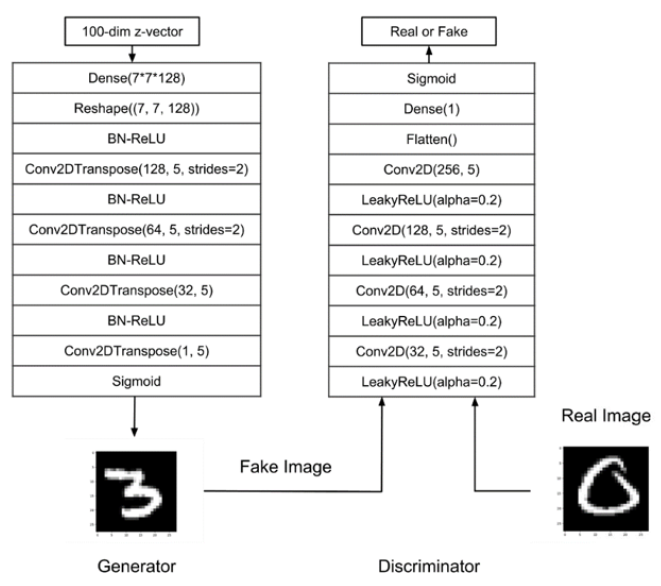

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse

In [2]:
def build_generator(inputs, image_size):
    """Build a Generator Model

    Stack of BN-ReLU-Conv2DTranpose to generate fake images
    Output activation is sigmoid instead of tanh in [1].
    Sigmoid converges easily.

    Arguments:
        inputs (Layer): Input layer of the generator 
            the z-vector)
        image_size (tensor): Target size of one side
            (assuming square image)

    Returns:
        generator (Model): Generator Model
    """

    image_resize = image_size // 4
    # network parameters 
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = Dense(image_resize * image_resize * layer_filters[0])(inputs)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    generator = Model(inputs, x, name='generator')
    return generator

In [3]:
def build_discriminator(inputs):
    """Build a Discriminator Model

    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in [1] or original paper.

    Arguments:
        inputs (Layer): Input layer of the discriminator (the image)

    Returns:
        discriminator (Model): Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')
    return discriminator

In [4]:
def train(models, x_train, params):
    """Train the Discriminator and Adversarial Networks

    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly real and fake images.
    Adversarial is trained next with fake images pretending to be real
    Generate sample images per save_interval.

    Arguments:
        models (list): Generator, Discriminator, Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters

    """
    # the GAN component models
    generator, discriminator, adversarial = models
    # network parameters
    batch_size, latent_size, train_steps, model_name = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # number of elements in train dataset
    train_size = x_train.shape[0]
    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        # generate fake images from noise using generator 
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        # generate fake images
        fake_images = generator.predict(noise)
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        # train discriminator network, log the loss and accuracy
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0
        # since the discriminator weights 
        # are frozen in adversarial network
        # only the generator is trained
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0,
                                  1.0, 
                                  size=[batch_size, latent_size])
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial
        # for classification
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        show=False,
                        step=(i + 1),
                        model_name=model_name)
   
    # save the model after training the generator
    # the trained generator can be reloaded for 
    # future MNIST digit generation
    generator.save(model_name + ".h5")

In [5]:
def plot_images(generator,
                noise_input,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    Arguments:
        generator (Model): The Generator Model for 
            fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')


In [6]:
def build_and_train_models():
    # load MNIST dataset
    (x_train, _), (_, _) = mnist.load_data()

    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    model_name = "dcgan_mnist"
    # network parameters
    # the latent or z vector is 100-dim
    latent_size = 100
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    discriminator = build_discriminator(inputs)
    # [1] or original paper uses Adam, 
    # but discriminator converges easily with RMSprop
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()

    # build adversarial model
    optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    # freeze the weights of discriminator during adversarial training
    discriminator.trainable = False
    # adversarial = generator + discriminator
    adversarial = Model(inputs, 
                        discriminator(generator(inputs)),
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name)
    train(models, x_train, params)

In [7]:
def test_generator(generator):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    plot_images(generator,
                noise_input=noise_input,
                show=True,
                model_name="test_outputs")

In [8]:
build_and_train_models()

C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                     

24: [discriminator loss: 0.003163, acc: 1.000000] [adversarial loss: 0.001553, acc: 1.000000]
25: [discriminator loss: 0.004119, acc: 1.000000] [adversarial loss: 0.001058, acc: 1.000000]
26: [discriminator loss: 0.002654, acc: 1.000000] [adversarial loss: 0.000871, acc: 1.000000]
27: [discriminator loss: 0.002594, acc: 1.000000] [adversarial loss: 0.000687, acc: 1.000000]
28: [discriminator loss: 0.001796, acc: 1.000000] [adversarial loss: 0.000624, acc: 1.000000]
29: [discriminator loss: 0.001779, acc: 1.000000] [adversarial loss: 0.000527, acc: 1.000000]
30: [discriminator loss: 0.001850, acc: 1.000000] [adversarial loss: 0.000394, acc: 1.000000]
31: [discriminator loss: 0.001617, acc: 1.000000] [adversarial loss: 0.000321, acc: 1.000000]
32: [discriminator loss: 0.001495, acc: 1.000000] [adversarial loss: 0.000269, acc: 1.000000]
33: [discriminator loss: 0.001048, acc: 1.000000] [adversarial loss: 0.000245, acc: 1.000000]
34: [discriminator loss: 0.001004, acc: 1.000000] [adversari

112: [discriminator loss: 0.000009, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
113: [discriminator loss: 0.000006, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
114: [discriminator loss: 0.000006, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
115: [discriminator loss: 0.000005, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
116: [discriminator loss: 0.000005, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
117: [discriminator loss: 0.000005, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
118: [discriminator loss: 0.000006, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
119: [discriminator loss: 0.000006, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
120: [discriminator loss: 0.000004, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
121: [discriminator loss: 0.000007, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
122: [discriminator loss: 0.000005, acc: 1.000000]

199: [discriminator loss: 0.000033, acc: 1.000000] [adversarial loss: 0.022600, acc: 1.000000]
200: [discriminator loss: 0.000030, acc: 1.000000] [adversarial loss: 0.075353, acc: 1.000000]
201: [discriminator loss: 0.000046, acc: 1.000000] [adversarial loss: 0.081236, acc: 1.000000]
202: [discriminator loss: 0.000046, acc: 1.000000] [adversarial loss: 0.324220, acc: 1.000000]
203: [discriminator loss: 0.000060, acc: 1.000000] [adversarial loss: 0.032474, acc: 1.000000]
204: [discriminator loss: 0.000307, acc: 1.000000] [adversarial loss: 0.000001, acc: 1.000000]
205: [discriminator loss: 0.732854, acc: 0.507812] [adversarial loss: 10.166833, acc: 0.000000]
206: [discriminator loss: 0.053527, acc: 0.976562] [adversarial loss: 6.737707, acc: 0.000000]
207: [discriminator loss: 0.000285, acc: 1.000000] [adversarial loss: 4.395922, acc: 0.000000]
208: [discriminator loss: 0.000007, acc: 1.000000] [adversarial loss: 3.699692, acc: 0.000000]
209: [discriminator loss: 0.000453, acc: 1.000000

286: [discriminator loss: 0.001266, acc: 1.000000] [adversarial loss: 0.022235, acc: 1.000000]
287: [discriminator loss: 0.001317, acc: 1.000000] [adversarial loss: 0.025954, acc: 1.000000]
288: [discriminator loss: 0.004114, acc: 1.000000] [adversarial loss: 0.011003, acc: 1.000000]
289: [discriminator loss: 0.001989, acc: 1.000000] [adversarial loss: 0.023557, acc: 1.000000]
290: [discriminator loss: 0.001300, acc: 1.000000] [adversarial loss: 0.034366, acc: 1.000000]
291: [discriminator loss: 0.001479, acc: 1.000000] [adversarial loss: 0.037183, acc: 1.000000]
292: [discriminator loss: 0.001630, acc: 1.000000] [adversarial loss: 0.044611, acc: 1.000000]
293: [discriminator loss: 0.001526, acc: 1.000000] [adversarial loss: 0.045997, acc: 1.000000]
294: [discriminator loss: 0.001292, acc: 1.000000] [adversarial loss: 0.065311, acc: 1.000000]
295: [discriminator loss: 0.012727, acc: 0.992188] [adversarial loss: 0.000336, acc: 1.000000]
296: [discriminator loss: 0.049709, acc: 1.000000]

373: [discriminator loss: 0.045916, acc: 0.992188] [adversarial loss: 0.601146, acc: 0.796875]
374: [discriminator loss: 0.055953, acc: 0.992188] [adversarial loss: 0.697355, acc: 0.562500]
375: [discriminator loss: 0.057149, acc: 1.000000] [adversarial loss: 1.277323, acc: 0.000000]
376: [discriminator loss: 0.109130, acc: 0.984375] [adversarial loss: 0.884828, acc: 0.125000]
377: [discriminator loss: 0.282670, acc: 0.976562] [adversarial loss: 4.321380, acc: 0.000000]
378: [discriminator loss: 0.886747, acc: 0.640625] [adversarial loss: 0.000024, acc: 1.000000]
379: [discriminator loss: 1.888555, acc: 0.507812] [adversarial loss: 0.056691, acc: 1.000000]
380: [discriminator loss: 0.184886, acc: 0.953125] [adversarial loss: 0.469824, acc: 0.984375]
381: [discriminator loss: 0.104632, acc: 1.000000] [adversarial loss: 0.788587, acc: 0.187500]
382: [discriminator loss: 0.094936, acc: 0.984375] [adversarial loss: 0.668452, acc: 0.656250]
383: [discriminator loss: 0.070995, acc: 1.000000]

460: [discriminator loss: 0.358200, acc: 0.804688] [adversarial loss: 0.400867, acc: 0.984375]
461: [discriminator loss: 0.593662, acc: 0.617188] [adversarial loss: 6.389877, acc: 0.000000]
462: [discriminator loss: 0.334407, acc: 0.828125] [adversarial loss: 0.866048, acc: 0.015625]
463: [discriminator loss: 0.409644, acc: 0.695312] [adversarial loss: 4.629728, acc: 0.000000]
464: [discriminator loss: 0.208289, acc: 0.914062] [adversarial loss: 0.976189, acc: 0.000000]
465: [discriminator loss: 0.256875, acc: 0.882812] [adversarial loss: 3.036089, acc: 0.000000]
466: [discriminator loss: 0.183819, acc: 0.929688] [adversarial loss: 0.818197, acc: 0.250000]
467: [discriminator loss: 0.122733, acc: 0.992188] [adversarial loss: 2.207422, acc: 0.000000]
468: [discriminator loss: 0.100325, acc: 0.976562] [adversarial loss: 1.445928, acc: 0.000000]
469: [discriminator loss: 0.083979, acc: 0.992188] [adversarial loss: 1.902094, acc: 0.000000]
470: [discriminator loss: 0.074653, acc: 0.984375]

547: [discriminator loss: 0.029648, acc: 0.992188] [adversarial loss: 0.146768, acc: 1.000000]
548: [discriminator loss: 0.020774, acc: 1.000000] [adversarial loss: 0.264576, acc: 1.000000]
549: [discriminator loss: 0.033903, acc: 0.984375] [adversarial loss: 0.040470, acc: 1.000000]
550: [discriminator loss: 0.020038, acc: 1.000000] [adversarial loss: 0.216238, acc: 1.000000]
551: [discriminator loss: 0.025686, acc: 0.992188] [adversarial loss: 0.053154, acc: 1.000000]
552: [discriminator loss: 0.007739, acc: 1.000000] [adversarial loss: 0.064391, acc: 1.000000]
553: [discriminator loss: 0.009109, acc: 1.000000] [adversarial loss: 0.070195, acc: 1.000000]
554: [discriminator loss: 0.017539, acc: 0.992188] [adversarial loss: 0.031185, acc: 1.000000]
555: [discriminator loss: 0.013565, acc: 0.992188] [adversarial loss: 0.023111, acc: 1.000000]
556: [discriminator loss: 0.016034, acc: 1.000000] [adversarial loss: 0.009933, acc: 1.000000]
557: [discriminator loss: 0.024065, acc: 0.984375]

634: [discriminator loss: 0.012035, acc: 1.000000] [adversarial loss: 0.012832, acc: 1.000000]
635: [discriminator loss: 0.006732, acc: 1.000000] [adversarial loss: 0.017987, acc: 1.000000]
636: [discriminator loss: 0.008355, acc: 1.000000] [adversarial loss: 0.058230, acc: 1.000000]
637: [discriminator loss: 0.006957, acc: 1.000000] [adversarial loss: 0.036643, acc: 1.000000]
638: [discriminator loss: 0.007225, acc: 1.000000] [adversarial loss: 0.024234, acc: 1.000000]
639: [discriminator loss: 0.001792, acc: 1.000000] [adversarial loss: 0.021253, acc: 1.000000]
640: [discriminator loss: 0.003597, acc: 1.000000] [adversarial loss: 0.021857, acc: 1.000000]
641: [discriminator loss: 0.004199, acc: 1.000000] [adversarial loss: 0.030811, acc: 1.000000]
642: [discriminator loss: 0.005403, acc: 1.000000] [adversarial loss: 0.038238, acc: 1.000000]
643: [discriminator loss: 0.005067, acc: 1.000000] [adversarial loss: 0.063445, acc: 1.000000]
644: [discriminator loss: 0.001925, acc: 1.000000]

721: [discriminator loss: 0.071971, acc: 0.968750] [adversarial loss: 0.046575, acc: 0.984375]
722: [discriminator loss: 0.073926, acc: 0.968750] [adversarial loss: 0.062211, acc: 1.000000]
723: [discriminator loss: 0.059436, acc: 0.976562] [adversarial loss: 0.923449, acc: 0.406250]
724: [discriminator loss: 0.171022, acc: 0.968750] [adversarial loss: 3.019818, acc: 0.031250]
725: [discriminator loss: 0.173958, acc: 0.914062] [adversarial loss: 0.001266, acc: 1.000000]
726: [discriminator loss: 0.050226, acc: 0.984375] [adversarial loss: 0.011596, acc: 1.000000]
727: [discriminator loss: 0.021452, acc: 0.992188] [adversarial loss: 0.008013, acc: 1.000000]
728: [discriminator loss: 0.012387, acc: 1.000000] [adversarial loss: 0.025324, acc: 1.000000]
729: [discriminator loss: 0.019429, acc: 1.000000] [adversarial loss: 0.027698, acc: 1.000000]
730: [discriminator loss: 0.056749, acc: 0.984375] [adversarial loss: 0.233494, acc: 0.968750]
731: [discriminator loss: 0.066514, acc: 0.984375]

808: [discriminator loss: 0.222030, acc: 0.921875] [adversarial loss: 0.213828, acc: 0.921875]
809: [discriminator loss: 0.269097, acc: 0.882812] [adversarial loss: 3.833859, acc: 0.015625]
810: [discriminator loss: 0.512621, acc: 0.796875] [adversarial loss: 0.010440, acc: 1.000000]
811: [discriminator loss: 1.170333, acc: 0.546875] [adversarial loss: 6.178961, acc: 0.000000]
812: [discriminator loss: 0.749043, acc: 0.765625] [adversarial loss: 0.522839, acc: 0.734375]
813: [discriminator loss: 0.178130, acc: 0.937500] [adversarial loss: 1.029965, acc: 0.296875]
814: [discriminator loss: 0.100826, acc: 0.976562] [adversarial loss: 0.572966, acc: 0.656250]
815: [discriminator loss: 0.106250, acc: 0.976562] [adversarial loss: 0.898476, acc: 0.468750]
816: [discriminator loss: 0.104213, acc: 0.976562] [adversarial loss: 1.176080, acc: 0.328125]
817: [discriminator loss: 0.181404, acc: 0.937500] [adversarial loss: 1.394085, acc: 0.203125]
818: [discriminator loss: 0.153423, acc: 0.992188]

895: [discriminator loss: 0.057412, acc: 0.992188] [adversarial loss: 1.006307, acc: 0.390625]
896: [discriminator loss: 0.034426, acc: 0.984375] [adversarial loss: 1.683494, acc: 0.062500]
897: [discriminator loss: 0.074278, acc: 0.976562] [adversarial loss: 0.569939, acc: 0.750000]
898: [discriminator loss: 0.070180, acc: 0.976562] [adversarial loss: 4.965153, acc: 0.000000]
899: [discriminator loss: 0.083232, acc: 0.960938] [adversarial loss: 0.184407, acc: 0.968750]
900: [discriminator loss: 0.029905, acc: 0.992188] [adversarial loss: 0.630482, acc: 0.625000]
901: [discriminator loss: 0.065816, acc: 0.976562] [adversarial loss: 2.453661, acc: 0.062500]
902: [discriminator loss: 0.098297, acc: 0.960938] [adversarial loss: 0.909078, acc: 0.421875]
903: [discriminator loss: 0.173679, acc: 0.921875] [adversarial loss: 9.525759, acc: 0.000000]
904: [discriminator loss: 0.747217, acc: 0.742188] [adversarial loss: 0.067129, acc: 1.000000]
905: [discriminator loss: 0.033603, acc: 0.992188]

982: [discriminator loss: 0.885454, acc: 0.609375] [adversarial loss: 0.159632, acc: 0.937500]
983: [discriminator loss: 0.723530, acc: 0.671875] [adversarial loss: 2.441636, acc: 0.000000]
984: [discriminator loss: 0.588110, acc: 0.734375] [adversarial loss: 0.455316, acc: 0.750000]
985: [discriminator loss: 0.468650, acc: 0.765625] [adversarial loss: 1.727451, acc: 0.218750]
986: [discriminator loss: 0.355609, acc: 0.843750] [adversarial loss: 0.346130, acc: 0.812500]
987: [discriminator loss: 0.212452, acc: 0.929688] [adversarial loss: 0.145818, acc: 0.968750]
988: [discriminator loss: 0.168103, acc: 0.921875] [adversarial loss: 0.174183, acc: 0.953125]
989: [discriminator loss: 0.192176, acc: 0.937500] [adversarial loss: 0.145205, acc: 0.968750]
990: [discriminator loss: 0.136949, acc: 0.953125] [adversarial loss: 0.106306, acc: 0.984375]
991: [discriminator loss: 0.154767, acc: 0.960938] [adversarial loss: 0.084224, acc: 0.984375]
992: [discriminator loss: 0.340613, acc: 0.867188]

1068: [discriminator loss: 0.428591, acc: 0.820312] [adversarial loss: 0.470106, acc: 0.828125]
1069: [discriminator loss: 0.521988, acc: 0.742188] [adversarial loss: 0.648072, acc: 0.640625]
1070: [discriminator loss: 0.663645, acc: 0.593750] [adversarial loss: 0.844866, acc: 0.421875]
1071: [discriminator loss: 0.495391, acc: 0.804688] [adversarial loss: 0.516617, acc: 0.765625]
1072: [discriminator loss: 0.770880, acc: 0.507812] [adversarial loss: 1.571293, acc: 0.015625]
1073: [discriminator loss: 0.641314, acc: 0.578125] [adversarial loss: 0.589097, acc: 0.687500]
1074: [discriminator loss: 0.673891, acc: 0.578125] [adversarial loss: 1.426164, acc: 0.031250]
1075: [discriminator loss: 0.534247, acc: 0.726562] [adversarial loss: 0.590232, acc: 0.734375]
1076: [discriminator loss: 0.585278, acc: 0.656250] [adversarial loss: 0.932176, acc: 0.281250]
1077: [discriminator loss: 0.576876, acc: 0.695312] [adversarial loss: 0.807693, acc: 0.406250]
1078: [discriminator loss: 0.497498, acc

1154: [discriminator loss: 0.558254, acc: 0.695312] [adversarial loss: 0.838411, acc: 0.312500]
1155: [discriminator loss: 0.479961, acc: 0.765625] [adversarial loss: 0.608618, acc: 0.609375]
1156: [discriminator loss: 0.499256, acc: 0.757812] [adversarial loss: 0.768362, acc: 0.437500]
1157: [discriminator loss: 0.533505, acc: 0.757812] [adversarial loss: 0.822988, acc: 0.406250]
1158: [discriminator loss: 0.567289, acc: 0.687500] [adversarial loss: 1.424688, acc: 0.000000]
1159: [discriminator loss: 0.530722, acc: 0.710938] [adversarial loss: 0.548352, acc: 0.656250]
1160: [discriminator loss: 0.649076, acc: 0.585938] [adversarial loss: 1.406648, acc: 0.015625]
1161: [discriminator loss: 0.555801, acc: 0.718750] [adversarial loss: 0.806012, acc: 0.390625]
1162: [discriminator loss: 0.510756, acc: 0.781250] [adversarial loss: 0.814356, acc: 0.453125]
1163: [discriminator loss: 0.631270, acc: 0.625000] [adversarial loss: 1.934764, acc: 0.000000]
1164: [discriminator loss: 0.579632, acc

1240: [discriminator loss: 0.542569, acc: 0.656250] [adversarial loss: 1.247823, acc: 0.093750]
1241: [discriminator loss: 0.436307, acc: 0.867188] [adversarial loss: 1.260037, acc: 0.046875]
1242: [discriminator loss: 0.513517, acc: 0.742188] [adversarial loss: 1.278383, acc: 0.078125]
1243: [discriminator loss: 0.475777, acc: 0.773438] [adversarial loss: 1.096712, acc: 0.156250]
1244: [discriminator loss: 0.517168, acc: 0.695312] [adversarial loss: 1.337459, acc: 0.109375]
1245: [discriminator loss: 0.458406, acc: 0.828125] [adversarial loss: 1.427346, acc: 0.031250]
1246: [discriminator loss: 0.563072, acc: 0.710938] [adversarial loss: 0.933467, acc: 0.296875]
1247: [discriminator loss: 0.493597, acc: 0.781250] [adversarial loss: 1.052119, acc: 0.265625]
1248: [discriminator loss: 0.475028, acc: 0.843750] [adversarial loss: 1.369601, acc: 0.078125]
1249: [discriminator loss: 0.544258, acc: 0.718750] [adversarial loss: 0.995249, acc: 0.234375]
1250: [discriminator loss: 0.528720, acc

1326: [discriminator loss: 0.419834, acc: 0.820312] [adversarial loss: 1.363086, acc: 0.125000]
1327: [discriminator loss: 0.445095, acc: 0.796875] [adversarial loss: 1.119503, acc: 0.171875]
1328: [discriminator loss: 0.445647, acc: 0.812500] [adversarial loss: 1.596039, acc: 0.015625]
1329: [discriminator loss: 0.478079, acc: 0.789062] [adversarial loss: 0.934800, acc: 0.375000]
1330: [discriminator loss: 0.473324, acc: 0.781250] [adversarial loss: 2.014196, acc: 0.046875]
1331: [discriminator loss: 0.573792, acc: 0.679688] [adversarial loss: 0.706233, acc: 0.531250]
1332: [discriminator loss: 0.558979, acc: 0.648438] [adversarial loss: 1.858743, acc: 0.000000]
1333: [discriminator loss: 0.521938, acc: 0.671875] [adversarial loss: 0.741724, acc: 0.484375]
1334: [discriminator loss: 0.385413, acc: 0.882812] [adversarial loss: 0.975361, acc: 0.250000]
1335: [discriminator loss: 0.463000, acc: 0.812500] [adversarial loss: 1.775278, acc: 0.000000]
1336: [discriminator loss: 0.494824, acc

1412: [discriminator loss: 0.432075, acc: 0.828125] [adversarial loss: 1.461227, acc: 0.078125]
1413: [discriminator loss: 0.370388, acc: 0.859375] [adversarial loss: 1.259075, acc: 0.156250]
1414: [discriminator loss: 0.395223, acc: 0.843750] [adversarial loss: 1.950908, acc: 0.078125]
1415: [discriminator loss: 0.538423, acc: 0.703125] [adversarial loss: 0.960632, acc: 0.359375]
1416: [discriminator loss: 0.429090, acc: 0.812500] [adversarial loss: 2.019987, acc: 0.015625]
1417: [discriminator loss: 0.469749, acc: 0.796875] [adversarial loss: 1.050898, acc: 0.328125]
1418: [discriminator loss: 0.436082, acc: 0.750000] [adversarial loss: 1.873179, acc: 0.046875]
1419: [discriminator loss: 0.446492, acc: 0.789062] [adversarial loss: 1.045922, acc: 0.250000]
1420: [discriminator loss: 0.445838, acc: 0.773438] [adversarial loss: 2.035415, acc: 0.062500]
1421: [discriminator loss: 0.455889, acc: 0.765625] [adversarial loss: 1.155127, acc: 0.234375]
1422: [discriminator loss: 0.441114, acc

1498: [discriminator loss: 0.410266, acc: 0.796875] [adversarial loss: 1.081650, acc: 0.312500]
1499: [discriminator loss: 0.433708, acc: 0.835938] [adversarial loss: 1.877061, acc: 0.062500]
1500: [discriminator loss: 0.444052, acc: 0.773438] [adversarial loss: 0.634352, acc: 0.656250]
1501: [discriminator loss: 0.641840, acc: 0.617188] [adversarial loss: 2.864912, acc: 0.000000]
1502: [discriminator loss: 0.585255, acc: 0.679688] [adversarial loss: 1.107517, acc: 0.312500]
1503: [discriminator loss: 0.405218, acc: 0.851562] [adversarial loss: 1.831398, acc: 0.046875]
1504: [discriminator loss: 0.423759, acc: 0.796875] [adversarial loss: 1.084779, acc: 0.234375]
1505: [discriminator loss: 0.526371, acc: 0.703125] [adversarial loss: 2.130098, acc: 0.000000]
1506: [discriminator loss: 0.480214, acc: 0.742188] [adversarial loss: 1.097933, acc: 0.281250]
1507: [discriminator loss: 0.514787, acc: 0.750000] [adversarial loss: 1.770437, acc: 0.015625]
1508: [discriminator loss: 0.489893, acc

1584: [discriminator loss: 0.457154, acc: 0.781250] [adversarial loss: 2.387819, acc: 0.015625]
1585: [discriminator loss: 0.499858, acc: 0.742188] [adversarial loss: 1.229182, acc: 0.203125]
1586: [discriminator loss: 0.478642, acc: 0.765625] [adversarial loss: 2.008438, acc: 0.000000]
1587: [discriminator loss: 0.473546, acc: 0.742188] [adversarial loss: 1.110690, acc: 0.250000]
1588: [discriminator loss: 0.447925, acc: 0.742188] [adversarial loss: 1.970915, acc: 0.062500]
1589: [discriminator loss: 0.496607, acc: 0.742188] [adversarial loss: 0.894236, acc: 0.421875]
1590: [discriminator loss: 0.497052, acc: 0.789062] [adversarial loss: 1.730079, acc: 0.109375]
1591: [discriminator loss: 0.457456, acc: 0.773438] [adversarial loss: 1.088161, acc: 0.218750]
1592: [discriminator loss: 0.508685, acc: 0.695312] [adversarial loss: 1.906511, acc: 0.000000]
1593: [discriminator loss: 0.436003, acc: 0.804688] [adversarial loss: 1.189623, acc: 0.187500]
1594: [discriminator loss: 0.452385, acc

1670: [discriminator loss: 0.452246, acc: 0.796875] [adversarial loss: 2.126496, acc: 0.000000]
1671: [discriminator loss: 0.575565, acc: 0.695312] [adversarial loss: 0.885222, acc: 0.375000]
1672: [discriminator loss: 0.541314, acc: 0.757812] [adversarial loss: 1.794892, acc: 0.062500]
1673: [discriminator loss: 0.520430, acc: 0.718750] [adversarial loss: 0.721561, acc: 0.546875]
1674: [discriminator loss: 0.561564, acc: 0.718750] [adversarial loss: 2.059116, acc: 0.046875]
1675: [discriminator loss: 0.545684, acc: 0.703125] [adversarial loss: 0.953817, acc: 0.359375]
1676: [discriminator loss: 0.563594, acc: 0.687500] [adversarial loss: 1.970130, acc: 0.015625]
1677: [discriminator loss: 0.504659, acc: 0.750000] [adversarial loss: 1.083789, acc: 0.218750]
1678: [discriminator loss: 0.476757, acc: 0.742188] [adversarial loss: 1.421439, acc: 0.140625]
1679: [discriminator loss: 0.420439, acc: 0.828125] [adversarial loss: 1.217420, acc: 0.203125]
1680: [discriminator loss: 0.426249, acc

1756: [discriminator loss: 0.510292, acc: 0.757812] [adversarial loss: 1.060775, acc: 0.265625]
1757: [discriminator loss: 0.430092, acc: 0.781250] [adversarial loss: 1.509603, acc: 0.125000]
1758: [discriminator loss: 0.486379, acc: 0.820312] [adversarial loss: 1.331713, acc: 0.140625]
1759: [discriminator loss: 0.447111, acc: 0.851562] [adversarial loss: 1.350962, acc: 0.171875]
1760: [discriminator loss: 0.476803, acc: 0.750000] [adversarial loss: 1.147272, acc: 0.203125]
1761: [discriminator loss: 0.430375, acc: 0.812500] [adversarial loss: 1.469703, acc: 0.187500]
1762: [discriminator loss: 0.502739, acc: 0.734375] [adversarial loss: 0.834059, acc: 0.531250]
1763: [discriminator loss: 0.525943, acc: 0.726562] [adversarial loss: 2.197643, acc: 0.015625]
1764: [discriminator loss: 0.563327, acc: 0.703125] [adversarial loss: 0.726027, acc: 0.578125]
1765: [discriminator loss: 0.516152, acc: 0.687500] [adversarial loss: 1.455891, acc: 0.140625]
1766: [discriminator loss: 0.448573, acc

1842: [discriminator loss: 0.395176, acc: 0.828125] [adversarial loss: 0.926934, acc: 0.296875]
1843: [discriminator loss: 0.461576, acc: 0.781250] [adversarial loss: 1.303175, acc: 0.171875]
1844: [discriminator loss: 0.458808, acc: 0.765625] [adversarial loss: 1.138670, acc: 0.203125]
1845: [discriminator loss: 0.495104, acc: 0.750000] [adversarial loss: 1.232182, acc: 0.218750]
1846: [discriminator loss: 0.568608, acc: 0.734375] [adversarial loss: 1.520305, acc: 0.109375]
1847: [discriminator loss: 0.505152, acc: 0.734375] [adversarial loss: 1.300294, acc: 0.156250]
1848: [discriminator loss: 0.498696, acc: 0.773438] [adversarial loss: 1.103135, acc: 0.296875]
1849: [discriminator loss: 0.471458, acc: 0.812500] [adversarial loss: 1.464935, acc: 0.093750]
1850: [discriminator loss: 0.459768, acc: 0.773438] [adversarial loss: 0.954633, acc: 0.390625]
1851: [discriminator loss: 0.520119, acc: 0.703125] [adversarial loss: 2.160088, acc: 0.015625]
1852: [discriminator loss: 0.601882, acc

1928: [discriminator loss: 0.440319, acc: 0.812500] [adversarial loss: 1.484915, acc: 0.171875]
1929: [discriminator loss: 0.589983, acc: 0.726562] [adversarial loss: 0.954989, acc: 0.390625]
1930: [discriminator loss: 0.525209, acc: 0.734375] [adversarial loss: 1.481764, acc: 0.156250]
1931: [discriminator loss: 0.475430, acc: 0.820312] [adversarial loss: 1.090272, acc: 0.250000]
1932: [discriminator loss: 0.499078, acc: 0.742188] [adversarial loss: 1.534089, acc: 0.109375]
1933: [discriminator loss: 0.547236, acc: 0.765625] [adversarial loss: 1.005675, acc: 0.265625]
1934: [discriminator loss: 0.484901, acc: 0.765625] [adversarial loss: 1.709662, acc: 0.062500]
1935: [discriminator loss: 0.496940, acc: 0.750000] [adversarial loss: 1.017037, acc: 0.312500]
1936: [discriminator loss: 0.502107, acc: 0.750000] [adversarial loss: 1.444510, acc: 0.156250]
1937: [discriminator loss: 0.565067, acc: 0.742188] [adversarial loss: 1.054114, acc: 0.375000]
1938: [discriminator loss: 0.495947, acc

2014: [discriminator loss: 0.507582, acc: 0.757812] [adversarial loss: 0.749184, acc: 0.562500]
2015: [discriminator loss: 0.661000, acc: 0.656250] [adversarial loss: 2.043383, acc: 0.000000]
2016: [discriminator loss: 0.588176, acc: 0.687500] [adversarial loss: 0.853458, acc: 0.468750]
2017: [discriminator loss: 0.584570, acc: 0.593750] [adversarial loss: 1.496588, acc: 0.140625]
2018: [discriminator loss: 0.550444, acc: 0.734375] [adversarial loss: 0.758678, acc: 0.500000]
2019: [discriminator loss: 0.531288, acc: 0.750000] [adversarial loss: 1.509536, acc: 0.187500]
2020: [discriminator loss: 0.426958, acc: 0.828125] [adversarial loss: 1.154532, acc: 0.140625]
2021: [discriminator loss: 0.471856, acc: 0.726562] [adversarial loss: 1.652029, acc: 0.046875]
2022: [discriminator loss: 0.464520, acc: 0.804688] [adversarial loss: 1.046916, acc: 0.250000]
2023: [discriminator loss: 0.489753, acc: 0.781250] [adversarial loss: 1.594368, acc: 0.093750]
2024: [discriminator loss: 0.509684, acc

2100: [discriminator loss: 0.641574, acc: 0.726562] [adversarial loss: 0.753683, acc: 0.578125]
2101: [discriminator loss: 0.644556, acc: 0.656250] [adversarial loss: 1.774194, acc: 0.125000]
2102: [discriminator loss: 0.534585, acc: 0.750000] [adversarial loss: 0.840306, acc: 0.390625]
2103: [discriminator loss: 0.541755, acc: 0.742188] [adversarial loss: 1.584736, acc: 0.093750]
2104: [discriminator loss: 0.529783, acc: 0.687500] [adversarial loss: 1.227324, acc: 0.125000]
2105: [discriminator loss: 0.426149, acc: 0.835938] [adversarial loss: 1.370481, acc: 0.125000]
2106: [discriminator loss: 0.438037, acc: 0.789062] [adversarial loss: 1.435883, acc: 0.125000]
2107: [discriminator loss: 0.523396, acc: 0.742188] [adversarial loss: 1.039201, acc: 0.281250]
2108: [discriminator loss: 0.444230, acc: 0.789062] [adversarial loss: 1.521306, acc: 0.093750]
2109: [discriminator loss: 0.419955, acc: 0.835938] [adversarial loss: 0.932145, acc: 0.390625]
2110: [discriminator loss: 0.593240, acc

2186: [discriminator loss: 0.499547, acc: 0.742188] [adversarial loss: 1.133235, acc: 0.265625]
2187: [discriminator loss: 0.565764, acc: 0.695312] [adversarial loss: 1.208000, acc: 0.171875]
2188: [discriminator loss: 0.498115, acc: 0.757812] [adversarial loss: 1.279175, acc: 0.203125]
2189: [discriminator loss: 0.480405, acc: 0.781250] [adversarial loss: 1.023852, acc: 0.312500]
2190: [discriminator loss: 0.458058, acc: 0.773438] [adversarial loss: 1.554177, acc: 0.125000]
2191: [discriminator loss: 0.434246, acc: 0.843750] [adversarial loss: 1.165075, acc: 0.218750]
2192: [discriminator loss: 0.434290, acc: 0.804688] [adversarial loss: 1.626531, acc: 0.062500]
2193: [discriminator loss: 0.554941, acc: 0.710938] [adversarial loss: 0.942852, acc: 0.359375]
2194: [discriminator loss: 0.502416, acc: 0.757812] [adversarial loss: 1.905486, acc: 0.093750]
2195: [discriminator loss: 0.618519, acc: 0.695312] [adversarial loss: 0.693557, acc: 0.531250]
2196: [discriminator loss: 0.590915, acc

2272: [discriminator loss: 0.620665, acc: 0.679688] [adversarial loss: 2.067972, acc: 0.031250]
2273: [discriminator loss: 0.645515, acc: 0.671875] [adversarial loss: 0.753011, acc: 0.578125]
2274: [discriminator loss: 0.669968, acc: 0.671875] [adversarial loss: 1.848175, acc: 0.109375]
2275: [discriminator loss: 0.496723, acc: 0.726562] [adversarial loss: 1.248572, acc: 0.156250]
2276: [discriminator loss: 0.468975, acc: 0.765625] [adversarial loss: 1.466301, acc: 0.078125]
2277: [discriminator loss: 0.427702, acc: 0.812500] [adversarial loss: 1.067030, acc: 0.296875]
2278: [discriminator loss: 0.549305, acc: 0.734375] [adversarial loss: 1.123385, acc: 0.234375]
2279: [discriminator loss: 0.430011, acc: 0.835938] [adversarial loss: 1.396680, acc: 0.109375]
2280: [discriminator loss: 0.447159, acc: 0.796875] [adversarial loss: 1.155764, acc: 0.250000]
2281: [discriminator loss: 0.534122, acc: 0.710938] [adversarial loss: 1.476027, acc: 0.125000]
2282: [discriminator loss: 0.510366, acc

2358: [discriminator loss: 0.484213, acc: 0.773438] [adversarial loss: 1.208928, acc: 0.203125]
2359: [discriminator loss: 0.446059, acc: 0.796875] [adversarial loss: 1.289085, acc: 0.218750]
2360: [discriminator loss: 0.487922, acc: 0.781250] [adversarial loss: 1.573601, acc: 0.125000]
2361: [discriminator loss: 0.554686, acc: 0.703125] [adversarial loss: 1.100357, acc: 0.343750]
2362: [discriminator loss: 0.510151, acc: 0.703125] [adversarial loss: 1.408154, acc: 0.203125]
2363: [discriminator loss: 0.480550, acc: 0.750000] [adversarial loss: 0.950610, acc: 0.359375]
2364: [discriminator loss: 0.545659, acc: 0.757812] [adversarial loss: 1.381183, acc: 0.125000]
2365: [discriminator loss: 0.498362, acc: 0.820312] [adversarial loss: 1.137741, acc: 0.375000]
2366: [discriminator loss: 0.494488, acc: 0.734375] [adversarial loss: 1.446790, acc: 0.109375]
2367: [discriminator loss: 0.531454, acc: 0.742188] [adversarial loss: 1.162875, acc: 0.328125]
2368: [discriminator loss: 0.494094, acc

2445: [discriminator loss: 0.475344, acc: 0.820312] [adversarial loss: 1.286038, acc: 0.171875]
2446: [discriminator loss: 0.478460, acc: 0.781250] [adversarial loss: 1.492636, acc: 0.125000]
2447: [discriminator loss: 0.471889, acc: 0.765625] [adversarial loss: 1.346669, acc: 0.171875]
2448: [discriminator loss: 0.443646, acc: 0.796875] [adversarial loss: 1.742509, acc: 0.031250]
2449: [discriminator loss: 0.555979, acc: 0.703125] [adversarial loss: 0.947473, acc: 0.250000]
2450: [discriminator loss: 0.525494, acc: 0.710938] [adversarial loss: 1.744782, acc: 0.000000]
2451: [discriminator loss: 0.474453, acc: 0.765625] [adversarial loss: 0.948139, acc: 0.343750]
2452: [discriminator loss: 0.527625, acc: 0.734375] [adversarial loss: 2.404394, acc: 0.000000]
2453: [discriminator loss: 0.620935, acc: 0.671875] [adversarial loss: 0.793146, acc: 0.515625]
2454: [discriminator loss: 0.593353, acc: 0.710938] [adversarial loss: 1.680369, acc: 0.046875]
2455: [discriminator loss: 0.566614, acc

2531: [discriminator loss: 0.506636, acc: 0.773438] [adversarial loss: 1.126249, acc: 0.203125]
2532: [discriminator loss: 0.515115, acc: 0.734375] [adversarial loss: 1.847756, acc: 0.015625]
2533: [discriminator loss: 0.452900, acc: 0.757812] [adversarial loss: 1.348795, acc: 0.234375]
2534: [discriminator loss: 0.463542, acc: 0.789062] [adversarial loss: 1.303015, acc: 0.203125]
2535: [discriminator loss: 0.429125, acc: 0.820312] [adversarial loss: 0.912944, acc: 0.328125]
2536: [discriminator loss: 0.535189, acc: 0.726562] [adversarial loss: 1.626278, acc: 0.093750]
2537: [discriminator loss: 0.623724, acc: 0.695312] [adversarial loss: 0.988196, acc: 0.343750]
2538: [discriminator loss: 0.541223, acc: 0.687500] [adversarial loss: 1.431588, acc: 0.156250]
2539: [discriminator loss: 0.494163, acc: 0.773438] [adversarial loss: 1.036289, acc: 0.250000]
2540: [discriminator loss: 0.453748, acc: 0.773438] [adversarial loss: 1.515969, acc: 0.140625]
2541: [discriminator loss: 0.531887, acc

2617: [discriminator loss: 0.496811, acc: 0.789062] [adversarial loss: 1.043714, acc: 0.265625]
2618: [discriminator loss: 0.525337, acc: 0.742188] [adversarial loss: 1.596280, acc: 0.062500]
2619: [discriminator loss: 0.494506, acc: 0.789062] [adversarial loss: 1.109795, acc: 0.265625]
2620: [discriminator loss: 0.517786, acc: 0.726562] [adversarial loss: 1.290428, acc: 0.187500]
2621: [discriminator loss: 0.454284, acc: 0.828125] [adversarial loss: 1.347158, acc: 0.187500]
2622: [discriminator loss: 0.467242, acc: 0.812500] [adversarial loss: 1.202820, acc: 0.187500]
2623: [discriminator loss: 0.508885, acc: 0.742188] [adversarial loss: 1.341106, acc: 0.156250]
2624: [discriminator loss: 0.432405, acc: 0.820312] [adversarial loss: 1.078050, acc: 0.296875]
2625: [discriminator loss: 0.445410, acc: 0.789062] [adversarial loss: 1.472547, acc: 0.203125]
2626: [discriminator loss: 0.481010, acc: 0.757812] [adversarial loss: 1.048994, acc: 0.390625]
2627: [discriminator loss: 0.578250, acc

2703: [discriminator loss: 0.585127, acc: 0.687500] [adversarial loss: 0.884961, acc: 0.437500]
2704: [discriminator loss: 0.545370, acc: 0.742188] [adversarial loss: 1.867488, acc: 0.109375]
2705: [discriminator loss: 0.554907, acc: 0.664062] [adversarial loss: 0.910620, acc: 0.421875]
2706: [discriminator loss: 0.593316, acc: 0.640625] [adversarial loss: 2.076725, acc: 0.078125]
2707: [discriminator loss: 0.625490, acc: 0.710938] [adversarial loss: 1.072167, acc: 0.296875]
2708: [discriminator loss: 0.443849, acc: 0.789062] [adversarial loss: 1.604002, acc: 0.140625]
2709: [discriminator loss: 0.469342, acc: 0.781250] [adversarial loss: 1.286386, acc: 0.203125]
2710: [discriminator loss: 0.506368, acc: 0.757812] [adversarial loss: 1.215453, acc: 0.171875]
2711: [discriminator loss: 0.419257, acc: 0.796875] [adversarial loss: 1.409881, acc: 0.203125]
2712: [discriminator loss: 0.511101, acc: 0.765625] [adversarial loss: 1.496361, acc: 0.250000]
2713: [discriminator loss: 0.520971, acc

2789: [discriminator loss: 0.500078, acc: 0.789062] [adversarial loss: 1.094386, acc: 0.281250]
2790: [discriminator loss: 0.518307, acc: 0.726562] [adversarial loss: 1.789496, acc: 0.062500]
2791: [discriminator loss: 0.650816, acc: 0.640625] [adversarial loss: 1.105804, acc: 0.265625]
2792: [discriminator loss: 0.492596, acc: 0.750000] [adversarial loss: 1.351239, acc: 0.156250]
2793: [discriminator loss: 0.511750, acc: 0.765625] [adversarial loss: 0.983166, acc: 0.312500]
2794: [discriminator loss: 0.519285, acc: 0.750000] [adversarial loss: 1.391696, acc: 0.234375]
2795: [discriminator loss: 0.448510, acc: 0.835938] [adversarial loss: 1.207079, acc: 0.250000]
2796: [discriminator loss: 0.493194, acc: 0.789062] [adversarial loss: 1.403321, acc: 0.093750]
2797: [discriminator loss: 0.487590, acc: 0.726562] [adversarial loss: 1.421366, acc: 0.187500]
2798: [discriminator loss: 0.462370, acc: 0.765625] [adversarial loss: 1.422518, acc: 0.187500]
2799: [discriminator loss: 0.497893, acc

2875: [discriminator loss: 0.506626, acc: 0.757812] [adversarial loss: 1.363354, acc: 0.171875]
2876: [discriminator loss: 0.514777, acc: 0.726562] [adversarial loss: 1.169535, acc: 0.281250]
2877: [discriminator loss: 0.567620, acc: 0.726562] [adversarial loss: 1.720252, acc: 0.093750]
2878: [discriminator loss: 0.479455, acc: 0.726562] [adversarial loss: 1.077710, acc: 0.359375]
2879: [discriminator loss: 0.529686, acc: 0.742188] [adversarial loss: 2.168146, acc: 0.031250]
2880: [discriminator loss: 0.578005, acc: 0.687500] [adversarial loss: 0.802730, acc: 0.484375]
2881: [discriminator loss: 0.566339, acc: 0.734375] [adversarial loss: 1.608789, acc: 0.031250]
2882: [discriminator loss: 0.607755, acc: 0.640625] [adversarial loss: 0.916483, acc: 0.406250]
2883: [discriminator loss: 0.543590, acc: 0.726562] [adversarial loss: 1.580698, acc: 0.093750]
2884: [discriminator loss: 0.548119, acc: 0.734375] [adversarial loss: 1.130257, acc: 0.265625]
2885: [discriminator loss: 0.499963, acc

2961: [discriminator loss: 0.531420, acc: 0.718750] [adversarial loss: 1.032531, acc: 0.343750]
2962: [discriminator loss: 0.503893, acc: 0.781250] [adversarial loss: 1.991651, acc: 0.046875]
2963: [discriminator loss: 0.644572, acc: 0.671875] [adversarial loss: 1.124286, acc: 0.281250]
2964: [discriminator loss: 0.556727, acc: 0.718750] [adversarial loss: 1.874578, acc: 0.171875]
2965: [discriminator loss: 0.484437, acc: 0.789062] [adversarial loss: 1.347252, acc: 0.203125]
2966: [discriminator loss: 0.496298, acc: 0.742188] [adversarial loss: 1.195987, acc: 0.281250]
2967: [discriminator loss: 0.552963, acc: 0.734375] [adversarial loss: 1.268008, acc: 0.203125]
2968: [discriminator loss: 0.445056, acc: 0.804688] [adversarial loss: 0.939686, acc: 0.328125]
2969: [discriminator loss: 0.477412, acc: 0.781250] [adversarial loss: 1.729458, acc: 0.078125]
2970: [discriminator loss: 0.478605, acc: 0.781250] [adversarial loss: 0.987955, acc: 0.312500]
2971: [discriminator loss: 0.471787, acc

3047: [discriminator loss: 0.564807, acc: 0.765625] [adversarial loss: 1.198506, acc: 0.234375]
3048: [discriminator loss: 0.431892, acc: 0.781250] [adversarial loss: 1.305261, acc: 0.250000]
3049: [discriminator loss: 0.458907, acc: 0.773438] [adversarial loss: 1.160604, acc: 0.250000]
3050: [discriminator loss: 0.530146, acc: 0.726562] [adversarial loss: 1.506712, acc: 0.109375]
3051: [discriminator loss: 0.441581, acc: 0.820312] [adversarial loss: 0.907905, acc: 0.468750]
3052: [discriminator loss: 0.533807, acc: 0.726562] [adversarial loss: 1.894380, acc: 0.062500]
3053: [discriminator loss: 0.605690, acc: 0.687500] [adversarial loss: 0.587991, acc: 0.687500]
3054: [discriminator loss: 0.615554, acc: 0.687500] [adversarial loss: 2.085090, acc: 0.078125]
3055: [discriminator loss: 0.575511, acc: 0.718750] [adversarial loss: 0.869985, acc: 0.500000]
3056: [discriminator loss: 0.462217, acc: 0.757812] [adversarial loss: 1.453634, acc: 0.140625]
3057: [discriminator loss: 0.489710, acc

3133: [discriminator loss: 0.488976, acc: 0.765625] [adversarial loss: 1.483694, acc: 0.187500]
3134: [discriminator loss: 0.447512, acc: 0.796875] [adversarial loss: 1.319742, acc: 0.250000]
3135: [discriminator loss: 0.551986, acc: 0.734375] [adversarial loss: 1.520784, acc: 0.156250]
3136: [discriminator loss: 0.503488, acc: 0.750000] [adversarial loss: 0.972737, acc: 0.296875]
3137: [discriminator loss: 0.532114, acc: 0.734375] [adversarial loss: 1.754204, acc: 0.093750]
3138: [discriminator loss: 0.509097, acc: 0.750000] [adversarial loss: 0.790899, acc: 0.500000]
3139: [discriminator loss: 0.554381, acc: 0.710938] [adversarial loss: 1.688085, acc: 0.078125]
3140: [discriminator loss: 0.609420, acc: 0.687500] [adversarial loss: 0.897954, acc: 0.390625]
3141: [discriminator loss: 0.534503, acc: 0.710938] [adversarial loss: 1.607714, acc: 0.062500]
3142: [discriminator loss: 0.526991, acc: 0.710938] [adversarial loss: 1.086056, acc: 0.328125]
3143: [discriminator loss: 0.621229, acc

3219: [discriminator loss: 0.528072, acc: 0.710938] [adversarial loss: 1.647575, acc: 0.046875]
3220: [discriminator loss: 0.581671, acc: 0.726562] [adversarial loss: 0.886302, acc: 0.390625]
3221: [discriminator loss: 0.481577, acc: 0.757812] [adversarial loss: 1.433938, acc: 0.125000]
3222: [discriminator loss: 0.522257, acc: 0.734375] [adversarial loss: 1.211373, acc: 0.187500]
3223: [discriminator loss: 0.522176, acc: 0.750000] [adversarial loss: 1.196159, acc: 0.296875]
3224: [discriminator loss: 0.553932, acc: 0.726562] [adversarial loss: 1.482420, acc: 0.203125]
3225: [discriminator loss: 0.523015, acc: 0.765625] [adversarial loss: 1.371194, acc: 0.125000]
3226: [discriminator loss: 0.484666, acc: 0.796875] [adversarial loss: 1.433921, acc: 0.250000]
3227: [discriminator loss: 0.522348, acc: 0.718750] [adversarial loss: 1.325363, acc: 0.312500]
3228: [discriminator loss: 0.475801, acc: 0.757812] [adversarial loss: 1.340038, acc: 0.140625]
3229: [discriminator loss: 0.495373, acc

3305: [discriminator loss: 0.505688, acc: 0.781250] [adversarial loss: 0.882280, acc: 0.453125]
3306: [discriminator loss: 0.522430, acc: 0.726562] [adversarial loss: 2.333313, acc: 0.000000]
3307: [discriminator loss: 0.626425, acc: 0.687500] [adversarial loss: 0.753113, acc: 0.609375]
3308: [discriminator loss: 0.556182, acc: 0.695312] [adversarial loss: 1.682426, acc: 0.062500]
3309: [discriminator loss: 0.473251, acc: 0.804688] [adversarial loss: 0.870062, acc: 0.453125]
3310: [discriminator loss: 0.562994, acc: 0.710938] [adversarial loss: 1.679061, acc: 0.078125]
3311: [discriminator loss: 0.469287, acc: 0.781250] [adversarial loss: 1.281072, acc: 0.234375]
3312: [discriminator loss: 0.509633, acc: 0.757812] [adversarial loss: 1.261216, acc: 0.281250]
3313: [discriminator loss: 0.494055, acc: 0.734375] [adversarial loss: 1.284197, acc: 0.125000]
3314: [discriminator loss: 0.472587, acc: 0.750000] [adversarial loss: 1.329638, acc: 0.265625]
3315: [discriminator loss: 0.571362, acc

3391: [discriminator loss: 0.505686, acc: 0.781250] [adversarial loss: 1.664652, acc: 0.109375]
3392: [discriminator loss: 0.546048, acc: 0.726562] [adversarial loss: 0.954732, acc: 0.406250]
3393: [discriminator loss: 0.523088, acc: 0.734375] [adversarial loss: 1.718663, acc: 0.046875]
3394: [discriminator loss: 0.489570, acc: 0.765625] [adversarial loss: 1.085296, acc: 0.296875]
3395: [discriminator loss: 0.501584, acc: 0.757812] [adversarial loss: 1.823398, acc: 0.078125]
3396: [discriminator loss: 0.491415, acc: 0.773438] [adversarial loss: 1.275511, acc: 0.281250]
3397: [discriminator loss: 0.593029, acc: 0.710938] [adversarial loss: 1.383985, acc: 0.218750]
3398: [discriminator loss: 0.485451, acc: 0.757812] [adversarial loss: 1.204933, acc: 0.328125]
3399: [discriminator loss: 0.555803, acc: 0.734375] [adversarial loss: 1.593768, acc: 0.093750]
3400: [discriminator loss: 0.485162, acc: 0.734375] [adversarial loss: 1.312119, acc: 0.171875]
3401: [discriminator loss: 0.554668, acc

3477: [discriminator loss: 0.480098, acc: 0.757812] [adversarial loss: 1.354239, acc: 0.078125]
3478: [discriminator loss: 0.501941, acc: 0.765625] [adversarial loss: 1.494822, acc: 0.125000]
3479: [discriminator loss: 0.532213, acc: 0.726562] [adversarial loss: 1.370689, acc: 0.218750]
3480: [discriminator loss: 0.493596, acc: 0.773438] [adversarial loss: 1.162034, acc: 0.296875]
3481: [discriminator loss: 0.544647, acc: 0.703125] [adversarial loss: 1.070121, acc: 0.296875]
3482: [discriminator loss: 0.493747, acc: 0.750000] [adversarial loss: 1.541042, acc: 0.078125]
3483: [discriminator loss: 0.473409, acc: 0.734375] [adversarial loss: 0.751493, acc: 0.531250]
3484: [discriminator loss: 0.588754, acc: 0.671875] [adversarial loss: 1.634059, acc: 0.109375]
3485: [discriminator loss: 0.521852, acc: 0.742188] [adversarial loss: 1.163421, acc: 0.171875]
3486: [discriminator loss: 0.538228, acc: 0.750000] [adversarial loss: 1.485079, acc: 0.203125]
3487: [discriminator loss: 0.519168, acc

3563: [discriminator loss: 0.515051, acc: 0.750000] [adversarial loss: 0.948684, acc: 0.406250]
3564: [discriminator loss: 0.562662, acc: 0.703125] [adversarial loss: 1.411014, acc: 0.140625]
3565: [discriminator loss: 0.468183, acc: 0.796875] [adversarial loss: 1.370791, acc: 0.140625]
3566: [discriminator loss: 0.510324, acc: 0.742188] [adversarial loss: 1.056572, acc: 0.296875]
3567: [discriminator loss: 0.481633, acc: 0.773438] [adversarial loss: 1.709962, acc: 0.078125]
3568: [discriminator loss: 0.495029, acc: 0.742188] [adversarial loss: 0.890517, acc: 0.484375]
3569: [discriminator loss: 0.545092, acc: 0.726562] [adversarial loss: 1.785156, acc: 0.078125]
3570: [discriminator loss: 0.504925, acc: 0.765625] [adversarial loss: 1.074788, acc: 0.265625]
3571: [discriminator loss: 0.590859, acc: 0.664062] [adversarial loss: 1.650458, acc: 0.109375]
3572: [discriminator loss: 0.489551, acc: 0.781250] [adversarial loss: 1.229292, acc: 0.218750]
3573: [discriminator loss: 0.443237, acc

3649: [discriminator loss: 0.455629, acc: 0.804688] [adversarial loss: 1.355947, acc: 0.171875]
3650: [discriminator loss: 0.522667, acc: 0.734375] [adversarial loss: 1.340043, acc: 0.156250]
3651: [discriminator loss: 0.511869, acc: 0.765625] [adversarial loss: 0.993480, acc: 0.343750]
3652: [discriminator loss: 0.447204, acc: 0.796875] [adversarial loss: 1.792598, acc: 0.125000]
3653: [discriminator loss: 0.619371, acc: 0.671875] [adversarial loss: 0.776546, acc: 0.500000]
3654: [discriminator loss: 0.591279, acc: 0.703125] [adversarial loss: 2.215428, acc: 0.031250]
3655: [discriminator loss: 0.554816, acc: 0.750000] [adversarial loss: 0.981362, acc: 0.343750]
3656: [discriminator loss: 0.614185, acc: 0.687500] [adversarial loss: 1.360625, acc: 0.140625]
3657: [discriminator loss: 0.494573, acc: 0.757812] [adversarial loss: 1.294247, acc: 0.203125]
3658: [discriminator loss: 0.474027, acc: 0.789062] [adversarial loss: 1.499382, acc: 0.171875]
3659: [discriminator loss: 0.507699, acc

3735: [discriminator loss: 0.535221, acc: 0.679688] [adversarial loss: 1.335511, acc: 0.140625]
3736: [discriminator loss: 0.446723, acc: 0.796875] [adversarial loss: 0.983063, acc: 0.421875]
3737: [discriminator loss: 0.545404, acc: 0.710938] [adversarial loss: 1.596303, acc: 0.156250]
3738: [discriminator loss: 0.521144, acc: 0.742188] [adversarial loss: 0.921960, acc: 0.437500]
3739: [discriminator loss: 0.496400, acc: 0.742188] [adversarial loss: 1.573797, acc: 0.109375]
3740: [discriminator loss: 0.462771, acc: 0.804688] [adversarial loss: 1.313695, acc: 0.265625]
3741: [discriminator loss: 0.555241, acc: 0.703125] [adversarial loss: 1.402101, acc: 0.203125]
3742: [discriminator loss: 0.433273, acc: 0.828125] [adversarial loss: 1.179695, acc: 0.265625]
3743: [discriminator loss: 0.669995, acc: 0.640625] [adversarial loss: 1.642579, acc: 0.109375]
3744: [discriminator loss: 0.520924, acc: 0.742188] [adversarial loss: 0.983866, acc: 0.296875]
3745: [discriminator loss: 0.502695, acc

3821: [discriminator loss: 0.480856, acc: 0.750000] [adversarial loss: 1.124282, acc: 0.203125]
3822: [discriminator loss: 0.497594, acc: 0.781250] [adversarial loss: 1.269430, acc: 0.203125]
3823: [discriminator loss: 0.435431, acc: 0.820312] [adversarial loss: 1.298391, acc: 0.234375]
3824: [discriminator loss: 0.468801, acc: 0.781250] [adversarial loss: 1.198556, acc: 0.265625]
3825: [discriminator loss: 0.478774, acc: 0.765625] [adversarial loss: 1.133985, acc: 0.281250]
3826: [discriminator loss: 0.440768, acc: 0.812500] [adversarial loss: 1.387797, acc: 0.156250]
3827: [discriminator loss: 0.482357, acc: 0.796875] [adversarial loss: 1.208486, acc: 0.203125]
3828: [discriminator loss: 0.485153, acc: 0.750000] [adversarial loss: 1.496422, acc: 0.203125]
3829: [discriminator loss: 0.418172, acc: 0.789062] [adversarial loss: 1.159764, acc: 0.250000]
3830: [discriminator loss: 0.511557, acc: 0.757812] [adversarial loss: 1.930707, acc: 0.093750]
3831: [discriminator loss: 0.517378, acc

3907: [discriminator loss: 0.523531, acc: 0.773438] [adversarial loss: 1.848378, acc: 0.062500]
3908: [discriminator loss: 0.615921, acc: 0.664062] [adversarial loss: 1.093663, acc: 0.328125]
3909: [discriminator loss: 0.526469, acc: 0.734375] [adversarial loss: 1.557904, acc: 0.078125]
3910: [discriminator loss: 0.465587, acc: 0.750000] [adversarial loss: 0.885666, acc: 0.375000]
3911: [discriminator loss: 0.588107, acc: 0.664062] [adversarial loss: 1.955747, acc: 0.046875]
3912: [discriminator loss: 0.660804, acc: 0.625000] [adversarial loss: 0.858970, acc: 0.375000]
3913: [discriminator loss: 0.569622, acc: 0.726562] [adversarial loss: 1.566796, acc: 0.046875]
3914: [discriminator loss: 0.455478, acc: 0.804688] [adversarial loss: 1.205876, acc: 0.140625]
3915: [discriminator loss: 0.506025, acc: 0.718750] [adversarial loss: 1.307526, acc: 0.234375]
3916: [discriminator loss: 0.436697, acc: 0.804688] [adversarial loss: 1.381309, acc: 0.156250]
3917: [discriminator loss: 0.457399, acc

3993: [discriminator loss: 0.481607, acc: 0.765625] [adversarial loss: 1.493075, acc: 0.156250]
3994: [discriminator loss: 0.489502, acc: 0.765625] [adversarial loss: 1.237838, acc: 0.203125]
3995: [discriminator loss: 0.425360, acc: 0.812500] [adversarial loss: 0.837475, acc: 0.500000]
3996: [discriminator loss: 0.581520, acc: 0.710938] [adversarial loss: 1.807309, acc: 0.046875]
3997: [discriminator loss: 0.529176, acc: 0.750000] [adversarial loss: 1.194142, acc: 0.296875]
3998: [discriminator loss: 0.558718, acc: 0.679688] [adversarial loss: 1.536640, acc: 0.156250]
3999: [discriminator loss: 0.558152, acc: 0.750000] [adversarial loss: 1.165428, acc: 0.218750]
4000: [discriminator loss: 0.479071, acc: 0.773438] [adversarial loss: 1.247258, acc: 0.171875]
4001: [discriminator loss: 0.533172, acc: 0.710938] [adversarial loss: 1.400054, acc: 0.250000]
4002: [discriminator loss: 0.483678, acc: 0.734375] [adversarial loss: 1.243190, acc: 0.203125]
4003: [discriminator loss: 0.433193, acc

4079: [discriminator loss: 0.494255, acc: 0.781250] [adversarial loss: 1.352724, acc: 0.140625]
4080: [discriminator loss: 0.510317, acc: 0.765625] [adversarial loss: 1.300765, acc: 0.156250]
4081: [discriminator loss: 0.426910, acc: 0.820312] [adversarial loss: 1.367159, acc: 0.265625]
4082: [discriminator loss: 0.533181, acc: 0.757812] [adversarial loss: 1.024961, acc: 0.375000]
4083: [discriminator loss: 0.567264, acc: 0.671875] [adversarial loss: 1.150518, acc: 0.265625]
4084: [discriminator loss: 0.486710, acc: 0.765625] [adversarial loss: 1.342662, acc: 0.140625]
4085: [discriminator loss: 0.517647, acc: 0.781250] [adversarial loss: 1.544665, acc: 0.218750]
4086: [discriminator loss: 0.529432, acc: 0.703125] [adversarial loss: 1.380748, acc: 0.140625]
4087: [discriminator loss: 0.482141, acc: 0.804688] [adversarial loss: 1.027086, acc: 0.265625]
4088: [discriminator loss: 0.577213, acc: 0.671875] [adversarial loss: 1.949783, acc: 0.078125]
4089: [discriminator loss: 0.510410, acc

4165: [discriminator loss: 0.505286, acc: 0.726562] [adversarial loss: 1.132098, acc: 0.234375]
4166: [discriminator loss: 0.536307, acc: 0.718750] [adversarial loss: 1.213011, acc: 0.281250]
4167: [discriminator loss: 0.510490, acc: 0.789062] [adversarial loss: 1.475407, acc: 0.093750]
4168: [discriminator loss: 0.569633, acc: 0.695312] [adversarial loss: 1.043817, acc: 0.234375]
4169: [discriminator loss: 0.676730, acc: 0.625000] [adversarial loss: 1.741827, acc: 0.062500]
4170: [discriminator loss: 0.566098, acc: 0.726562] [adversarial loss: 1.014560, acc: 0.328125]
4171: [discriminator loss: 0.467040, acc: 0.820312] [adversarial loss: 1.345716, acc: 0.250000]
4172: [discriminator loss: 0.478471, acc: 0.765625] [adversarial loss: 1.163753, acc: 0.296875]
4173: [discriminator loss: 0.414656, acc: 0.812500] [adversarial loss: 1.423782, acc: 0.125000]
4174: [discriminator loss: 0.555676, acc: 0.687500] [adversarial loss: 1.043783, acc: 0.312500]
4175: [discriminator loss: 0.482523, acc

4251: [discriminator loss: 0.498989, acc: 0.750000] [adversarial loss: 1.775145, acc: 0.140625]
4252: [discriminator loss: 0.506692, acc: 0.734375] [adversarial loss: 0.968612, acc: 0.406250]
4253: [discriminator loss: 0.692766, acc: 0.562500] [adversarial loss: 1.544582, acc: 0.140625]
4254: [discriminator loss: 0.557625, acc: 0.718750] [adversarial loss: 1.096663, acc: 0.312500]
4255: [discriminator loss: 0.518685, acc: 0.710938] [adversarial loss: 1.492330, acc: 0.109375]
4256: [discriminator loss: 0.438153, acc: 0.796875] [adversarial loss: 1.343587, acc: 0.187500]
4257: [discriminator loss: 0.509238, acc: 0.742188] [adversarial loss: 1.011780, acc: 0.343750]
4258: [discriminator loss: 0.466171, acc: 0.750000] [adversarial loss: 1.808312, acc: 0.109375]
4259: [discriminator loss: 0.596331, acc: 0.710938] [adversarial loss: 0.799421, acc: 0.531250]
4260: [discriminator loss: 0.518398, acc: 0.710938] [adversarial loss: 1.483498, acc: 0.093750]
4261: [discriminator loss: 0.492770, acc

4337: [discriminator loss: 0.492210, acc: 0.789062] [adversarial loss: 1.467098, acc: 0.218750]
4338: [discriminator loss: 0.535673, acc: 0.726562] [adversarial loss: 1.054873, acc: 0.234375]
4339: [discriminator loss: 0.550514, acc: 0.757812] [adversarial loss: 1.572370, acc: 0.156250]
4340: [discriminator loss: 0.593685, acc: 0.695312] [adversarial loss: 1.400078, acc: 0.203125]
4341: [discriminator loss: 0.473543, acc: 0.773438] [adversarial loss: 1.251705, acc: 0.187500]
4342: [discriminator loss: 0.517987, acc: 0.710938] [adversarial loss: 1.541492, acc: 0.125000]
4343: [discriminator loss: 0.532358, acc: 0.695312] [adversarial loss: 0.963457, acc: 0.312500]
4344: [discriminator loss: 0.457752, acc: 0.789062] [adversarial loss: 1.682751, acc: 0.125000]
4345: [discriminator loss: 0.455951, acc: 0.828125] [adversarial loss: 1.156122, acc: 0.203125]
4346: [discriminator loss: 0.506877, acc: 0.734375] [adversarial loss: 1.520614, acc: 0.078125]
4347: [discriminator loss: 0.491707, acc

4423: [discriminator loss: 0.512616, acc: 0.781250] [adversarial loss: 1.683022, acc: 0.125000]
4424: [discriminator loss: 0.466396, acc: 0.765625] [adversarial loss: 1.153514, acc: 0.281250]
4425: [discriminator loss: 0.465668, acc: 0.773438] [adversarial loss: 1.535136, acc: 0.093750]
4426: [discriminator loss: 0.572011, acc: 0.671875] [adversarial loss: 1.015714, acc: 0.312500]
4427: [discriminator loss: 0.506007, acc: 0.773438] [adversarial loss: 1.821597, acc: 0.093750]
4428: [discriminator loss: 0.533647, acc: 0.734375] [adversarial loss: 1.001679, acc: 0.312500]
4429: [discriminator loss: 0.527601, acc: 0.687500] [adversarial loss: 1.505023, acc: 0.125000]
4430: [discriminator loss: 0.510450, acc: 0.757812] [adversarial loss: 1.067564, acc: 0.375000]
4431: [discriminator loss: 0.518491, acc: 0.734375] [adversarial loss: 1.432674, acc: 0.218750]
4432: [discriminator loss: 0.511479, acc: 0.750000] [adversarial loss: 1.161346, acc: 0.296875]
4433: [discriminator loss: 0.505558, acc

4509: [discriminator loss: 0.548689, acc: 0.710938] [adversarial loss: 0.923553, acc: 0.453125]
4510: [discriminator loss: 0.592094, acc: 0.710938] [adversarial loss: 1.631220, acc: 0.093750]
4511: [discriminator loss: 0.552171, acc: 0.679688] [adversarial loss: 1.069427, acc: 0.328125]
4512: [discriminator loss: 0.532602, acc: 0.726562] [adversarial loss: 1.406424, acc: 0.187500]
4513: [discriminator loss: 0.567696, acc: 0.679688] [adversarial loss: 0.958815, acc: 0.359375]
4514: [discriminator loss: 0.619983, acc: 0.640625] [adversarial loss: 1.390464, acc: 0.109375]
4515: [discriminator loss: 0.512493, acc: 0.718750] [adversarial loss: 1.298900, acc: 0.218750]
4516: [discriminator loss: 0.441590, acc: 0.812500] [adversarial loss: 1.574592, acc: 0.125000]
4517: [discriminator loss: 0.535519, acc: 0.734375] [adversarial loss: 1.141307, acc: 0.265625]
4518: [discriminator loss: 0.492186, acc: 0.734375] [adversarial loss: 1.567547, acc: 0.078125]
4519: [discriminator loss: 0.469802, acc

4595: [discriminator loss: 0.628971, acc: 0.656250] [adversarial loss: 1.491668, acc: 0.125000]
4596: [discriminator loss: 0.569506, acc: 0.679688] [adversarial loss: 1.330130, acc: 0.250000]
4597: [discriminator loss: 0.455911, acc: 0.789062] [adversarial loss: 1.207747, acc: 0.250000]
4598: [discriminator loss: 0.528833, acc: 0.726562] [adversarial loss: 1.309382, acc: 0.203125]
4599: [discriminator loss: 0.487071, acc: 0.789062] [adversarial loss: 1.562800, acc: 0.093750]
4600: [discriminator loss: 0.487772, acc: 0.781250] [adversarial loss: 1.269789, acc: 0.234375]
4601: [discriminator loss: 0.541730, acc: 0.718750] [adversarial loss: 1.101234, acc: 0.312500]
4602: [discriminator loss: 0.595699, acc: 0.695312] [adversarial loss: 1.549838, acc: 0.250000]
4603: [discriminator loss: 0.548401, acc: 0.742188] [adversarial loss: 1.195585, acc: 0.250000]
4604: [discriminator loss: 0.494771, acc: 0.757812] [adversarial loss: 1.423209, acc: 0.234375]
4605: [discriminator loss: 0.495747, acc

4681: [discriminator loss: 0.560137, acc: 0.671875] [adversarial loss: 1.113626, acc: 0.265625]
4682: [discriminator loss: 0.517368, acc: 0.734375] [adversarial loss: 1.346873, acc: 0.171875]
4683: [discriminator loss: 0.502911, acc: 0.710938] [adversarial loss: 1.141995, acc: 0.265625]
4684: [discriminator loss: 0.535877, acc: 0.726562] [adversarial loss: 1.389150, acc: 0.125000]
4685: [discriminator loss: 0.566155, acc: 0.687500] [adversarial loss: 1.110582, acc: 0.390625]
4686: [discriminator loss: 0.551912, acc: 0.726562] [adversarial loss: 1.226713, acc: 0.296875]
4687: [discriminator loss: 0.504865, acc: 0.781250] [adversarial loss: 1.250051, acc: 0.218750]
4688: [discriminator loss: 0.513059, acc: 0.718750] [adversarial loss: 1.411843, acc: 0.203125]
4689: [discriminator loss: 0.580194, acc: 0.695312] [adversarial loss: 1.219267, acc: 0.203125]
4690: [discriminator loss: 0.544085, acc: 0.687500] [adversarial loss: 1.513763, acc: 0.156250]
4691: [discriminator loss: 0.533461, acc

4767: [discriminator loss: 0.548436, acc: 0.726562] [adversarial loss: 1.202760, acc: 0.218750]
4768: [discriminator loss: 0.490437, acc: 0.757812] [adversarial loss: 1.302968, acc: 0.234375]
4769: [discriminator loss: 0.484373, acc: 0.773438] [adversarial loss: 1.285077, acc: 0.187500]
4770: [discriminator loss: 0.540531, acc: 0.750000] [adversarial loss: 1.054385, acc: 0.328125]
4771: [discriminator loss: 0.541118, acc: 0.703125] [adversarial loss: 1.555068, acc: 0.156250]
4772: [discriminator loss: 0.587468, acc: 0.687500] [adversarial loss: 1.002798, acc: 0.375000]
4773: [discriminator loss: 0.481873, acc: 0.765625] [adversarial loss: 1.218502, acc: 0.187500]
4774: [discriminator loss: 0.497928, acc: 0.734375] [adversarial loss: 1.184492, acc: 0.218750]
4775: [discriminator loss: 0.523464, acc: 0.710938] [adversarial loss: 1.275326, acc: 0.265625]
4776: [discriminator loss: 0.544295, acc: 0.710938] [adversarial loss: 1.166276, acc: 0.218750]
4777: [discriminator loss: 0.522593, acc

4853: [discriminator loss: 0.523397, acc: 0.703125] [adversarial loss: 1.402687, acc: 0.140625]
4854: [discriminator loss: 0.596106, acc: 0.671875] [adversarial loss: 0.965000, acc: 0.421875]
4855: [discriminator loss: 0.591135, acc: 0.664062] [adversarial loss: 1.525620, acc: 0.078125]
4856: [discriminator loss: 0.496862, acc: 0.726562] [adversarial loss: 1.131418, acc: 0.281250]
4857: [discriminator loss: 0.555035, acc: 0.687500] [adversarial loss: 1.550513, acc: 0.093750]
4858: [discriminator loss: 0.501034, acc: 0.757812] [adversarial loss: 1.022155, acc: 0.343750]
4859: [discriminator loss: 0.467917, acc: 0.765625] [adversarial loss: 1.410000, acc: 0.203125]
4860: [discriminator loss: 0.562809, acc: 0.695312] [adversarial loss: 0.899675, acc: 0.421875]
4861: [discriminator loss: 0.497061, acc: 0.773438] [adversarial loss: 1.357079, acc: 0.218750]
4862: [discriminator loss: 0.518876, acc: 0.757812] [adversarial loss: 1.021467, acc: 0.328125]
4863: [discriminator loss: 0.521060, acc

4939: [discriminator loss: 0.414635, acc: 0.828125] [adversarial loss: 1.422039, acc: 0.140625]
4940: [discriminator loss: 0.600740, acc: 0.710938] [adversarial loss: 1.370506, acc: 0.156250]
4941: [discriminator loss: 0.523543, acc: 0.726562] [adversarial loss: 1.050934, acc: 0.234375]
4942: [discriminator loss: 0.497225, acc: 0.757812] [adversarial loss: 1.220165, acc: 0.187500]
4943: [discriminator loss: 0.498119, acc: 0.796875] [adversarial loss: 1.662916, acc: 0.093750]
4944: [discriminator loss: 0.491832, acc: 0.765625] [adversarial loss: 1.168352, acc: 0.203125]
4945: [discriminator loss: 0.457638, acc: 0.828125] [adversarial loss: 1.606050, acc: 0.156250]
4946: [discriminator loss: 0.418563, acc: 0.835938] [adversarial loss: 1.313219, acc: 0.156250]
4947: [discriminator loss: 0.544062, acc: 0.695312] [adversarial loss: 1.194981, acc: 0.250000]
4948: [discriminator loss: 0.539678, acc: 0.726562] [adversarial loss: 1.112061, acc: 0.250000]
4949: [discriminator loss: 0.598963, acc

5025: [discriminator loss: 0.510957, acc: 0.742188] [adversarial loss: 1.263001, acc: 0.187500]
5026: [discriminator loss: 0.497611, acc: 0.742188] [adversarial loss: 1.132065, acc: 0.250000]
5027: [discriminator loss: 0.470472, acc: 0.796875] [adversarial loss: 1.357997, acc: 0.140625]
5028: [discriminator loss: 0.495189, acc: 0.750000] [adversarial loss: 1.143253, acc: 0.203125]
5029: [discriminator loss: 0.478621, acc: 0.781250] [adversarial loss: 1.160252, acc: 0.250000]
5030: [discriminator loss: 0.518282, acc: 0.742188] [adversarial loss: 1.259514, acc: 0.234375]
5031: [discriminator loss: 0.561615, acc: 0.757812] [adversarial loss: 1.278180, acc: 0.218750]
5032: [discriminator loss: 0.500446, acc: 0.750000] [adversarial loss: 1.514926, acc: 0.140625]
5033: [discriminator loss: 0.549809, acc: 0.710938] [adversarial loss: 0.942180, acc: 0.375000]
5034: [discriminator loss: 0.533784, acc: 0.664062] [adversarial loss: 1.695312, acc: 0.078125]
5035: [discriminator loss: 0.523778, acc

5111: [discriminator loss: 0.489620, acc: 0.726562] [adversarial loss: 0.820044, acc: 0.421875]
5112: [discriminator loss: 0.500734, acc: 0.718750] [adversarial loss: 1.597173, acc: 0.046875]
5113: [discriminator loss: 0.569349, acc: 0.703125] [adversarial loss: 0.852886, acc: 0.515625]
5114: [discriminator loss: 0.626442, acc: 0.710938] [adversarial loss: 1.561281, acc: 0.125000]
5115: [discriminator loss: 0.574947, acc: 0.695312] [adversarial loss: 0.973400, acc: 0.328125]
5116: [discriminator loss: 0.569157, acc: 0.648438] [adversarial loss: 1.486509, acc: 0.125000]
5117: [discriminator loss: 0.418013, acc: 0.812500] [adversarial loss: 1.265200, acc: 0.203125]
5118: [discriminator loss: 0.455444, acc: 0.781250] [adversarial loss: 1.574061, acc: 0.156250]
5119: [discriminator loss: 0.555151, acc: 0.750000] [adversarial loss: 1.042379, acc: 0.343750]
5120: [discriminator loss: 0.463433, acc: 0.804688] [adversarial loss: 1.653394, acc: 0.156250]
5121: [discriminator loss: 0.551149, acc

5197: [discriminator loss: 0.490709, acc: 0.703125] [adversarial loss: 1.461253, acc: 0.125000]
5198: [discriminator loss: 0.534259, acc: 0.726562] [adversarial loss: 1.062686, acc: 0.234375]
5199: [discriminator loss: 0.566834, acc: 0.703125] [adversarial loss: 1.577816, acc: 0.140625]
5200: [discriminator loss: 0.536808, acc: 0.742188] [adversarial loss: 1.026163, acc: 0.328125]
5201: [discriminator loss: 0.541944, acc: 0.710938] [adversarial loss: 1.258612, acc: 0.218750]
5202: [discriminator loss: 0.488935, acc: 0.757812] [adversarial loss: 1.017795, acc: 0.343750]
5203: [discriminator loss: 0.481712, acc: 0.773438] [adversarial loss: 1.322123, acc: 0.187500]
5204: [discriminator loss: 0.526830, acc: 0.726562] [adversarial loss: 1.221820, acc: 0.187500]
5205: [discriminator loss: 0.487246, acc: 0.789062] [adversarial loss: 1.511193, acc: 0.093750]
5206: [discriminator loss: 0.543245, acc: 0.734375] [adversarial loss: 1.375864, acc: 0.187500]
5207: [discriminator loss: 0.458503, acc

5283: [discriminator loss: 0.556531, acc: 0.710938] [adversarial loss: 1.855721, acc: 0.031250]
5284: [discriminator loss: 0.493307, acc: 0.757812] [adversarial loss: 1.072498, acc: 0.265625]
5285: [discriminator loss: 0.546537, acc: 0.679688] [adversarial loss: 1.701478, acc: 0.093750]
5286: [discriminator loss: 0.561547, acc: 0.679688] [adversarial loss: 1.097567, acc: 0.328125]
5287: [discriminator loss: 0.476756, acc: 0.781250] [adversarial loss: 1.571802, acc: 0.109375]
5288: [discriminator loss: 0.537678, acc: 0.734375] [adversarial loss: 0.992032, acc: 0.328125]
5289: [discriminator loss: 0.515224, acc: 0.718750] [adversarial loss: 1.282259, acc: 0.234375]
5290: [discriminator loss: 0.499747, acc: 0.718750] [adversarial loss: 1.231123, acc: 0.218750]
5291: [discriminator loss: 0.533346, acc: 0.726562] [adversarial loss: 1.239043, acc: 0.218750]
5292: [discriminator loss: 0.585240, acc: 0.687500] [adversarial loss: 0.757509, acc: 0.609375]
5293: [discriminator loss: 0.597259, acc

5369: [discriminator loss: 0.491964, acc: 0.757812] [adversarial loss: 1.134362, acc: 0.296875]
5370: [discriminator loss: 0.502437, acc: 0.750000] [adversarial loss: 1.554690, acc: 0.109375]
5371: [discriminator loss: 0.572771, acc: 0.718750] [adversarial loss: 1.094594, acc: 0.328125]
5372: [discriminator loss: 0.495297, acc: 0.781250] [adversarial loss: 1.428363, acc: 0.140625]
5373: [discriminator loss: 0.484313, acc: 0.757812] [adversarial loss: 0.918399, acc: 0.328125]
5374: [discriminator loss: 0.508109, acc: 0.765625] [adversarial loss: 1.573601, acc: 0.125000]
5375: [discriminator loss: 0.528269, acc: 0.750000] [adversarial loss: 0.997195, acc: 0.328125]
5376: [discriminator loss: 0.564407, acc: 0.679688] [adversarial loss: 1.695520, acc: 0.093750]
5377: [discriminator loss: 0.550484, acc: 0.734375] [adversarial loss: 0.877136, acc: 0.421875]
5378: [discriminator loss: 0.487073, acc: 0.765625] [adversarial loss: 1.542428, acc: 0.125000]
5379: [discriminator loss: 0.516237, acc

5455: [discriminator loss: 0.498059, acc: 0.726562] [adversarial loss: 0.888324, acc: 0.468750]
5456: [discriminator loss: 0.591559, acc: 0.718750] [adversarial loss: 1.489106, acc: 0.125000]
5457: [discriminator loss: 0.450316, acc: 0.835938] [adversarial loss: 0.941090, acc: 0.421875]
5458: [discriminator loss: 0.494995, acc: 0.750000] [adversarial loss: 1.258486, acc: 0.171875]
5459: [discriminator loss: 0.506406, acc: 0.750000] [adversarial loss: 1.407669, acc: 0.125000]
5460: [discriminator loss: 0.559117, acc: 0.742188] [adversarial loss: 1.033687, acc: 0.265625]
5461: [discriminator loss: 0.474502, acc: 0.804688] [adversarial loss: 1.495755, acc: 0.140625]
5462: [discriminator loss: 0.585289, acc: 0.656250] [adversarial loss: 1.173790, acc: 0.234375]
5463: [discriminator loss: 0.576041, acc: 0.742188] [adversarial loss: 1.253778, acc: 0.171875]
5464: [discriminator loss: 0.566415, acc: 0.710938] [adversarial loss: 1.148477, acc: 0.218750]
5465: [discriminator loss: 0.533158, acc

5541: [discriminator loss: 0.512095, acc: 0.750000] [adversarial loss: 1.208418, acc: 0.234375]
5542: [discriminator loss: 0.539158, acc: 0.726562] [adversarial loss: 1.493130, acc: 0.078125]
5543: [discriminator loss: 0.511964, acc: 0.710938] [adversarial loss: 1.019603, acc: 0.265625]
5544: [discriminator loss: 0.534330, acc: 0.750000] [adversarial loss: 1.209244, acc: 0.250000]
5545: [discriminator loss: 0.532068, acc: 0.718750] [adversarial loss: 1.104069, acc: 0.234375]
5546: [discriminator loss: 0.502280, acc: 0.757812] [adversarial loss: 1.675064, acc: 0.093750]
5547: [discriminator loss: 0.528776, acc: 0.695312] [adversarial loss: 1.090315, acc: 0.328125]
5548: [discriminator loss: 0.562136, acc: 0.695312] [adversarial loss: 0.925016, acc: 0.390625]
5549: [discriminator loss: 0.557712, acc: 0.742188] [adversarial loss: 1.214491, acc: 0.265625]
5550: [discriminator loss: 0.533043, acc: 0.726562] [adversarial loss: 1.110539, acc: 0.312500]
5551: [discriminator loss: 0.596191, acc

5627: [discriminator loss: 0.605811, acc: 0.726562] [adversarial loss: 1.159670, acc: 0.281250]
5628: [discriminator loss: 0.549837, acc: 0.734375] [adversarial loss: 1.394237, acc: 0.109375]
5629: [discriminator loss: 0.534665, acc: 0.750000] [adversarial loss: 1.154993, acc: 0.265625]
5630: [discriminator loss: 0.499348, acc: 0.750000] [adversarial loss: 1.147149, acc: 0.234375]
5631: [discriminator loss: 0.560062, acc: 0.734375] [adversarial loss: 1.056002, acc: 0.328125]
5632: [discriminator loss: 0.493612, acc: 0.734375] [adversarial loss: 1.184293, acc: 0.312500]
5633: [discriminator loss: 0.554776, acc: 0.664062] [adversarial loss: 1.498921, acc: 0.140625]
5634: [discriminator loss: 0.515167, acc: 0.750000] [adversarial loss: 0.952558, acc: 0.312500]
5635: [discriminator loss: 0.541159, acc: 0.703125] [adversarial loss: 1.435649, acc: 0.093750]
5636: [discriminator loss: 0.539288, acc: 0.687500] [adversarial loss: 1.147091, acc: 0.250000]
5637: [discriminator loss: 0.483394, acc

5714: [discriminator loss: 0.516345, acc: 0.726562] [adversarial loss: 1.772844, acc: 0.156250]
5715: [discriminator loss: 0.572048, acc: 0.703125] [adversarial loss: 1.075631, acc: 0.265625]
5716: [discriminator loss: 0.533308, acc: 0.695312] [adversarial loss: 1.400314, acc: 0.187500]
5717: [discriminator loss: 0.464519, acc: 0.757812] [adversarial loss: 1.182280, acc: 0.218750]
5718: [discriminator loss: 0.498886, acc: 0.765625] [adversarial loss: 1.308160, acc: 0.156250]
5719: [discriminator loss: 0.557108, acc: 0.726562] [adversarial loss: 1.059607, acc: 0.296875]
5720: [discriminator loss: 0.543082, acc: 0.734375] [adversarial loss: 1.398173, acc: 0.140625]
5721: [discriminator loss: 0.519292, acc: 0.773438] [adversarial loss: 1.060346, acc: 0.328125]
5722: [discriminator loss: 0.523692, acc: 0.804688] [adversarial loss: 1.458090, acc: 0.203125]
5723: [discriminator loss: 0.488290, acc: 0.726562] [adversarial loss: 1.102566, acc: 0.421875]
5724: [discriminator loss: 0.571508, acc

5800: [discriminator loss: 0.533256, acc: 0.718750] [adversarial loss: 1.076151, acc: 0.296875]
5801: [discriminator loss: 0.540303, acc: 0.640625] [adversarial loss: 1.553116, acc: 0.062500]
5802: [discriminator loss: 0.491420, acc: 0.710938] [adversarial loss: 1.221330, acc: 0.234375]
5803: [discriminator loss: 0.593989, acc: 0.671875] [adversarial loss: 1.344230, acc: 0.109375]
5804: [discriminator loss: 0.550817, acc: 0.710938] [adversarial loss: 0.907052, acc: 0.375000]
5805: [discriminator loss: 0.490057, acc: 0.765625] [adversarial loss: 1.422380, acc: 0.187500]
5806: [discriminator loss: 0.503160, acc: 0.789062] [adversarial loss: 1.155491, acc: 0.281250]
5807: [discriminator loss: 0.514122, acc: 0.750000] [adversarial loss: 1.170069, acc: 0.281250]
5808: [discriminator loss: 0.586773, acc: 0.679688] [adversarial loss: 1.070416, acc: 0.296875]
5809: [discriminator loss: 0.550197, acc: 0.703125] [adversarial loss: 1.481382, acc: 0.078125]
5810: [discriminator loss: 0.543069, acc

5886: [discriminator loss: 0.528152, acc: 0.710938] [adversarial loss: 1.156603, acc: 0.296875]
5887: [discriminator loss: 0.536763, acc: 0.750000] [adversarial loss: 1.385135, acc: 0.203125]
5888: [discriminator loss: 0.645210, acc: 0.687500] [adversarial loss: 1.316283, acc: 0.187500]
5889: [discriminator loss: 0.556043, acc: 0.710938] [adversarial loss: 1.124314, acc: 0.359375]
5890: [discriminator loss: 0.505825, acc: 0.757812] [adversarial loss: 1.612607, acc: 0.093750]
5891: [discriminator loss: 0.653764, acc: 0.632812] [adversarial loss: 0.712831, acc: 0.531250]
5892: [discriminator loss: 0.677199, acc: 0.609375] [adversarial loss: 1.950520, acc: 0.046875]
5893: [discriminator loss: 0.568157, acc: 0.726562] [adversarial loss: 1.023869, acc: 0.406250]
5894: [discriminator loss: 0.621079, acc: 0.671875] [adversarial loss: 1.596491, acc: 0.078125]
5895: [discriminator loss: 0.516109, acc: 0.757812] [adversarial loss: 1.216150, acc: 0.234375]
5896: [discriminator loss: 0.529234, acc

5972: [discriminator loss: 0.449860, acc: 0.804688] [adversarial loss: 1.227302, acc: 0.187500]
5973: [discriminator loss: 0.492856, acc: 0.765625] [adversarial loss: 1.446217, acc: 0.218750]
5974: [discriminator loss: 0.539928, acc: 0.718750] [adversarial loss: 1.038229, acc: 0.390625]
5975: [discriminator loss: 0.594806, acc: 0.648438] [adversarial loss: 1.272054, acc: 0.156250]
5976: [discriminator loss: 0.529873, acc: 0.742188] [adversarial loss: 1.203013, acc: 0.218750]
5977: [discriminator loss: 0.543749, acc: 0.726562] [adversarial loss: 1.165181, acc: 0.234375]
5978: [discriminator loss: 0.507193, acc: 0.695312] [adversarial loss: 1.161195, acc: 0.250000]
5979: [discriminator loss: 0.472859, acc: 0.773438] [adversarial loss: 1.225095, acc: 0.203125]
5980: [discriminator loss: 0.572520, acc: 0.710938] [adversarial loss: 1.434027, acc: 0.171875]
5981: [discriminator loss: 0.509590, acc: 0.750000] [adversarial loss: 1.316778, acc: 0.125000]
5982: [discriminator loss: 0.562217, acc

6058: [discriminator loss: 0.628600, acc: 0.648438] [adversarial loss: 1.801108, acc: 0.046875]
6059: [discriminator loss: 0.652098, acc: 0.640625] [adversarial loss: 0.984247, acc: 0.343750]
6060: [discriminator loss: 0.592472, acc: 0.710938] [adversarial loss: 1.599764, acc: 0.109375]
6061: [discriminator loss: 0.631299, acc: 0.640625] [adversarial loss: 0.830561, acc: 0.437500]
6062: [discriminator loss: 0.570207, acc: 0.671875] [adversarial loss: 1.356378, acc: 0.140625]
6063: [discriminator loss: 0.486618, acc: 0.765625] [adversarial loss: 1.181653, acc: 0.250000]
6064: [discriminator loss: 0.534053, acc: 0.703125] [adversarial loss: 1.226708, acc: 0.187500]
6065: [discriminator loss: 0.545464, acc: 0.734375] [adversarial loss: 1.258518, acc: 0.250000]
6066: [discriminator loss: 0.554287, acc: 0.695312] [adversarial loss: 1.155891, acc: 0.328125]
6067: [discriminator loss: 0.521016, acc: 0.726562] [adversarial loss: 1.422061, acc: 0.265625]
6068: [discriminator loss: 0.608600, acc

6144: [discriminator loss: 0.589993, acc: 0.703125] [adversarial loss: 1.141221, acc: 0.296875]
6145: [discriminator loss: 0.572711, acc: 0.742188] [adversarial loss: 1.346534, acc: 0.187500]
6146: [discriminator loss: 0.552629, acc: 0.734375] [adversarial loss: 1.090506, acc: 0.265625]
6147: [discriminator loss: 0.527888, acc: 0.742188] [adversarial loss: 1.154918, acc: 0.265625]
6148: [discriminator loss: 0.488282, acc: 0.757812] [adversarial loss: 1.590806, acc: 0.109375]
6149: [discriminator loss: 0.564243, acc: 0.726562] [adversarial loss: 1.172315, acc: 0.203125]
6150: [discriminator loss: 0.536748, acc: 0.750000] [adversarial loss: 1.296061, acc: 0.234375]
6151: [discriminator loss: 0.528170, acc: 0.757812] [adversarial loss: 1.003421, acc: 0.359375]
6152: [discriminator loss: 0.495603, acc: 0.742188] [adversarial loss: 1.187771, acc: 0.203125]
6153: [discriminator loss: 0.544420, acc: 0.726562] [adversarial loss: 1.099903, acc: 0.265625]
6154: [discriminator loss: 0.509842, acc

6230: [discriminator loss: 0.517016, acc: 0.726562] [adversarial loss: 1.265149, acc: 0.203125]
6231: [discriminator loss: 0.532776, acc: 0.742188] [adversarial loss: 1.028345, acc: 0.312500]
6232: [discriminator loss: 0.510825, acc: 0.718750] [adversarial loss: 1.447608, acc: 0.125000]
6233: [discriminator loss: 0.565951, acc: 0.710938] [adversarial loss: 1.400097, acc: 0.156250]
6234: [discriminator loss: 0.529409, acc: 0.726562] [adversarial loss: 1.118610, acc: 0.265625]
6235: [discriminator loss: 0.529260, acc: 0.726562] [adversarial loss: 1.300990, acc: 0.203125]
6236: [discriminator loss: 0.642233, acc: 0.632812] [adversarial loss: 1.008573, acc: 0.359375]
6237: [discriminator loss: 0.526894, acc: 0.734375] [adversarial loss: 1.501172, acc: 0.078125]
6238: [discriminator loss: 0.544247, acc: 0.703125] [adversarial loss: 0.964891, acc: 0.250000]
6239: [discriminator loss: 0.572669, acc: 0.718750] [adversarial loss: 1.490156, acc: 0.093750]
6240: [discriminator loss: 0.596736, acc

6316: [discriminator loss: 0.513633, acc: 0.742188] [adversarial loss: 1.301429, acc: 0.171875]
6317: [discriminator loss: 0.568575, acc: 0.664062] [adversarial loss: 1.160297, acc: 0.281250]
6318: [discriminator loss: 0.556779, acc: 0.757812] [adversarial loss: 1.492488, acc: 0.171875]
6319: [discriminator loss: 0.562533, acc: 0.734375] [adversarial loss: 1.069169, acc: 0.312500]
6320: [discriminator loss: 0.567781, acc: 0.671875] [adversarial loss: 1.182987, acc: 0.125000]
6321: [discriminator loss: 0.609688, acc: 0.656250] [adversarial loss: 1.066904, acc: 0.281250]
6322: [discriminator loss: 0.580527, acc: 0.687500] [adversarial loss: 1.384775, acc: 0.140625]
6323: [discriminator loss: 0.524924, acc: 0.734375] [adversarial loss: 1.116512, acc: 0.265625]
6324: [discriminator loss: 0.498600, acc: 0.773438] [adversarial loss: 1.498661, acc: 0.156250]
6325: [discriminator loss: 0.571056, acc: 0.687500] [adversarial loss: 1.088630, acc: 0.234375]
6326: [discriminator loss: 0.566063, acc

6402: [discriminator loss: 0.479732, acc: 0.765625] [adversarial loss: 1.508436, acc: 0.140625]
6403: [discriminator loss: 0.435602, acc: 0.812500] [adversarial loss: 0.873438, acc: 0.390625]
6404: [discriminator loss: 0.574827, acc: 0.750000] [adversarial loss: 1.331029, acc: 0.140625]
6405: [discriminator loss: 0.549563, acc: 0.710938] [adversarial loss: 1.287126, acc: 0.250000]
6406: [discriminator loss: 0.614111, acc: 0.671875] [adversarial loss: 1.252459, acc: 0.265625]
6407: [discriminator loss: 0.516558, acc: 0.718750] [adversarial loss: 1.451421, acc: 0.171875]
6408: [discriminator loss: 0.542846, acc: 0.718750] [adversarial loss: 1.149808, acc: 0.265625]
6409: [discriminator loss: 0.509891, acc: 0.757812] [adversarial loss: 1.248790, acc: 0.203125]
6410: [discriminator loss: 0.570580, acc: 0.734375] [adversarial loss: 1.462113, acc: 0.140625]
6411: [discriminator loss: 0.595680, acc: 0.695312] [adversarial loss: 0.775965, acc: 0.484375]
6412: [discriminator loss: 0.508150, acc

6488: [discriminator loss: 0.548088, acc: 0.703125] [adversarial loss: 1.025616, acc: 0.296875]
6489: [discriminator loss: 0.537716, acc: 0.710938] [adversarial loss: 1.447551, acc: 0.156250]
6490: [discriminator loss: 0.517117, acc: 0.726562] [adversarial loss: 1.084583, acc: 0.234375]
6491: [discriminator loss: 0.542326, acc: 0.679688] [adversarial loss: 1.430011, acc: 0.093750]
6492: [discriminator loss: 0.592350, acc: 0.671875] [adversarial loss: 1.105637, acc: 0.359375]
6493: [discriminator loss: 0.536205, acc: 0.726562] [adversarial loss: 1.177659, acc: 0.296875]
6494: [discriminator loss: 0.486061, acc: 0.789062] [adversarial loss: 1.278594, acc: 0.218750]
6495: [discriminator loss: 0.507846, acc: 0.757812] [adversarial loss: 1.375236, acc: 0.187500]
6496: [discriminator loss: 0.523481, acc: 0.734375] [adversarial loss: 1.028657, acc: 0.312500]
6497: [discriminator loss: 0.512786, acc: 0.742188] [adversarial loss: 1.403814, acc: 0.156250]
6498: [discriminator loss: 0.583766, acc

6574: [discriminator loss: 0.542572, acc: 0.765625] [adversarial loss: 1.430666, acc: 0.156250]
6575: [discriminator loss: 0.504994, acc: 0.742188] [adversarial loss: 0.826966, acc: 0.390625]
6576: [discriminator loss: 0.637605, acc: 0.710938] [adversarial loss: 1.523795, acc: 0.125000]
6577: [discriminator loss: 0.472187, acc: 0.773438] [adversarial loss: 1.299253, acc: 0.234375]
6578: [discriminator loss: 0.497040, acc: 0.781250] [adversarial loss: 1.346489, acc: 0.203125]
6579: [discriminator loss: 0.549379, acc: 0.710938] [adversarial loss: 1.190956, acc: 0.218750]
6580: [discriminator loss: 0.537247, acc: 0.703125] [adversarial loss: 1.277044, acc: 0.140625]
6581: [discriminator loss: 0.603219, acc: 0.679688] [adversarial loss: 1.032841, acc: 0.328125]
6582: [discriminator loss: 0.532894, acc: 0.710938] [adversarial loss: 1.112212, acc: 0.328125]
6583: [discriminator loss: 0.495834, acc: 0.757812] [adversarial loss: 1.354438, acc: 0.171875]
6584: [discriminator loss: 0.457499, acc

6661: [discriminator loss: 0.576294, acc: 0.671875] [adversarial loss: 0.799647, acc: 0.500000]
6662: [discriminator loss: 0.519537, acc: 0.734375] [adversarial loss: 1.564210, acc: 0.156250]
6663: [discriminator loss: 0.578443, acc: 0.695312] [adversarial loss: 1.073506, acc: 0.281250]
6664: [discriminator loss: 0.521967, acc: 0.734375] [adversarial loss: 1.071421, acc: 0.265625]
6665: [discriminator loss: 0.583160, acc: 0.664062] [adversarial loss: 1.239482, acc: 0.171875]
6666: [discriminator loss: 0.566564, acc: 0.718750] [adversarial loss: 1.269990, acc: 0.156250]
6667: [discriminator loss: 0.548861, acc: 0.710938] [adversarial loss: 1.055353, acc: 0.343750]
6668: [discriminator loss: 0.562405, acc: 0.742188] [adversarial loss: 1.329827, acc: 0.156250]
6669: [discriminator loss: 0.606004, acc: 0.703125] [adversarial loss: 1.074733, acc: 0.281250]
6670: [discriminator loss: 0.579425, acc: 0.640625] [adversarial loss: 1.343787, acc: 0.171875]
6671: [discriminator loss: 0.553792, acc

6748: [discriminator loss: 0.555167, acc: 0.703125] [adversarial loss: 0.962277, acc: 0.312500]
6749: [discriminator loss: 0.566537, acc: 0.710938] [adversarial loss: 1.380900, acc: 0.156250]
6750: [discriminator loss: 0.534997, acc: 0.742188] [adversarial loss: 1.260895, acc: 0.140625]
6751: [discriminator loss: 0.568847, acc: 0.679688] [adversarial loss: 1.255639, acc: 0.265625]
6752: [discriminator loss: 0.581439, acc: 0.703125] [adversarial loss: 1.350792, acc: 0.218750]
6753: [discriminator loss: 0.484860, acc: 0.757812] [adversarial loss: 1.076002, acc: 0.234375]
6754: [discriminator loss: 0.571565, acc: 0.656250] [adversarial loss: 1.185333, acc: 0.140625]
6755: [discriminator loss: 0.579891, acc: 0.703125] [adversarial loss: 1.169495, acc: 0.250000]
6756: [discriminator loss: 0.514477, acc: 0.765625] [adversarial loss: 1.072327, acc: 0.312500]
6757: [discriminator loss: 0.590220, acc: 0.656250] [adversarial loss: 1.219355, acc: 0.218750]
6758: [discriminator loss: 0.526679, acc

6835: [discriminator loss: 0.568792, acc: 0.687500] [adversarial loss: 0.971768, acc: 0.312500]
6836: [discriminator loss: 0.520045, acc: 0.750000] [adversarial loss: 1.211696, acc: 0.203125]
6837: [discriminator loss: 0.542244, acc: 0.750000] [adversarial loss: 1.211647, acc: 0.140625]
6838: [discriminator loss: 0.593854, acc: 0.679688] [adversarial loss: 0.833993, acc: 0.421875]
6839: [discriminator loss: 0.587336, acc: 0.695312] [adversarial loss: 1.491844, acc: 0.062500]
6840: [discriminator loss: 0.561020, acc: 0.703125] [adversarial loss: 1.185257, acc: 0.187500]
6841: [discriminator loss: 0.578153, acc: 0.726562] [adversarial loss: 1.373511, acc: 0.156250]
6842: [discriminator loss: 0.576574, acc: 0.703125] [adversarial loss: 1.431290, acc: 0.234375]
6843: [discriminator loss: 0.520255, acc: 0.726562] [adversarial loss: 1.059028, acc: 0.312500]
6844: [discriminator loss: 0.514211, acc: 0.750000] [adversarial loss: 1.439586, acc: 0.140625]
6845: [discriminator loss: 0.530177, acc

6921: [discriminator loss: 0.598386, acc: 0.671875] [adversarial loss: 1.088680, acc: 0.250000]
6922: [discriminator loss: 0.477489, acc: 0.796875] [adversarial loss: 1.269878, acc: 0.250000]
6923: [discriminator loss: 0.517765, acc: 0.757812] [adversarial loss: 1.110550, acc: 0.281250]
6924: [discriminator loss: 0.512622, acc: 0.750000] [adversarial loss: 1.404245, acc: 0.125000]
6925: [discriminator loss: 0.504916, acc: 0.781250] [adversarial loss: 0.793813, acc: 0.500000]
6926: [discriminator loss: 0.578758, acc: 0.656250] [adversarial loss: 1.604976, acc: 0.125000]
6927: [discriminator loss: 0.551954, acc: 0.703125] [adversarial loss: 0.930839, acc: 0.453125]
6928: [discriminator loss: 0.526588, acc: 0.742188] [adversarial loss: 1.379236, acc: 0.187500]
6929: [discriminator loss: 0.507578, acc: 0.757812] [adversarial loss: 1.057600, acc: 0.265625]
6930: [discriminator loss: 0.513943, acc: 0.742188] [adversarial loss: 1.360295, acc: 0.140625]
6931: [discriminator loss: 0.497283, acc

7007: [discriminator loss: 0.504337, acc: 0.773438] [adversarial loss: 1.233926, acc: 0.203125]
7008: [discriminator loss: 0.597497, acc: 0.703125] [adversarial loss: 1.313972, acc: 0.078125]
7009: [discriminator loss: 0.560680, acc: 0.679688] [adversarial loss: 1.071327, acc: 0.203125]
7010: [discriminator loss: 0.513220, acc: 0.765625] [adversarial loss: 1.253294, acc: 0.281250]
7011: [discriminator loss: 0.570401, acc: 0.718750] [adversarial loss: 1.315059, acc: 0.156250]
7012: [discriminator loss: 0.500364, acc: 0.750000] [adversarial loss: 1.161259, acc: 0.218750]
7013: [discriminator loss: 0.544861, acc: 0.703125] [adversarial loss: 1.164424, acc: 0.250000]
7014: [discriminator loss: 0.554020, acc: 0.703125] [adversarial loss: 0.992168, acc: 0.328125]
7015: [discriminator loss: 0.548153, acc: 0.679688] [adversarial loss: 1.346420, acc: 0.156250]
7016: [discriminator loss: 0.573573, acc: 0.703125] [adversarial loss: 1.306226, acc: 0.171875]
7017: [discriminator loss: 0.485709, acc

7093: [discriminator loss: 0.524303, acc: 0.734375] [adversarial loss: 1.329197, acc: 0.156250]
7094: [discriminator loss: 0.540795, acc: 0.703125] [adversarial loss: 1.102176, acc: 0.296875]
7095: [discriminator loss: 0.558057, acc: 0.726562] [adversarial loss: 1.105353, acc: 0.234375]
7096: [discriminator loss: 0.526293, acc: 0.703125] [adversarial loss: 0.998714, acc: 0.328125]
7097: [discriminator loss: 0.570386, acc: 0.703125] [adversarial loss: 1.377097, acc: 0.187500]
7098: [discriminator loss: 0.566839, acc: 0.718750] [adversarial loss: 0.886399, acc: 0.531250]
7099: [discriminator loss: 0.571007, acc: 0.757812] [adversarial loss: 1.820587, acc: 0.093750]
7100: [discriminator loss: 0.550849, acc: 0.726562] [adversarial loss: 0.904484, acc: 0.375000]
7101: [discriminator loss: 0.545323, acc: 0.750000] [adversarial loss: 1.264877, acc: 0.187500]
7102: [discriminator loss: 0.529670, acc: 0.765625] [adversarial loss: 1.246146, acc: 0.203125]
7103: [discriminator loss: 0.544278, acc

7179: [discriminator loss: 0.481952, acc: 0.726562] [adversarial loss: 0.914615, acc: 0.437500]
7180: [discriminator loss: 0.549096, acc: 0.734375] [adversarial loss: 1.616746, acc: 0.093750]
7181: [discriminator loss: 0.633910, acc: 0.679688] [adversarial loss: 0.701755, acc: 0.562500]
7182: [discriminator loss: 0.601406, acc: 0.617188] [adversarial loss: 1.631906, acc: 0.062500]
7183: [discriminator loss: 0.622955, acc: 0.648438] [adversarial loss: 1.251058, acc: 0.125000]
7184: [discriminator loss: 0.430693, acc: 0.796875] [adversarial loss: 0.977173, acc: 0.375000]
7185: [discriminator loss: 0.441620, acc: 0.796875] [adversarial loss: 1.226562, acc: 0.125000]
7186: [discriminator loss: 0.517244, acc: 0.750000] [adversarial loss: 0.875461, acc: 0.375000]
7187: [discriminator loss: 0.538500, acc: 0.757812] [adversarial loss: 1.043153, acc: 0.343750]
7188: [discriminator loss: 0.506458, acc: 0.750000] [adversarial loss: 1.192974, acc: 0.281250]
7189: [discriminator loss: 0.506811, acc

7265: [discriminator loss: 0.496104, acc: 0.750000] [adversarial loss: 1.240919, acc: 0.250000]
7266: [discriminator loss: 0.606375, acc: 0.656250] [adversarial loss: 1.091063, acc: 0.296875]
7267: [discriminator loss: 0.496167, acc: 0.750000] [adversarial loss: 1.456926, acc: 0.078125]
7268: [discriminator loss: 0.515975, acc: 0.695312] [adversarial loss: 1.139013, acc: 0.265625]
7269: [discriminator loss: 0.572248, acc: 0.718750] [adversarial loss: 1.645475, acc: 0.125000]
7270: [discriminator loss: 0.602562, acc: 0.632812] [adversarial loss: 0.919872, acc: 0.406250]
7271: [discriminator loss: 0.547135, acc: 0.695312] [adversarial loss: 1.325937, acc: 0.140625]
7272: [discriminator loss: 0.527602, acc: 0.656250] [adversarial loss: 1.254601, acc: 0.234375]
7273: [discriminator loss: 0.560155, acc: 0.687500] [adversarial loss: 0.965562, acc: 0.265625]
7274: [discriminator loss: 0.615015, acc: 0.664062] [adversarial loss: 1.213215, acc: 0.296875]
7275: [discriminator loss: 0.522300, acc

7351: [discriminator loss: 0.597787, acc: 0.671875] [adversarial loss: 1.617318, acc: 0.156250]
7352: [discriminator loss: 0.582030, acc: 0.671875] [adversarial loss: 0.878356, acc: 0.437500]
7353: [discriminator loss: 0.586396, acc: 0.679688] [adversarial loss: 1.546658, acc: 0.171875]
7354: [discriminator loss: 0.611447, acc: 0.679688] [adversarial loss: 0.921376, acc: 0.375000]
7355: [discriminator loss: 0.639962, acc: 0.656250] [adversarial loss: 1.617601, acc: 0.093750]
7356: [discriminator loss: 0.598622, acc: 0.734375] [adversarial loss: 0.995013, acc: 0.390625]
7357: [discriminator loss: 0.613150, acc: 0.656250] [adversarial loss: 1.292010, acc: 0.171875]
7358: [discriminator loss: 0.585562, acc: 0.679688] [adversarial loss: 1.054390, acc: 0.328125]
7359: [discriminator loss: 0.495039, acc: 0.757812] [adversarial loss: 1.398386, acc: 0.156250]
7360: [discriminator loss: 0.563497, acc: 0.710938] [adversarial loss: 0.925811, acc: 0.234375]
7361: [discriminator loss: 0.590423, acc

7437: [discriminator loss: 0.572276, acc: 0.687500] [adversarial loss: 1.327959, acc: 0.171875]
7438: [discriminator loss: 0.551918, acc: 0.718750] [adversarial loss: 1.131315, acc: 0.312500]
7439: [discriminator loss: 0.504464, acc: 0.726562] [adversarial loss: 1.324274, acc: 0.171875]
7440: [discriminator loss: 0.508449, acc: 0.734375] [adversarial loss: 1.111836, acc: 0.281250]
7441: [discriminator loss: 0.573385, acc: 0.687500] [adversarial loss: 1.318977, acc: 0.140625]
7442: [discriminator loss: 0.534716, acc: 0.703125] [adversarial loss: 1.067344, acc: 0.312500]
7443: [discriminator loss: 0.497469, acc: 0.726562] [adversarial loss: 1.469841, acc: 0.109375]
7444: [discriminator loss: 0.544166, acc: 0.695312] [adversarial loss: 0.954555, acc: 0.359375]
7445: [discriminator loss: 0.537964, acc: 0.710938] [adversarial loss: 1.474516, acc: 0.140625]
7446: [discriminator loss: 0.573997, acc: 0.648438] [adversarial loss: 1.395881, acc: 0.171875]
7447: [discriminator loss: 0.520990, acc

7523: [discriminator loss: 0.557404, acc: 0.734375] [adversarial loss: 1.410502, acc: 0.156250]
7524: [discriminator loss: 0.523855, acc: 0.703125] [adversarial loss: 0.984113, acc: 0.375000]
7525: [discriminator loss: 0.499984, acc: 0.765625] [adversarial loss: 1.453526, acc: 0.109375]
7526: [discriminator loss: 0.524491, acc: 0.734375] [adversarial loss: 0.964856, acc: 0.359375]
7527: [discriminator loss: 0.449859, acc: 0.781250] [adversarial loss: 1.102627, acc: 0.218750]
7528: [discriminator loss: 0.491005, acc: 0.750000] [adversarial loss: 0.992353, acc: 0.296875]
7529: [discriminator loss: 0.640986, acc: 0.648438] [adversarial loss: 1.433314, acc: 0.109375]
7530: [discriminator loss: 0.553318, acc: 0.703125] [adversarial loss: 1.054223, acc: 0.406250]
7531: [discriminator loss: 0.517639, acc: 0.804688] [adversarial loss: 1.291115, acc: 0.218750]
7532: [discriminator loss: 0.570271, acc: 0.695312] [adversarial loss: 1.052445, acc: 0.312500]
7533: [discriminator loss: 0.469902, acc

7609: [discriminator loss: 0.508746, acc: 0.750000] [adversarial loss: 1.132609, acc: 0.296875]
7610: [discriminator loss: 0.449304, acc: 0.812500] [adversarial loss: 0.870387, acc: 0.421875]
7611: [discriminator loss: 0.510482, acc: 0.757812] [adversarial loss: 1.413959, acc: 0.125000]
7612: [discriminator loss: 0.614676, acc: 0.640625] [adversarial loss: 0.985205, acc: 0.312500]
7613: [discriminator loss: 0.514136, acc: 0.757812] [adversarial loss: 1.625437, acc: 0.078125]
7614: [discriminator loss: 0.575440, acc: 0.679688] [adversarial loss: 0.828812, acc: 0.484375]
7615: [discriminator loss: 0.580117, acc: 0.734375] [adversarial loss: 1.445391, acc: 0.125000]
7616: [discriminator loss: 0.609238, acc: 0.640625] [adversarial loss: 0.777173, acc: 0.437500]
7617: [discriminator loss: 0.496865, acc: 0.742188] [adversarial loss: 1.568117, acc: 0.093750]
7618: [discriminator loss: 0.581893, acc: 0.625000] [adversarial loss: 1.105077, acc: 0.312500]
7619: [discriminator loss: 0.493727, acc

7695: [discriminator loss: 0.427942, acc: 0.781250] [adversarial loss: 1.400988, acc: 0.234375]
7696: [discriminator loss: 0.572071, acc: 0.679688] [adversarial loss: 1.025706, acc: 0.359375]
7697: [discriminator loss: 0.530611, acc: 0.679688] [adversarial loss: 1.356377, acc: 0.125000]
7698: [discriminator loss: 0.597439, acc: 0.679688] [adversarial loss: 0.977101, acc: 0.328125]
7699: [discriminator loss: 0.514593, acc: 0.742188] [adversarial loss: 1.735878, acc: 0.031250]
7700: [discriminator loss: 0.549394, acc: 0.765625] [adversarial loss: 0.942749, acc: 0.250000]
7701: [discriminator loss: 0.540667, acc: 0.710938] [adversarial loss: 1.461617, acc: 0.171875]
7702: [discriminator loss: 0.619748, acc: 0.687500] [adversarial loss: 0.847889, acc: 0.453125]
7703: [discriminator loss: 0.578125, acc: 0.695312] [adversarial loss: 1.472343, acc: 0.218750]
7704: [discriminator loss: 0.620386, acc: 0.679688] [adversarial loss: 1.028197, acc: 0.343750]
7705: [discriminator loss: 0.592487, acc

7781: [discriminator loss: 0.544582, acc: 0.687500] [adversarial loss: 0.921272, acc: 0.359375]
7782: [discriminator loss: 0.510223, acc: 0.765625] [adversarial loss: 1.381895, acc: 0.187500]
7783: [discriminator loss: 0.576110, acc: 0.671875] [adversarial loss: 0.986213, acc: 0.453125]
7784: [discriminator loss: 0.569530, acc: 0.695312] [adversarial loss: 1.386969, acc: 0.171875]
7785: [discriminator loss: 0.583716, acc: 0.687500] [adversarial loss: 0.757789, acc: 0.546875]
7786: [discriminator loss: 0.598590, acc: 0.703125] [adversarial loss: 1.574258, acc: 0.093750]
7787: [discriminator loss: 0.579421, acc: 0.703125] [adversarial loss: 1.002391, acc: 0.359375]
7788: [discriminator loss: 0.538375, acc: 0.726562] [adversarial loss: 1.436007, acc: 0.187500]
7789: [discriminator loss: 0.608869, acc: 0.632812] [adversarial loss: 0.810875, acc: 0.437500]
7790: [discriminator loss: 0.543236, acc: 0.718750] [adversarial loss: 1.335903, acc: 0.203125]
7791: [discriminator loss: 0.568669, acc

7867: [discriminator loss: 0.585991, acc: 0.640625] [adversarial loss: 1.070605, acc: 0.328125]
7868: [discriminator loss: 0.582378, acc: 0.664062] [adversarial loss: 1.086409, acc: 0.265625]
7869: [discriminator loss: 0.556393, acc: 0.718750] [adversarial loss: 1.585577, acc: 0.031250]
7870: [discriminator loss: 0.570342, acc: 0.687500] [adversarial loss: 0.957600, acc: 0.296875]
7871: [discriminator loss: 0.490936, acc: 0.742188] [adversarial loss: 1.517976, acc: 0.140625]
7872: [discriminator loss: 0.524364, acc: 0.726562] [adversarial loss: 1.157611, acc: 0.234375]
7873: [discriminator loss: 0.602974, acc: 0.648438] [adversarial loss: 0.846262, acc: 0.468750]
7874: [discriminator loss: 0.558593, acc: 0.703125] [adversarial loss: 1.375654, acc: 0.156250]
7875: [discriminator loss: 0.569508, acc: 0.710938] [adversarial loss: 0.866365, acc: 0.406250]
7876: [discriminator loss: 0.575357, acc: 0.703125] [adversarial loss: 1.519934, acc: 0.078125]
7877: [discriminator loss: 0.578073, acc

7953: [discriminator loss: 0.657621, acc: 0.609375] [adversarial loss: 1.706416, acc: 0.046875]
7954: [discriminator loss: 0.562544, acc: 0.710938] [adversarial loss: 0.856292, acc: 0.484375]
7955: [discriminator loss: 0.592480, acc: 0.718750] [adversarial loss: 1.356023, acc: 0.125000]
7956: [discriminator loss: 0.543790, acc: 0.734375] [adversarial loss: 1.164898, acc: 0.250000]
7957: [discriminator loss: 0.517361, acc: 0.750000] [adversarial loss: 1.012504, acc: 0.312500]
7958: [discriminator loss: 0.547335, acc: 0.718750] [adversarial loss: 1.197150, acc: 0.187500]
7959: [discriminator loss: 0.615590, acc: 0.671875] [adversarial loss: 1.098479, acc: 0.250000]
7960: [discriminator loss: 0.494658, acc: 0.781250] [adversarial loss: 1.180911, acc: 0.234375]
7961: [discriminator loss: 0.565637, acc: 0.695312] [adversarial loss: 1.269388, acc: 0.156250]
7962: [discriminator loss: 0.582628, acc: 0.632812] [adversarial loss: 1.188024, acc: 0.218750]
7963: [discriminator loss: 0.603047, acc

8039: [discriminator loss: 0.567960, acc: 0.703125] [adversarial loss: 1.619225, acc: 0.109375]
8040: [discriminator loss: 0.535163, acc: 0.750000] [adversarial loss: 1.148232, acc: 0.281250]
8041: [discriminator loss: 0.629937, acc: 0.679688] [adversarial loss: 1.413762, acc: 0.187500]
8042: [discriminator loss: 0.608378, acc: 0.664062] [adversarial loss: 0.974093, acc: 0.390625]
8043: [discriminator loss: 0.558696, acc: 0.703125] [adversarial loss: 1.242818, acc: 0.156250]
8044: [discriminator loss: 0.499605, acc: 0.742188] [adversarial loss: 1.262294, acc: 0.234375]
8045: [discriminator loss: 0.560283, acc: 0.710938] [adversarial loss: 1.221980, acc: 0.203125]
8046: [discriminator loss: 0.513570, acc: 0.734375] [adversarial loss: 1.147187, acc: 0.265625]
8047: [discriminator loss: 0.501374, acc: 0.695312] [adversarial loss: 1.408955, acc: 0.171875]
8048: [discriminator loss: 0.544287, acc: 0.703125] [adversarial loss: 1.386313, acc: 0.140625]
8049: [discriminator loss: 0.520794, acc

8125: [discriminator loss: 0.530422, acc: 0.742188] [adversarial loss: 1.398416, acc: 0.125000]
8126: [discriminator loss: 0.525870, acc: 0.757812] [adversarial loss: 1.160740, acc: 0.171875]
8127: [discriminator loss: 0.448877, acc: 0.765625] [adversarial loss: 1.155220, acc: 0.234375]
8128: [discriminator loss: 0.481295, acc: 0.750000] [adversarial loss: 1.246861, acc: 0.203125]
8129: [discriminator loss: 0.563970, acc: 0.687500] [adversarial loss: 1.129025, acc: 0.250000]
8130: [discriminator loss: 0.580697, acc: 0.703125] [adversarial loss: 1.278717, acc: 0.234375]
8131: [discriminator loss: 0.544868, acc: 0.718750] [adversarial loss: 1.163076, acc: 0.312500]
8132: [discriminator loss: 0.488143, acc: 0.734375] [adversarial loss: 1.061447, acc: 0.312500]
8133: [discriminator loss: 0.571697, acc: 0.695312] [adversarial loss: 1.419492, acc: 0.156250]
8134: [discriminator loss: 0.545516, acc: 0.687500] [adversarial loss: 1.164856, acc: 0.234375]
8135: [discriminator loss: 0.552290, acc

8212: [discriminator loss: 0.514525, acc: 0.710938] [adversarial loss: 1.096521, acc: 0.281250]
8213: [discriminator loss: 0.562079, acc: 0.718750] [adversarial loss: 1.246493, acc: 0.140625]
8214: [discriminator loss: 0.531603, acc: 0.703125] [adversarial loss: 0.923996, acc: 0.312500]
8215: [discriminator loss: 0.553151, acc: 0.718750] [adversarial loss: 1.454913, acc: 0.109375]
8216: [discriminator loss: 0.557560, acc: 0.664062] [adversarial loss: 1.020825, acc: 0.359375]
8217: [discriminator loss: 0.521204, acc: 0.726562] [adversarial loss: 1.547120, acc: 0.062500]
8218: [discriminator loss: 0.577112, acc: 0.695312] [adversarial loss: 0.949639, acc: 0.421875]
8219: [discriminator loss: 0.574538, acc: 0.703125] [adversarial loss: 1.423571, acc: 0.125000]
8220: [discriminator loss: 0.605926, acc: 0.671875] [adversarial loss: 0.969072, acc: 0.453125]
8221: [discriminator loss: 0.591428, acc: 0.671875] [adversarial loss: 1.549032, acc: 0.109375]
8222: [discriminator loss: 0.514229, acc

8299: [discriminator loss: 0.617437, acc: 0.656250] [adversarial loss: 1.028770, acc: 0.343750]
8300: [discriminator loss: 0.513221, acc: 0.750000] [adversarial loss: 1.178232, acc: 0.203125]
8301: [discriminator loss: 0.503782, acc: 0.750000] [adversarial loss: 1.135499, acc: 0.281250]
8302: [discriminator loss: 0.552643, acc: 0.671875] [adversarial loss: 1.207438, acc: 0.187500]
8303: [discriminator loss: 0.553588, acc: 0.734375] [adversarial loss: 0.996920, acc: 0.234375]
8304: [discriminator loss: 0.545184, acc: 0.718750] [adversarial loss: 1.536108, acc: 0.078125]
8305: [discriminator loss: 0.563556, acc: 0.718750] [adversarial loss: 0.741092, acc: 0.546875]
8306: [discriminator loss: 0.554922, acc: 0.710938] [adversarial loss: 1.411871, acc: 0.125000]
8307: [discriminator loss: 0.549207, acc: 0.687500] [adversarial loss: 0.939072, acc: 0.390625]
8308: [discriminator loss: 0.506328, acc: 0.757812] [adversarial loss: 1.537598, acc: 0.093750]
8309: [discriminator loss: 0.551964, acc

8385: [discriminator loss: 0.539683, acc: 0.710938] [adversarial loss: 1.051266, acc: 0.312500]
8386: [discriminator loss: 0.581882, acc: 0.695312] [adversarial loss: 1.385574, acc: 0.109375]
8387: [discriminator loss: 0.561488, acc: 0.703125] [adversarial loss: 1.522539, acc: 0.093750]
8388: [discriminator loss: 0.436460, acc: 0.796875] [adversarial loss: 1.104509, acc: 0.265625]
8389: [discriminator loss: 0.488301, acc: 0.781250] [adversarial loss: 1.444106, acc: 0.187500]
8390: [discriminator loss: 0.610985, acc: 0.671875] [adversarial loss: 1.036984, acc: 0.437500]
8391: [discriminator loss: 0.449150, acc: 0.773438] [adversarial loss: 1.256302, acc: 0.250000]
8392: [discriminator loss: 0.541957, acc: 0.710938] [adversarial loss: 0.807035, acc: 0.500000]
8393: [discriminator loss: 0.627736, acc: 0.609375] [adversarial loss: 1.632192, acc: 0.062500]
8394: [discriminator loss: 0.656148, acc: 0.648438] [adversarial loss: 0.919210, acc: 0.390625]
8395: [discriminator loss: 0.572556, acc

8472: [discriminator loss: 0.512262, acc: 0.757812] [adversarial loss: 1.314373, acc: 0.187500]
8473: [discriminator loss: 0.547825, acc: 0.710938] [adversarial loss: 1.310214, acc: 0.093750]
8474: [discriminator loss: 0.497919, acc: 0.718750] [adversarial loss: 0.949259, acc: 0.328125]
8475: [discriminator loss: 0.552555, acc: 0.703125] [adversarial loss: 1.405575, acc: 0.187500]
8476: [discriminator loss: 0.568239, acc: 0.671875] [adversarial loss: 0.967082, acc: 0.296875]
8477: [discriminator loss: 0.537654, acc: 0.734375] [adversarial loss: 1.282963, acc: 0.187500]
8478: [discriminator loss: 0.452119, acc: 0.757812] [adversarial loss: 1.068552, acc: 0.328125]
8479: [discriminator loss: 0.505558, acc: 0.757812] [adversarial loss: 1.617200, acc: 0.093750]
8480: [discriminator loss: 0.609936, acc: 0.695312] [adversarial loss: 1.011888, acc: 0.281250]
8481: [discriminator loss: 0.548206, acc: 0.695312] [adversarial loss: 1.339816, acc: 0.203125]
8482: [discriminator loss: 0.552589, acc

8558: [discriminator loss: 0.561223, acc: 0.750000] [adversarial loss: 1.126842, acc: 0.265625]
8559: [discriminator loss: 0.561109, acc: 0.734375] [adversarial loss: 0.956870, acc: 0.359375]
8560: [discriminator loss: 0.504383, acc: 0.750000] [adversarial loss: 1.202432, acc: 0.187500]
8561: [discriminator loss: 0.524178, acc: 0.742188] [adversarial loss: 1.264985, acc: 0.250000]
8562: [discriminator loss: 0.498031, acc: 0.726562] [adversarial loss: 1.238327, acc: 0.203125]
8563: [discriminator loss: 0.497023, acc: 0.773438] [adversarial loss: 1.267401, acc: 0.171875]
8564: [discriminator loss: 0.530330, acc: 0.710938] [adversarial loss: 0.847197, acc: 0.453125]
8565: [discriminator loss: 0.610914, acc: 0.648438] [adversarial loss: 2.014314, acc: 0.093750]
8566: [discriminator loss: 0.738352, acc: 0.609375] [adversarial loss: 0.980990, acc: 0.359375]
8567: [discriminator loss: 0.595750, acc: 0.648438] [adversarial loss: 1.413932, acc: 0.093750]
8568: [discriminator loss: 0.462780, acc

8645: [discriminator loss: 0.572306, acc: 0.710938] [adversarial loss: 1.129578, acc: 0.265625]
8646: [discriminator loss: 0.572073, acc: 0.695312] [adversarial loss: 1.190905, acc: 0.218750]
8647: [discriminator loss: 0.581595, acc: 0.656250] [adversarial loss: 0.877739, acc: 0.390625]
8648: [discriminator loss: 0.504006, acc: 0.742188] [adversarial loss: 1.500312, acc: 0.125000]
8649: [discriminator loss: 0.605936, acc: 0.687500] [adversarial loss: 0.897686, acc: 0.406250]
8650: [discriminator loss: 0.506322, acc: 0.750000] [adversarial loss: 1.588298, acc: 0.062500]
8651: [discriminator loss: 0.635068, acc: 0.679688] [adversarial loss: 0.618297, acc: 0.671875]
8652: [discriminator loss: 0.596642, acc: 0.664062] [adversarial loss: 1.523477, acc: 0.062500]
8653: [discriminator loss: 0.529794, acc: 0.718750] [adversarial loss: 1.052487, acc: 0.234375]
8654: [discriminator loss: 0.511829, acc: 0.742188] [adversarial loss: 1.148504, acc: 0.234375]
8655: [discriminator loss: 0.596784, acc

8733: [discriminator loss: 0.601979, acc: 0.671875] [adversarial loss: 1.009702, acc: 0.296875]
8734: [discriminator loss: 0.519556, acc: 0.734375] [adversarial loss: 1.386689, acc: 0.156250]
8735: [discriminator loss: 0.472932, acc: 0.742188] [adversarial loss: 0.935146, acc: 0.421875]
8736: [discriminator loss: 0.579206, acc: 0.640625] [adversarial loss: 1.661258, acc: 0.062500]
8737: [discriminator loss: 0.637179, acc: 0.656250] [adversarial loss: 0.973602, acc: 0.328125]
8738: [discriminator loss: 0.514615, acc: 0.710938] [adversarial loss: 1.214681, acc: 0.234375]
8739: [discriminator loss: 0.548676, acc: 0.703125] [adversarial loss: 1.213472, acc: 0.187500]
8740: [discriminator loss: 0.551082, acc: 0.734375] [adversarial loss: 1.037531, acc: 0.359375]
8741: [discriminator loss: 0.600649, acc: 0.703125] [adversarial loss: 1.172785, acc: 0.156250]
8742: [discriminator loss: 0.578169, acc: 0.687500] [adversarial loss: 1.036539, acc: 0.234375]
8743: [discriminator loss: 0.510125, acc

8820: [discriminator loss: 0.501904, acc: 0.750000] [adversarial loss: 1.459692, acc: 0.078125]
8821: [discriminator loss: 0.585971, acc: 0.656250] [adversarial loss: 0.945547, acc: 0.296875]
8822: [discriminator loss: 0.518513, acc: 0.718750] [adversarial loss: 1.444289, acc: 0.156250]
8823: [discriminator loss: 0.606926, acc: 0.703125] [adversarial loss: 1.021902, acc: 0.343750]
8824: [discriminator loss: 0.522432, acc: 0.765625] [adversarial loss: 1.258848, acc: 0.203125]
8825: [discriminator loss: 0.551934, acc: 0.679688] [adversarial loss: 0.962909, acc: 0.296875]
8826: [discriminator loss: 0.457069, acc: 0.789062] [adversarial loss: 1.577578, acc: 0.078125]
8827: [discriminator loss: 0.539310, acc: 0.671875] [adversarial loss: 0.890740, acc: 0.406250]
8828: [discriminator loss: 0.569189, acc: 0.664062] [adversarial loss: 1.519694, acc: 0.140625]
8829: [discriminator loss: 0.505934, acc: 0.742188] [adversarial loss: 0.954708, acc: 0.484375]
8830: [discriminator loss: 0.574106, acc

8907: [discriminator loss: 0.515288, acc: 0.726562] [adversarial loss: 1.168932, acc: 0.250000]
8908: [discriminator loss: 0.580712, acc: 0.664062] [adversarial loss: 1.143695, acc: 0.312500]
8909: [discriminator loss: 0.595348, acc: 0.664062] [adversarial loss: 1.216494, acc: 0.281250]
8910: [discriminator loss: 0.542455, acc: 0.726562] [adversarial loss: 1.283528, acc: 0.156250]
8911: [discriminator loss: 0.533756, acc: 0.664062] [adversarial loss: 1.027976, acc: 0.328125]
8912: [discriminator loss: 0.482382, acc: 0.750000] [adversarial loss: 1.059295, acc: 0.281250]
8913: [discriminator loss: 0.542586, acc: 0.718750] [adversarial loss: 1.265753, acc: 0.171875]
8914: [discriminator loss: 0.565032, acc: 0.718750] [adversarial loss: 0.834355, acc: 0.421875]
8915: [discriminator loss: 0.507176, acc: 0.750000] [adversarial loss: 1.474676, acc: 0.078125]
8916: [discriminator loss: 0.644165, acc: 0.648438] [adversarial loss: 0.891798, acc: 0.421875]
8917: [discriminator loss: 0.564536, acc

8994: [discriminator loss: 0.536658, acc: 0.703125] [adversarial loss: 1.224519, acc: 0.187500]
8995: [discriminator loss: 0.534471, acc: 0.710938] [adversarial loss: 1.375778, acc: 0.203125]
8996: [discriminator loss: 0.547163, acc: 0.726562] [adversarial loss: 1.058804, acc: 0.328125]
8997: [discriminator loss: 0.584717, acc: 0.695312] [adversarial loss: 1.336758, acc: 0.171875]
8998: [discriminator loss: 0.524031, acc: 0.742188] [adversarial loss: 0.965512, acc: 0.421875]
8999: [discriminator loss: 0.548758, acc: 0.765625] [adversarial loss: 1.193198, acc: 0.187500]
9000: [discriminator loss: 0.579576, acc: 0.703125] [adversarial loss: 1.104058, acc: 0.312500]
9001: [discriminator loss: 0.615472, acc: 0.703125] [adversarial loss: 1.525314, acc: 0.171875]
9002: [discriminator loss: 0.467660, acc: 0.765625] [adversarial loss: 1.147256, acc: 0.250000]
9003: [discriminator loss: 0.522482, acc: 0.742188] [adversarial loss: 0.995695, acc: 0.359375]
9004: [discriminator loss: 0.522030, acc

9081: [discriminator loss: 0.547187, acc: 0.695312] [adversarial loss: 1.297431, acc: 0.156250]
9082: [discriminator loss: 0.540734, acc: 0.742188] [adversarial loss: 1.121968, acc: 0.234375]
9083: [discriminator loss: 0.570964, acc: 0.718750] [adversarial loss: 0.924764, acc: 0.375000]
9084: [discriminator loss: 0.553237, acc: 0.726562] [adversarial loss: 1.659636, acc: 0.078125]
9085: [discriminator loss: 0.560255, acc: 0.710938] [adversarial loss: 0.687288, acc: 0.640625]
9086: [discriminator loss: 0.567464, acc: 0.679688] [adversarial loss: 1.668160, acc: 0.156250]
9087: [discriminator loss: 0.560491, acc: 0.687500] [adversarial loss: 0.939093, acc: 0.406250]
9088: [discriminator loss: 0.524998, acc: 0.781250] [adversarial loss: 1.233916, acc: 0.187500]
9089: [discriminator loss: 0.587659, acc: 0.656250] [adversarial loss: 1.185099, acc: 0.187500]
9090: [discriminator loss: 0.511205, acc: 0.765625] [adversarial loss: 1.145932, acc: 0.265625]
9091: [discriminator loss: 0.519453, acc

9167: [discriminator loss: 0.580342, acc: 0.617188] [adversarial loss: 1.040327, acc: 0.312500]
9168: [discriminator loss: 0.515109, acc: 0.796875] [adversarial loss: 1.176212, acc: 0.218750]
9169: [discriminator loss: 0.520690, acc: 0.757812] [adversarial loss: 0.957875, acc: 0.296875]
9170: [discriminator loss: 0.504155, acc: 0.734375] [adversarial loss: 1.166390, acc: 0.218750]
9171: [discriminator loss: 0.627926, acc: 0.625000] [adversarial loss: 1.163905, acc: 0.171875]
9172: [discriminator loss: 0.596765, acc: 0.664062] [adversarial loss: 1.080877, acc: 0.328125]
9173: [discriminator loss: 0.542392, acc: 0.718750] [adversarial loss: 1.446702, acc: 0.125000]
9174: [discriminator loss: 0.583496, acc: 0.664062] [adversarial loss: 1.252884, acc: 0.234375]
9175: [discriminator loss: 0.544348, acc: 0.710938] [adversarial loss: 1.165782, acc: 0.312500]
9176: [discriminator loss: 0.509541, acc: 0.734375] [adversarial loss: 1.244248, acc: 0.281250]
9177: [discriminator loss: 0.605253, acc

9254: [discriminator loss: 0.578015, acc: 0.656250] [adversarial loss: 0.769225, acc: 0.515625]
9255: [discriminator loss: 0.510594, acc: 0.742188] [adversarial loss: 1.324692, acc: 0.218750]
9256: [discriminator loss: 0.622951, acc: 0.617188] [adversarial loss: 1.001391, acc: 0.328125]
9257: [discriminator loss: 0.525394, acc: 0.757812] [adversarial loss: 1.379152, acc: 0.156250]
9258: [discriminator loss: 0.540397, acc: 0.742188] [adversarial loss: 0.806542, acc: 0.484375]
9259: [discriminator loss: 0.592555, acc: 0.648438] [adversarial loss: 1.149755, acc: 0.250000]
9260: [discriminator loss: 0.503911, acc: 0.750000] [adversarial loss: 0.943738, acc: 0.359375]
9261: [discriminator loss: 0.481445, acc: 0.789062] [adversarial loss: 1.338831, acc: 0.171875]
9262: [discriminator loss: 0.424832, acc: 0.789062] [adversarial loss: 1.189257, acc: 0.203125]
9263: [discriminator loss: 0.512866, acc: 0.750000] [adversarial loss: 1.096944, acc: 0.343750]
9264: [discriminator loss: 0.493929, acc

9340: [discriminator loss: 0.549158, acc: 0.679688] [adversarial loss: 1.041306, acc: 0.328125]
9341: [discriminator loss: 0.579377, acc: 0.679688] [adversarial loss: 1.298031, acc: 0.125000]
9342: [discriminator loss: 0.615047, acc: 0.632812] [adversarial loss: 1.009314, acc: 0.343750]
9343: [discriminator loss: 0.543940, acc: 0.734375] [adversarial loss: 1.351038, acc: 0.156250]
9344: [discriminator loss: 0.533292, acc: 0.710938] [adversarial loss: 0.992977, acc: 0.359375]
9345: [discriminator loss: 0.543877, acc: 0.726562] [adversarial loss: 1.141318, acc: 0.156250]
9346: [discriminator loss: 0.558101, acc: 0.734375] [adversarial loss: 1.242120, acc: 0.109375]
9347: [discriminator loss: 0.533112, acc: 0.734375] [adversarial loss: 1.373847, acc: 0.187500]
9348: [discriminator loss: 0.592683, acc: 0.664062] [adversarial loss: 0.797451, acc: 0.562500]
9349: [discriminator loss: 0.574290, acc: 0.664062] [adversarial loss: 1.479990, acc: 0.093750]
9350: [discriminator loss: 0.645400, acc

9427: [discriminator loss: 0.544957, acc: 0.718750] [adversarial loss: 0.962966, acc: 0.359375]
9428: [discriminator loss: 0.594893, acc: 0.679688] [adversarial loss: 1.283657, acc: 0.187500]
9429: [discriminator loss: 0.544947, acc: 0.734375] [adversarial loss: 1.145577, acc: 0.203125]
9430: [discriminator loss: 0.602970, acc: 0.710938] [adversarial loss: 1.379455, acc: 0.125000]
9431: [discriminator loss: 0.562220, acc: 0.710938] [adversarial loss: 0.985343, acc: 0.359375]
9432: [discriminator loss: 0.512968, acc: 0.726562] [adversarial loss: 1.447895, acc: 0.140625]
9433: [discriminator loss: 0.536061, acc: 0.664062] [adversarial loss: 0.998038, acc: 0.359375]
9434: [discriminator loss: 0.539807, acc: 0.703125] [adversarial loss: 1.311381, acc: 0.265625]
9435: [discriminator loss: 0.557298, acc: 0.679688] [adversarial loss: 0.969211, acc: 0.406250]
9436: [discriminator loss: 0.561081, acc: 0.687500] [adversarial loss: 1.447829, acc: 0.125000]
9437: [discriminator loss: 0.565904, acc

9513: [discriminator loss: 0.453265, acc: 0.789062] [adversarial loss: 1.301904, acc: 0.203125]
9514: [discriminator loss: 0.528367, acc: 0.710938] [adversarial loss: 0.943260, acc: 0.390625]
9515: [discriminator loss: 0.585338, acc: 0.648438] [adversarial loss: 1.447341, acc: 0.156250]
9516: [discriminator loss: 0.548368, acc: 0.695312] [adversarial loss: 0.949972, acc: 0.328125]
9517: [discriminator loss: 0.565094, acc: 0.703125] [adversarial loss: 1.329540, acc: 0.156250]
9518: [discriminator loss: 0.555593, acc: 0.718750] [adversarial loss: 1.174572, acc: 0.281250]
9519: [discriminator loss: 0.557978, acc: 0.726562] [adversarial loss: 1.142669, acc: 0.218750]
9520: [discriminator loss: 0.620904, acc: 0.664062] [adversarial loss: 1.082345, acc: 0.343750]
9521: [discriminator loss: 0.572690, acc: 0.718750] [adversarial loss: 1.486283, acc: 0.140625]
9522: [discriminator loss: 0.558484, acc: 0.742188] [adversarial loss: 0.794238, acc: 0.515625]
9523: [discriminator loss: 0.605847, acc

9600: [discriminator loss: 0.545399, acc: 0.703125] [adversarial loss: 1.121845, acc: 0.328125]
9601: [discriminator loss: 0.572940, acc: 0.679688] [adversarial loss: 1.196067, acc: 0.265625]
9602: [discriminator loss: 0.529614, acc: 0.734375] [adversarial loss: 1.355981, acc: 0.171875]
9603: [discriminator loss: 0.560398, acc: 0.687500] [adversarial loss: 0.931746, acc: 0.406250]
9604: [discriminator loss: 0.465752, acc: 0.812500] [adversarial loss: 1.581763, acc: 0.062500]
9605: [discriminator loss: 0.603397, acc: 0.664062] [adversarial loss: 0.814984, acc: 0.500000]
9606: [discriminator loss: 0.704101, acc: 0.625000] [adversarial loss: 1.569613, acc: 0.109375]
9607: [discriminator loss: 0.524751, acc: 0.726562] [adversarial loss: 1.167086, acc: 0.328125]
9608: [discriminator loss: 0.527610, acc: 0.734375] [adversarial loss: 1.396501, acc: 0.093750]
9609: [discriminator loss: 0.566589, acc: 0.695312] [adversarial loss: 1.092731, acc: 0.296875]
9610: [discriminator loss: 0.514199, acc

9687: [discriminator loss: 0.584002, acc: 0.695312] [adversarial loss: 0.865883, acc: 0.406250]
9688: [discriminator loss: 0.611685, acc: 0.625000] [adversarial loss: 1.358580, acc: 0.171875]
9689: [discriminator loss: 0.618617, acc: 0.656250] [adversarial loss: 1.079460, acc: 0.250000]
9690: [discriminator loss: 0.554134, acc: 0.679688] [adversarial loss: 1.247090, acc: 0.265625]
9691: [discriminator loss: 0.533707, acc: 0.718750] [adversarial loss: 1.040404, acc: 0.281250]
9692: [discriminator loss: 0.475956, acc: 0.789062] [adversarial loss: 1.205773, acc: 0.218750]
9693: [discriminator loss: 0.587576, acc: 0.656250] [adversarial loss: 1.266304, acc: 0.187500]
9694: [discriminator loss: 0.524777, acc: 0.687500] [adversarial loss: 1.040442, acc: 0.328125]
9695: [discriminator loss: 0.521878, acc: 0.765625] [adversarial loss: 1.504937, acc: 0.140625]
9696: [discriminator loss: 0.607734, acc: 0.656250] [adversarial loss: 0.789390, acc: 0.531250]
9697: [discriminator loss: 0.502670, acc

9774: [discriminator loss: 0.619488, acc: 0.632812] [adversarial loss: 0.925180, acc: 0.390625]
9775: [discriminator loss: 0.500800, acc: 0.734375] [adversarial loss: 1.470339, acc: 0.140625]
9776: [discriminator loss: 0.485677, acc: 0.757812] [adversarial loss: 0.939294, acc: 0.437500]
9777: [discriminator loss: 0.554548, acc: 0.695312] [adversarial loss: 1.363953, acc: 0.203125]
9778: [discriminator loss: 0.579279, acc: 0.710938] [adversarial loss: 1.091611, acc: 0.218750]
9779: [discriminator loss: 0.521034, acc: 0.742188] [adversarial loss: 0.927911, acc: 0.359375]
9780: [discriminator loss: 0.595168, acc: 0.726562] [adversarial loss: 1.555098, acc: 0.078125]
9781: [discriminator loss: 0.548184, acc: 0.687500] [adversarial loss: 0.928771, acc: 0.453125]
9782: [discriminator loss: 0.596311, acc: 0.656250] [adversarial loss: 1.421734, acc: 0.171875]
9783: [discriminator loss: 0.635508, acc: 0.656250] [adversarial loss: 0.798218, acc: 0.531250]
9784: [discriminator loss: 0.587216, acc

9860: [discriminator loss: 0.569859, acc: 0.679688] [adversarial loss: 0.931846, acc: 0.421875]
9861: [discriminator loss: 0.584434, acc: 0.664062] [adversarial loss: 1.462543, acc: 0.218750]
9862: [discriminator loss: 0.561696, acc: 0.687500] [adversarial loss: 1.073037, acc: 0.312500]
9863: [discriminator loss: 0.542184, acc: 0.703125] [adversarial loss: 1.275293, acc: 0.187500]
9864: [discriminator loss: 0.585453, acc: 0.710938] [adversarial loss: 1.080235, acc: 0.343750]
9865: [discriminator loss: 0.513230, acc: 0.765625] [adversarial loss: 1.072413, acc: 0.359375]
9866: [discriminator loss: 0.551761, acc: 0.726562] [adversarial loss: 1.098956, acc: 0.250000]
9867: [discriminator loss: 0.468786, acc: 0.781250] [adversarial loss: 1.166993, acc: 0.250000]
9868: [discriminator loss: 0.558722, acc: 0.679688] [adversarial loss: 0.997628, acc: 0.296875]
9869: [discriminator loss: 0.536641, acc: 0.710938] [adversarial loss: 1.473207, acc: 0.156250]
9870: [discriminator loss: 0.555483, acc

9946: [discriminator loss: 0.551683, acc: 0.726562] [adversarial loss: 1.430473, acc: 0.171875]
9947: [discriminator loss: 0.507575, acc: 0.757812] [adversarial loss: 0.883819, acc: 0.421875]
9948: [discriminator loss: 0.515122, acc: 0.726562] [adversarial loss: 1.302031, acc: 0.218750]
9949: [discriminator loss: 0.548923, acc: 0.718750] [adversarial loss: 0.895961, acc: 0.406250]
9950: [discriminator loss: 0.591276, acc: 0.632812] [adversarial loss: 1.757303, acc: 0.109375]
9951: [discriminator loss: 0.584739, acc: 0.640625] [adversarial loss: 1.031349, acc: 0.328125]
9952: [discriminator loss: 0.626963, acc: 0.687500] [adversarial loss: 1.382827, acc: 0.156250]
9953: [discriminator loss: 0.495292, acc: 0.742188] [adversarial loss: 0.868717, acc: 0.406250]
9954: [discriminator loss: 0.549498, acc: 0.710938] [adversarial loss: 1.243006, acc: 0.218750]
9955: [discriminator loss: 0.504692, acc: 0.734375] [adversarial loss: 1.116422, acc: 0.187500]
9956: [discriminator loss: 0.535253, acc

10032: [discriminator loss: 0.549949, acc: 0.710938] [adversarial loss: 1.342415, acc: 0.203125]
10033: [discriminator loss: 0.524081, acc: 0.710938] [adversarial loss: 1.041845, acc: 0.265625]
10034: [discriminator loss: 0.612818, acc: 0.656250] [adversarial loss: 1.273182, acc: 0.218750]
10035: [discriminator loss: 0.584719, acc: 0.734375] [adversarial loss: 0.823772, acc: 0.437500]
10036: [discriminator loss: 0.581507, acc: 0.710938] [adversarial loss: 1.248439, acc: 0.171875]
10037: [discriminator loss: 0.513735, acc: 0.734375] [adversarial loss: 1.035756, acc: 0.390625]
10038: [discriminator loss: 0.565838, acc: 0.656250] [adversarial loss: 1.260302, acc: 0.265625]
10039: [discriminator loss: 0.506663, acc: 0.750000] [adversarial loss: 0.999895, acc: 0.375000]
10040: [discriminator loss: 0.550592, acc: 0.695312] [adversarial loss: 1.259391, acc: 0.203125]
10041: [discriminator loss: 0.517059, acc: 0.789062] [adversarial loss: 1.032096, acc: 0.328125]
10042: [discriminator loss: 0.

10118: [discriminator loss: 0.517753, acc: 0.757812] [adversarial loss: 1.062136, acc: 0.250000]
10119: [discriminator loss: 0.598643, acc: 0.734375] [adversarial loss: 1.515372, acc: 0.062500]
10120: [discriminator loss: 0.530091, acc: 0.710938] [adversarial loss: 0.906366, acc: 0.406250]
10121: [discriminator loss: 0.542228, acc: 0.734375] [adversarial loss: 1.426000, acc: 0.109375]
10122: [discriminator loss: 0.481733, acc: 0.765625] [adversarial loss: 1.030178, acc: 0.250000]
10123: [discriminator loss: 0.534090, acc: 0.773438] [adversarial loss: 1.293793, acc: 0.171875]
10124: [discriminator loss: 0.444683, acc: 0.781250] [adversarial loss: 1.195269, acc: 0.265625]
10125: [discriminator loss: 0.531361, acc: 0.757812] [adversarial loss: 1.163649, acc: 0.187500]
10126: [discriminator loss: 0.565925, acc: 0.710938] [adversarial loss: 1.049030, acc: 0.296875]
10127: [discriminator loss: 0.499689, acc: 0.765625] [adversarial loss: 1.325704, acc: 0.203125]
10128: [discriminator loss: 0.

10204: [discriminator loss: 0.578789, acc: 0.695312] [adversarial loss: 0.921275, acc: 0.390625]
10205: [discriminator loss: 0.451288, acc: 0.820312] [adversarial loss: 1.195534, acc: 0.203125]
10206: [discriminator loss: 0.650969, acc: 0.593750] [adversarial loss: 1.049899, acc: 0.281250]
10207: [discriminator loss: 0.524035, acc: 0.726562] [adversarial loss: 1.389465, acc: 0.203125]
10208: [discriminator loss: 0.508829, acc: 0.734375] [adversarial loss: 1.063877, acc: 0.328125]
10209: [discriminator loss: 0.571255, acc: 0.695312] [adversarial loss: 1.082160, acc: 0.250000]
10210: [discriminator loss: 0.575959, acc: 0.656250] [adversarial loss: 1.678923, acc: 0.031250]
10211: [discriminator loss: 0.568956, acc: 0.695312] [adversarial loss: 0.867594, acc: 0.406250]
10212: [discriminator loss: 0.571607, acc: 0.695312] [adversarial loss: 1.624427, acc: 0.062500]
10213: [discriminator loss: 0.611054, acc: 0.664062] [adversarial loss: 0.996877, acc: 0.421875]
10214: [discriminator loss: 0.

10290: [discriminator loss: 0.649952, acc: 0.664062] [adversarial loss: 1.330234, acc: 0.203125]
10291: [discriminator loss: 0.655118, acc: 0.609375] [adversarial loss: 0.778357, acc: 0.531250]
10292: [discriminator loss: 0.546793, acc: 0.726562] [adversarial loss: 1.307789, acc: 0.140625]
10293: [discriminator loss: 0.603804, acc: 0.664062] [adversarial loss: 1.011972, acc: 0.312500]
10294: [discriminator loss: 0.574219, acc: 0.726562] [adversarial loss: 1.216805, acc: 0.156250]
10295: [discriminator loss: 0.531959, acc: 0.742188] [adversarial loss: 1.214705, acc: 0.218750]
10296: [discriminator loss: 0.496170, acc: 0.734375] [adversarial loss: 1.224839, acc: 0.140625]
10297: [discriminator loss: 0.526626, acc: 0.773438] [adversarial loss: 0.931167, acc: 0.312500]
10298: [discriminator loss: 0.570702, acc: 0.679688] [adversarial loss: 1.470537, acc: 0.125000]
10299: [discriminator loss: 0.589874, acc: 0.671875] [adversarial loss: 0.910276, acc: 0.406250]
10300: [discriminator loss: 0.

10376: [discriminator loss: 0.587127, acc: 0.703125] [adversarial loss: 1.382747, acc: 0.171875]
10377: [discriminator loss: 0.683026, acc: 0.640625] [adversarial loss: 0.866181, acc: 0.406250]
10378: [discriminator loss: 0.532623, acc: 0.750000] [adversarial loss: 1.677158, acc: 0.125000]
10379: [discriminator loss: 0.545595, acc: 0.710938] [adversarial loss: 1.097168, acc: 0.296875]
10380: [discriminator loss: 0.502286, acc: 0.750000] [adversarial loss: 1.177036, acc: 0.296875]
10381: [discriminator loss: 0.548338, acc: 0.734375] [adversarial loss: 1.251452, acc: 0.218750]
10382: [discriminator loss: 0.473321, acc: 0.765625] [adversarial loss: 1.270980, acc: 0.140625]
10383: [discriminator loss: 0.586675, acc: 0.671875] [adversarial loss: 1.173105, acc: 0.281250]
10384: [discriminator loss: 0.538351, acc: 0.703125] [adversarial loss: 0.954301, acc: 0.296875]
10385: [discriminator loss: 0.552369, acc: 0.703125] [adversarial loss: 1.344202, acc: 0.203125]
10386: [discriminator loss: 0.

10462: [discriminator loss: 0.597501, acc: 0.664062] [adversarial loss: 1.089796, acc: 0.296875]
10463: [discriminator loss: 0.547366, acc: 0.703125] [adversarial loss: 1.298374, acc: 0.187500]
10464: [discriminator loss: 0.530203, acc: 0.703125] [adversarial loss: 0.898982, acc: 0.343750]
10465: [discriminator loss: 0.541691, acc: 0.695312] [adversarial loss: 1.237397, acc: 0.218750]
10466: [discriminator loss: 0.479769, acc: 0.789062] [adversarial loss: 1.261828, acc: 0.265625]
10467: [discriminator loss: 0.583279, acc: 0.664062] [adversarial loss: 1.038317, acc: 0.250000]
10468: [discriminator loss: 0.577672, acc: 0.656250] [adversarial loss: 1.558543, acc: 0.093750]
10469: [discriminator loss: 0.620023, acc: 0.625000] [adversarial loss: 0.790467, acc: 0.437500]
10470: [discriminator loss: 0.587651, acc: 0.687500] [adversarial loss: 1.279142, acc: 0.171875]
10471: [discriminator loss: 0.534459, acc: 0.703125] [adversarial loss: 0.901346, acc: 0.359375]
10472: [discriminator loss: 0.

10548: [discriminator loss: 0.492652, acc: 0.781250] [adversarial loss: 1.042213, acc: 0.343750]
10549: [discriminator loss: 0.554424, acc: 0.742188] [adversarial loss: 1.333162, acc: 0.171875]
10550: [discriminator loss: 0.698387, acc: 0.593750] [adversarial loss: 0.987098, acc: 0.375000]
10551: [discriminator loss: 0.534478, acc: 0.773438] [adversarial loss: 1.369802, acc: 0.218750]
10552: [discriminator loss: 0.509756, acc: 0.742188] [adversarial loss: 1.239845, acc: 0.171875]
10553: [discriminator loss: 0.463609, acc: 0.804688] [adversarial loss: 1.140030, acc: 0.250000]
10554: [discriminator loss: 0.460924, acc: 0.812500] [adversarial loss: 1.094834, acc: 0.265625]
10555: [discriminator loss: 0.557027, acc: 0.726562] [adversarial loss: 1.334174, acc: 0.156250]
10556: [discriminator loss: 0.536485, acc: 0.695312] [adversarial loss: 1.086552, acc: 0.328125]
10557: [discriminator loss: 0.523659, acc: 0.773438] [adversarial loss: 1.311887, acc: 0.218750]
10558: [discriminator loss: 0.

10633: [discriminator loss: 0.553090, acc: 0.695312] [adversarial loss: 1.408077, acc: 0.203125]
10634: [discriminator loss: 0.606220, acc: 0.664062] [adversarial loss: 0.957361, acc: 0.359375]
10635: [discriminator loss: 0.520662, acc: 0.718750] [adversarial loss: 1.457311, acc: 0.156250]
10636: [discriminator loss: 0.572438, acc: 0.703125] [adversarial loss: 0.987788, acc: 0.359375]
10637: [discriminator loss: 0.551529, acc: 0.695312] [adversarial loss: 1.391449, acc: 0.171875]
10638: [discriminator loss: 0.540301, acc: 0.734375] [adversarial loss: 1.109375, acc: 0.265625]
10639: [discriminator loss: 0.578193, acc: 0.703125] [adversarial loss: 1.479516, acc: 0.109375]
10640: [discriminator loss: 0.580075, acc: 0.703125] [adversarial loss: 1.162439, acc: 0.281250]
10641: [discriminator loss: 0.596394, acc: 0.695312] [adversarial loss: 1.458587, acc: 0.156250]
10642: [discriminator loss: 0.545333, acc: 0.687500] [adversarial loss: 0.883292, acc: 0.390625]
10643: [discriminator loss: 0.

10719: [discriminator loss: 0.523194, acc: 0.742188] [adversarial loss: 1.024151, acc: 0.281250]
10720: [discriminator loss: 0.522374, acc: 0.765625] [adversarial loss: 1.389679, acc: 0.218750]
10721: [discriminator loss: 0.536026, acc: 0.734375] [adversarial loss: 0.964624, acc: 0.312500]
10722: [discriminator loss: 0.626173, acc: 0.671875] [adversarial loss: 1.400874, acc: 0.125000]
10723: [discriminator loss: 0.522881, acc: 0.757812] [adversarial loss: 1.021085, acc: 0.296875]
10724: [discriminator loss: 0.620040, acc: 0.671875] [adversarial loss: 1.329888, acc: 0.140625]
10725: [discriminator loss: 0.571425, acc: 0.687500] [adversarial loss: 1.085280, acc: 0.281250]
10726: [discriminator loss: 0.531529, acc: 0.757812] [adversarial loss: 1.035747, acc: 0.296875]
10727: [discriminator loss: 0.544280, acc: 0.742188] [adversarial loss: 1.168186, acc: 0.187500]
10728: [discriminator loss: 0.527507, acc: 0.726562] [adversarial loss: 1.179823, acc: 0.281250]
10729: [discriminator loss: 0.

10805: [discriminator loss: 0.525744, acc: 0.765625] [adversarial loss: 1.266279, acc: 0.234375]
10806: [discriminator loss: 0.574549, acc: 0.671875] [adversarial loss: 1.064521, acc: 0.296875]
10807: [discriminator loss: 0.559650, acc: 0.679688] [adversarial loss: 0.999177, acc: 0.312500]
10808: [discriminator loss: 0.653509, acc: 0.679688] [adversarial loss: 1.399540, acc: 0.109375]
10809: [discriminator loss: 0.591634, acc: 0.625000] [adversarial loss: 1.209542, acc: 0.328125]
10810: [discriminator loss: 0.570160, acc: 0.703125] [adversarial loss: 1.068372, acc: 0.421875]
10811: [discriminator loss: 0.584477, acc: 0.703125] [adversarial loss: 1.280684, acc: 0.203125]
10812: [discriminator loss: 0.604637, acc: 0.695312] [adversarial loss: 1.222093, acc: 0.250000]
10813: [discriminator loss: 0.523757, acc: 0.742188] [adversarial loss: 0.930510, acc: 0.406250]
10814: [discriminator loss: 0.490279, acc: 0.703125] [adversarial loss: 1.453119, acc: 0.093750]
10815: [discriminator loss: 0.

10891: [discriminator loss: 0.582445, acc: 0.679688] [adversarial loss: 1.094509, acc: 0.234375]
10892: [discriminator loss: 0.590183, acc: 0.687500] [adversarial loss: 0.983367, acc: 0.312500]
10893: [discriminator loss: 0.590786, acc: 0.726562] [adversarial loss: 1.119226, acc: 0.218750]
10894: [discriminator loss: 0.541991, acc: 0.734375] [adversarial loss: 1.197241, acc: 0.312500]
10895: [discriminator loss: 0.561339, acc: 0.703125] [adversarial loss: 1.094135, acc: 0.265625]
10896: [discriminator loss: 0.484086, acc: 0.773438] [adversarial loss: 0.800420, acc: 0.343750]
10897: [discriminator loss: 0.567024, acc: 0.703125] [adversarial loss: 1.384972, acc: 0.109375]
10898: [discriminator loss: 0.616577, acc: 0.648438] [adversarial loss: 0.822304, acc: 0.500000]
10899: [discriminator loss: 0.613338, acc: 0.648438] [adversarial loss: 1.607725, acc: 0.078125]
10900: [discriminator loss: 0.583176, acc: 0.718750] [adversarial loss: 0.999493, acc: 0.265625]
10901: [discriminator loss: 0.

10977: [discriminator loss: 0.511900, acc: 0.757812] [adversarial loss: 1.005832, acc: 0.312500]
10978: [discriminator loss: 0.562341, acc: 0.710938] [adversarial loss: 1.111259, acc: 0.281250]
10979: [discriminator loss: 0.565260, acc: 0.671875] [adversarial loss: 1.082815, acc: 0.390625]
10980: [discriminator loss: 0.519063, acc: 0.703125] [adversarial loss: 1.087122, acc: 0.250000]
10981: [discriminator loss: 0.549189, acc: 0.742188] [adversarial loss: 1.199043, acc: 0.281250]
10982: [discriminator loss: 0.557371, acc: 0.726562] [adversarial loss: 1.206204, acc: 0.281250]
10983: [discriminator loss: 0.454241, acc: 0.812500] [adversarial loss: 0.960156, acc: 0.343750]
10984: [discriminator loss: 0.621014, acc: 0.671875] [adversarial loss: 1.268739, acc: 0.265625]
10985: [discriminator loss: 0.608159, acc: 0.703125] [adversarial loss: 0.942985, acc: 0.359375]
10986: [discriminator loss: 0.482513, acc: 0.796875] [adversarial loss: 1.375667, acc: 0.171875]
10987: [discriminator loss: 0.

11062: [discriminator loss: 0.603728, acc: 0.664062] [adversarial loss: 1.173925, acc: 0.312500]
11063: [discriminator loss: 0.575539, acc: 0.703125] [adversarial loss: 1.245697, acc: 0.203125]
11064: [discriminator loss: 0.537991, acc: 0.734375] [adversarial loss: 1.428380, acc: 0.203125]
11065: [discriminator loss: 0.590742, acc: 0.726562] [adversarial loss: 1.083760, acc: 0.281250]
11066: [discriminator loss: 0.495068, acc: 0.750000] [adversarial loss: 1.120693, acc: 0.296875]
11067: [discriminator loss: 0.463649, acc: 0.781250] [adversarial loss: 1.291703, acc: 0.250000]
11068: [discriminator loss: 0.544002, acc: 0.726562] [adversarial loss: 1.155146, acc: 0.281250]
11069: [discriminator loss: 0.571247, acc: 0.703125] [adversarial loss: 1.147832, acc: 0.234375]
11070: [discriminator loss: 0.535545, acc: 0.679688] [adversarial loss: 1.490837, acc: 0.109375]
11071: [discriminator loss: 0.520005, acc: 0.726562] [adversarial loss: 1.047061, acc: 0.296875]
11072: [discriminator loss: 0.

11148: [discriminator loss: 0.616782, acc: 0.671875] [adversarial loss: 0.918119, acc: 0.312500]
11149: [discriminator loss: 0.591583, acc: 0.671875] [adversarial loss: 1.343892, acc: 0.218750]
11150: [discriminator loss: 0.554965, acc: 0.679688] [adversarial loss: 1.053330, acc: 0.296875]
11151: [discriminator loss: 0.540279, acc: 0.695312] [adversarial loss: 1.394240, acc: 0.156250]
11152: [discriminator loss: 0.523210, acc: 0.726562] [adversarial loss: 1.067661, acc: 0.359375]
11153: [discriminator loss: 0.614430, acc: 0.671875] [adversarial loss: 1.038517, acc: 0.250000]
11154: [discriminator loss: 0.529114, acc: 0.757812] [adversarial loss: 1.217107, acc: 0.265625]
11155: [discriminator loss: 0.545724, acc: 0.687500] [adversarial loss: 1.028840, acc: 0.359375]
11156: [discriminator loss: 0.551229, acc: 0.734375] [adversarial loss: 0.984243, acc: 0.406250]
11157: [discriminator loss: 0.579304, acc: 0.703125] [adversarial loss: 1.261599, acc: 0.218750]
11158: [discriminator loss: 0.

11234: [discriminator loss: 0.498628, acc: 0.750000] [adversarial loss: 1.093323, acc: 0.265625]
11235: [discriminator loss: 0.523162, acc: 0.710938] [adversarial loss: 1.294045, acc: 0.125000]
11236: [discriminator loss: 0.551075, acc: 0.742188] [adversarial loss: 1.033872, acc: 0.375000]
11237: [discriminator loss: 0.537115, acc: 0.703125] [adversarial loss: 1.538796, acc: 0.140625]
11238: [discriminator loss: 0.594117, acc: 0.679688] [adversarial loss: 1.057398, acc: 0.359375]
11239: [discriminator loss: 0.520069, acc: 0.742188] [adversarial loss: 1.167466, acc: 0.171875]
11240: [discriminator loss: 0.512246, acc: 0.789062] [adversarial loss: 1.202363, acc: 0.328125]
11241: [discriminator loss: 0.479803, acc: 0.789062] [adversarial loss: 1.240615, acc: 0.218750]
11242: [discriminator loss: 0.545903, acc: 0.734375] [adversarial loss: 0.915799, acc: 0.484375]
11243: [discriminator loss: 0.549177, acc: 0.703125] [adversarial loss: 1.320400, acc: 0.234375]
11244: [discriminator loss: 0.

11320: [discriminator loss: 0.619723, acc: 0.710938] [adversarial loss: 1.203850, acc: 0.390625]
11321: [discriminator loss: 0.565991, acc: 0.726562] [adversarial loss: 1.136775, acc: 0.343750]
11322: [discriminator loss: 0.587311, acc: 0.664062] [adversarial loss: 0.860528, acc: 0.375000]
11323: [discriminator loss: 0.593253, acc: 0.703125] [adversarial loss: 1.550230, acc: 0.109375]
11324: [discriminator loss: 0.591536, acc: 0.718750] [adversarial loss: 0.927077, acc: 0.359375]
11325: [discriminator loss: 0.563728, acc: 0.703125] [adversarial loss: 1.160113, acc: 0.281250]
11326: [discriminator loss: 0.537893, acc: 0.734375] [adversarial loss: 1.030527, acc: 0.265625]
11327: [discriminator loss: 0.549368, acc: 0.679688] [adversarial loss: 1.195034, acc: 0.312500]
11328: [discriminator loss: 0.511215, acc: 0.718750] [adversarial loss: 1.177092, acc: 0.234375]
11329: [discriminator loss: 0.644446, acc: 0.632812] [adversarial loss: 1.402921, acc: 0.125000]
11330: [discriminator loss: 0.

11406: [discriminator loss: 0.583762, acc: 0.640625] [adversarial loss: 1.465791, acc: 0.187500]
11407: [discriminator loss: 0.519718, acc: 0.742188] [adversarial loss: 1.344414, acc: 0.203125]
11408: [discriminator loss: 0.544759, acc: 0.734375] [adversarial loss: 1.328869, acc: 0.281250]
11409: [discriminator loss: 0.483410, acc: 0.773438] [adversarial loss: 1.299673, acc: 0.250000]
11410: [discriminator loss: 0.578183, acc: 0.656250] [adversarial loss: 1.219631, acc: 0.218750]
11411: [discriminator loss: 0.552107, acc: 0.679688] [adversarial loss: 1.212858, acc: 0.265625]
11412: [discriminator loss: 0.579845, acc: 0.687500] [adversarial loss: 0.994873, acc: 0.328125]
11413: [discriminator loss: 0.540182, acc: 0.750000] [adversarial loss: 1.442007, acc: 0.140625]
11414: [discriminator loss: 0.483300, acc: 0.742188] [adversarial loss: 0.741987, acc: 0.515625]
11415: [discriminator loss: 0.527419, acc: 0.781250] [adversarial loss: 1.320541, acc: 0.234375]
11416: [discriminator loss: 0.

11492: [discriminator loss: 0.559806, acc: 0.687500] [adversarial loss: 1.634280, acc: 0.078125]
11493: [discriminator loss: 0.553071, acc: 0.703125] [adversarial loss: 0.803923, acc: 0.531250]
11494: [discriminator loss: 0.611890, acc: 0.687500] [adversarial loss: 1.353734, acc: 0.187500]
11495: [discriminator loss: 0.640800, acc: 0.664062] [adversarial loss: 0.875925, acc: 0.359375]
11496: [discriminator loss: 0.559656, acc: 0.695312] [adversarial loss: 1.317381, acc: 0.187500]
11497: [discriminator loss: 0.604267, acc: 0.679688] [adversarial loss: 1.112734, acc: 0.281250]
11498: [discriminator loss: 0.543372, acc: 0.757812] [adversarial loss: 1.171897, acc: 0.265625]
11499: [discriminator loss: 0.504061, acc: 0.781250] [adversarial loss: 1.046988, acc: 0.328125]
11500: [discriminator loss: 0.596250, acc: 0.671875] [adversarial loss: 1.163461, acc: 0.250000]
11501: [discriminator loss: 0.521817, acc: 0.710938] [adversarial loss: 1.184103, acc: 0.312500]
11502: [discriminator loss: 0.

11578: [discriminator loss: 0.622974, acc: 0.656250] [adversarial loss: 1.124634, acc: 0.234375]
11579: [discriminator loss: 0.500382, acc: 0.796875] [adversarial loss: 0.963003, acc: 0.343750]
11580: [discriminator loss: 0.524394, acc: 0.781250] [adversarial loss: 1.039977, acc: 0.250000]
11581: [discriminator loss: 0.594860, acc: 0.687500] [adversarial loss: 1.403210, acc: 0.140625]
11582: [discriminator loss: 0.596619, acc: 0.664062] [adversarial loss: 0.923585, acc: 0.406250]
11583: [discriminator loss: 0.567294, acc: 0.703125] [adversarial loss: 1.445572, acc: 0.140625]
11584: [discriminator loss: 0.577499, acc: 0.726562] [adversarial loss: 0.831653, acc: 0.406250]
11585: [discriminator loss: 0.580464, acc: 0.757812] [adversarial loss: 1.226809, acc: 0.218750]
11586: [discriminator loss: 0.572377, acc: 0.703125] [adversarial loss: 1.086785, acc: 0.250000]
11587: [discriminator loss: 0.597157, acc: 0.679688] [adversarial loss: 1.285797, acc: 0.187500]
11588: [discriminator loss: 0.

11664: [discriminator loss: 0.503231, acc: 0.773438] [adversarial loss: 1.254803, acc: 0.281250]
11665: [discriminator loss: 0.480340, acc: 0.765625] [adversarial loss: 1.227982, acc: 0.250000]
11666: [discriminator loss: 0.566271, acc: 0.742188] [adversarial loss: 1.335065, acc: 0.234375]
11667: [discriminator loss: 0.560436, acc: 0.757812] [adversarial loss: 1.079091, acc: 0.359375]
11668: [discriminator loss: 0.528851, acc: 0.734375] [adversarial loss: 1.180305, acc: 0.234375]
11669: [discriminator loss: 0.557019, acc: 0.757812] [adversarial loss: 1.130434, acc: 0.234375]
11670: [discriminator loss: 0.514001, acc: 0.750000] [adversarial loss: 0.849711, acc: 0.468750]
11671: [discriminator loss: 0.523337, acc: 0.789062] [adversarial loss: 1.763650, acc: 0.125000]
11672: [discriminator loss: 0.590296, acc: 0.640625] [adversarial loss: 0.903751, acc: 0.421875]
11673: [discriminator loss: 0.536787, acc: 0.742188] [adversarial loss: 1.532051, acc: 0.140625]
11674: [discriminator loss: 0.

11750: [discriminator loss: 0.507284, acc: 0.734375] [adversarial loss: 1.202839, acc: 0.234375]
11751: [discriminator loss: 0.654274, acc: 0.585938] [adversarial loss: 1.098274, acc: 0.265625]
11752: [discriminator loss: 0.550232, acc: 0.687500] [adversarial loss: 1.173292, acc: 0.296875]
11753: [discriminator loss: 0.506209, acc: 0.765625] [adversarial loss: 1.301017, acc: 0.281250]
11754: [discriminator loss: 0.562884, acc: 0.718750] [adversarial loss: 1.173036, acc: 0.250000]
11755: [discriminator loss: 0.551545, acc: 0.742188] [adversarial loss: 1.136542, acc: 0.234375]
11756: [discriminator loss: 0.539326, acc: 0.757812] [adversarial loss: 1.449731, acc: 0.125000]
11757: [discriminator loss: 0.576093, acc: 0.695312] [adversarial loss: 0.876653, acc: 0.375000]
11758: [discriminator loss: 0.559700, acc: 0.664062] [adversarial loss: 1.262280, acc: 0.140625]
11759: [discriminator loss: 0.514409, acc: 0.726562] [adversarial loss: 1.150642, acc: 0.281250]
11760: [discriminator loss: 0.

11836: [discriminator loss: 0.546131, acc: 0.734375] [adversarial loss: 1.254921, acc: 0.250000]
11837: [discriminator loss: 0.519326, acc: 0.789062] [adversarial loss: 0.982972, acc: 0.406250]
11838: [discriminator loss: 0.513389, acc: 0.765625] [adversarial loss: 1.157779, acc: 0.312500]
11839: [discriminator loss: 0.444808, acc: 0.812500] [adversarial loss: 1.307567, acc: 0.203125]
11840: [discriminator loss: 0.571377, acc: 0.687500] [adversarial loss: 1.067031, acc: 0.312500]
11841: [discriminator loss: 0.587911, acc: 0.656250] [adversarial loss: 1.129267, acc: 0.296875]
11842: [discriminator loss: 0.553337, acc: 0.726562] [adversarial loss: 1.364215, acc: 0.156250]
11843: [discriminator loss: 0.597714, acc: 0.695312] [adversarial loss: 1.163970, acc: 0.187500]
11844: [discriminator loss: 0.534716, acc: 0.750000] [adversarial loss: 1.169301, acc: 0.265625]
11845: [discriminator loss: 0.509114, acc: 0.742188] [adversarial loss: 1.197544, acc: 0.250000]
11846: [discriminator loss: 0.

11922: [discriminator loss: 0.516356, acc: 0.750000] [adversarial loss: 1.071508, acc: 0.328125]
11923: [discriminator loss: 0.636605, acc: 0.617188] [adversarial loss: 1.042167, acc: 0.281250]
11924: [discriminator loss: 0.602204, acc: 0.632812] [adversarial loss: 1.042533, acc: 0.312500]
11925: [discriminator loss: 0.559771, acc: 0.679688] [adversarial loss: 1.193196, acc: 0.250000]
11926: [discriminator loss: 0.549673, acc: 0.750000] [adversarial loss: 1.441552, acc: 0.062500]
11927: [discriminator loss: 0.579173, acc: 0.695312] [adversarial loss: 0.984336, acc: 0.359375]
11928: [discriminator loss: 0.470338, acc: 0.773438] [adversarial loss: 1.605733, acc: 0.109375]
11929: [discriminator loss: 0.519061, acc: 0.718750] [adversarial loss: 0.914777, acc: 0.343750]
11930: [discriminator loss: 0.643463, acc: 0.617188] [adversarial loss: 1.162294, acc: 0.265625]
11931: [discriminator loss: 0.599698, acc: 0.640625] [adversarial loss: 1.308135, acc: 0.109375]
11932: [discriminator loss: 0.

12008: [discriminator loss: 0.554927, acc: 0.687500] [adversarial loss: 1.285930, acc: 0.203125]
12009: [discriminator loss: 0.546319, acc: 0.703125] [adversarial loss: 0.778913, acc: 0.609375]
12010: [discriminator loss: 0.569542, acc: 0.726562] [adversarial loss: 1.637015, acc: 0.156250]
12011: [discriminator loss: 0.593685, acc: 0.671875] [adversarial loss: 0.923659, acc: 0.390625]
12012: [discriminator loss: 0.561015, acc: 0.695312] [adversarial loss: 1.148458, acc: 0.265625]
12013: [discriminator loss: 0.518227, acc: 0.734375] [adversarial loss: 1.268582, acc: 0.203125]
12014: [discriminator loss: 0.500577, acc: 0.742188] [adversarial loss: 1.107366, acc: 0.312500]
12015: [discriminator loss: 0.524760, acc: 0.750000] [adversarial loss: 1.212692, acc: 0.218750]
12016: [discriminator loss: 0.574951, acc: 0.679688] [adversarial loss: 1.464813, acc: 0.171875]
12017: [discriminator loss: 0.604368, acc: 0.664062] [adversarial loss: 0.951331, acc: 0.312500]
12018: [discriminator loss: 0.

12094: [discriminator loss: 0.600196, acc: 0.718750] [adversarial loss: 1.082690, acc: 0.218750]
12095: [discriminator loss: 0.588596, acc: 0.703125] [adversarial loss: 1.306619, acc: 0.140625]
12096: [discriminator loss: 0.515588, acc: 0.757812] [adversarial loss: 0.888900, acc: 0.359375]
12097: [discriminator loss: 0.558593, acc: 0.656250] [adversarial loss: 1.319116, acc: 0.203125]
12098: [discriminator loss: 0.497892, acc: 0.773438] [adversarial loss: 1.071564, acc: 0.281250]
12099: [discriminator loss: 0.515847, acc: 0.703125] [adversarial loss: 1.382909, acc: 0.171875]
12100: [discriminator loss: 0.568165, acc: 0.687500] [adversarial loss: 0.941111, acc: 0.250000]
12101: [discriminator loss: 0.516745, acc: 0.765625] [adversarial loss: 1.280211, acc: 0.234375]
12102: [discriminator loss: 0.570282, acc: 0.695312] [adversarial loss: 1.098151, acc: 0.234375]
12103: [discriminator loss: 0.521371, acc: 0.734375] [adversarial loss: 1.358398, acc: 0.156250]
12104: [discriminator loss: 0.

12180: [discriminator loss: 0.522673, acc: 0.734375] [adversarial loss: 0.965933, acc: 0.312500]
12181: [discriminator loss: 0.581395, acc: 0.640625] [adversarial loss: 1.474414, acc: 0.187500]
12182: [discriminator loss: 0.503731, acc: 0.757812] [adversarial loss: 0.786315, acc: 0.437500]
12183: [discriminator loss: 0.527702, acc: 0.710938] [adversarial loss: 1.609927, acc: 0.140625]
12184: [discriminator loss: 0.529418, acc: 0.726562] [adversarial loss: 1.112058, acc: 0.328125]
12185: [discriminator loss: 0.492771, acc: 0.773438] [adversarial loss: 1.682485, acc: 0.156250]
12186: [discriminator loss: 0.548462, acc: 0.742188] [adversarial loss: 0.934890, acc: 0.406250]
12187: [discriminator loss: 0.459949, acc: 0.773438] [adversarial loss: 1.072222, acc: 0.328125]
12188: [discriminator loss: 0.483184, acc: 0.750000] [adversarial loss: 1.008345, acc: 0.421875]
12189: [discriminator loss: 0.553837, acc: 0.710938] [adversarial loss: 1.209244, acc: 0.250000]
12190: [discriminator loss: 0.

12266: [discriminator loss: 0.609014, acc: 0.609375] [adversarial loss: 1.158291, acc: 0.250000]
12267: [discriminator loss: 0.571147, acc: 0.687500] [adversarial loss: 0.964085, acc: 0.328125]
12268: [discriminator loss: 0.554983, acc: 0.664062] [adversarial loss: 1.419285, acc: 0.156250]
12269: [discriminator loss: 0.547869, acc: 0.687500] [adversarial loss: 0.931189, acc: 0.515625]
12270: [discriminator loss: 0.656825, acc: 0.664062] [adversarial loss: 1.541391, acc: 0.078125]
12271: [discriminator loss: 0.612840, acc: 0.625000] [adversarial loss: 0.821236, acc: 0.453125]
12272: [discriminator loss: 0.639476, acc: 0.625000] [adversarial loss: 1.446317, acc: 0.078125]
12273: [discriminator loss: 0.548758, acc: 0.734375] [adversarial loss: 0.934110, acc: 0.328125]
12274: [discriminator loss: 0.616378, acc: 0.671875] [adversarial loss: 1.310028, acc: 0.140625]
12275: [discriminator loss: 0.569874, acc: 0.703125] [adversarial loss: 1.116344, acc: 0.343750]
12276: [discriminator loss: 0.

12351: [discriminator loss: 0.603371, acc: 0.648438] [adversarial loss: 1.198942, acc: 0.296875]
12352: [discriminator loss: 0.453209, acc: 0.765625] [adversarial loss: 1.084747, acc: 0.359375]
12353: [discriminator loss: 0.644760, acc: 0.617188] [adversarial loss: 1.586687, acc: 0.125000]
12354: [discriminator loss: 0.596284, acc: 0.679688] [adversarial loss: 0.856820, acc: 0.515625]
12355: [discriminator loss: 0.545584, acc: 0.695312] [adversarial loss: 1.629324, acc: 0.109375]
12356: [discriminator loss: 0.536034, acc: 0.718750] [adversarial loss: 1.007256, acc: 0.312500]
12357: [discriminator loss: 0.474570, acc: 0.781250] [adversarial loss: 1.138222, acc: 0.265625]
12358: [discriminator loss: 0.439968, acc: 0.773438] [adversarial loss: 1.178245, acc: 0.234375]
12359: [discriminator loss: 0.516796, acc: 0.710938] [adversarial loss: 1.058922, acc: 0.312500]
12360: [discriminator loss: 0.590302, acc: 0.656250] [adversarial loss: 1.418783, acc: 0.156250]
12361: [discriminator loss: 0.

12436: [discriminator loss: 0.466505, acc: 0.781250] [adversarial loss: 1.187617, acc: 0.187500]
12437: [discriminator loss: 0.548825, acc: 0.648438] [adversarial loss: 1.094234, acc: 0.234375]
12438: [discriminator loss: 0.498356, acc: 0.750000] [adversarial loss: 1.417471, acc: 0.187500]
12439: [discriminator loss: 0.533522, acc: 0.757812] [adversarial loss: 1.128549, acc: 0.250000]
12440: [discriminator loss: 0.542260, acc: 0.765625] [adversarial loss: 1.136831, acc: 0.359375]
12441: [discriminator loss: 0.530800, acc: 0.742188] [adversarial loss: 1.571408, acc: 0.078125]
12442: [discriminator loss: 0.581717, acc: 0.671875] [adversarial loss: 0.814788, acc: 0.546875]
12443: [discriminator loss: 0.568146, acc: 0.687500] [adversarial loss: 1.725278, acc: 0.062500]
12444: [discriminator loss: 0.566486, acc: 0.679688] [adversarial loss: 0.921195, acc: 0.421875]
12445: [discriminator loss: 0.547589, acc: 0.710938] [adversarial loss: 1.452841, acc: 0.156250]
12446: [discriminator loss: 0.

12522: [discriminator loss: 0.508952, acc: 0.757812] [adversarial loss: 1.130846, acc: 0.265625]
12523: [discriminator loss: 0.485625, acc: 0.789062] [adversarial loss: 1.117380, acc: 0.234375]
12524: [discriminator loss: 0.579632, acc: 0.648438] [adversarial loss: 1.324763, acc: 0.171875]
12525: [discriminator loss: 0.602816, acc: 0.687500] [adversarial loss: 1.104620, acc: 0.250000]
12526: [discriminator loss: 0.439969, acc: 0.835938] [adversarial loss: 1.033112, acc: 0.343750]
12527: [discriminator loss: 0.529148, acc: 0.734375] [adversarial loss: 1.109288, acc: 0.375000]
12528: [discriminator loss: 0.527014, acc: 0.710938] [adversarial loss: 1.149013, acc: 0.296875]
12529: [discriminator loss: 0.480408, acc: 0.781250] [adversarial loss: 1.620048, acc: 0.078125]
12530: [discriminator loss: 0.596660, acc: 0.695312] [adversarial loss: 0.749179, acc: 0.531250]
12531: [discriminator loss: 0.657686, acc: 0.617188] [adversarial loss: 1.511707, acc: 0.171875]
12532: [discriminator loss: 0.

12608: [discriminator loss: 0.592314, acc: 0.679688] [adversarial loss: 0.982638, acc: 0.468750]
12609: [discriminator loss: 0.567587, acc: 0.687500] [adversarial loss: 1.626986, acc: 0.078125]
12610: [discriminator loss: 0.557573, acc: 0.718750] [adversarial loss: 0.935667, acc: 0.390625]
12611: [discriminator loss: 0.553128, acc: 0.718750] [adversarial loss: 1.473042, acc: 0.125000]
12612: [discriminator loss: 0.471936, acc: 0.757812] [adversarial loss: 1.452973, acc: 0.156250]
12613: [discriminator loss: 0.545130, acc: 0.718750] [adversarial loss: 0.958894, acc: 0.390625]
12614: [discriminator loss: 0.502242, acc: 0.757812] [adversarial loss: 1.152819, acc: 0.296875]
12615: [discriminator loss: 0.539857, acc: 0.718750] [adversarial loss: 1.144323, acc: 0.281250]
12616: [discriminator loss: 0.559090, acc: 0.671875] [adversarial loss: 1.530253, acc: 0.093750]
12617: [discriminator loss: 0.525376, acc: 0.687500] [adversarial loss: 1.076094, acc: 0.234375]
12618: [discriminator loss: 0.

12693: [discriminator loss: 0.516198, acc: 0.718750] [adversarial loss: 1.138264, acc: 0.343750]
12694: [discriminator loss: 0.594725, acc: 0.687500] [adversarial loss: 1.266554, acc: 0.187500]
12695: [discriminator loss: 0.449572, acc: 0.757812] [adversarial loss: 1.281472, acc: 0.140625]
12696: [discriminator loss: 0.583801, acc: 0.703125] [adversarial loss: 1.017896, acc: 0.375000]
12697: [discriminator loss: 0.542812, acc: 0.695312] [adversarial loss: 1.677283, acc: 0.078125]
12698: [discriminator loss: 0.575410, acc: 0.664062] [adversarial loss: 0.746459, acc: 0.484375]
12699: [discriminator loss: 0.622527, acc: 0.687500] [adversarial loss: 1.559830, acc: 0.109375]
12700: [discriminator loss: 0.539558, acc: 0.703125] [adversarial loss: 0.863338, acc: 0.593750]
12701: [discriminator loss: 0.593250, acc: 0.656250] [adversarial loss: 1.459706, acc: 0.109375]
12702: [discriminator loss: 0.547544, acc: 0.726562] [adversarial loss: 0.830755, acc: 0.484375]
12703: [discriminator loss: 0.

12779: [discriminator loss: 0.593540, acc: 0.687500] [adversarial loss: 1.083174, acc: 0.312500]
12780: [discriminator loss: 0.549115, acc: 0.656250] [adversarial loss: 1.446371, acc: 0.109375]
12781: [discriminator loss: 0.621110, acc: 0.617188] [adversarial loss: 1.138549, acc: 0.218750]
12782: [discriminator loss: 0.512220, acc: 0.710938] [adversarial loss: 1.192122, acc: 0.265625]
12783: [discriminator loss: 0.514856, acc: 0.742188] [adversarial loss: 0.983411, acc: 0.296875]
12784: [discriminator loss: 0.538063, acc: 0.742188] [adversarial loss: 1.244110, acc: 0.140625]
12785: [discriminator loss: 0.593715, acc: 0.664062] [adversarial loss: 0.944952, acc: 0.390625]
12786: [discriminator loss: 0.544220, acc: 0.718750] [adversarial loss: 1.388826, acc: 0.109375]
12787: [discriminator loss: 0.620508, acc: 0.648438] [adversarial loss: 0.783688, acc: 0.500000]
12788: [discriminator loss: 0.482152, acc: 0.773438] [adversarial loss: 1.619515, acc: 0.125000]
12789: [discriminator loss: 0.

12865: [discriminator loss: 0.545935, acc: 0.750000] [adversarial loss: 1.112404, acc: 0.281250]
12866: [discriminator loss: 0.511164, acc: 0.750000] [adversarial loss: 1.239674, acc: 0.156250]
12867: [discriminator loss: 0.594826, acc: 0.679688] [adversarial loss: 0.954204, acc: 0.328125]
12868: [discriminator loss: 0.529597, acc: 0.742188] [adversarial loss: 0.986976, acc: 0.343750]
12869: [discriminator loss: 0.563787, acc: 0.671875] [adversarial loss: 1.220481, acc: 0.281250]
12870: [discriminator loss: 0.672130, acc: 0.617188] [adversarial loss: 1.423709, acc: 0.109375]
12871: [discriminator loss: 0.513142, acc: 0.726562] [adversarial loss: 1.183530, acc: 0.296875]
12872: [discriminator loss: 0.466103, acc: 0.789062] [adversarial loss: 1.265130, acc: 0.140625]
12873: [discriminator loss: 0.548889, acc: 0.726562] [adversarial loss: 1.041863, acc: 0.265625]
12874: [discriminator loss: 0.499099, acc: 0.804688] [adversarial loss: 1.164492, acc: 0.234375]
12875: [discriminator loss: 0.

12951: [discriminator loss: 0.588398, acc: 0.710938] [adversarial loss: 1.457949, acc: 0.125000]
12952: [discriminator loss: 0.573650, acc: 0.703125] [adversarial loss: 0.813608, acc: 0.546875]
12953: [discriminator loss: 0.558206, acc: 0.710938] [adversarial loss: 1.269023, acc: 0.171875]
12954: [discriminator loss: 0.577428, acc: 0.695312] [adversarial loss: 1.006143, acc: 0.281250]
12955: [discriminator loss: 0.569770, acc: 0.703125] [adversarial loss: 1.370926, acc: 0.171875]
12956: [discriminator loss: 0.575613, acc: 0.671875] [adversarial loss: 0.987349, acc: 0.359375]
12957: [discriminator loss: 0.538714, acc: 0.765625] [adversarial loss: 1.223115, acc: 0.265625]
12958: [discriminator loss: 0.549601, acc: 0.679688] [adversarial loss: 1.075650, acc: 0.234375]
12959: [discriminator loss: 0.572572, acc: 0.687500] [adversarial loss: 1.050311, acc: 0.328125]
12960: [discriminator loss: 0.558643, acc: 0.726562] [adversarial loss: 1.106200, acc: 0.296875]
12961: [discriminator loss: 0.

13036: [discriminator loss: 0.565344, acc: 0.656250] [adversarial loss: 1.082469, acc: 0.375000]
13037: [discriminator loss: 0.552071, acc: 0.710938] [adversarial loss: 1.242737, acc: 0.187500]
13038: [discriminator loss: 0.575775, acc: 0.734375] [adversarial loss: 0.962638, acc: 0.343750]
13039: [discriminator loss: 0.574732, acc: 0.687500] [adversarial loss: 0.945123, acc: 0.390625]
13040: [discriminator loss: 0.538412, acc: 0.734375] [adversarial loss: 1.038188, acc: 0.359375]
13041: [discriminator loss: 0.559118, acc: 0.679688] [adversarial loss: 1.313510, acc: 0.109375]
13042: [discriminator loss: 0.567417, acc: 0.664062] [adversarial loss: 1.080930, acc: 0.406250]
13043: [discriminator loss: 0.488650, acc: 0.750000] [adversarial loss: 0.985098, acc: 0.375000]
13044: [discriminator loss: 0.529005, acc: 0.773438] [adversarial loss: 1.137502, acc: 0.312500]
13045: [discriminator loss: 0.571298, acc: 0.687500] [adversarial loss: 1.030571, acc: 0.296875]
13046: [discriminator loss: 0.

13122: [discriminator loss: 0.580727, acc: 0.687500] [adversarial loss: 1.066449, acc: 0.343750]
13123: [discriminator loss: 0.520849, acc: 0.703125] [adversarial loss: 1.379344, acc: 0.156250]
13124: [discriminator loss: 0.563793, acc: 0.679688] [adversarial loss: 0.878780, acc: 0.406250]
13125: [discriminator loss: 0.518813, acc: 0.703125] [adversarial loss: 1.501489, acc: 0.187500]
13126: [discriminator loss: 0.544842, acc: 0.687500] [adversarial loss: 0.950816, acc: 0.328125]
13127: [discriminator loss: 0.557396, acc: 0.734375] [adversarial loss: 1.491701, acc: 0.156250]
13128: [discriminator loss: 0.596356, acc: 0.687500] [adversarial loss: 1.071319, acc: 0.234375]
13129: [discriminator loss: 0.557958, acc: 0.750000] [adversarial loss: 1.128410, acc: 0.328125]
13130: [discriminator loss: 0.535841, acc: 0.695312] [adversarial loss: 0.998207, acc: 0.437500]
13131: [discriminator loss: 0.545888, acc: 0.695312] [adversarial loss: 1.112854, acc: 0.328125]
13132: [discriminator loss: 0.

13208: [discriminator loss: 0.594448, acc: 0.656250] [adversarial loss: 0.869830, acc: 0.453125]
13209: [discriminator loss: 0.594299, acc: 0.679688] [adversarial loss: 1.366068, acc: 0.109375]
13210: [discriminator loss: 0.485466, acc: 0.796875] [adversarial loss: 1.061416, acc: 0.343750]
13211: [discriminator loss: 0.521429, acc: 0.710938] [adversarial loss: 1.335989, acc: 0.234375]
13212: [discriminator loss: 0.540356, acc: 0.710938] [adversarial loss: 1.062416, acc: 0.234375]
13213: [discriminator loss: 0.575829, acc: 0.710938] [adversarial loss: 1.313685, acc: 0.250000]
13214: [discriminator loss: 0.524590, acc: 0.710938] [adversarial loss: 1.234756, acc: 0.203125]
13215: [discriminator loss: 0.467595, acc: 0.828125] [adversarial loss: 1.042659, acc: 0.281250]
13216: [discriminator loss: 0.554134, acc: 0.703125] [adversarial loss: 1.398742, acc: 0.140625]
13217: [discriminator loss: 0.525342, acc: 0.742188] [adversarial loss: 1.305125, acc: 0.218750]
13218: [discriminator loss: 0.

13294: [discriminator loss: 0.550680, acc: 0.726562] [adversarial loss: 0.932143, acc: 0.390625]
13295: [discriminator loss: 0.563034, acc: 0.703125] [adversarial loss: 1.231033, acc: 0.281250]
13296: [discriminator loss: 0.470987, acc: 0.773438] [adversarial loss: 0.921921, acc: 0.406250]
13297: [discriminator loss: 0.566311, acc: 0.687500] [adversarial loss: 1.535600, acc: 0.062500]
13298: [discriminator loss: 0.620300, acc: 0.609375] [adversarial loss: 0.990111, acc: 0.343750]
13299: [discriminator loss: 0.535494, acc: 0.726562] [adversarial loss: 1.078755, acc: 0.296875]
13300: [discriminator loss: 0.505728, acc: 0.757812] [adversarial loss: 1.007056, acc: 0.281250]
13301: [discriminator loss: 0.519791, acc: 0.765625] [adversarial loss: 1.302039, acc: 0.234375]
13302: [discriminator loss: 0.533664, acc: 0.734375] [adversarial loss: 1.054746, acc: 0.296875]
13303: [discriminator loss: 0.533404, acc: 0.710938] [adversarial loss: 1.374940, acc: 0.171875]
13304: [discriminator loss: 0.

13380: [discriminator loss: 0.576063, acc: 0.695312] [adversarial loss: 0.831784, acc: 0.531250]
13381: [discriminator loss: 0.589157, acc: 0.679688] [adversarial loss: 1.198926, acc: 0.234375]
13382: [discriminator loss: 0.531375, acc: 0.750000] [adversarial loss: 0.945001, acc: 0.406250]
13383: [discriminator loss: 0.513891, acc: 0.750000] [adversarial loss: 1.079281, acc: 0.296875]
13384: [discriminator loss: 0.525474, acc: 0.750000] [adversarial loss: 1.145047, acc: 0.250000]
13385: [discriminator loss: 0.518703, acc: 0.718750] [adversarial loss: 1.298072, acc: 0.203125]
13386: [discriminator loss: 0.501747, acc: 0.742188] [adversarial loss: 1.028554, acc: 0.359375]
13387: [discriminator loss: 0.602285, acc: 0.695312] [adversarial loss: 1.317266, acc: 0.156250]
13388: [discriminator loss: 0.608451, acc: 0.656250] [adversarial loss: 0.825644, acc: 0.484375]
13389: [discriminator loss: 0.586072, acc: 0.656250] [adversarial loss: 1.312075, acc: 0.265625]
13390: [discriminator loss: 0.

13466: [discriminator loss: 0.532861, acc: 0.718750] [adversarial loss: 0.948586, acc: 0.343750]
13467: [discriminator loss: 0.563887, acc: 0.710938] [adversarial loss: 1.580067, acc: 0.062500]
13468: [discriminator loss: 0.582648, acc: 0.710938] [adversarial loss: 0.849461, acc: 0.484375]
13469: [discriminator loss: 0.575685, acc: 0.671875] [adversarial loss: 1.336918, acc: 0.171875]
13470: [discriminator loss: 0.565227, acc: 0.726562] [adversarial loss: 1.166801, acc: 0.281250]
13471: [discriminator loss: 0.603248, acc: 0.664062] [adversarial loss: 0.794843, acc: 0.500000]
13472: [discriminator loss: 0.525958, acc: 0.734375] [adversarial loss: 1.586077, acc: 0.218750]
13473: [discriminator loss: 0.466432, acc: 0.765625] [adversarial loss: 1.122130, acc: 0.281250]
13474: [discriminator loss: 0.448826, acc: 0.812500] [adversarial loss: 1.455264, acc: 0.140625]
13475: [discriminator loss: 0.577961, acc: 0.703125] [adversarial loss: 0.881079, acc: 0.437500]
13476: [discriminator loss: 0.

13551: [discriminator loss: 0.514390, acc: 0.757812] [adversarial loss: 1.164686, acc: 0.250000]
13552: [discriminator loss: 0.603131, acc: 0.671875] [adversarial loss: 1.267367, acc: 0.171875]
13553: [discriminator loss: 0.505538, acc: 0.734375] [adversarial loss: 1.077039, acc: 0.359375]
13554: [discriminator loss: 0.564988, acc: 0.718750] [adversarial loss: 1.318344, acc: 0.156250]
13555: [discriminator loss: 0.602071, acc: 0.710938] [adversarial loss: 1.037882, acc: 0.328125]
13556: [discriminator loss: 0.494938, acc: 0.718750] [adversarial loss: 1.320452, acc: 0.250000]
13557: [discriminator loss: 0.512405, acc: 0.757812] [adversarial loss: 1.234893, acc: 0.171875]
13558: [discriminator loss: 0.553612, acc: 0.695312] [adversarial loss: 0.826353, acc: 0.500000]
13559: [discriminator loss: 0.588725, acc: 0.703125] [adversarial loss: 1.369027, acc: 0.093750]
13560: [discriminator loss: 0.571025, acc: 0.726562] [adversarial loss: 1.394779, acc: 0.187500]
13561: [discriminator loss: 0.

13637: [discriminator loss: 0.548128, acc: 0.695312] [adversarial loss: 1.120349, acc: 0.234375]
13638: [discriminator loss: 0.577710, acc: 0.742188] [adversarial loss: 1.383548, acc: 0.187500]
13639: [discriminator loss: 0.572224, acc: 0.664062] [adversarial loss: 0.854385, acc: 0.453125]
13640: [discriminator loss: 0.585055, acc: 0.710938] [adversarial loss: 1.644855, acc: 0.125000]
13641: [discriminator loss: 0.603686, acc: 0.710938] [adversarial loss: 0.869447, acc: 0.421875]
13642: [discriminator loss: 0.608939, acc: 0.656250] [adversarial loss: 1.105045, acc: 0.281250]
13643: [discriminator loss: 0.538960, acc: 0.687500] [adversarial loss: 1.134010, acc: 0.234375]
13644: [discriminator loss: 0.535899, acc: 0.710938] [adversarial loss: 1.080071, acc: 0.296875]
13645: [discriminator loss: 0.618516, acc: 0.617188] [adversarial loss: 1.004543, acc: 0.281250]
13646: [discriminator loss: 0.511665, acc: 0.726562] [adversarial loss: 1.322778, acc: 0.281250]
13647: [discriminator loss: 0.

13723: [discriminator loss: 0.600775, acc: 0.671875] [adversarial loss: 1.287457, acc: 0.156250]
13724: [discriminator loss: 0.516313, acc: 0.695312] [adversarial loss: 1.215573, acc: 0.281250]
13725: [discriminator loss: 0.611685, acc: 0.648438] [adversarial loss: 1.224760, acc: 0.234375]
13726: [discriminator loss: 0.561722, acc: 0.679688] [adversarial loss: 1.156916, acc: 0.250000]
13727: [discriminator loss: 0.542353, acc: 0.695312] [adversarial loss: 1.042251, acc: 0.312500]
13728: [discriminator loss: 0.535038, acc: 0.726562] [adversarial loss: 0.944380, acc: 0.421875]
13729: [discriminator loss: 0.574578, acc: 0.671875] [adversarial loss: 1.396973, acc: 0.109375]
13730: [discriminator loss: 0.607088, acc: 0.687500] [adversarial loss: 0.975830, acc: 0.343750]
13731: [discriminator loss: 0.496148, acc: 0.757812] [adversarial loss: 1.326065, acc: 0.203125]
13732: [discriminator loss: 0.558210, acc: 0.695312] [adversarial loss: 0.796783, acc: 0.500000]
13733: [discriminator loss: 0.

13809: [discriminator loss: 0.543701, acc: 0.695312] [adversarial loss: 1.422961, acc: 0.140625]
13810: [discriminator loss: 0.626904, acc: 0.664062] [adversarial loss: 0.976052, acc: 0.375000]
13811: [discriminator loss: 0.574279, acc: 0.742188] [adversarial loss: 1.192654, acc: 0.250000]
13812: [discriminator loss: 0.506287, acc: 0.742188] [adversarial loss: 1.137491, acc: 0.234375]
13813: [discriminator loss: 0.554753, acc: 0.726562] [adversarial loss: 1.131220, acc: 0.265625]
13814: [discriminator loss: 0.481582, acc: 0.781250] [adversarial loss: 1.096932, acc: 0.281250]
13815: [discriminator loss: 0.572949, acc: 0.664062] [adversarial loss: 1.261313, acc: 0.187500]
13816: [discriminator loss: 0.509639, acc: 0.742188] [adversarial loss: 1.564705, acc: 0.046875]
13817: [discriminator loss: 0.569469, acc: 0.734375] [adversarial loss: 0.914735, acc: 0.390625]
13818: [discriminator loss: 0.624088, acc: 0.664062] [adversarial loss: 1.881319, acc: 0.062500]
13819: [discriminator loss: 0.

13895: [discriminator loss: 0.533702, acc: 0.679688] [adversarial loss: 1.319314, acc: 0.156250]
13896: [discriminator loss: 0.561745, acc: 0.703125] [adversarial loss: 1.265545, acc: 0.250000]
13897: [discriminator loss: 0.524873, acc: 0.781250] [adversarial loss: 0.986414, acc: 0.390625]
13898: [discriminator loss: 0.471765, acc: 0.757812] [adversarial loss: 1.257961, acc: 0.312500]
13899: [discriminator loss: 0.495477, acc: 0.718750] [adversarial loss: 1.243715, acc: 0.218750]
13900: [discriminator loss: 0.589638, acc: 0.695312] [adversarial loss: 1.311315, acc: 0.218750]
13901: [discriminator loss: 0.554763, acc: 0.671875] [adversarial loss: 1.037827, acc: 0.421875]
13902: [discriminator loss: 0.542552, acc: 0.664062] [adversarial loss: 1.041934, acc: 0.312500]
13903: [discriminator loss: 0.501918, acc: 0.742188] [adversarial loss: 1.486276, acc: 0.125000]
13904: [discriminator loss: 0.519385, acc: 0.765625] [adversarial loss: 0.903511, acc: 0.406250]
13905: [discriminator loss: 0.

13981: [discriminator loss: 0.505042, acc: 0.734375] [adversarial loss: 1.162020, acc: 0.265625]
13982: [discriminator loss: 0.508498, acc: 0.679688] [adversarial loss: 1.358623, acc: 0.234375]
13983: [discriminator loss: 0.581284, acc: 0.656250] [adversarial loss: 1.221668, acc: 0.265625]
13984: [discriminator loss: 0.580923, acc: 0.695312] [adversarial loss: 1.331930, acc: 0.156250]
13985: [discriminator loss: 0.506930, acc: 0.765625] [adversarial loss: 1.164234, acc: 0.234375]
13986: [discriminator loss: 0.489351, acc: 0.789062] [adversarial loss: 1.047950, acc: 0.328125]
13987: [discriminator loss: 0.548630, acc: 0.718750] [adversarial loss: 1.336891, acc: 0.187500]
13988: [discriminator loss: 0.524179, acc: 0.765625] [adversarial loss: 0.865087, acc: 0.421875]
13989: [discriminator loss: 0.572917, acc: 0.679688] [adversarial loss: 1.559442, acc: 0.140625]
13990: [discriminator loss: 0.576530, acc: 0.687500] [adversarial loss: 0.670726, acc: 0.593750]
13991: [discriminator loss: 0.

14066: [discriminator loss: 0.493188, acc: 0.742188] [adversarial loss: 1.040609, acc: 0.359375]
14067: [discriminator loss: 0.631168, acc: 0.671875] [adversarial loss: 1.302462, acc: 0.187500]
14068: [discriminator loss: 0.476138, acc: 0.781250] [adversarial loss: 1.269791, acc: 0.218750]
14069: [discriminator loss: 0.593867, acc: 0.664062] [adversarial loss: 1.405134, acc: 0.203125]
14070: [discriminator loss: 0.572499, acc: 0.703125] [adversarial loss: 0.959654, acc: 0.359375]
14071: [discriminator loss: 0.496491, acc: 0.773438] [adversarial loss: 1.244615, acc: 0.312500]
14072: [discriminator loss: 0.581017, acc: 0.671875] [adversarial loss: 1.449202, acc: 0.203125]
14073: [discriminator loss: 0.554923, acc: 0.671875] [adversarial loss: 1.100760, acc: 0.265625]
14074: [discriminator loss: 0.622226, acc: 0.664062] [adversarial loss: 1.140949, acc: 0.312500]
14075: [discriminator loss: 0.562154, acc: 0.750000] [adversarial loss: 1.278832, acc: 0.171875]
14076: [discriminator loss: 0.

14152: [discriminator loss: 0.570751, acc: 0.695312] [adversarial loss: 1.262738, acc: 0.171875]
14153: [discriminator loss: 0.544667, acc: 0.695312] [adversarial loss: 1.060371, acc: 0.250000]
14154: [discriminator loss: 0.524826, acc: 0.742188] [adversarial loss: 1.357472, acc: 0.187500]
14155: [discriminator loss: 0.545723, acc: 0.757812] [adversarial loss: 1.218376, acc: 0.265625]
14156: [discriminator loss: 0.563176, acc: 0.695312] [adversarial loss: 1.158230, acc: 0.250000]
14157: [discriminator loss: 0.552500, acc: 0.726562] [adversarial loss: 1.418211, acc: 0.171875]
14158: [discriminator loss: 0.575261, acc: 0.679688] [adversarial loss: 0.839052, acc: 0.515625]
14159: [discriminator loss: 0.557418, acc: 0.687500] [adversarial loss: 1.412949, acc: 0.171875]
14160: [discriminator loss: 0.544972, acc: 0.695312] [adversarial loss: 0.803830, acc: 0.562500]
14161: [discriminator loss: 0.602865, acc: 0.664062] [adversarial loss: 1.574252, acc: 0.140625]
14162: [discriminator loss: 0.

14238: [discriminator loss: 0.495574, acc: 0.726562] [adversarial loss: 0.929632, acc: 0.421875]
14239: [discriminator loss: 0.508241, acc: 0.757812] [adversarial loss: 1.674669, acc: 0.109375]
14240: [discriminator loss: 0.533723, acc: 0.718750] [adversarial loss: 0.700395, acc: 0.609375]
14241: [discriminator loss: 0.595267, acc: 0.734375] [adversarial loss: 1.533496, acc: 0.109375]
14242: [discriminator loss: 0.595193, acc: 0.679688] [adversarial loss: 0.888352, acc: 0.437500]
14243: [discriminator loss: 0.533063, acc: 0.734375] [adversarial loss: 1.620418, acc: 0.078125]
14244: [discriminator loss: 0.545691, acc: 0.695312] [adversarial loss: 0.800171, acc: 0.531250]
14245: [discriminator loss: 0.596988, acc: 0.687500] [adversarial loss: 1.120574, acc: 0.218750]
14246: [discriminator loss: 0.533964, acc: 0.742188] [adversarial loss: 1.156370, acc: 0.296875]
14247: [discriminator loss: 0.489059, acc: 0.765625] [adversarial loss: 1.437237, acc: 0.171875]
14248: [discriminator loss: 0.

14324: [discriminator loss: 0.569871, acc: 0.687500] [adversarial loss: 0.938843, acc: 0.375000]
14325: [discriminator loss: 0.522719, acc: 0.796875] [adversarial loss: 1.288630, acc: 0.171875]
14326: [discriminator loss: 0.581205, acc: 0.695312] [adversarial loss: 1.067817, acc: 0.359375]
14327: [discriminator loss: 0.508981, acc: 0.734375] [adversarial loss: 1.378384, acc: 0.187500]
14328: [discriminator loss: 0.588961, acc: 0.687500] [adversarial loss: 1.205116, acc: 0.156250]
14329: [discriminator loss: 0.599962, acc: 0.664062] [adversarial loss: 1.139096, acc: 0.250000]
14330: [discriminator loss: 0.465269, acc: 0.781250] [adversarial loss: 1.075751, acc: 0.281250]
14331: [discriminator loss: 0.541685, acc: 0.734375] [adversarial loss: 1.185559, acc: 0.250000]
14332: [discriminator loss: 0.557964, acc: 0.664062] [adversarial loss: 1.109903, acc: 0.265625]
14333: [discriminator loss: 0.566356, acc: 0.695312] [adversarial loss: 1.415128, acc: 0.156250]
14334: [discriminator loss: 0.

14410: [discriminator loss: 0.586546, acc: 0.726562] [adversarial loss: 0.867038, acc: 0.437500]
14411: [discriminator loss: 0.636443, acc: 0.648438] [adversarial loss: 1.669374, acc: 0.109375]
14412: [discriminator loss: 0.577041, acc: 0.726562] [adversarial loss: 0.763247, acc: 0.531250]
14413: [discriminator loss: 0.660762, acc: 0.656250] [adversarial loss: 1.500405, acc: 0.109375]
14414: [discriminator loss: 0.565561, acc: 0.757812] [adversarial loss: 0.851125, acc: 0.546875]
14415: [discriminator loss: 0.557310, acc: 0.679688] [adversarial loss: 1.335324, acc: 0.140625]
14416: [discriminator loss: 0.543918, acc: 0.742188] [adversarial loss: 1.257322, acc: 0.234375]
14417: [discriminator loss: 0.526328, acc: 0.773438] [adversarial loss: 1.084833, acc: 0.328125]
14418: [discriminator loss: 0.526665, acc: 0.757812] [adversarial loss: 1.238867, acc: 0.203125]
14419: [discriminator loss: 0.568897, acc: 0.687500] [adversarial loss: 1.114222, acc: 0.234375]
14420: [discriminator loss: 0.

14496: [discriminator loss: 0.552209, acc: 0.687500] [adversarial loss: 1.299969, acc: 0.187500]
14497: [discriminator loss: 0.549626, acc: 0.710938] [adversarial loss: 0.999043, acc: 0.421875]
14498: [discriminator loss: 0.585354, acc: 0.687500] [adversarial loss: 1.107678, acc: 0.281250]
14499: [discriminator loss: 0.542250, acc: 0.671875] [adversarial loss: 1.075418, acc: 0.343750]
14500: [discriminator loss: 0.580342, acc: 0.679688] [adversarial loss: 1.306345, acc: 0.203125]
14501: [discriminator loss: 0.490341, acc: 0.734375] [adversarial loss: 0.947472, acc: 0.296875]
14502: [discriminator loss: 0.462020, acc: 0.804688] [adversarial loss: 1.287301, acc: 0.234375]
14503: [discriminator loss: 0.495619, acc: 0.750000] [adversarial loss: 1.003647, acc: 0.390625]
14504: [discriminator loss: 0.469876, acc: 0.796875] [adversarial loss: 0.996972, acc: 0.375000]
14505: [discriminator loss: 0.482680, acc: 0.765625] [adversarial loss: 1.338251, acc: 0.171875]
14506: [discriminator loss: 0.

14582: [discriminator loss: 0.570091, acc: 0.695312] [adversarial loss: 1.243981, acc: 0.218750]
14583: [discriminator loss: 0.593574, acc: 0.687500] [adversarial loss: 0.999145, acc: 0.312500]
14584: [discriminator loss: 0.571193, acc: 0.664062] [adversarial loss: 1.236660, acc: 0.218750]
14585: [discriminator loss: 0.535714, acc: 0.718750] [adversarial loss: 0.967517, acc: 0.375000]
14586: [discriminator loss: 0.523500, acc: 0.757812] [adversarial loss: 1.562554, acc: 0.109375]
14587: [discriminator loss: 0.501175, acc: 0.750000] [adversarial loss: 1.043012, acc: 0.375000]
14588: [discriminator loss: 0.484572, acc: 0.750000] [adversarial loss: 1.091751, acc: 0.312500]
14589: [discriminator loss: 0.501794, acc: 0.773438] [adversarial loss: 1.459474, acc: 0.171875]
14590: [discriminator loss: 0.607289, acc: 0.640625] [adversarial loss: 0.968756, acc: 0.437500]
14591: [discriminator loss: 0.561249, acc: 0.679688] [adversarial loss: 1.574747, acc: 0.140625]
14592: [discriminator loss: 0.

14668: [discriminator loss: 0.506766, acc: 0.757812] [adversarial loss: 1.310229, acc: 0.265625]
14669: [discriminator loss: 0.612221, acc: 0.703125] [adversarial loss: 0.803979, acc: 0.500000]
14670: [discriminator loss: 0.581903, acc: 0.695312] [adversarial loss: 1.364684, acc: 0.250000]
14671: [discriminator loss: 0.522741, acc: 0.726562] [adversarial loss: 1.182907, acc: 0.218750]
14672: [discriminator loss: 0.579081, acc: 0.671875] [adversarial loss: 1.117399, acc: 0.312500]
14673: [discriminator loss: 0.546999, acc: 0.687500] [adversarial loss: 1.345405, acc: 0.203125]
14674: [discriminator loss: 0.534654, acc: 0.695312] [adversarial loss: 0.933356, acc: 0.359375]
14675: [discriminator loss: 0.607991, acc: 0.687500] [adversarial loss: 1.359515, acc: 0.140625]
14676: [discriminator loss: 0.573311, acc: 0.656250] [adversarial loss: 0.847338, acc: 0.562500]
14677: [discriminator loss: 0.642475, acc: 0.593750] [adversarial loss: 1.633631, acc: 0.093750]
14678: [discriminator loss: 0.

14754: [discriminator loss: 0.521744, acc: 0.710938] [adversarial loss: 1.094131, acc: 0.250000]
14755: [discriminator loss: 0.518660, acc: 0.773438] [adversarial loss: 1.336827, acc: 0.234375]
14756: [discriminator loss: 0.523698, acc: 0.718750] [adversarial loss: 1.247614, acc: 0.296875]
14757: [discriminator loss: 0.557696, acc: 0.664062] [adversarial loss: 1.293004, acc: 0.203125]
14758: [discriminator loss: 0.541647, acc: 0.703125] [adversarial loss: 1.331038, acc: 0.187500]
14759: [discriminator loss: 0.532036, acc: 0.742188] [adversarial loss: 1.067061, acc: 0.359375]
14760: [discriminator loss: 0.515475, acc: 0.742188] [adversarial loss: 1.044267, acc: 0.375000]
14761: [discriminator loss: 0.543426, acc: 0.750000] [adversarial loss: 1.135461, acc: 0.281250]
14762: [discriminator loss: 0.501999, acc: 0.773438] [adversarial loss: 1.122634, acc: 0.359375]
14763: [discriminator loss: 0.595836, acc: 0.687500] [adversarial loss: 1.498652, acc: 0.078125]
14764: [discriminator loss: 0.

14840: [discriminator loss: 0.558521, acc: 0.679688] [adversarial loss: 1.309675, acc: 0.234375]
14841: [discriminator loss: 0.570295, acc: 0.679688] [adversarial loss: 1.059273, acc: 0.328125]
14842: [discriminator loss: 0.563737, acc: 0.648438] [adversarial loss: 1.282490, acc: 0.218750]
14843: [discriminator loss: 0.546463, acc: 0.710938] [adversarial loss: 1.121745, acc: 0.265625]
14844: [discriminator loss: 0.556694, acc: 0.687500] [adversarial loss: 1.277748, acc: 0.218750]
14845: [discriminator loss: 0.603274, acc: 0.664062] [adversarial loss: 1.226202, acc: 0.218750]
14846: [discriminator loss: 0.473850, acc: 0.781250] [adversarial loss: 1.054218, acc: 0.265625]
14847: [discriminator loss: 0.550071, acc: 0.703125] [adversarial loss: 1.076999, acc: 0.312500]
14848: [discriminator loss: 0.532602, acc: 0.703125] [adversarial loss: 1.535846, acc: 0.109375]
14849: [discriminator loss: 0.577684, acc: 0.703125] [adversarial loss: 0.802097, acc: 0.484375]
14850: [discriminator loss: 0.

14926: [discriminator loss: 0.554790, acc: 0.757812] [adversarial loss: 1.424073, acc: 0.187500]
14927: [discriminator loss: 0.588298, acc: 0.679688] [adversarial loss: 0.961200, acc: 0.375000]
14928: [discriminator loss: 0.518748, acc: 0.765625] [adversarial loss: 1.257615, acc: 0.203125]
14929: [discriminator loss: 0.525436, acc: 0.734375] [adversarial loss: 1.265770, acc: 0.234375]
14930: [discriminator loss: 0.605213, acc: 0.671875] [adversarial loss: 1.062470, acc: 0.312500]
14931: [discriminator loss: 0.556737, acc: 0.710938] [adversarial loss: 1.193393, acc: 0.218750]
14932: [discriminator loss: 0.595791, acc: 0.687500] [adversarial loss: 1.074965, acc: 0.265625]
14933: [discriminator loss: 0.515765, acc: 0.726562] [adversarial loss: 1.096441, acc: 0.296875]
14934: [discriminator loss: 0.544807, acc: 0.765625] [adversarial loss: 1.171023, acc: 0.281250]
14935: [discriminator loss: 0.541491, acc: 0.734375] [adversarial loss: 1.242851, acc: 0.171875]
14936: [discriminator loss: 0.

15012: [discriminator loss: 0.548352, acc: 0.726562] [adversarial loss: 1.164946, acc: 0.328125]
15013: [discriminator loss: 0.529911, acc: 0.718750] [adversarial loss: 1.055033, acc: 0.296875]
15014: [discriminator loss: 0.520252, acc: 0.757812] [adversarial loss: 1.357524, acc: 0.156250]
15015: [discriminator loss: 0.516750, acc: 0.718750] [adversarial loss: 0.824917, acc: 0.453125]
15016: [discriminator loss: 0.561602, acc: 0.726562] [adversarial loss: 1.492465, acc: 0.109375]
15017: [discriminator loss: 0.583115, acc: 0.703125] [adversarial loss: 1.002118, acc: 0.343750]
15018: [discriminator loss: 0.542363, acc: 0.703125] [adversarial loss: 1.346603, acc: 0.234375]
15019: [discriminator loss: 0.562960, acc: 0.718750] [adversarial loss: 1.256299, acc: 0.234375]
15020: [discriminator loss: 0.579610, acc: 0.703125] [adversarial loss: 1.085517, acc: 0.312500]
15021: [discriminator loss: 0.559513, acc: 0.710938] [adversarial loss: 1.314783, acc: 0.218750]
15022: [discriminator loss: 0.

15097: [discriminator loss: 0.538881, acc: 0.718750] [adversarial loss: 0.783470, acc: 0.500000]
15098: [discriminator loss: 0.598065, acc: 0.679688] [adversarial loss: 1.253671, acc: 0.234375]
15099: [discriminator loss: 0.575231, acc: 0.679688] [adversarial loss: 0.836994, acc: 0.515625]
15100: [discriminator loss: 0.545812, acc: 0.703125] [adversarial loss: 1.596615, acc: 0.109375]
15101: [discriminator loss: 0.629209, acc: 0.593750] [adversarial loss: 0.813255, acc: 0.468750]
15102: [discriminator loss: 0.614691, acc: 0.695312] [adversarial loss: 1.428640, acc: 0.109375]
15103: [discriminator loss: 0.639723, acc: 0.632812] [adversarial loss: 0.931127, acc: 0.375000]
15104: [discriminator loss: 0.531584, acc: 0.773438] [adversarial loss: 1.120106, acc: 0.234375]
15105: [discriminator loss: 0.578317, acc: 0.671875] [adversarial loss: 1.411032, acc: 0.109375]
15106: [discriminator loss: 0.550858, acc: 0.703125] [adversarial loss: 1.118128, acc: 0.234375]
15107: [discriminator loss: 0.

15183: [discriminator loss: 0.569406, acc: 0.703125] [adversarial loss: 0.763505, acc: 0.515625]
15184: [discriminator loss: 0.536875, acc: 0.679688] [adversarial loss: 1.252270, acc: 0.171875]
15185: [discriminator loss: 0.541042, acc: 0.687500] [adversarial loss: 1.067548, acc: 0.421875]
15186: [discriminator loss: 0.509944, acc: 0.726562] [adversarial loss: 1.322237, acc: 0.250000]
15187: [discriminator loss: 0.549894, acc: 0.679688] [adversarial loss: 0.880822, acc: 0.421875]
15188: [discriminator loss: 0.558526, acc: 0.750000] [adversarial loss: 1.470861, acc: 0.125000]
15189: [discriminator loss: 0.585403, acc: 0.656250] [adversarial loss: 0.905459, acc: 0.375000]
15190: [discriminator loss: 0.532532, acc: 0.703125] [adversarial loss: 1.360262, acc: 0.171875]
15191: [discriminator loss: 0.511766, acc: 0.734375] [adversarial loss: 0.909046, acc: 0.468750]
15192: [discriminator loss: 0.520861, acc: 0.687500] [adversarial loss: 1.293997, acc: 0.250000]
15193: [discriminator loss: 0.

15269: [discriminator loss: 0.572451, acc: 0.687500] [adversarial loss: 1.006916, acc: 0.312500]
15270: [discriminator loss: 0.556116, acc: 0.703125] [adversarial loss: 1.287050, acc: 0.171875]
15271: [discriminator loss: 0.565503, acc: 0.679688] [adversarial loss: 1.040436, acc: 0.328125]
15272: [discriminator loss: 0.467565, acc: 0.734375] [adversarial loss: 1.165581, acc: 0.265625]
15273: [discriminator loss: 0.490530, acc: 0.734375] [adversarial loss: 1.232595, acc: 0.265625]
15274: [discriminator loss: 0.499143, acc: 0.757812] [adversarial loss: 1.108618, acc: 0.312500]
15275: [discriminator loss: 0.533628, acc: 0.742188] [adversarial loss: 1.149026, acc: 0.203125]
15276: [discriminator loss: 0.546348, acc: 0.757812] [adversarial loss: 1.046142, acc: 0.281250]
15277: [discriminator loss: 0.534817, acc: 0.710938] [adversarial loss: 1.233195, acc: 0.203125]
15278: [discriminator loss: 0.584770, acc: 0.695312] [adversarial loss: 0.760768, acc: 0.562500]
15279: [discriminator loss: 0.

15355: [discriminator loss: 0.524665, acc: 0.742188] [adversarial loss: 0.994369, acc: 0.375000]
15356: [discriminator loss: 0.530588, acc: 0.703125] [adversarial loss: 1.464165, acc: 0.109375]
15357: [discriminator loss: 0.522858, acc: 0.710938] [adversarial loss: 1.138143, acc: 0.312500]
15358: [discriminator loss: 0.507195, acc: 0.750000] [adversarial loss: 1.428923, acc: 0.187500]
15359: [discriminator loss: 0.514903, acc: 0.765625] [adversarial loss: 1.138613, acc: 0.265625]
15360: [discriminator loss: 0.533755, acc: 0.734375] [adversarial loss: 1.222391, acc: 0.187500]
15361: [discriminator loss: 0.480971, acc: 0.742188] [adversarial loss: 1.100356, acc: 0.312500]
15362: [discriminator loss: 0.508151, acc: 0.757812] [adversarial loss: 1.187756, acc: 0.281250]
15363: [discriminator loss: 0.544951, acc: 0.742188] [adversarial loss: 1.125713, acc: 0.343750]
15364: [discriminator loss: 0.579555, acc: 0.703125] [adversarial loss: 1.459965, acc: 0.171875]
15365: [discriminator loss: 0.

15441: [discriminator loss: 0.612792, acc: 0.617188] [adversarial loss: 1.345188, acc: 0.250000]
15442: [discriminator loss: 0.522181, acc: 0.757812] [adversarial loss: 1.099322, acc: 0.296875]
15443: [discriminator loss: 0.582709, acc: 0.687500] [adversarial loss: 1.096011, acc: 0.250000]
15444: [discriminator loss: 0.524877, acc: 0.734375] [adversarial loss: 1.096531, acc: 0.265625]
15445: [discriminator loss: 0.524149, acc: 0.703125] [adversarial loss: 0.883067, acc: 0.515625]
15446: [discriminator loss: 0.552872, acc: 0.671875] [adversarial loss: 1.623231, acc: 0.125000]
15447: [discriminator loss: 0.580255, acc: 0.656250] [adversarial loss: 0.857743, acc: 0.453125]
15448: [discriminator loss: 0.581452, acc: 0.703125] [adversarial loss: 1.445634, acc: 0.156250]
15449: [discriminator loss: 0.550016, acc: 0.726562] [adversarial loss: 1.011651, acc: 0.406250]
15450: [discriminator loss: 0.566363, acc: 0.734375] [adversarial loss: 1.337999, acc: 0.265625]
15451: [discriminator loss: 0.

15526: [discriminator loss: 0.613046, acc: 0.648438] [adversarial loss: 1.150573, acc: 0.296875]
15527: [discriminator loss: 0.509019, acc: 0.726562] [adversarial loss: 1.009823, acc: 0.390625]
15528: [discriminator loss: 0.559170, acc: 0.734375] [adversarial loss: 1.392180, acc: 0.156250]
15529: [discriminator loss: 0.563069, acc: 0.679688] [adversarial loss: 0.962769, acc: 0.343750]
15530: [discriminator loss: 0.675094, acc: 0.585938] [adversarial loss: 1.399236, acc: 0.203125]
15531: [discriminator loss: 0.522584, acc: 0.718750] [adversarial loss: 0.964203, acc: 0.343750]
15532: [discriminator loss: 0.503734, acc: 0.750000] [adversarial loss: 1.237892, acc: 0.234375]
15533: [discriminator loss: 0.524176, acc: 0.726562] [adversarial loss: 0.879188, acc: 0.484375]
15534: [discriminator loss: 0.667916, acc: 0.687500] [adversarial loss: 1.425432, acc: 0.140625]
15535: [discriminator loss: 0.574857, acc: 0.679688] [adversarial loss: 0.883337, acc: 0.421875]
15536: [discriminator loss: 0.

15612: [discriminator loss: 0.532240, acc: 0.726562] [adversarial loss: 1.081478, acc: 0.343750]
15613: [discriminator loss: 0.509330, acc: 0.742188] [adversarial loss: 1.404276, acc: 0.156250]
15614: [discriminator loss: 0.578492, acc: 0.671875] [adversarial loss: 0.974116, acc: 0.250000]
15615: [discriminator loss: 0.508557, acc: 0.789062] [adversarial loss: 1.291420, acc: 0.203125]
15616: [discriminator loss: 0.508653, acc: 0.742188] [adversarial loss: 1.042444, acc: 0.343750]
15617: [discriminator loss: 0.494029, acc: 0.750000] [adversarial loss: 1.334819, acc: 0.125000]
15618: [discriminator loss: 0.589230, acc: 0.656250] [adversarial loss: 0.983491, acc: 0.265625]
15619: [discriminator loss: 0.554013, acc: 0.734375] [adversarial loss: 1.135766, acc: 0.250000]
15620: [discriminator loss: 0.517983, acc: 0.726562] [adversarial loss: 1.152147, acc: 0.265625]
15621: [discriminator loss: 0.499034, acc: 0.726562] [adversarial loss: 1.377060, acc: 0.203125]
15622: [discriminator loss: 0.

15698: [discriminator loss: 0.583373, acc: 0.687500] [adversarial loss: 1.072230, acc: 0.265625]
15699: [discriminator loss: 0.509132, acc: 0.734375] [adversarial loss: 1.227928, acc: 0.250000]
15700: [discriminator loss: 0.515860, acc: 0.695312] [adversarial loss: 1.196114, acc: 0.234375]
15701: [discriminator loss: 0.497777, acc: 0.757812] [adversarial loss: 1.113560, acc: 0.296875]
15702: [discriminator loss: 0.516095, acc: 0.671875] [adversarial loss: 0.838955, acc: 0.484375]
15703: [discriminator loss: 0.545238, acc: 0.726562] [adversarial loss: 1.420412, acc: 0.140625]
15704: [discriminator loss: 0.524165, acc: 0.750000] [adversarial loss: 0.937188, acc: 0.421875]
15705: [discriminator loss: 0.604586, acc: 0.710938] [adversarial loss: 1.612113, acc: 0.156250]
15706: [discriminator loss: 0.596390, acc: 0.695312] [adversarial loss: 0.995836, acc: 0.406250]
15707: [discriminator loss: 0.510788, acc: 0.734375] [adversarial loss: 1.381942, acc: 0.234375]
15708: [discriminator loss: 0.

15783: [discriminator loss: 0.525286, acc: 0.757812] [adversarial loss: 1.217175, acc: 0.250000]
15784: [discriminator loss: 0.563380, acc: 0.679688] [adversarial loss: 1.110063, acc: 0.234375]
15785: [discriminator loss: 0.502229, acc: 0.718750] [adversarial loss: 1.044498, acc: 0.281250]
15786: [discriminator loss: 0.490384, acc: 0.773438] [adversarial loss: 1.295420, acc: 0.187500]
15787: [discriminator loss: 0.628107, acc: 0.625000] [adversarial loss: 0.865066, acc: 0.484375]
15788: [discriminator loss: 0.556254, acc: 0.742188] [adversarial loss: 1.451796, acc: 0.140625]
15789: [discriminator loss: 0.634922, acc: 0.632812] [adversarial loss: 0.986601, acc: 0.359375]
15790: [discriminator loss: 0.531446, acc: 0.757812] [adversarial loss: 1.408239, acc: 0.140625]
15791: [discriminator loss: 0.476862, acc: 0.742188] [adversarial loss: 1.205454, acc: 0.312500]
15792: [discriminator loss: 0.544957, acc: 0.710938] [adversarial loss: 1.497397, acc: 0.093750]
15793: [discriminator loss: 0.

15869: [discriminator loss: 0.527468, acc: 0.710938] [adversarial loss: 1.339725, acc: 0.156250]
15870: [discriminator loss: 0.500018, acc: 0.765625] [adversarial loss: 1.129310, acc: 0.281250]
15871: [discriminator loss: 0.558311, acc: 0.734375] [adversarial loss: 1.020807, acc: 0.390625]
15872: [discriminator loss: 0.575839, acc: 0.710938] [adversarial loss: 1.347804, acc: 0.140625]
15873: [discriminator loss: 0.569303, acc: 0.750000] [adversarial loss: 0.961250, acc: 0.406250]
15874: [discriminator loss: 0.561353, acc: 0.648438] [adversarial loss: 1.414054, acc: 0.171875]
15875: [discriminator loss: 0.529705, acc: 0.726562] [adversarial loss: 0.999087, acc: 0.359375]
15876: [discriminator loss: 0.526369, acc: 0.726562] [adversarial loss: 1.449763, acc: 0.125000]
15877: [discriminator loss: 0.533589, acc: 0.742188] [adversarial loss: 0.948783, acc: 0.406250]
15878: [discriminator loss: 0.578870, acc: 0.726562] [adversarial loss: 1.458026, acc: 0.093750]
15879: [discriminator loss: 0.

15955: [discriminator loss: 0.521200, acc: 0.726562] [adversarial loss: 1.139713, acc: 0.265625]
15956: [discriminator loss: 0.469706, acc: 0.789062] [adversarial loss: 1.258957, acc: 0.250000]
15957: [discriminator loss: 0.550929, acc: 0.750000] [adversarial loss: 1.330200, acc: 0.234375]
15958: [discriminator loss: 0.574261, acc: 0.656250] [adversarial loss: 1.203819, acc: 0.203125]
15959: [discriminator loss: 0.550518, acc: 0.695312] [adversarial loss: 1.005841, acc: 0.421875]
15960: [discriminator loss: 0.579183, acc: 0.687500] [adversarial loss: 1.235582, acc: 0.296875]
15961: [discriminator loss: 0.602950, acc: 0.703125] [adversarial loss: 1.263648, acc: 0.187500]
15962: [discriminator loss: 0.561860, acc: 0.726562] [adversarial loss: 1.310976, acc: 0.218750]
15963: [discriminator loss: 0.491069, acc: 0.804688] [adversarial loss: 1.062811, acc: 0.328125]
15964: [discriminator loss: 0.546557, acc: 0.710938] [adversarial loss: 1.178097, acc: 0.296875]
15965: [discriminator loss: 0.

16040: [discriminator loss: 0.556205, acc: 0.718750] [adversarial loss: 1.563078, acc: 0.109375]
16041: [discriminator loss: 0.545057, acc: 0.726562] [adversarial loss: 0.878431, acc: 0.453125]
16042: [discriminator loss: 0.631467, acc: 0.679688] [adversarial loss: 1.409258, acc: 0.093750]
16043: [discriminator loss: 0.593592, acc: 0.710938] [adversarial loss: 0.831494, acc: 0.375000]
16044: [discriminator loss: 0.580486, acc: 0.710938] [adversarial loss: 1.423930, acc: 0.156250]
16045: [discriminator loss: 0.509318, acc: 0.750000] [adversarial loss: 1.023068, acc: 0.437500]
16046: [discriminator loss: 0.558405, acc: 0.671875] [adversarial loss: 0.992117, acc: 0.343750]
16047: [discriminator loss: 0.574697, acc: 0.710938] [adversarial loss: 1.374259, acc: 0.203125]
16048: [discriminator loss: 0.559486, acc: 0.671875] [adversarial loss: 0.809215, acc: 0.609375]
16049: [discriminator loss: 0.523360, acc: 0.703125] [adversarial loss: 1.240695, acc: 0.250000]
16050: [discriminator loss: 0.

16126: [discriminator loss: 0.568238, acc: 0.718750] [adversarial loss: 1.721403, acc: 0.093750]
16127: [discriminator loss: 0.539799, acc: 0.687500] [adversarial loss: 1.063727, acc: 0.296875]
16128: [discriminator loss: 0.521548, acc: 0.742188] [adversarial loss: 1.469513, acc: 0.187500]
16129: [discriminator loss: 0.521039, acc: 0.710938] [adversarial loss: 1.308385, acc: 0.218750]
16130: [discriminator loss: 0.569070, acc: 0.671875] [adversarial loss: 1.323148, acc: 0.203125]
16131: [discriminator loss: 0.520317, acc: 0.750000] [adversarial loss: 1.400138, acc: 0.109375]
16132: [discriminator loss: 0.543927, acc: 0.734375] [adversarial loss: 1.124437, acc: 0.171875]
16133: [discriminator loss: 0.541237, acc: 0.679688] [adversarial loss: 1.253956, acc: 0.171875]
16134: [discriminator loss: 0.602970, acc: 0.695312] [adversarial loss: 0.959812, acc: 0.328125]
16135: [discriminator loss: 0.571744, acc: 0.671875] [adversarial loss: 1.146847, acc: 0.296875]
16136: [discriminator loss: 0.

16212: [discriminator loss: 0.560982, acc: 0.679688] [adversarial loss: 1.366971, acc: 0.187500]
16213: [discriminator loss: 0.577351, acc: 0.695312] [adversarial loss: 1.025244, acc: 0.312500]
16214: [discriminator loss: 0.497336, acc: 0.750000] [adversarial loss: 1.238920, acc: 0.281250]
16215: [discriminator loss: 0.608910, acc: 0.687500] [adversarial loss: 1.077941, acc: 0.375000]
16216: [discriminator loss: 0.531336, acc: 0.742188] [adversarial loss: 1.306500, acc: 0.187500]
16217: [discriminator loss: 0.548431, acc: 0.765625] [adversarial loss: 0.982983, acc: 0.359375]
16218: [discriminator loss: 0.596654, acc: 0.679688] [adversarial loss: 1.549605, acc: 0.156250]
16219: [discriminator loss: 0.507954, acc: 0.726562] [adversarial loss: 0.987644, acc: 0.390625]
16220: [discriminator loss: 0.553518, acc: 0.718750] [adversarial loss: 1.362014, acc: 0.140625]
16221: [discriminator loss: 0.626407, acc: 0.664062] [adversarial loss: 0.820819, acc: 0.421875]
16222: [discriminator loss: 0.

16298: [discriminator loss: 0.508260, acc: 0.773438] [adversarial loss: 1.058093, acc: 0.312500]
16299: [discriminator loss: 0.560600, acc: 0.648438] [adversarial loss: 1.194325, acc: 0.281250]
16300: [discriminator loss: 0.529792, acc: 0.718750] [adversarial loss: 1.073305, acc: 0.296875]
16301: [discriminator loss: 0.495189, acc: 0.765625] [adversarial loss: 1.522918, acc: 0.156250]
16302: [discriminator loss: 0.590274, acc: 0.648438] [adversarial loss: 1.287935, acc: 0.218750]
16303: [discriminator loss: 0.521249, acc: 0.695312] [adversarial loss: 1.540281, acc: 0.171875]
16304: [discriminator loss: 0.583471, acc: 0.687500] [adversarial loss: 1.081587, acc: 0.312500]
16305: [discriminator loss: 0.487962, acc: 0.789062] [adversarial loss: 1.225552, acc: 0.203125]
16306: [discriminator loss: 0.539734, acc: 0.679688] [adversarial loss: 0.873041, acc: 0.390625]
16307: [discriminator loss: 0.587682, acc: 0.679688] [adversarial loss: 1.407313, acc: 0.109375]
16308: [discriminator loss: 0.

16384: [discriminator loss: 0.544714, acc: 0.742188] [adversarial loss: 1.186344, acc: 0.250000]
16385: [discriminator loss: 0.551359, acc: 0.687500] [adversarial loss: 0.901585, acc: 0.468750]
16386: [discriminator loss: 0.541720, acc: 0.687500] [adversarial loss: 1.258689, acc: 0.218750]
16387: [discriminator loss: 0.562167, acc: 0.671875] [adversarial loss: 1.002159, acc: 0.359375]
16388: [discriminator loss: 0.544300, acc: 0.734375] [adversarial loss: 1.248440, acc: 0.093750]
16389: [discriminator loss: 0.491603, acc: 0.742188] [adversarial loss: 1.035477, acc: 0.312500]
16390: [discriminator loss: 0.571533, acc: 0.679688] [adversarial loss: 1.134700, acc: 0.281250]
16391: [discriminator loss: 0.544391, acc: 0.703125] [adversarial loss: 1.122877, acc: 0.281250]
16392: [discriminator loss: 0.490947, acc: 0.757812] [adversarial loss: 1.048360, acc: 0.343750]
16393: [discriminator loss: 0.533707, acc: 0.710938] [adversarial loss: 0.960087, acc: 0.421875]
16394: [discriminator loss: 0.

16470: [discriminator loss: 0.534819, acc: 0.695312] [adversarial loss: 1.211652, acc: 0.281250]
16471: [discriminator loss: 0.545233, acc: 0.726562] [adversarial loss: 0.937331, acc: 0.406250]
16472: [discriminator loss: 0.644414, acc: 0.640625] [adversarial loss: 1.214028, acc: 0.250000]
16473: [discriminator loss: 0.488661, acc: 0.796875] [adversarial loss: 1.195545, acc: 0.187500]
16474: [discriminator loss: 0.550947, acc: 0.679688] [adversarial loss: 0.975750, acc: 0.312500]
16475: [discriminator loss: 0.534480, acc: 0.765625] [adversarial loss: 1.348545, acc: 0.140625]
16476: [discriminator loss: 0.581154, acc: 0.648438] [adversarial loss: 0.840858, acc: 0.484375]
16477: [discriminator loss: 0.582016, acc: 0.726562] [adversarial loss: 1.423698, acc: 0.171875]
16478: [discriminator loss: 0.532863, acc: 0.726562] [adversarial loss: 1.205179, acc: 0.281250]
16479: [discriminator loss: 0.586647, acc: 0.679688] [adversarial loss: 1.122641, acc: 0.328125]
16480: [discriminator loss: 0.

16556: [discriminator loss: 0.551642, acc: 0.703125] [adversarial loss: 1.260863, acc: 0.218750]
16557: [discriminator loss: 0.578428, acc: 0.679688] [adversarial loss: 1.242642, acc: 0.234375]
16558: [discriminator loss: 0.503679, acc: 0.726562] [adversarial loss: 1.259614, acc: 0.187500]
16559: [discriminator loss: 0.573885, acc: 0.703125] [adversarial loss: 1.069122, acc: 0.359375]
16560: [discriminator loss: 0.557348, acc: 0.710938] [adversarial loss: 1.275206, acc: 0.156250]
16561: [discriminator loss: 0.539299, acc: 0.679688] [adversarial loss: 0.869629, acc: 0.484375]
16562: [discriminator loss: 0.574152, acc: 0.703125] [adversarial loss: 1.488997, acc: 0.140625]
16563: [discriminator loss: 0.548485, acc: 0.687500] [adversarial loss: 1.089658, acc: 0.328125]
16564: [discriminator loss: 0.535352, acc: 0.750000] [adversarial loss: 1.284208, acc: 0.187500]
16565: [discriminator loss: 0.550292, acc: 0.687500] [adversarial loss: 1.285422, acc: 0.171875]
16566: [discriminator loss: 0.

16642: [discriminator loss: 0.513377, acc: 0.718750] [adversarial loss: 1.037390, acc: 0.375000]
16643: [discriminator loss: 0.587368, acc: 0.679688] [adversarial loss: 1.450133, acc: 0.125000]
16644: [discriminator loss: 0.519953, acc: 0.726562] [adversarial loss: 1.159265, acc: 0.390625]
16645: [discriminator loss: 0.544619, acc: 0.742188] [adversarial loss: 1.406867, acc: 0.171875]
16646: [discriminator loss: 0.602264, acc: 0.656250] [adversarial loss: 0.903743, acc: 0.390625]
16647: [discriminator loss: 0.564991, acc: 0.710938] [adversarial loss: 1.371139, acc: 0.218750]
16648: [discriminator loss: 0.506248, acc: 0.789062] [adversarial loss: 1.338749, acc: 0.250000]
16649: [discriminator loss: 0.527295, acc: 0.679688] [adversarial loss: 1.111899, acc: 0.281250]
16650: [discriminator loss: 0.559060, acc: 0.679688] [adversarial loss: 1.027595, acc: 0.359375]
16651: [discriminator loss: 0.447568, acc: 0.757812] [adversarial loss: 1.332977, acc: 0.203125]
16652: [discriminator loss: 0.

16728: [discriminator loss: 0.563535, acc: 0.703125] [adversarial loss: 1.030276, acc: 0.281250]
16729: [discriminator loss: 0.490663, acc: 0.750000] [adversarial loss: 1.302932, acc: 0.187500]
16730: [discriminator loss: 0.524721, acc: 0.765625] [adversarial loss: 1.115253, acc: 0.218750]
16731: [discriminator loss: 0.519962, acc: 0.757812] [adversarial loss: 0.908308, acc: 0.437500]
16732: [discriminator loss: 0.577733, acc: 0.679688] [adversarial loss: 1.394655, acc: 0.187500]
16733: [discriminator loss: 0.650877, acc: 0.609375] [adversarial loss: 0.873505, acc: 0.406250]
16734: [discriminator loss: 0.556695, acc: 0.710938] [adversarial loss: 1.289259, acc: 0.171875]
16735: [discriminator loss: 0.561651, acc: 0.679688] [adversarial loss: 0.867918, acc: 0.375000]
16736: [discriminator loss: 0.465075, acc: 0.781250] [adversarial loss: 1.100189, acc: 0.390625]
16737: [discriminator loss: 0.459365, acc: 0.796875] [adversarial loss: 1.378284, acc: 0.171875]
16738: [discriminator loss: 0.

16814: [discriminator loss: 0.517781, acc: 0.726562] [adversarial loss: 1.516793, acc: 0.109375]
16815: [discriminator loss: 0.567100, acc: 0.695312] [adversarial loss: 0.824848, acc: 0.468750]
16816: [discriminator loss: 0.634768, acc: 0.617188] [adversarial loss: 1.608905, acc: 0.156250]
16817: [discriminator loss: 0.593554, acc: 0.687500] [adversarial loss: 1.092491, acc: 0.296875]
16818: [discriminator loss: 0.498238, acc: 0.757812] [adversarial loss: 1.287553, acc: 0.203125]
16819: [discriminator loss: 0.624168, acc: 0.679688] [adversarial loss: 1.142856, acc: 0.250000]
16820: [discriminator loss: 0.485013, acc: 0.757812] [adversarial loss: 0.959074, acc: 0.359375]
16821: [discriminator loss: 0.534731, acc: 0.750000] [adversarial loss: 1.044577, acc: 0.406250]
16822: [discriminator loss: 0.535894, acc: 0.726562] [adversarial loss: 1.291684, acc: 0.187500]
16823: [discriminator loss: 0.559950, acc: 0.679688] [adversarial loss: 1.056977, acc: 0.281250]
16824: [discriminator loss: 0.

16900: [discriminator loss: 0.625847, acc: 0.640625] [adversarial loss: 1.356434, acc: 0.156250]
16901: [discriminator loss: 0.616925, acc: 0.664062] [adversarial loss: 1.020630, acc: 0.359375]
16902: [discriminator loss: 0.566799, acc: 0.710938] [adversarial loss: 1.440855, acc: 0.187500]
16903: [discriminator loss: 0.562840, acc: 0.664062] [adversarial loss: 0.923729, acc: 0.421875]
16904: [discriminator loss: 0.582725, acc: 0.640625] [adversarial loss: 1.767092, acc: 0.109375]
16905: [discriminator loss: 0.619803, acc: 0.640625] [adversarial loss: 0.732470, acc: 0.593750]
16906: [discriminator loss: 0.591951, acc: 0.664062] [adversarial loss: 1.768101, acc: 0.078125]
16907: [discriminator loss: 0.667234, acc: 0.656250] [adversarial loss: 0.979599, acc: 0.328125]
16908: [discriminator loss: 0.578610, acc: 0.710938] [adversarial loss: 1.313659, acc: 0.203125]
16909: [discriminator loss: 0.463621, acc: 0.789062] [adversarial loss: 1.025568, acc: 0.406250]
16910: [discriminator loss: 0.

16986: [discriminator loss: 0.687351, acc: 0.609375] [adversarial loss: 0.677331, acc: 0.625000]
16987: [discriminator loss: 0.609566, acc: 0.671875] [adversarial loss: 1.518646, acc: 0.093750]
16988: [discriminator loss: 0.594376, acc: 0.671875] [adversarial loss: 0.943363, acc: 0.406250]
16989: [discriminator loss: 0.572537, acc: 0.703125] [adversarial loss: 1.083026, acc: 0.312500]
16990: [discriminator loss: 0.579733, acc: 0.656250] [adversarial loss: 1.088479, acc: 0.328125]
16991: [discriminator loss: 0.580468, acc: 0.695312] [adversarial loss: 1.020199, acc: 0.343750]
16992: [discriminator loss: 0.475475, acc: 0.796875] [adversarial loss: 1.393608, acc: 0.171875]
16993: [discriminator loss: 0.441043, acc: 0.828125] [adversarial loss: 0.953521, acc: 0.390625]
16994: [discriminator loss: 0.518198, acc: 0.734375] [adversarial loss: 1.212317, acc: 0.234375]
16995: [discriminator loss: 0.561920, acc: 0.664062] [adversarial loss: 1.225076, acc: 0.281250]
16996: [discriminator loss: 0.

17072: [discriminator loss: 0.626016, acc: 0.640625] [adversarial loss: 0.681131, acc: 0.609375]
17073: [discriminator loss: 0.675941, acc: 0.648438] [adversarial loss: 1.982001, acc: 0.031250]
17074: [discriminator loss: 0.638894, acc: 0.656250] [adversarial loss: 0.867817, acc: 0.421875]
17075: [discriminator loss: 0.615567, acc: 0.718750] [adversarial loss: 1.238681, acc: 0.265625]
17076: [discriminator loss: 0.504955, acc: 0.742188] [adversarial loss: 0.962619, acc: 0.437500]
17077: [discriminator loss: 0.605852, acc: 0.625000] [adversarial loss: 1.634447, acc: 0.109375]
17078: [discriminator loss: 0.507535, acc: 0.734375] [adversarial loss: 1.101563, acc: 0.265625]
17079: [discriminator loss: 0.523630, acc: 0.703125] [adversarial loss: 1.599954, acc: 0.140625]
17080: [discriminator loss: 0.520162, acc: 0.703125] [adversarial loss: 1.146340, acc: 0.265625]
17081: [discriminator loss: 0.550839, acc: 0.726562] [adversarial loss: 1.233814, acc: 0.281250]
17082: [discriminator loss: 0.

17158: [discriminator loss: 0.526095, acc: 0.734375] [adversarial loss: 1.040946, acc: 0.281250]
17159: [discriminator loss: 0.589940, acc: 0.703125] [adversarial loss: 1.306424, acc: 0.187500]
17160: [discriminator loss: 0.617954, acc: 0.664062] [adversarial loss: 0.919699, acc: 0.453125]
17161: [discriminator loss: 0.593906, acc: 0.695312] [adversarial loss: 1.437357, acc: 0.125000]
17162: [discriminator loss: 0.573484, acc: 0.687500] [adversarial loss: 0.926325, acc: 0.375000]
17163: [discriminator loss: 0.555988, acc: 0.687500] [adversarial loss: 1.154561, acc: 0.281250]
17164: [discriminator loss: 0.547972, acc: 0.703125] [adversarial loss: 1.141352, acc: 0.218750]
17165: [discriminator loss: 0.535597, acc: 0.742188] [adversarial loss: 1.488668, acc: 0.125000]
17166: [discriminator loss: 0.565343, acc: 0.750000] [adversarial loss: 1.292383, acc: 0.234375]
17167: [discriminator loss: 0.505077, acc: 0.734375] [adversarial loss: 0.945434, acc: 0.375000]
17168: [discriminator loss: 0.

17244: [discriminator loss: 0.585389, acc: 0.679688] [adversarial loss: 1.171980, acc: 0.171875]
17245: [discriminator loss: 0.547779, acc: 0.656250] [adversarial loss: 1.089094, acc: 0.343750]
17246: [discriminator loss: 0.554040, acc: 0.695312] [adversarial loss: 1.180293, acc: 0.250000]
17247: [discriminator loss: 0.588904, acc: 0.671875] [adversarial loss: 0.995155, acc: 0.375000]
17248: [discriminator loss: 0.501060, acc: 0.781250] [adversarial loss: 1.458417, acc: 0.187500]
17249: [discriminator loss: 0.503565, acc: 0.734375] [adversarial loss: 1.125777, acc: 0.328125]
17250: [discriminator loss: 0.503706, acc: 0.757812] [adversarial loss: 1.338616, acc: 0.140625]
17251: [discriminator loss: 0.602342, acc: 0.687500] [adversarial loss: 0.995624, acc: 0.375000]
17252: [discriminator loss: 0.589570, acc: 0.703125] [adversarial loss: 1.471221, acc: 0.140625]
17253: [discriminator loss: 0.577805, acc: 0.695312] [adversarial loss: 0.807190, acc: 0.468750]
17254: [discriminator loss: 0.

17330: [discriminator loss: 0.584982, acc: 0.742188] [adversarial loss: 0.794622, acc: 0.500000]
17331: [discriminator loss: 0.574514, acc: 0.703125] [adversarial loss: 1.564016, acc: 0.156250]
17332: [discriminator loss: 0.534508, acc: 0.718750] [adversarial loss: 0.734460, acc: 0.625000]
17333: [discriminator loss: 0.580222, acc: 0.718750] [adversarial loss: 1.635113, acc: 0.109375]
17334: [discriminator loss: 0.557521, acc: 0.718750] [adversarial loss: 0.903048, acc: 0.421875]
17335: [discriminator loss: 0.571986, acc: 0.742188] [adversarial loss: 1.323986, acc: 0.250000]
17336: [discriminator loss: 0.600674, acc: 0.679688] [adversarial loss: 1.313156, acc: 0.187500]
17337: [discriminator loss: 0.529997, acc: 0.734375] [adversarial loss: 1.078625, acc: 0.375000]
17338: [discriminator loss: 0.612603, acc: 0.726562] [adversarial loss: 1.194140, acc: 0.234375]
17339: [discriminator loss: 0.574798, acc: 0.687500] [adversarial loss: 1.065450, acc: 0.281250]
17340: [discriminator loss: 0.

17416: [discriminator loss: 0.506773, acc: 0.742188] [adversarial loss: 1.069286, acc: 0.343750]
17417: [discriminator loss: 0.548232, acc: 0.710938] [adversarial loss: 0.973661, acc: 0.375000]
17418: [discriminator loss: 0.505076, acc: 0.710938] [adversarial loss: 1.373179, acc: 0.171875]
17419: [discriminator loss: 0.597762, acc: 0.671875] [adversarial loss: 0.837526, acc: 0.515625]
17420: [discriminator loss: 0.654770, acc: 0.656250] [adversarial loss: 1.382213, acc: 0.187500]
17421: [discriminator loss: 0.523199, acc: 0.757812] [adversarial loss: 0.932585, acc: 0.375000]
17422: [discriminator loss: 0.507879, acc: 0.773438] [adversarial loss: 1.390410, acc: 0.203125]
17423: [discriminator loss: 0.542538, acc: 0.726562] [adversarial loss: 1.383920, acc: 0.187500]
17424: [discriminator loss: 0.485763, acc: 0.750000] [adversarial loss: 1.275438, acc: 0.234375]
17425: [discriminator loss: 0.523250, acc: 0.750000] [adversarial loss: 1.471131, acc: 0.140625]
17426: [discriminator loss: 0.

17502: [discriminator loss: 0.581497, acc: 0.656250] [adversarial loss: 0.941121, acc: 0.296875]
17503: [discriminator loss: 0.634499, acc: 0.648438] [adversarial loss: 1.314159, acc: 0.187500]
17504: [discriminator loss: 0.539895, acc: 0.742188] [adversarial loss: 1.368117, acc: 0.234375]
17505: [discriminator loss: 0.555445, acc: 0.718750] [adversarial loss: 1.178484, acc: 0.250000]
17506: [discriminator loss: 0.559837, acc: 0.687500] [adversarial loss: 1.089846, acc: 0.265625]
17507: [discriminator loss: 0.538155, acc: 0.757812] [adversarial loss: 1.361030, acc: 0.187500]
17508: [discriminator loss: 0.554548, acc: 0.726562] [adversarial loss: 1.123771, acc: 0.218750]
17509: [discriminator loss: 0.588174, acc: 0.648438] [adversarial loss: 1.315639, acc: 0.156250]
17510: [discriminator loss: 0.584082, acc: 0.687500] [adversarial loss: 1.280211, acc: 0.265625]
17511: [discriminator loss: 0.610723, acc: 0.656250] [adversarial loss: 1.278132, acc: 0.234375]
17512: [discriminator loss: 0.

17588: [discriminator loss: 0.571914, acc: 0.609375] [adversarial loss: 1.045452, acc: 0.328125]
17589: [discriminator loss: 0.567130, acc: 0.703125] [adversarial loss: 1.033483, acc: 0.296875]
17590: [discriminator loss: 0.561025, acc: 0.664062] [adversarial loss: 0.880807, acc: 0.328125]
17591: [discriminator loss: 0.565987, acc: 0.726562] [adversarial loss: 1.458552, acc: 0.109375]
17592: [discriminator loss: 0.538159, acc: 0.695312] [adversarial loss: 0.860763, acc: 0.437500]
17593: [discriminator loss: 0.506835, acc: 0.718750] [adversarial loss: 1.563897, acc: 0.125000]
17594: [discriminator loss: 0.528517, acc: 0.710938] [adversarial loss: 0.949655, acc: 0.375000]
17595: [discriminator loss: 0.591917, acc: 0.664062] [adversarial loss: 1.394638, acc: 0.109375]
17596: [discriminator loss: 0.552829, acc: 0.726562] [adversarial loss: 1.072170, acc: 0.390625]
17597: [discriminator loss: 0.559585, acc: 0.687500] [adversarial loss: 1.468101, acc: 0.234375]
17598: [discriminator loss: 0.

17674: [discriminator loss: 0.557664, acc: 0.695312] [adversarial loss: 1.372243, acc: 0.156250]
17675: [discriminator loss: 0.557170, acc: 0.734375] [adversarial loss: 0.899296, acc: 0.484375]
17676: [discriminator loss: 0.610576, acc: 0.640625] [adversarial loss: 1.587164, acc: 0.078125]
17677: [discriminator loss: 0.561563, acc: 0.718750] [adversarial loss: 0.984171, acc: 0.296875]
17678: [discriminator loss: 0.597842, acc: 0.695312] [adversarial loss: 1.473406, acc: 0.125000]
17679: [discriminator loss: 0.591627, acc: 0.664062] [adversarial loss: 0.950529, acc: 0.312500]
17680: [discriminator loss: 0.622035, acc: 0.648438] [adversarial loss: 1.301095, acc: 0.171875]
17681: [discriminator loss: 0.497735, acc: 0.734375] [adversarial loss: 0.960204, acc: 0.453125]
17682: [discriminator loss: 0.569965, acc: 0.679688] [adversarial loss: 1.544280, acc: 0.140625]
17683: [discriminator loss: 0.604302, acc: 0.648438] [adversarial loss: 0.989031, acc: 0.359375]
17684: [discriminator loss: 0.

17760: [discriminator loss: 0.532913, acc: 0.703125] [adversarial loss: 1.250154, acc: 0.250000]
17761: [discriminator loss: 0.505641, acc: 0.765625] [adversarial loss: 1.427269, acc: 0.187500]
17762: [discriminator loss: 0.470058, acc: 0.781250] [adversarial loss: 1.264018, acc: 0.328125]
17763: [discriminator loss: 0.544644, acc: 0.695312] [adversarial loss: 1.449312, acc: 0.156250]
17764: [discriminator loss: 0.551623, acc: 0.703125] [adversarial loss: 0.809712, acc: 0.578125]
17765: [discriminator loss: 0.594563, acc: 0.679688] [adversarial loss: 1.591204, acc: 0.093750]
17766: [discriminator loss: 0.578135, acc: 0.679688] [adversarial loss: 0.884370, acc: 0.453125]
17767: [discriminator loss: 0.544770, acc: 0.695312] [adversarial loss: 1.239041, acc: 0.187500]
17768: [discriminator loss: 0.524314, acc: 0.757812] [adversarial loss: 1.203104, acc: 0.250000]
17769: [discriminator loss: 0.507200, acc: 0.765625] [adversarial loss: 1.234105, acc: 0.171875]
17770: [discriminator loss: 0.

17846: [discriminator loss: 0.583689, acc: 0.679688] [adversarial loss: 1.366112, acc: 0.171875]
17847: [discriminator loss: 0.553935, acc: 0.742188] [adversarial loss: 0.918131, acc: 0.453125]
17848: [discriminator loss: 0.469065, acc: 0.804688] [adversarial loss: 1.227475, acc: 0.234375]
17849: [discriminator loss: 0.510959, acc: 0.734375] [adversarial loss: 1.292688, acc: 0.187500]
17850: [discriminator loss: 0.495419, acc: 0.804688] [adversarial loss: 1.208133, acc: 0.265625]
17851: [discriminator loss: 0.598708, acc: 0.679688] [adversarial loss: 1.082753, acc: 0.234375]
17852: [discriminator loss: 0.523398, acc: 0.718750] [adversarial loss: 1.136760, acc: 0.171875]
17853: [discriminator loss: 0.463879, acc: 0.812500] [adversarial loss: 1.578174, acc: 0.125000]
17854: [discriminator loss: 0.542597, acc: 0.679688] [adversarial loss: 0.968989, acc: 0.453125]
17855: [discriminator loss: 0.535899, acc: 0.710938] [adversarial loss: 1.553601, acc: 0.109375]
17856: [discriminator loss: 0.

17932: [discriminator loss: 0.513414, acc: 0.734375] [adversarial loss: 1.150290, acc: 0.250000]
17933: [discriminator loss: 0.558312, acc: 0.695312] [adversarial loss: 0.953180, acc: 0.437500]
17934: [discriminator loss: 0.548617, acc: 0.695312] [adversarial loss: 1.427811, acc: 0.156250]
17935: [discriminator loss: 0.582819, acc: 0.710938] [adversarial loss: 0.971331, acc: 0.359375]
17936: [discriminator loss: 0.486043, acc: 0.765625] [adversarial loss: 1.683476, acc: 0.046875]
17937: [discriminator loss: 0.593308, acc: 0.687500] [adversarial loss: 1.067690, acc: 0.281250]
17938: [discriminator loss: 0.501162, acc: 0.734375] [adversarial loss: 1.259987, acc: 0.203125]
17939: [discriminator loss: 0.480949, acc: 0.765625] [adversarial loss: 1.019333, acc: 0.375000]
17940: [discriminator loss: 0.501340, acc: 0.757812] [adversarial loss: 1.239423, acc: 0.140625]
17941: [discriminator loss: 0.557169, acc: 0.757812] [adversarial loss: 1.178413, acc: 0.281250]
17942: [discriminator loss: 0.

18018: [discriminator loss: 0.491236, acc: 0.796875] [adversarial loss: 1.205983, acc: 0.296875]
18019: [discriminator loss: 0.618479, acc: 0.609375] [adversarial loss: 1.167798, acc: 0.250000]
18020: [discriminator loss: 0.550758, acc: 0.695312] [adversarial loss: 0.987216, acc: 0.328125]
18021: [discriminator loss: 0.597811, acc: 0.640625] [adversarial loss: 1.598653, acc: 0.187500]
18022: [discriminator loss: 0.591924, acc: 0.671875] [adversarial loss: 0.827366, acc: 0.468750]
18023: [discriminator loss: 0.592813, acc: 0.695312] [adversarial loss: 1.284101, acc: 0.218750]
18024: [discriminator loss: 0.606895, acc: 0.679688] [adversarial loss: 0.992614, acc: 0.343750]
18025: [discriminator loss: 0.570105, acc: 0.671875] [adversarial loss: 1.112482, acc: 0.375000]
18026: [discriminator loss: 0.514381, acc: 0.773438] [adversarial loss: 0.929369, acc: 0.484375]
18027: [discriminator loss: 0.535948, acc: 0.718750] [adversarial loss: 1.491219, acc: 0.156250]
18028: [discriminator loss: 0.

18104: [discriminator loss: 0.546554, acc: 0.742188] [adversarial loss: 1.355363, acc: 0.203125]
18105: [discriminator loss: 0.584089, acc: 0.671875] [adversarial loss: 0.805062, acc: 0.468750]
18106: [discriminator loss: 0.534079, acc: 0.734375] [adversarial loss: 1.289468, acc: 0.156250]
18107: [discriminator loss: 0.566895, acc: 0.718750] [adversarial loss: 1.194794, acc: 0.187500]
18108: [discriminator loss: 0.612246, acc: 0.601562] [adversarial loss: 1.412144, acc: 0.187500]
18109: [discriminator loss: 0.511584, acc: 0.789062] [adversarial loss: 1.076759, acc: 0.328125]
18110: [discriminator loss: 0.485605, acc: 0.773438] [adversarial loss: 1.051292, acc: 0.328125]
18111: [discriminator loss: 0.556410, acc: 0.687500] [adversarial loss: 1.250096, acc: 0.203125]
18112: [discriminator loss: 0.509580, acc: 0.750000] [adversarial loss: 1.240096, acc: 0.171875]
18113: [discriminator loss: 0.476260, acc: 0.828125] [adversarial loss: 1.367175, acc: 0.234375]
18114: [discriminator loss: 0.

18190: [discriminator loss: 0.560443, acc: 0.671875] [adversarial loss: 1.280567, acc: 0.218750]
18191: [discriminator loss: 0.541438, acc: 0.726562] [adversarial loss: 0.870793, acc: 0.500000]
18192: [discriminator loss: 0.532783, acc: 0.734375] [adversarial loss: 1.337714, acc: 0.218750]
18193: [discriminator loss: 0.563393, acc: 0.671875] [adversarial loss: 0.824661, acc: 0.562500]
18194: [discriminator loss: 0.539790, acc: 0.726562] [adversarial loss: 1.623571, acc: 0.046875]
18195: [discriminator loss: 0.526020, acc: 0.679688] [adversarial loss: 0.988115, acc: 0.328125]
18196: [discriminator loss: 0.579836, acc: 0.679688] [adversarial loss: 1.296963, acc: 0.187500]
18197: [discriminator loss: 0.605911, acc: 0.625000] [adversarial loss: 1.197876, acc: 0.343750]
18198: [discriminator loss: 0.520703, acc: 0.679688] [adversarial loss: 1.150223, acc: 0.250000]
18199: [discriminator loss: 0.547479, acc: 0.734375] [adversarial loss: 1.422092, acc: 0.218750]
18200: [discriminator loss: 0.

18276: [discriminator loss: 0.505929, acc: 0.726562] [adversarial loss: 0.940642, acc: 0.406250]
18277: [discriminator loss: 0.559862, acc: 0.648438] [adversarial loss: 1.256708, acc: 0.265625]
18278: [discriminator loss: 0.552539, acc: 0.671875] [adversarial loss: 1.346851, acc: 0.171875]
18279: [discriminator loss: 0.536849, acc: 0.734375] [adversarial loss: 1.383923, acc: 0.203125]
18280: [discriminator loss: 0.546899, acc: 0.695312] [adversarial loss: 1.015164, acc: 0.359375]
18281: [discriminator loss: 0.552427, acc: 0.703125] [adversarial loss: 1.551047, acc: 0.203125]
18282: [discriminator loss: 0.583594, acc: 0.703125] [adversarial loss: 1.253436, acc: 0.375000]
18283: [discriminator loss: 0.526239, acc: 0.718750] [adversarial loss: 1.365372, acc: 0.281250]
18284: [discriminator loss: 0.557907, acc: 0.656250] [adversarial loss: 1.435187, acc: 0.156250]
18285: [discriminator loss: 0.530118, acc: 0.757812] [adversarial loss: 0.778023, acc: 0.515625]
18286: [discriminator loss: 0.

18362: [discriminator loss: 0.563381, acc: 0.710938] [adversarial loss: 1.233204, acc: 0.265625]
18363: [discriminator loss: 0.461938, acc: 0.796875] [adversarial loss: 1.228481, acc: 0.234375]
18364: [discriminator loss: 0.632052, acc: 0.664062] [adversarial loss: 1.260957, acc: 0.234375]
18365: [discriminator loss: 0.550613, acc: 0.664062] [adversarial loss: 0.966606, acc: 0.406250]
18366: [discriminator loss: 0.497651, acc: 0.757812] [adversarial loss: 1.363431, acc: 0.125000]
18367: [discriminator loss: 0.474051, acc: 0.726562] [adversarial loss: 0.871258, acc: 0.500000]
18368: [discriminator loss: 0.607751, acc: 0.703125] [adversarial loss: 1.330817, acc: 0.125000]
18369: [discriminator loss: 0.595587, acc: 0.695312] [adversarial loss: 0.725592, acc: 0.546875]
18370: [discriminator loss: 0.582074, acc: 0.687500] [adversarial loss: 1.683095, acc: 0.046875]
18371: [discriminator loss: 0.591241, acc: 0.687500] [adversarial loss: 0.849979, acc: 0.484375]
18372: [discriminator loss: 0.

18448: [discriminator loss: 0.533858, acc: 0.726562] [adversarial loss: 1.159848, acc: 0.265625]
18449: [discriminator loss: 0.511310, acc: 0.750000] [adversarial loss: 1.253580, acc: 0.187500]
18450: [discriminator loss: 0.543346, acc: 0.718750] [adversarial loss: 1.172142, acc: 0.343750]
18451: [discriminator loss: 0.487055, acc: 0.757812] [adversarial loss: 1.418747, acc: 0.109375]
18452: [discriminator loss: 0.494708, acc: 0.742188] [adversarial loss: 0.708097, acc: 0.609375]
18453: [discriminator loss: 0.600415, acc: 0.656250] [adversarial loss: 1.460558, acc: 0.078125]
18454: [discriminator loss: 0.539095, acc: 0.726562] [adversarial loss: 0.988874, acc: 0.390625]
18455: [discriminator loss: 0.628164, acc: 0.679688] [adversarial loss: 1.300456, acc: 0.250000]
18456: [discriminator loss: 0.454060, acc: 0.812500] [adversarial loss: 0.913923, acc: 0.328125]
18457: [discriminator loss: 0.605474, acc: 0.656250] [adversarial loss: 1.615462, acc: 0.109375]
18458: [discriminator loss: 0.

18534: [discriminator loss: 0.537954, acc: 0.726562] [adversarial loss: 0.880075, acc: 0.515625]
18535: [discriminator loss: 0.671338, acc: 0.671875] [adversarial loss: 1.546813, acc: 0.109375]
18536: [discriminator loss: 0.612427, acc: 0.648438] [adversarial loss: 1.160806, acc: 0.359375]
18537: [discriminator loss: 0.562699, acc: 0.710938] [adversarial loss: 1.415466, acc: 0.171875]
18538: [discriminator loss: 0.481255, acc: 0.773438] [adversarial loss: 0.858252, acc: 0.453125]
18539: [discriminator loss: 0.583611, acc: 0.671875] [adversarial loss: 1.694431, acc: 0.062500]
18540: [discriminator loss: 0.569020, acc: 0.664062] [adversarial loss: 0.873986, acc: 0.390625]
18541: [discriminator loss: 0.556769, acc: 0.734375] [adversarial loss: 1.424646, acc: 0.093750]
18542: [discriminator loss: 0.550921, acc: 0.671875] [adversarial loss: 0.913378, acc: 0.390625]
18543: [discriminator loss: 0.517007, acc: 0.750000] [adversarial loss: 1.285848, acc: 0.250000]
18544: [discriminator loss: 0.

18620: [discriminator loss: 0.563735, acc: 0.703125] [adversarial loss: 1.394557, acc: 0.140625]
18621: [discriminator loss: 0.512798, acc: 0.757812] [adversarial loss: 1.141502, acc: 0.328125]
18622: [discriminator loss: 0.557852, acc: 0.679688] [adversarial loss: 1.064468, acc: 0.343750]
18623: [discriminator loss: 0.493836, acc: 0.750000] [adversarial loss: 1.169163, acc: 0.296875]
18624: [discriminator loss: 0.511449, acc: 0.765625] [adversarial loss: 1.314349, acc: 0.156250]
18625: [discriminator loss: 0.586023, acc: 0.687500] [adversarial loss: 0.895886, acc: 0.437500]
18626: [discriminator loss: 0.612325, acc: 0.687500] [adversarial loss: 1.437187, acc: 0.156250]
18627: [discriminator loss: 0.506444, acc: 0.765625] [adversarial loss: 1.268118, acc: 0.187500]
18628: [discriminator loss: 0.509877, acc: 0.765625] [adversarial loss: 1.039285, acc: 0.328125]
18629: [discriminator loss: 0.575881, acc: 0.664062] [adversarial loss: 1.072949, acc: 0.375000]
18630: [discriminator loss: 0.

18706: [discriminator loss: 0.573048, acc: 0.648438] [adversarial loss: 1.088661, acc: 0.281250]
18707: [discriminator loss: 0.467649, acc: 0.781250] [adversarial loss: 1.217955, acc: 0.125000]
18708: [discriminator loss: 0.531312, acc: 0.734375] [adversarial loss: 0.802511, acc: 0.500000]
18709: [discriminator loss: 0.510123, acc: 0.781250] [adversarial loss: 1.272815, acc: 0.203125]
18710: [discriminator loss: 0.556838, acc: 0.718750] [adversarial loss: 1.185606, acc: 0.234375]
18711: [discriminator loss: 0.595748, acc: 0.679688] [adversarial loss: 1.057307, acc: 0.265625]
18712: [discriminator loss: 0.543501, acc: 0.710938] [adversarial loss: 1.023222, acc: 0.343750]
18713: [discriminator loss: 0.472681, acc: 0.757812] [adversarial loss: 1.356712, acc: 0.171875]
18714: [discriminator loss: 0.534030, acc: 0.703125] [adversarial loss: 1.350966, acc: 0.171875]
18715: [discriminator loss: 0.475545, acc: 0.781250] [adversarial loss: 0.955358, acc: 0.406250]
18716: [discriminator loss: 0.

18792: [discriminator loss: 0.528373, acc: 0.664062] [adversarial loss: 1.264877, acc: 0.187500]
18793: [discriminator loss: 0.515182, acc: 0.718750] [adversarial loss: 1.407482, acc: 0.156250]
18794: [discriminator loss: 0.558596, acc: 0.750000] [adversarial loss: 0.918631, acc: 0.375000]
18795: [discriminator loss: 0.600523, acc: 0.695312] [adversarial loss: 1.369928, acc: 0.218750]
18796: [discriminator loss: 0.611067, acc: 0.656250] [adversarial loss: 0.895580, acc: 0.437500]
18797: [discriminator loss: 0.541596, acc: 0.718750] [adversarial loss: 1.212959, acc: 0.171875]
18798: [discriminator loss: 0.508779, acc: 0.757812] [adversarial loss: 0.982495, acc: 0.390625]
18799: [discriminator loss: 0.601859, acc: 0.632812] [adversarial loss: 1.437797, acc: 0.218750]
18800: [discriminator loss: 0.579889, acc: 0.687500] [adversarial loss: 0.879023, acc: 0.546875]
18801: [discriminator loss: 0.594998, acc: 0.726562] [adversarial loss: 1.670482, acc: 0.109375]
18802: [discriminator loss: 0.

18878: [discriminator loss: 0.600765, acc: 0.656250] [adversarial loss: 0.815066, acc: 0.453125]
18879: [discriminator loss: 0.667273, acc: 0.656250] [adversarial loss: 1.547589, acc: 0.093750]
18880: [discriminator loss: 0.614905, acc: 0.625000] [adversarial loss: 0.818048, acc: 0.421875]
18881: [discriminator loss: 0.549496, acc: 0.695312] [adversarial loss: 1.200459, acc: 0.218750]
18882: [discriminator loss: 0.542557, acc: 0.742188] [adversarial loss: 1.166798, acc: 0.296875]
18883: [discriminator loss: 0.506855, acc: 0.757812] [adversarial loss: 1.122049, acc: 0.312500]
18884: [discriminator loss: 0.546258, acc: 0.742188] [adversarial loss: 1.069588, acc: 0.218750]
18885: [discriminator loss: 0.494501, acc: 0.765625] [adversarial loss: 1.682807, acc: 0.125000]
18886: [discriminator loss: 0.560390, acc: 0.679688] [adversarial loss: 0.963583, acc: 0.375000]
18887: [discriminator loss: 0.593057, acc: 0.703125] [adversarial loss: 1.281978, acc: 0.250000]
18888: [discriminator loss: 0.

18964: [discriminator loss: 0.566883, acc: 0.734375] [adversarial loss: 1.561306, acc: 0.156250]
18965: [discriminator loss: 0.531188, acc: 0.718750] [adversarial loss: 1.103819, acc: 0.421875]
18966: [discriminator loss: 0.519971, acc: 0.757812] [adversarial loss: 1.461064, acc: 0.281250]
18967: [discriminator loss: 0.596920, acc: 0.679688] [adversarial loss: 0.981413, acc: 0.312500]
18968: [discriminator loss: 0.528682, acc: 0.773438] [adversarial loss: 1.456942, acc: 0.062500]
18969: [discriminator loss: 0.526755, acc: 0.710938] [adversarial loss: 1.142300, acc: 0.187500]
18970: [discriminator loss: 0.556231, acc: 0.671875] [adversarial loss: 1.256556, acc: 0.218750]
18971: [discriminator loss: 0.547659, acc: 0.718750] [adversarial loss: 1.018688, acc: 0.281250]
18972: [discriminator loss: 0.432415, acc: 0.820312] [adversarial loss: 1.407155, acc: 0.171875]
18973: [discriminator loss: 0.562708, acc: 0.718750] [adversarial loss: 0.974080, acc: 0.437500]
18974: [discriminator loss: 0.

19050: [discriminator loss: 0.575366, acc: 0.679688] [adversarial loss: 1.344656, acc: 0.187500]
19051: [discriminator loss: 0.496041, acc: 0.765625] [adversarial loss: 1.201525, acc: 0.250000]
19052: [discriminator loss: 0.543377, acc: 0.750000] [adversarial loss: 1.026094, acc: 0.343750]
19053: [discriminator loss: 0.501739, acc: 0.703125] [adversarial loss: 1.435053, acc: 0.171875]
19054: [discriminator loss: 0.588571, acc: 0.710938] [adversarial loss: 0.896237, acc: 0.453125]
19055: [discriminator loss: 0.612250, acc: 0.656250] [adversarial loss: 1.325072, acc: 0.156250]
19056: [discriminator loss: 0.573129, acc: 0.664062] [adversarial loss: 1.034933, acc: 0.343750]
19057: [discriminator loss: 0.527135, acc: 0.710938] [adversarial loss: 1.394165, acc: 0.125000]
19058: [discriminator loss: 0.524807, acc: 0.703125] [adversarial loss: 1.053831, acc: 0.281250]
19059: [discriminator loss: 0.560149, acc: 0.679688] [adversarial loss: 1.081131, acc: 0.234375]
19060: [discriminator loss: 0.

19136: [discriminator loss: 0.508893, acc: 0.742188] [adversarial loss: 1.508104, acc: 0.156250]
19137: [discriminator loss: 0.598554, acc: 0.679688] [adversarial loss: 0.785898, acc: 0.562500]
19138: [discriminator loss: 0.578992, acc: 0.679688] [adversarial loss: 1.225220, acc: 0.187500]
19139: [discriminator loss: 0.517825, acc: 0.757812] [adversarial loss: 1.237276, acc: 0.218750]
19140: [discriminator loss: 0.492157, acc: 0.734375] [adversarial loss: 1.133497, acc: 0.281250]
19141: [discriminator loss: 0.566325, acc: 0.671875] [adversarial loss: 1.071102, acc: 0.406250]
19142: [discriminator loss: 0.561691, acc: 0.718750] [adversarial loss: 1.503548, acc: 0.062500]
19143: [discriminator loss: 0.525071, acc: 0.710938] [adversarial loss: 0.772910, acc: 0.546875]
19144: [discriminator loss: 0.548928, acc: 0.718750] [adversarial loss: 1.758705, acc: 0.078125]
19145: [discriminator loss: 0.600413, acc: 0.687500] [adversarial loss: 1.071581, acc: 0.265625]
19146: [discriminator loss: 0.

19221: [discriminator loss: 0.573890, acc: 0.671875] [adversarial loss: 1.543454, acc: 0.125000]
19222: [discriminator loss: 0.624535, acc: 0.656250] [adversarial loss: 0.961254, acc: 0.390625]
19223: [discriminator loss: 0.530660, acc: 0.703125] [adversarial loss: 1.311684, acc: 0.156250]
19224: [discriminator loss: 0.584105, acc: 0.671875] [adversarial loss: 1.021190, acc: 0.437500]
19225: [discriminator loss: 0.638176, acc: 0.671875] [adversarial loss: 1.325664, acc: 0.125000]
19226: [discriminator loss: 0.597800, acc: 0.679688] [adversarial loss: 0.850470, acc: 0.406250]
19227: [discriminator loss: 0.581934, acc: 0.703125] [adversarial loss: 1.129083, acc: 0.312500]
19228: [discriminator loss: 0.566103, acc: 0.671875] [adversarial loss: 1.205903, acc: 0.187500]
19229: [discriminator loss: 0.538889, acc: 0.726562] [adversarial loss: 1.333714, acc: 0.156250]
19230: [discriminator loss: 0.513258, acc: 0.742188] [adversarial loss: 0.890453, acc: 0.421875]
19231: [discriminator loss: 0.

19307: [discriminator loss: 0.562999, acc: 0.664062] [adversarial loss: 0.983270, acc: 0.421875]
19308: [discriminator loss: 0.509525, acc: 0.734375] [adversarial loss: 1.250691, acc: 0.203125]
19309: [discriminator loss: 0.615182, acc: 0.640625] [adversarial loss: 1.043879, acc: 0.359375]
19310: [discriminator loss: 0.537224, acc: 0.710938] [adversarial loss: 1.374819, acc: 0.140625]
19311: [discriminator loss: 0.543874, acc: 0.742188] [adversarial loss: 1.065373, acc: 0.281250]
19312: [discriminator loss: 0.534849, acc: 0.742188] [adversarial loss: 1.118659, acc: 0.343750]
19313: [discriminator loss: 0.571456, acc: 0.703125] [adversarial loss: 1.463084, acc: 0.203125]
19314: [discriminator loss: 0.523980, acc: 0.679688] [adversarial loss: 0.875259, acc: 0.453125]
19315: [discriminator loss: 0.578283, acc: 0.703125] [adversarial loss: 1.760407, acc: 0.062500]
19316: [discriminator loss: 0.638986, acc: 0.625000] [adversarial loss: 0.835370, acc: 0.468750]
19317: [discriminator loss: 0.

19393: [discriminator loss: 0.510695, acc: 0.734375] [adversarial loss: 1.304259, acc: 0.171875]
19394: [discriminator loss: 0.606359, acc: 0.656250] [adversarial loss: 1.007209, acc: 0.328125]
19395: [discriminator loss: 0.607362, acc: 0.679688] [adversarial loss: 0.869090, acc: 0.390625]
19396: [discriminator loss: 0.543331, acc: 0.718750] [adversarial loss: 1.272441, acc: 0.234375]
19397: [discriminator loss: 0.538951, acc: 0.726562] [adversarial loss: 0.941197, acc: 0.421875]
19398: [discriminator loss: 0.576302, acc: 0.679688] [adversarial loss: 1.209739, acc: 0.203125]
19399: [discriminator loss: 0.537302, acc: 0.671875] [adversarial loss: 1.034260, acc: 0.234375]
19400: [discriminator loss: 0.525774, acc: 0.687500] [adversarial loss: 1.444235, acc: 0.156250]
19401: [discriminator loss: 0.491401, acc: 0.765625] [adversarial loss: 0.819448, acc: 0.500000]
19402: [discriminator loss: 0.506644, acc: 0.757812] [adversarial loss: 1.491344, acc: 0.156250]
19403: [discriminator loss: 0.

19479: [discriminator loss: 0.589607, acc: 0.671875] [adversarial loss: 0.957345, acc: 0.421875]
19480: [discriminator loss: 0.556228, acc: 0.750000] [adversarial loss: 1.434622, acc: 0.078125]
19481: [discriminator loss: 0.488924, acc: 0.781250] [adversarial loss: 0.819635, acc: 0.500000]
19482: [discriminator loss: 0.627189, acc: 0.632812] [adversarial loss: 1.764532, acc: 0.125000]
19483: [discriminator loss: 0.602110, acc: 0.640625] [adversarial loss: 0.976971, acc: 0.406250]
19484: [discriminator loss: 0.489016, acc: 0.734375] [adversarial loss: 1.294381, acc: 0.187500]
19485: [discriminator loss: 0.511685, acc: 0.734375] [adversarial loss: 1.010924, acc: 0.343750]
19486: [discriminator loss: 0.544268, acc: 0.710938] [adversarial loss: 1.356841, acc: 0.156250]
19487: [discriminator loss: 0.506063, acc: 0.734375] [adversarial loss: 0.817589, acc: 0.500000]
19488: [discriminator loss: 0.550169, acc: 0.695312] [adversarial loss: 1.432787, acc: 0.171875]
19489: [discriminator loss: 0.

19564: [discriminator loss: 0.445112, acc: 0.812500] [adversarial loss: 1.639866, acc: 0.125000]
19565: [discriminator loss: 0.565533, acc: 0.710938] [adversarial loss: 0.966948, acc: 0.406250]
19566: [discriminator loss: 0.504210, acc: 0.781250] [adversarial loss: 1.453698, acc: 0.234375]
19567: [discriminator loss: 0.604364, acc: 0.640625] [adversarial loss: 1.103833, acc: 0.406250]
19568: [discriminator loss: 0.535243, acc: 0.757812] [adversarial loss: 1.497428, acc: 0.062500]
19569: [discriminator loss: 0.544733, acc: 0.757812] [adversarial loss: 0.832756, acc: 0.500000]
19570: [discriminator loss: 0.576309, acc: 0.695312] [adversarial loss: 1.825776, acc: 0.062500]
19571: [discriminator loss: 0.702465, acc: 0.593750] [adversarial loss: 0.776225, acc: 0.546875]
19572: [discriminator loss: 0.580797, acc: 0.671875] [adversarial loss: 1.298939, acc: 0.187500]
19573: [discriminator loss: 0.521745, acc: 0.726562] [adversarial loss: 1.292486, acc: 0.234375]
19574: [discriminator loss: 0.

19649: [discriminator loss: 0.467849, acc: 0.781250] [adversarial loss: 1.286535, acc: 0.187500]
19650: [discriminator loss: 0.519387, acc: 0.726562] [adversarial loss: 1.060703, acc: 0.265625]
19651: [discriminator loss: 0.451300, acc: 0.789062] [adversarial loss: 1.430156, acc: 0.203125]
19652: [discriminator loss: 0.597062, acc: 0.656250] [adversarial loss: 0.965254, acc: 0.484375]
19653: [discriminator loss: 0.538543, acc: 0.718750] [adversarial loss: 1.344682, acc: 0.140625]
19654: [discriminator loss: 0.567672, acc: 0.656250] [adversarial loss: 0.811439, acc: 0.453125]
19655: [discriminator loss: 0.574396, acc: 0.710938] [adversarial loss: 1.602664, acc: 0.062500]
19656: [discriminator loss: 0.623432, acc: 0.609375] [adversarial loss: 0.849825, acc: 0.531250]
19657: [discriminator loss: 0.552504, acc: 0.687500] [adversarial loss: 1.312387, acc: 0.109375]
19658: [discriminator loss: 0.531791, acc: 0.757812] [adversarial loss: 1.117710, acc: 0.328125]
19659: [discriminator loss: 0.

19735: [discriminator loss: 0.540934, acc: 0.750000] [adversarial loss: 1.560475, acc: 0.125000]
19736: [discriminator loss: 0.589575, acc: 0.648438] [adversarial loss: 0.813706, acc: 0.531250]
19737: [discriminator loss: 0.547485, acc: 0.726562] [adversarial loss: 1.394210, acc: 0.187500]
19738: [discriminator loss: 0.543422, acc: 0.734375] [adversarial loss: 1.203235, acc: 0.187500]
19739: [discriminator loss: 0.538300, acc: 0.726562] [adversarial loss: 0.998690, acc: 0.390625]
19740: [discriminator loss: 0.490258, acc: 0.757812] [adversarial loss: 1.282865, acc: 0.140625]
19741: [discriminator loss: 0.561832, acc: 0.726562] [adversarial loss: 1.010711, acc: 0.359375]
19742: [discriminator loss: 0.583325, acc: 0.718750] [adversarial loss: 1.368420, acc: 0.218750]
19743: [discriminator loss: 0.587062, acc: 0.679688] [adversarial loss: 1.074151, acc: 0.421875]
19744: [discriminator loss: 0.574940, acc: 0.695312] [adversarial loss: 1.008719, acc: 0.375000]
19745: [discriminator loss: 0.

19820: [discriminator loss: 0.520225, acc: 0.718750] [adversarial loss: 0.923974, acc: 0.343750]
19821: [discriminator loss: 0.603224, acc: 0.625000] [adversarial loss: 1.376062, acc: 0.140625]
19822: [discriminator loss: 0.553140, acc: 0.687500] [adversarial loss: 1.245949, acc: 0.250000]
19823: [discriminator loss: 0.538261, acc: 0.718750] [adversarial loss: 0.905665, acc: 0.421875]
19824: [discriminator loss: 0.564392, acc: 0.679688] [adversarial loss: 1.525127, acc: 0.156250]
19825: [discriminator loss: 0.530539, acc: 0.718750] [adversarial loss: 0.971228, acc: 0.375000]
19826: [discriminator loss: 0.564917, acc: 0.750000] [adversarial loss: 1.323689, acc: 0.250000]
19827: [discriminator loss: 0.539732, acc: 0.726562] [adversarial loss: 1.127870, acc: 0.234375]
19828: [discriminator loss: 0.482065, acc: 0.789062] [adversarial loss: 1.076816, acc: 0.343750]
19829: [discriminator loss: 0.539601, acc: 0.757812] [adversarial loss: 1.429955, acc: 0.203125]
19830: [discriminator loss: 0.

19905: [discriminator loss: 0.548672, acc: 0.703125] [adversarial loss: 1.248772, acc: 0.250000]
19906: [discriminator loss: 0.570918, acc: 0.687500] [adversarial loss: 1.447865, acc: 0.125000]
19907: [discriminator loss: 0.525965, acc: 0.734375] [adversarial loss: 1.021749, acc: 0.359375]
19908: [discriminator loss: 0.602863, acc: 0.648438] [adversarial loss: 1.203092, acc: 0.156250]
19909: [discriminator loss: 0.600355, acc: 0.679688] [adversarial loss: 0.919970, acc: 0.453125]
19910: [discriminator loss: 0.513452, acc: 0.750000] [adversarial loss: 1.467851, acc: 0.187500]
19911: [discriminator loss: 0.521831, acc: 0.757812] [adversarial loss: 0.897873, acc: 0.421875]
19912: [discriminator loss: 0.550416, acc: 0.726562] [adversarial loss: 1.361855, acc: 0.156250]
19913: [discriminator loss: 0.585181, acc: 0.710938] [adversarial loss: 0.674651, acc: 0.687500]
19914: [discriminator loss: 0.602331, acc: 0.648438] [adversarial loss: 1.699244, acc: 0.046875]
19915: [discriminator loss: 0.

19991: [discriminator loss: 0.554022, acc: 0.695312] [adversarial loss: 1.176687, acc: 0.328125]
19992: [discriminator loss: 0.599113, acc: 0.671875] [adversarial loss: 1.216477, acc: 0.250000]
19993: [discriminator loss: 0.567331, acc: 0.679688] [adversarial loss: 1.390492, acc: 0.171875]
19994: [discriminator loss: 0.587953, acc: 0.679688] [adversarial loss: 1.176698, acc: 0.296875]
19995: [discriminator loss: 0.531308, acc: 0.726562] [adversarial loss: 1.005113, acc: 0.328125]
19996: [discriminator loss: 0.536660, acc: 0.718750] [adversarial loss: 1.058125, acc: 0.406250]
19997: [discriminator loss: 0.572869, acc: 0.703125] [adversarial loss: 0.971228, acc: 0.437500]
19998: [discriminator loss: 0.501557, acc: 0.757812] [adversarial loss: 1.271594, acc: 0.187500]
19999: [discriminator loss: 0.569641, acc: 0.726562] [adversarial loss: 0.943383, acc: 0.500000]
20000: [discriminator loss: 0.631604, acc: 0.648438] [adversarial loss: 1.274118, acc: 0.187500]
20001: [discriminator loss: 0.

20076: [discriminator loss: 0.651332, acc: 0.656250] [adversarial loss: 0.904074, acc: 0.484375]
20077: [discriminator loss: 0.504879, acc: 0.765625] [adversarial loss: 1.327088, acc: 0.234375]
20078: [discriminator loss: 0.574047, acc: 0.664062] [adversarial loss: 1.140125, acc: 0.234375]
20079: [discriminator loss: 0.525984, acc: 0.734375] [adversarial loss: 1.217490, acc: 0.281250]
20080: [discriminator loss: 0.562087, acc: 0.718750] [adversarial loss: 1.012640, acc: 0.375000]
20081: [discriminator loss: 0.546170, acc: 0.710938] [adversarial loss: 1.232784, acc: 0.187500]
20082: [discriminator loss: 0.514197, acc: 0.765625] [adversarial loss: 1.392767, acc: 0.265625]
20083: [discriminator loss: 0.570374, acc: 0.664062] [adversarial loss: 0.839082, acc: 0.406250]
20084: [discriminator loss: 0.604869, acc: 0.648438] [adversarial loss: 1.423262, acc: 0.156250]
20085: [discriminator loss: 0.506049, acc: 0.734375] [adversarial loss: 0.910560, acc: 0.437500]
20086: [discriminator loss: 0.

20161: [discriminator loss: 0.554054, acc: 0.695312] [adversarial loss: 0.948011, acc: 0.468750]
20162: [discriminator loss: 0.610710, acc: 0.640625] [adversarial loss: 1.512842, acc: 0.125000]
20163: [discriminator loss: 0.550712, acc: 0.718750] [adversarial loss: 0.921160, acc: 0.328125]
20164: [discriminator loss: 0.533153, acc: 0.687500] [adversarial loss: 1.400035, acc: 0.125000]
20165: [discriminator loss: 0.498765, acc: 0.765625] [adversarial loss: 0.901955, acc: 0.468750]
20166: [discriminator loss: 0.495063, acc: 0.789062] [adversarial loss: 1.397190, acc: 0.171875]
20167: [discriminator loss: 0.558894, acc: 0.734375] [adversarial loss: 0.911457, acc: 0.484375]
20168: [discriminator loss: 0.559130, acc: 0.718750] [adversarial loss: 1.475936, acc: 0.156250]
20169: [discriminator loss: 0.569703, acc: 0.671875] [adversarial loss: 0.885451, acc: 0.500000]
20170: [discriminator loss: 0.638488, acc: 0.632812] [adversarial loss: 1.458185, acc: 0.078125]
20171: [discriminator loss: 0.

20247: [discriminator loss: 0.528451, acc: 0.710938] [adversarial loss: 1.033349, acc: 0.281250]
20248: [discriminator loss: 0.575592, acc: 0.671875] [adversarial loss: 1.311346, acc: 0.140625]
20249: [discriminator loss: 0.515673, acc: 0.757812] [adversarial loss: 1.130128, acc: 0.359375]
20250: [discriminator loss: 0.526837, acc: 0.703125] [adversarial loss: 0.982023, acc: 0.375000]
20251: [discriminator loss: 0.521765, acc: 0.710938] [adversarial loss: 1.576571, acc: 0.156250]
20252: [discriminator loss: 0.564497, acc: 0.695312] [adversarial loss: 0.768966, acc: 0.562500]
20253: [discriminator loss: 0.575529, acc: 0.648438] [adversarial loss: 1.661795, acc: 0.078125]
20254: [discriminator loss: 0.579368, acc: 0.687500] [adversarial loss: 0.790107, acc: 0.453125]
20255: [discriminator loss: 0.590647, acc: 0.656250] [adversarial loss: 1.245082, acc: 0.250000]
20256: [discriminator loss: 0.556947, acc: 0.718750] [adversarial loss: 0.960348, acc: 0.328125]
20257: [discriminator loss: 0.

20332: [discriminator loss: 0.532538, acc: 0.703125] [adversarial loss: 1.470779, acc: 0.125000]
20333: [discriminator loss: 0.489326, acc: 0.726562] [adversarial loss: 1.120687, acc: 0.250000]
20334: [discriminator loss: 0.545791, acc: 0.750000] [adversarial loss: 1.428801, acc: 0.187500]
20335: [discriminator loss: 0.479208, acc: 0.742188] [adversarial loss: 0.920459, acc: 0.390625]
20336: [discriminator loss: 0.559990, acc: 0.679688] [adversarial loss: 1.289442, acc: 0.187500]
20337: [discriminator loss: 0.459043, acc: 0.812500] [adversarial loss: 0.944076, acc: 0.343750]
20338: [discriminator loss: 0.481247, acc: 0.804688] [adversarial loss: 1.459861, acc: 0.187500]
20339: [discriminator loss: 0.591684, acc: 0.671875] [adversarial loss: 0.852215, acc: 0.500000]
20340: [discriminator loss: 0.611978, acc: 0.648438] [adversarial loss: 1.750415, acc: 0.109375]
20341: [discriminator loss: 0.541156, acc: 0.742188] [adversarial loss: 0.836428, acc: 0.484375]
20342: [discriminator loss: 0.

20418: [discriminator loss: 0.517605, acc: 0.765625] [adversarial loss: 1.171075, acc: 0.281250]
20419: [discriminator loss: 0.551313, acc: 0.710938] [adversarial loss: 1.107507, acc: 0.281250]
20420: [discriminator loss: 0.522107, acc: 0.726562] [adversarial loss: 1.180307, acc: 0.265625]
20421: [discriminator loss: 0.556600, acc: 0.648438] [adversarial loss: 1.344792, acc: 0.140625]
20422: [discriminator loss: 0.562991, acc: 0.718750] [adversarial loss: 0.922980, acc: 0.484375]
20423: [discriminator loss: 0.556550, acc: 0.671875] [adversarial loss: 1.344813, acc: 0.218750]
20424: [discriminator loss: 0.540314, acc: 0.710938] [adversarial loss: 1.317333, acc: 0.234375]
20425: [discriminator loss: 0.532094, acc: 0.695312] [adversarial loss: 1.129977, acc: 0.328125]
20426: [discriminator loss: 0.518742, acc: 0.734375] [adversarial loss: 1.591172, acc: 0.109375]
20427: [discriminator loss: 0.543895, acc: 0.679688] [adversarial loss: 0.907506, acc: 0.468750]
20428: [discriminator loss: 0.

20504: [discriminator loss: 0.538352, acc: 0.726562] [adversarial loss: 1.440408, acc: 0.187500]
20505: [discriminator loss: 0.560657, acc: 0.734375] [adversarial loss: 0.973386, acc: 0.312500]
20506: [discriminator loss: 0.546867, acc: 0.726562] [adversarial loss: 1.504202, acc: 0.109375]
20507: [discriminator loss: 0.566185, acc: 0.695312] [adversarial loss: 1.037881, acc: 0.343750]
20508: [discriminator loss: 0.533432, acc: 0.695312] [adversarial loss: 1.328818, acc: 0.218750]
20509: [discriminator loss: 0.572393, acc: 0.671875] [adversarial loss: 1.247269, acc: 0.265625]
20510: [discriminator loss: 0.462786, acc: 0.796875] [adversarial loss: 1.412812, acc: 0.234375]
20511: [discriminator loss: 0.571807, acc: 0.703125] [adversarial loss: 0.980206, acc: 0.375000]
20512: [discriminator loss: 0.514661, acc: 0.726562] [adversarial loss: 1.386539, acc: 0.171875]
20513: [discriminator loss: 0.563481, acc: 0.648438] [adversarial loss: 1.104782, acc: 0.328125]
20514: [discriminator loss: 0.

20589: [discriminator loss: 0.589834, acc: 0.664062] [adversarial loss: 1.073847, acc: 0.343750]
20590: [discriminator loss: 0.502282, acc: 0.765625] [adversarial loss: 1.781266, acc: 0.093750]
20591: [discriminator loss: 0.578321, acc: 0.679688] [adversarial loss: 0.807946, acc: 0.468750]
20592: [discriminator loss: 0.522528, acc: 0.750000] [adversarial loss: 1.575976, acc: 0.109375]
20593: [discriminator loss: 0.560611, acc: 0.664062] [adversarial loss: 1.015203, acc: 0.421875]
20594: [discriminator loss: 0.531079, acc: 0.687500] [adversarial loss: 1.433536, acc: 0.203125]
20595: [discriminator loss: 0.516119, acc: 0.718750] [adversarial loss: 1.052930, acc: 0.343750]
20596: [discriminator loss: 0.553530, acc: 0.718750] [adversarial loss: 1.103937, acc: 0.343750]
20597: [discriminator loss: 0.562821, acc: 0.734375] [adversarial loss: 1.039964, acc: 0.343750]
20598: [discriminator loss: 0.556309, acc: 0.718750] [adversarial loss: 1.283344, acc: 0.218750]
20599: [discriminator loss: 0.

20675: [discriminator loss: 0.593005, acc: 0.648438] [adversarial loss: 0.790675, acc: 0.437500]
20676: [discriminator loss: 0.525614, acc: 0.742188] [adversarial loss: 1.494520, acc: 0.187500]
20677: [discriminator loss: 0.588509, acc: 0.718750] [adversarial loss: 0.940030, acc: 0.421875]
20678: [discriminator loss: 0.527133, acc: 0.757812] [adversarial loss: 1.422096, acc: 0.156250]
20679: [discriminator loss: 0.628062, acc: 0.632812] [adversarial loss: 0.974371, acc: 0.375000]
20680: [discriminator loss: 0.520353, acc: 0.703125] [adversarial loss: 1.149196, acc: 0.265625]
20681: [discriminator loss: 0.428894, acc: 0.843750] [adversarial loss: 1.154024, acc: 0.281250]
20682: [discriminator loss: 0.521127, acc: 0.703125] [adversarial loss: 0.995965, acc: 0.343750]
20683: [discriminator loss: 0.463721, acc: 0.773438] [adversarial loss: 1.386261, acc: 0.140625]
20684: [discriminator loss: 0.536863, acc: 0.734375] [adversarial loss: 1.363047, acc: 0.218750]
20685: [discriminator loss: 0.

20760: [discriminator loss: 0.509195, acc: 0.750000] [adversarial loss: 1.534312, acc: 0.109375]
20761: [discriminator loss: 0.514365, acc: 0.734375] [adversarial loss: 0.852771, acc: 0.421875]
20762: [discriminator loss: 0.543792, acc: 0.718750] [adversarial loss: 1.216071, acc: 0.265625]
20763: [discriminator loss: 0.618583, acc: 0.617188] [adversarial loss: 0.893644, acc: 0.406250]
20764: [discriminator loss: 0.559119, acc: 0.679688] [adversarial loss: 1.474136, acc: 0.140625]
20765: [discriminator loss: 0.509296, acc: 0.757812] [adversarial loss: 0.997925, acc: 0.359375]
20766: [discriminator loss: 0.552536, acc: 0.726562] [adversarial loss: 1.641274, acc: 0.046875]
20767: [discriminator loss: 0.572596, acc: 0.671875] [adversarial loss: 0.742711, acc: 0.531250]
20768: [discriminator loss: 0.592987, acc: 0.726562] [adversarial loss: 1.649145, acc: 0.062500]
20769: [discriminator loss: 0.598099, acc: 0.648438] [adversarial loss: 0.859561, acc: 0.500000]
20770: [discriminator loss: 0.

20846: [discriminator loss: 0.499106, acc: 0.710938] [adversarial loss: 1.628453, acc: 0.109375]
20847: [discriminator loss: 0.561445, acc: 0.679688] [adversarial loss: 0.957229, acc: 0.359375]
20848: [discriminator loss: 0.541699, acc: 0.734375] [adversarial loss: 1.332495, acc: 0.203125]
20849: [discriminator loss: 0.593956, acc: 0.671875] [adversarial loss: 1.188813, acc: 0.328125]
20850: [discriminator loss: 0.580522, acc: 0.664062] [adversarial loss: 1.199560, acc: 0.296875]
20851: [discriminator loss: 0.527915, acc: 0.718750] [adversarial loss: 1.177301, acc: 0.281250]
20852: [discriminator loss: 0.501622, acc: 0.757812] [adversarial loss: 1.257993, acc: 0.171875]
20853: [discriminator loss: 0.486813, acc: 0.773438] [adversarial loss: 1.320949, acc: 0.140625]
20854: [discriminator loss: 0.541582, acc: 0.703125] [adversarial loss: 1.441444, acc: 0.218750]
20855: [discriminator loss: 0.521198, acc: 0.757812] [adversarial loss: 0.980904, acc: 0.421875]
20856: [discriminator loss: 0.

20932: [discriminator loss: 0.609899, acc: 0.648438] [adversarial loss: 1.673674, acc: 0.140625]
20933: [discriminator loss: 0.619046, acc: 0.617188] [adversarial loss: 0.881972, acc: 0.500000]
20934: [discriminator loss: 0.564359, acc: 0.687500] [adversarial loss: 1.479560, acc: 0.140625]
20935: [discriminator loss: 0.563805, acc: 0.726562] [adversarial loss: 1.097369, acc: 0.359375]
20936: [discriminator loss: 0.577270, acc: 0.703125] [adversarial loss: 1.222396, acc: 0.218750]
20937: [discriminator loss: 0.535308, acc: 0.710938] [adversarial loss: 1.262209, acc: 0.171875]
20938: [discriminator loss: 0.548627, acc: 0.703125] [adversarial loss: 1.008473, acc: 0.281250]
20939: [discriminator loss: 0.518833, acc: 0.718750] [adversarial loss: 1.415019, acc: 0.156250]
20940: [discriminator loss: 0.621039, acc: 0.656250] [adversarial loss: 0.910824, acc: 0.343750]
20941: [discriminator loss: 0.610607, acc: 0.632812] [adversarial loss: 1.665771, acc: 0.093750]
20942: [discriminator loss: 0.

21018: [discriminator loss: 0.575714, acc: 0.648438] [adversarial loss: 1.594248, acc: 0.078125]
21019: [discriminator loss: 0.492538, acc: 0.781250] [adversarial loss: 0.927017, acc: 0.468750]
21020: [discriminator loss: 0.631578, acc: 0.687500] [adversarial loss: 1.457503, acc: 0.156250]
21021: [discriminator loss: 0.543358, acc: 0.757812] [adversarial loss: 1.065834, acc: 0.281250]
21022: [discriminator loss: 0.554721, acc: 0.695312] [adversarial loss: 1.297518, acc: 0.265625]
21023: [discriminator loss: 0.557522, acc: 0.671875] [adversarial loss: 1.205727, acc: 0.234375]
21024: [discriminator loss: 0.504066, acc: 0.734375] [adversarial loss: 1.357962, acc: 0.265625]
21025: [discriminator loss: 0.529608, acc: 0.718750] [adversarial loss: 0.815577, acc: 0.546875]
21026: [discriminator loss: 0.533527, acc: 0.742188] [adversarial loss: 1.160246, acc: 0.312500]
21027: [discriminator loss: 0.469627, acc: 0.765625] [adversarial loss: 1.134276, acc: 0.296875]
21028: [discriminator loss: 0.

21103: [discriminator loss: 0.600237, acc: 0.679688] [adversarial loss: 0.838010, acc: 0.484375]
21104: [discriminator loss: 0.564746, acc: 0.757812] [adversarial loss: 1.600897, acc: 0.171875]
21105: [discriminator loss: 0.556090, acc: 0.664062] [adversarial loss: 0.803698, acc: 0.515625]
21106: [discriminator loss: 0.523342, acc: 0.710938] [adversarial loss: 1.622957, acc: 0.140625]
21107: [discriminator loss: 0.497185, acc: 0.718750] [adversarial loss: 0.919772, acc: 0.453125]
21108: [discriminator loss: 0.488751, acc: 0.750000] [adversarial loss: 1.248818, acc: 0.234375]
21109: [discriminator loss: 0.522026, acc: 0.742188] [adversarial loss: 0.968493, acc: 0.421875]
21110: [discriminator loss: 0.522920, acc: 0.718750] [adversarial loss: 2.071822, acc: 0.046875]
21111: [discriminator loss: 0.640020, acc: 0.640625] [adversarial loss: 1.316393, acc: 0.156250]
21112: [discriminator loss: 0.592874, acc: 0.695312] [adversarial loss: 1.069221, acc: 0.359375]
21113: [discriminator loss: 0.

21189: [discriminator loss: 0.629898, acc: 0.648438] [adversarial loss: 1.757515, acc: 0.093750]
21190: [discriminator loss: 0.565482, acc: 0.679688] [adversarial loss: 0.853104, acc: 0.437500]
21191: [discriminator loss: 0.520499, acc: 0.781250] [adversarial loss: 1.203354, acc: 0.250000]
21192: [discriminator loss: 0.480049, acc: 0.781250] [adversarial loss: 1.213919, acc: 0.171875]
21193: [discriminator loss: 0.479265, acc: 0.789062] [adversarial loss: 1.376458, acc: 0.203125]
21194: [discriminator loss: 0.536749, acc: 0.718750] [adversarial loss: 1.095262, acc: 0.281250]
21195: [discriminator loss: 0.570902, acc: 0.679688] [adversarial loss: 1.007658, acc: 0.312500]
21196: [discriminator loss: 0.554042, acc: 0.703125] [adversarial loss: 1.152810, acc: 0.312500]
21197: [discriminator loss: 0.593582, acc: 0.703125] [adversarial loss: 1.323338, acc: 0.187500]
21198: [discriminator loss: 0.580732, acc: 0.687500] [adversarial loss: 0.902025, acc: 0.453125]
21199: [discriminator loss: 0.

21275: [discriminator loss: 0.549352, acc: 0.734375] [adversarial loss: 1.316325, acc: 0.218750]
21276: [discriminator loss: 0.523728, acc: 0.687500] [adversarial loss: 0.865078, acc: 0.500000]
21277: [discriminator loss: 0.567259, acc: 0.718750] [adversarial loss: 1.619668, acc: 0.125000]
21278: [discriminator loss: 0.601759, acc: 0.687500] [adversarial loss: 0.971282, acc: 0.421875]
21279: [discriminator loss: 0.565822, acc: 0.656250] [adversarial loss: 1.378865, acc: 0.171875]
21280: [discriminator loss: 0.552494, acc: 0.710938] [adversarial loss: 1.108808, acc: 0.328125]
21281: [discriminator loss: 0.564529, acc: 0.671875] [adversarial loss: 1.345094, acc: 0.156250]
21282: [discriminator loss: 0.621835, acc: 0.617188] [adversarial loss: 1.159560, acc: 0.296875]
21283: [discriminator loss: 0.557631, acc: 0.703125] [adversarial loss: 1.312725, acc: 0.234375]
21284: [discriminator loss: 0.615886, acc: 0.601562] [adversarial loss: 0.879503, acc: 0.421875]
21285: [discriminator loss: 0.

21360: [discriminator loss: 0.560159, acc: 0.679688] [adversarial loss: 1.400134, acc: 0.156250]
21361: [discriminator loss: 0.588379, acc: 0.679688] [adversarial loss: 0.878409, acc: 0.375000]
21362: [discriminator loss: 0.550211, acc: 0.703125] [adversarial loss: 1.476533, acc: 0.156250]
21363: [discriminator loss: 0.552663, acc: 0.687500] [adversarial loss: 0.717132, acc: 0.578125]
21364: [discriminator loss: 0.533971, acc: 0.726562] [adversarial loss: 1.385519, acc: 0.156250]
21365: [discriminator loss: 0.530496, acc: 0.718750] [adversarial loss: 1.119569, acc: 0.296875]
21366: [discriminator loss: 0.577816, acc: 0.687500] [adversarial loss: 1.197561, acc: 0.265625]
21367: [discriminator loss: 0.510332, acc: 0.812500] [adversarial loss: 1.288461, acc: 0.281250]
21368: [discriminator loss: 0.540725, acc: 0.765625] [adversarial loss: 1.021154, acc: 0.328125]
21369: [discriminator loss: 0.557918, acc: 0.710938] [adversarial loss: 1.226518, acc: 0.250000]
21370: [discriminator loss: 0.

21446: [discriminator loss: 0.582760, acc: 0.726562] [adversarial loss: 1.566264, acc: 0.078125]
21447: [discriminator loss: 0.502849, acc: 0.750000] [adversarial loss: 1.205156, acc: 0.265625]
21448: [discriminator loss: 0.481695, acc: 0.742188] [adversarial loss: 1.376315, acc: 0.187500]
21449: [discriminator loss: 0.555482, acc: 0.718750] [adversarial loss: 1.182698, acc: 0.218750]
21450: [discriminator loss: 0.602817, acc: 0.632812] [adversarial loss: 1.267960, acc: 0.250000]
21451: [discriminator loss: 0.554023, acc: 0.718750] [adversarial loss: 1.209269, acc: 0.296875]
21452: [discriminator loss: 0.486084, acc: 0.734375] [adversarial loss: 1.475838, acc: 0.171875]
21453: [discriminator loss: 0.508249, acc: 0.734375] [adversarial loss: 1.038140, acc: 0.421875]
21454: [discriminator loss: 0.545163, acc: 0.695312] [adversarial loss: 0.978101, acc: 0.328125]
21455: [discriminator loss: 0.566981, acc: 0.679688] [adversarial loss: 1.423553, acc: 0.140625]
21456: [discriminator loss: 0.

21532: [discriminator loss: 0.677807, acc: 0.640625] [adversarial loss: 1.620956, acc: 0.218750]
21533: [discriminator loss: 0.576127, acc: 0.687500] [adversarial loss: 0.920408, acc: 0.390625]
21534: [discriminator loss: 0.573933, acc: 0.718750] [adversarial loss: 1.161581, acc: 0.203125]
21535: [discriminator loss: 0.598294, acc: 0.648438] [adversarial loss: 1.186864, acc: 0.281250]
21536: [discriminator loss: 0.430210, acc: 0.820312] [adversarial loss: 1.331933, acc: 0.187500]
21537: [discriminator loss: 0.614102, acc: 0.625000] [adversarial loss: 1.030426, acc: 0.312500]
21538: [discriminator loss: 0.465169, acc: 0.796875] [adversarial loss: 1.391076, acc: 0.156250]
21539: [discriminator loss: 0.497587, acc: 0.796875] [adversarial loss: 1.371836, acc: 0.250000]
21540: [discriminator loss: 0.551429, acc: 0.695312] [adversarial loss: 1.204896, acc: 0.203125]
21541: [discriminator loss: 0.570563, acc: 0.710938] [adversarial loss: 1.156172, acc: 0.265625]
21542: [discriminator loss: 0.

21618: [discriminator loss: 0.621087, acc: 0.664062] [adversarial loss: 1.369737, acc: 0.140625]
21619: [discriminator loss: 0.601839, acc: 0.679688] [adversarial loss: 0.805763, acc: 0.390625]
21620: [discriminator loss: 0.541087, acc: 0.750000] [adversarial loss: 1.261765, acc: 0.203125]
21621: [discriminator loss: 0.547762, acc: 0.710938] [adversarial loss: 1.103778, acc: 0.296875]
21622: [discriminator loss: 0.537576, acc: 0.757812] [adversarial loss: 1.250329, acc: 0.281250]
21623: [discriminator loss: 0.592656, acc: 0.742188] [adversarial loss: 1.108501, acc: 0.265625]
21624: [discriminator loss: 0.560803, acc: 0.718750] [adversarial loss: 1.173640, acc: 0.250000]
21625: [discriminator loss: 0.582701, acc: 0.664062] [adversarial loss: 1.227580, acc: 0.265625]
21626: [discriminator loss: 0.545361, acc: 0.718750] [adversarial loss: 0.967255, acc: 0.296875]
21627: [discriminator loss: 0.492463, acc: 0.765625] [adversarial loss: 1.336602, acc: 0.250000]
21628: [discriminator loss: 0.

21704: [discriminator loss: 0.497516, acc: 0.750000] [adversarial loss: 1.077011, acc: 0.265625]
21705: [discriminator loss: 0.549701, acc: 0.710938] [adversarial loss: 1.257652, acc: 0.203125]
21706: [discriminator loss: 0.564546, acc: 0.703125] [adversarial loss: 1.199859, acc: 0.171875]
21707: [discriminator loss: 0.607736, acc: 0.648438] [adversarial loss: 0.922816, acc: 0.437500]
21708: [discriminator loss: 0.503209, acc: 0.773438] [adversarial loss: 1.326165, acc: 0.312500]
21709: [discriminator loss: 0.581534, acc: 0.664062] [adversarial loss: 0.835774, acc: 0.515625]
21710: [discriminator loss: 0.524436, acc: 0.710938] [adversarial loss: 1.373374, acc: 0.203125]
21711: [discriminator loss: 0.503399, acc: 0.750000] [adversarial loss: 1.178803, acc: 0.265625]
21712: [discriminator loss: 0.541134, acc: 0.734375] [adversarial loss: 1.104958, acc: 0.312500]
21713: [discriminator loss: 0.543542, acc: 0.765625] [adversarial loss: 1.290873, acc: 0.187500]
21714: [discriminator loss: 0.

21789: [discriminator loss: 0.578547, acc: 0.656250] [adversarial loss: 0.979359, acc: 0.406250]
21790: [discriminator loss: 0.564076, acc: 0.656250] [adversarial loss: 1.210291, acc: 0.343750]
21791: [discriminator loss: 0.582016, acc: 0.664062] [adversarial loss: 1.329148, acc: 0.265625]
21792: [discriminator loss: 0.546447, acc: 0.718750] [adversarial loss: 1.196496, acc: 0.281250]
21793: [discriminator loss: 0.478568, acc: 0.750000] [adversarial loss: 1.161933, acc: 0.296875]
21794: [discriminator loss: 0.615902, acc: 0.671875] [adversarial loss: 1.426963, acc: 0.109375]
21795: [discriminator loss: 0.511942, acc: 0.742188] [adversarial loss: 1.083910, acc: 0.359375]
21796: [discriminator loss: 0.454292, acc: 0.851562] [adversarial loss: 0.918319, acc: 0.484375]
21797: [discriminator loss: 0.493045, acc: 0.757812] [adversarial loss: 1.335517, acc: 0.140625]
21798: [discriminator loss: 0.504187, acc: 0.773438] [adversarial loss: 1.061564, acc: 0.296875]
21799: [discriminator loss: 0.

21875: [discriminator loss: 0.562026, acc: 0.703125] [adversarial loss: 1.641721, acc: 0.046875]
21876: [discriminator loss: 0.522818, acc: 0.718750] [adversarial loss: 0.878081, acc: 0.484375]
21877: [discriminator loss: 0.561557, acc: 0.718750] [adversarial loss: 1.406050, acc: 0.125000]
21878: [discriminator loss: 0.588752, acc: 0.648438] [adversarial loss: 1.111397, acc: 0.234375]
21879: [discriminator loss: 0.534863, acc: 0.742188] [adversarial loss: 1.453757, acc: 0.171875]
21880: [discriminator loss: 0.565103, acc: 0.679688] [adversarial loss: 0.958791, acc: 0.406250]
21881: [discriminator loss: 0.574230, acc: 0.703125] [adversarial loss: 1.508760, acc: 0.109375]
21882: [discriminator loss: 0.555757, acc: 0.679688] [adversarial loss: 0.935307, acc: 0.453125]
21883: [discriminator loss: 0.525761, acc: 0.781250] [adversarial loss: 1.548249, acc: 0.062500]
21884: [discriminator loss: 0.513673, acc: 0.789062] [adversarial loss: 0.971625, acc: 0.375000]
21885: [discriminator loss: 0.

21961: [discriminator loss: 0.637053, acc: 0.609375] [adversarial loss: 1.064541, acc: 0.359375]
21962: [discriminator loss: 0.532895, acc: 0.773438] [adversarial loss: 1.230532, acc: 0.296875]
21963: [discriminator loss: 0.547586, acc: 0.687500] [adversarial loss: 1.060337, acc: 0.359375]
21964: [discriminator loss: 0.463910, acc: 0.781250] [adversarial loss: 1.092505, acc: 0.375000]
21965: [discriminator loss: 0.474750, acc: 0.757812] [adversarial loss: 1.116229, acc: 0.234375]
21966: [discriminator loss: 0.527298, acc: 0.726562] [adversarial loss: 1.187842, acc: 0.375000]
21967: [discriminator loss: 0.570324, acc: 0.710938] [adversarial loss: 1.072381, acc: 0.296875]
21968: [discriminator loss: 0.554989, acc: 0.750000] [adversarial loss: 1.540366, acc: 0.140625]
21969: [discriminator loss: 0.570121, acc: 0.695312] [adversarial loss: 1.255827, acc: 0.171875]
21970: [discriminator loss: 0.510925, acc: 0.695312] [adversarial loss: 1.104613, acc: 0.359375]
21971: [discriminator loss: 0.

22047: [discriminator loss: 0.614663, acc: 0.656250] [adversarial loss: 0.658193, acc: 0.671875]
22048: [discriminator loss: 0.627554, acc: 0.656250] [adversarial loss: 1.826173, acc: 0.093750]
22049: [discriminator loss: 0.604653, acc: 0.632812] [adversarial loss: 0.877887, acc: 0.437500]
22050: [discriminator loss: 0.529577, acc: 0.726562] [adversarial loss: 1.250826, acc: 0.187500]
22051: [discriminator loss: 0.538406, acc: 0.734375] [adversarial loss: 1.125443, acc: 0.265625]
22052: [discriminator loss: 0.561433, acc: 0.710938] [adversarial loss: 1.091371, acc: 0.265625]
22053: [discriminator loss: 0.542198, acc: 0.703125] [adversarial loss: 1.196587, acc: 0.328125]
22054: [discriminator loss: 0.557566, acc: 0.687500] [adversarial loss: 1.100316, acc: 0.343750]
22055: [discriminator loss: 0.509059, acc: 0.726562] [adversarial loss: 1.321355, acc: 0.281250]
22056: [discriminator loss: 0.515211, acc: 0.726562] [adversarial loss: 1.156824, acc: 0.250000]
22057: [discriminator loss: 0.

22132: [discriminator loss: 0.545446, acc: 0.718750] [adversarial loss: 1.375887, acc: 0.250000]
22133: [discriminator loss: 0.533590, acc: 0.703125] [adversarial loss: 1.002279, acc: 0.406250]
22134: [discriminator loss: 0.462711, acc: 0.773438] [adversarial loss: 1.569411, acc: 0.203125]
22135: [discriminator loss: 0.500397, acc: 0.734375] [adversarial loss: 1.022287, acc: 0.343750]
22136: [discriminator loss: 0.533094, acc: 0.742188] [adversarial loss: 1.885383, acc: 0.062500]
22137: [discriminator loss: 0.562521, acc: 0.703125] [adversarial loss: 0.933789, acc: 0.484375]
22138: [discriminator loss: 0.551196, acc: 0.703125] [adversarial loss: 1.996055, acc: 0.031250]
22139: [discriminator loss: 0.648431, acc: 0.625000] [adversarial loss: 0.904628, acc: 0.437500]
22140: [discriminator loss: 0.561175, acc: 0.718750] [adversarial loss: 1.569731, acc: 0.031250]
22141: [discriminator loss: 0.636032, acc: 0.648438] [adversarial loss: 0.996500, acc: 0.390625]
22142: [discriminator loss: 0.

22218: [discriminator loss: 0.604192, acc: 0.703125] [adversarial loss: 1.395405, acc: 0.140625]
22219: [discriminator loss: 0.537263, acc: 0.671875] [adversarial loss: 0.957503, acc: 0.359375]
22220: [discriminator loss: 0.499121, acc: 0.765625] [adversarial loss: 1.469626, acc: 0.203125]
22221: [discriminator loss: 0.580706, acc: 0.687500] [adversarial loss: 1.162300, acc: 0.343750]
22222: [discriminator loss: 0.571734, acc: 0.679688] [adversarial loss: 1.209040, acc: 0.203125]
22223: [discriminator loss: 0.477243, acc: 0.781250] [adversarial loss: 1.273692, acc: 0.187500]
22224: [discriminator loss: 0.597686, acc: 0.664062] [adversarial loss: 1.428957, acc: 0.078125]
22225: [discriminator loss: 0.550157, acc: 0.726562] [adversarial loss: 0.978669, acc: 0.328125]
22226: [discriminator loss: 0.512788, acc: 0.750000] [adversarial loss: 1.165220, acc: 0.312500]
22227: [discriminator loss: 0.572153, acc: 0.679688] [adversarial loss: 1.381565, acc: 0.203125]
22228: [discriminator loss: 0.

22304: [discriminator loss: 0.542153, acc: 0.695312] [adversarial loss: 1.335954, acc: 0.156250]
22305: [discriminator loss: 0.519982, acc: 0.695312] [adversarial loss: 0.965398, acc: 0.375000]
22306: [discriminator loss: 0.634419, acc: 0.656250] [adversarial loss: 1.473445, acc: 0.078125]
22307: [discriminator loss: 0.531925, acc: 0.695312] [adversarial loss: 1.145342, acc: 0.296875]
22308: [discriminator loss: 0.529442, acc: 0.742188] [adversarial loss: 1.425303, acc: 0.140625]
22309: [discriminator loss: 0.589356, acc: 0.703125] [adversarial loss: 0.936457, acc: 0.421875]
22310: [discriminator loss: 0.534472, acc: 0.703125] [adversarial loss: 1.390385, acc: 0.140625]
22311: [discriminator loss: 0.493343, acc: 0.765625] [adversarial loss: 0.950362, acc: 0.406250]
22312: [discriminator loss: 0.519680, acc: 0.718750] [adversarial loss: 1.358320, acc: 0.187500]
22313: [discriminator loss: 0.556137, acc: 0.671875] [adversarial loss: 1.236348, acc: 0.218750]
22314: [discriminator loss: 0.

22389: [discriminator loss: 0.573880, acc: 0.687500] [adversarial loss: 1.377258, acc: 0.171875]
22390: [discriminator loss: 0.509778, acc: 0.757812] [adversarial loss: 1.131722, acc: 0.250000]
22391: [discriminator loss: 0.585291, acc: 0.726562] [adversarial loss: 1.102109, acc: 0.328125]
22392: [discriminator loss: 0.519575, acc: 0.734375] [adversarial loss: 1.186977, acc: 0.187500]
22393: [discriminator loss: 0.510665, acc: 0.703125] [adversarial loss: 1.096075, acc: 0.281250]
22394: [discriminator loss: 0.504169, acc: 0.765625] [adversarial loss: 1.368047, acc: 0.156250]
22395: [discriminator loss: 0.502547, acc: 0.718750] [adversarial loss: 1.173593, acc: 0.265625]
22396: [discriminator loss: 0.560210, acc: 0.710938] [adversarial loss: 1.194018, acc: 0.296875]
22397: [discriminator loss: 0.609167, acc: 0.671875] [adversarial loss: 1.409968, acc: 0.140625]
22398: [discriminator loss: 0.530707, acc: 0.750000] [adversarial loss: 1.019200, acc: 0.328125]
22399: [discriminator loss: 0.

22474: [discriminator loss: 0.516242, acc: 0.718750] [adversarial loss: 1.130769, acc: 0.234375]
22475: [discriminator loss: 0.531071, acc: 0.734375] [adversarial loss: 1.316924, acc: 0.171875]
22476: [discriminator loss: 0.627295, acc: 0.640625] [adversarial loss: 0.949139, acc: 0.390625]
22477: [discriminator loss: 0.490203, acc: 0.765625] [adversarial loss: 1.468618, acc: 0.125000]
22478: [discriminator loss: 0.569159, acc: 0.648438] [adversarial loss: 1.027528, acc: 0.390625]
22479: [discriminator loss: 0.501591, acc: 0.796875] [adversarial loss: 1.178195, acc: 0.265625]
22480: [discriminator loss: 0.481899, acc: 0.757812] [adversarial loss: 1.449929, acc: 0.218750]
22481: [discriminator loss: 0.596051, acc: 0.656250] [adversarial loss: 1.005445, acc: 0.312500]
22482: [discriminator loss: 0.645461, acc: 0.656250] [adversarial loss: 1.112987, acc: 0.250000]
22483: [discriminator loss: 0.545433, acc: 0.726562] [adversarial loss: 1.234222, acc: 0.265625]
22484: [discriminator loss: 0.

22560: [discriminator loss: 0.494846, acc: 0.742188] [adversarial loss: 1.261624, acc: 0.234375]
22561: [discriminator loss: 0.545468, acc: 0.742188] [adversarial loss: 1.130024, acc: 0.281250]
22562: [discriminator loss: 0.582956, acc: 0.695312] [adversarial loss: 1.471254, acc: 0.171875]
22563: [discriminator loss: 0.629470, acc: 0.632812] [adversarial loss: 0.891003, acc: 0.437500]
22564: [discriminator loss: 0.612697, acc: 0.671875] [adversarial loss: 1.043884, acc: 0.343750]
22565: [discriminator loss: 0.489304, acc: 0.765625] [adversarial loss: 1.215161, acc: 0.156250]
22566: [discriminator loss: 0.563066, acc: 0.679688] [adversarial loss: 1.255975, acc: 0.218750]
22567: [discriminator loss: 0.585739, acc: 0.671875] [adversarial loss: 1.136031, acc: 0.281250]
22568: [discriminator loss: 0.513220, acc: 0.742188] [adversarial loss: 1.260609, acc: 0.140625]
22569: [discriminator loss: 0.516065, acc: 0.742188] [adversarial loss: 0.834925, acc: 0.406250]
22570: [discriminator loss: 0.

22646: [discriminator loss: 0.550184, acc: 0.703125] [adversarial loss: 1.052798, acc: 0.328125]
22647: [discriminator loss: 0.547842, acc: 0.664062] [adversarial loss: 0.954458, acc: 0.406250]
22648: [discriminator loss: 0.492696, acc: 0.781250] [adversarial loss: 1.379063, acc: 0.140625]
22649: [discriminator loss: 0.551143, acc: 0.687500] [adversarial loss: 1.211740, acc: 0.312500]
22650: [discriminator loss: 0.566365, acc: 0.671875] [adversarial loss: 1.105004, acc: 0.281250]
22651: [discriminator loss: 0.536014, acc: 0.718750] [adversarial loss: 1.364470, acc: 0.234375]
22652: [discriminator loss: 0.579694, acc: 0.695312] [adversarial loss: 0.960411, acc: 0.406250]
22653: [discriminator loss: 0.580034, acc: 0.656250] [adversarial loss: 1.836851, acc: 0.093750]
22654: [discriminator loss: 0.641084, acc: 0.625000] [adversarial loss: 0.657587, acc: 0.656250]
22655: [discriminator loss: 0.640872, acc: 0.609375] [adversarial loss: 1.525001, acc: 0.109375]
22656: [discriminator loss: 0.

22732: [discriminator loss: 0.529625, acc: 0.671875] [adversarial loss: 0.911547, acc: 0.437500]
22733: [discriminator loss: 0.548628, acc: 0.726562] [adversarial loss: 1.531401, acc: 0.062500]
22734: [discriminator loss: 0.585535, acc: 0.656250] [adversarial loss: 0.726769, acc: 0.562500]
22735: [discriminator loss: 0.521089, acc: 0.765625] [adversarial loss: 1.133673, acc: 0.406250]
22736: [discriminator loss: 0.506512, acc: 0.742188] [adversarial loss: 1.354254, acc: 0.250000]
22737: [discriminator loss: 0.559032, acc: 0.726562] [adversarial loss: 1.264276, acc: 0.218750]
22738: [discriminator loss: 0.558643, acc: 0.718750] [adversarial loss: 1.276705, acc: 0.234375]
22739: [discriminator loss: 0.636217, acc: 0.585938] [adversarial loss: 0.912841, acc: 0.453125]
22740: [discriminator loss: 0.496284, acc: 0.742188] [adversarial loss: 1.719145, acc: 0.062500]
22741: [discriminator loss: 0.654266, acc: 0.632812] [adversarial loss: 0.726880, acc: 0.562500]
22742: [discriminator loss: 0.

22817: [discriminator loss: 0.480181, acc: 0.765625] [adversarial loss: 1.405515, acc: 0.203125]
22818: [discriminator loss: 0.605050, acc: 0.656250] [adversarial loss: 0.869338, acc: 0.468750]
22819: [discriminator loss: 0.602282, acc: 0.710938] [adversarial loss: 1.399649, acc: 0.156250]
22820: [discriminator loss: 0.528216, acc: 0.718750] [adversarial loss: 1.076854, acc: 0.265625]
22821: [discriminator loss: 0.520712, acc: 0.742188] [adversarial loss: 1.210303, acc: 0.328125]
22822: [discriminator loss: 0.572522, acc: 0.695312] [adversarial loss: 1.394748, acc: 0.125000]
22823: [discriminator loss: 0.589459, acc: 0.703125] [adversarial loss: 1.231585, acc: 0.156250]
22824: [discriminator loss: 0.505842, acc: 0.757812] [adversarial loss: 1.014497, acc: 0.343750]
22825: [discriminator loss: 0.560242, acc: 0.687500] [adversarial loss: 1.164399, acc: 0.312500]
22826: [discriminator loss: 0.512999, acc: 0.710938] [adversarial loss: 1.245425, acc: 0.296875]
22827: [discriminator loss: 0.

22903: [discriminator loss: 0.594934, acc: 0.679688] [adversarial loss: 1.272122, acc: 0.203125]
22904: [discriminator loss: 0.573092, acc: 0.687500] [adversarial loss: 0.932083, acc: 0.390625]
22905: [discriminator loss: 0.510339, acc: 0.726562] [adversarial loss: 1.244646, acc: 0.250000]
22906: [discriminator loss: 0.576023, acc: 0.703125] [adversarial loss: 1.328223, acc: 0.203125]
22907: [discriminator loss: 0.578396, acc: 0.710938] [adversarial loss: 1.097817, acc: 0.203125]
22908: [discriminator loss: 0.521257, acc: 0.757812] [adversarial loss: 1.183620, acc: 0.265625]
22909: [discriminator loss: 0.592099, acc: 0.648438] [adversarial loss: 1.467016, acc: 0.187500]
22910: [discriminator loss: 0.524522, acc: 0.695312] [adversarial loss: 0.953215, acc: 0.437500]
22911: [discriminator loss: 0.529928, acc: 0.703125] [adversarial loss: 1.500495, acc: 0.140625]
22912: [discriminator loss: 0.562426, acc: 0.710938] [adversarial loss: 0.988651, acc: 0.437500]
22913: [discriminator loss: 0.

22989: [discriminator loss: 0.575649, acc: 0.679688] [adversarial loss: 1.537752, acc: 0.156250]
22990: [discriminator loss: 0.505820, acc: 0.742188] [adversarial loss: 1.214916, acc: 0.234375]
22991: [discriminator loss: 0.526196, acc: 0.726562] [adversarial loss: 1.784168, acc: 0.062500]
22992: [discriminator loss: 0.573848, acc: 0.695312] [adversarial loss: 0.849516, acc: 0.546875]
22993: [discriminator loss: 0.610549, acc: 0.687500] [adversarial loss: 1.622834, acc: 0.046875]
22994: [discriminator loss: 0.579903, acc: 0.726562] [adversarial loss: 1.003540, acc: 0.421875]
22995: [discriminator loss: 0.536165, acc: 0.710938] [adversarial loss: 1.136237, acc: 0.343750]
22996: [discriminator loss: 0.549766, acc: 0.765625] [adversarial loss: 1.131429, acc: 0.281250]
22997: [discriminator loss: 0.524689, acc: 0.710938] [adversarial loss: 1.153224, acc: 0.296875]
22998: [discriminator loss: 0.498331, acc: 0.687500] [adversarial loss: 1.414744, acc: 0.109375]
22999: [discriminator loss: 0.

23075: [discriminator loss: 0.596182, acc: 0.671875] [adversarial loss: 1.232893, acc: 0.218750]
23076: [discriminator loss: 0.522291, acc: 0.687500] [adversarial loss: 1.257417, acc: 0.250000]
23077: [discriminator loss: 0.492233, acc: 0.773438] [adversarial loss: 0.961220, acc: 0.390625]
23078: [discriminator loss: 0.521283, acc: 0.781250] [adversarial loss: 1.356722, acc: 0.156250]
23079: [discriminator loss: 0.495017, acc: 0.773438] [adversarial loss: 1.391298, acc: 0.187500]
23080: [discriminator loss: 0.624876, acc: 0.664062] [adversarial loss: 1.238114, acc: 0.125000]
23081: [discriminator loss: 0.543897, acc: 0.710938] [adversarial loss: 1.554125, acc: 0.187500]
23082: [discriminator loss: 0.548587, acc: 0.687500] [adversarial loss: 0.978014, acc: 0.406250]
23083: [discriminator loss: 0.599617, acc: 0.679688] [adversarial loss: 1.391718, acc: 0.171875]
23084: [discriminator loss: 0.611890, acc: 0.664062] [adversarial loss: 1.101560, acc: 0.281250]
23085: [discriminator loss: 0.

23160: [discriminator loss: 0.501103, acc: 0.734375] [adversarial loss: 1.186558, acc: 0.187500]
23161: [discriminator loss: 0.597958, acc: 0.664062] [adversarial loss: 1.028531, acc: 0.343750]
23162: [discriminator loss: 0.557655, acc: 0.703125] [adversarial loss: 1.277954, acc: 0.187500]
23163: [discriminator loss: 0.486326, acc: 0.742188] [adversarial loss: 0.920193, acc: 0.359375]
23164: [discriminator loss: 0.462180, acc: 0.734375] [adversarial loss: 1.335469, acc: 0.140625]
23165: [discriminator loss: 0.536499, acc: 0.710938] [adversarial loss: 1.061084, acc: 0.390625]
23166: [discriminator loss: 0.465744, acc: 0.789062] [adversarial loss: 1.201644, acc: 0.281250]
23167: [discriminator loss: 0.506140, acc: 0.718750] [adversarial loss: 1.193678, acc: 0.281250]
23168: [discriminator loss: 0.497745, acc: 0.718750] [adversarial loss: 0.984817, acc: 0.375000]
23169: [discriminator loss: 0.513760, acc: 0.765625] [adversarial loss: 1.477415, acc: 0.062500]
23170: [discriminator loss: 0.

23245: [discriminator loss: 0.526088, acc: 0.734375] [adversarial loss: 1.580976, acc: 0.140625]
23246: [discriminator loss: 0.546100, acc: 0.710938] [adversarial loss: 1.245553, acc: 0.140625]
23247: [discriminator loss: 0.545518, acc: 0.773438] [adversarial loss: 0.888473, acc: 0.437500]
23248: [discriminator loss: 0.546393, acc: 0.687500] [adversarial loss: 1.160643, acc: 0.281250]
23249: [discriminator loss: 0.558179, acc: 0.726562] [adversarial loss: 1.282846, acc: 0.187500]
23250: [discriminator loss: 0.509797, acc: 0.695312] [adversarial loss: 1.257083, acc: 0.218750]
23251: [discriminator loss: 0.492681, acc: 0.703125] [adversarial loss: 0.954678, acc: 0.437500]
23252: [discriminator loss: 0.561607, acc: 0.679688] [adversarial loss: 1.408651, acc: 0.156250]
23253: [discriminator loss: 0.484781, acc: 0.750000] [adversarial loss: 1.271486, acc: 0.234375]
23254: [discriminator loss: 0.510400, acc: 0.718750] [adversarial loss: 1.475790, acc: 0.140625]
23255: [discriminator loss: 0.

23330: [discriminator loss: 0.462897, acc: 0.765625] [adversarial loss: 1.047530, acc: 0.250000]
23331: [discriminator loss: 0.572147, acc: 0.718750] [adversarial loss: 1.507840, acc: 0.125000]
23332: [discriminator loss: 0.541094, acc: 0.710938] [adversarial loss: 0.964550, acc: 0.375000]
23333: [discriminator loss: 0.556259, acc: 0.742188] [adversarial loss: 1.287614, acc: 0.296875]
23334: [discriminator loss: 0.494060, acc: 0.765625] [adversarial loss: 1.183011, acc: 0.265625]
23335: [discriminator loss: 0.500973, acc: 0.718750] [adversarial loss: 1.589344, acc: 0.109375]
23336: [discriminator loss: 0.518336, acc: 0.687500] [adversarial loss: 0.842296, acc: 0.437500]
23337: [discriminator loss: 0.521540, acc: 0.726562] [adversarial loss: 1.578738, acc: 0.156250]
23338: [discriminator loss: 0.543089, acc: 0.710938] [adversarial loss: 0.860386, acc: 0.484375]
23339: [discriminator loss: 0.552898, acc: 0.710938] [adversarial loss: 1.617177, acc: 0.125000]
23340: [discriminator loss: 0.

23415: [discriminator loss: 0.510934, acc: 0.781250] [adversarial loss: 1.145441, acc: 0.296875]
23416: [discriminator loss: 0.534758, acc: 0.718750] [adversarial loss: 1.232890, acc: 0.250000]
23417: [discriminator loss: 0.657836, acc: 0.601562] [adversarial loss: 0.999168, acc: 0.421875]
23418: [discriminator loss: 0.523398, acc: 0.726562] [adversarial loss: 1.666604, acc: 0.156250]
23419: [discriminator loss: 0.596054, acc: 0.671875] [adversarial loss: 1.207221, acc: 0.218750]
23420: [discriminator loss: 0.555645, acc: 0.687500] [adversarial loss: 1.299401, acc: 0.156250]
23421: [discriminator loss: 0.535100, acc: 0.726562] [adversarial loss: 0.810938, acc: 0.484375]
23422: [discriminator loss: 0.552543, acc: 0.687500] [adversarial loss: 1.468756, acc: 0.078125]
23423: [discriminator loss: 0.538093, acc: 0.718750] [adversarial loss: 0.853321, acc: 0.421875]
23424: [discriminator loss: 0.615876, acc: 0.640625] [adversarial loss: 1.390239, acc: 0.125000]
23425: [discriminator loss: 0.

23500: [discriminator loss: 0.525401, acc: 0.718750] [adversarial loss: 1.343011, acc: 0.187500]
23501: [discriminator loss: 0.588495, acc: 0.679688] [adversarial loss: 1.041497, acc: 0.343750]
23502: [discriminator loss: 0.519918, acc: 0.742188] [adversarial loss: 1.089546, acc: 0.312500]
23503: [discriminator loss: 0.568372, acc: 0.742188] [adversarial loss: 1.552389, acc: 0.171875]
23504: [discriminator loss: 0.602925, acc: 0.640625] [adversarial loss: 1.038397, acc: 0.328125]
23505: [discriminator loss: 0.497339, acc: 0.734375] [adversarial loss: 1.404382, acc: 0.125000]
23506: [discriminator loss: 0.570629, acc: 0.718750] [adversarial loss: 1.558450, acc: 0.109375]
23507: [discriminator loss: 0.515324, acc: 0.726562] [adversarial loss: 0.821119, acc: 0.531250]
23508: [discriminator loss: 0.597634, acc: 0.687500] [adversarial loss: 1.774594, acc: 0.109375]
23509: [discriminator loss: 0.552929, acc: 0.679688] [adversarial loss: 0.888855, acc: 0.328125]
23510: [discriminator loss: 0.

23585: [discriminator loss: 0.549528, acc: 0.726562] [adversarial loss: 0.756471, acc: 0.531250]
23586: [discriminator loss: 0.548139, acc: 0.710938] [adversarial loss: 1.675112, acc: 0.062500]
23587: [discriminator loss: 0.648584, acc: 0.625000] [adversarial loss: 1.017623, acc: 0.343750]
23588: [discriminator loss: 0.582001, acc: 0.679688] [adversarial loss: 1.554889, acc: 0.218750]
23589: [discriminator loss: 0.624501, acc: 0.640625] [adversarial loss: 1.052566, acc: 0.375000]
23590: [discriminator loss: 0.523588, acc: 0.703125] [adversarial loss: 1.382899, acc: 0.125000]
23591: [discriminator loss: 0.509245, acc: 0.718750] [adversarial loss: 1.265083, acc: 0.203125]
23592: [discriminator loss: 0.524718, acc: 0.734375] [adversarial loss: 1.417486, acc: 0.187500]
23593: [discriminator loss: 0.452085, acc: 0.781250] [adversarial loss: 1.087352, acc: 0.234375]
23594: [discriminator loss: 0.603700, acc: 0.640625] [adversarial loss: 1.130951, acc: 0.281250]
23595: [discriminator loss: 0.

23671: [discriminator loss: 0.495314, acc: 0.757812] [adversarial loss: 1.168579, acc: 0.312500]
23672: [discriminator loss: 0.544104, acc: 0.703125] [adversarial loss: 1.302039, acc: 0.281250]
23673: [discriminator loss: 0.516619, acc: 0.726562] [adversarial loss: 1.515046, acc: 0.156250]
23674: [discriminator loss: 0.636435, acc: 0.648438] [adversarial loss: 0.767444, acc: 0.500000]
23675: [discriminator loss: 0.577999, acc: 0.710938] [adversarial loss: 1.568456, acc: 0.140625]
23676: [discriminator loss: 0.591520, acc: 0.656250] [adversarial loss: 0.777308, acc: 0.578125]
23677: [discriminator loss: 0.633877, acc: 0.648438] [adversarial loss: 1.463732, acc: 0.171875]
23678: [discriminator loss: 0.581210, acc: 0.695312] [adversarial loss: 0.977262, acc: 0.468750]
23679: [discriminator loss: 0.539557, acc: 0.695312] [adversarial loss: 0.952816, acc: 0.375000]
23680: [discriminator loss: 0.514323, acc: 0.734375] [adversarial loss: 0.932334, acc: 0.375000]
23681: [discriminator loss: 0.

23757: [discriminator loss: 0.546739, acc: 0.734375] [adversarial loss: 1.778424, acc: 0.125000]
23758: [discriminator loss: 0.610281, acc: 0.679688] [adversarial loss: 0.835356, acc: 0.453125]
23759: [discriminator loss: 0.591565, acc: 0.671875] [adversarial loss: 1.578300, acc: 0.203125]
23760: [discriminator loss: 0.593476, acc: 0.640625] [adversarial loss: 1.027492, acc: 0.296875]
23761: [discriminator loss: 0.476014, acc: 0.789062] [adversarial loss: 1.447604, acc: 0.187500]
23762: [discriminator loss: 0.608067, acc: 0.671875] [adversarial loss: 1.144604, acc: 0.328125]
23763: [discriminator loss: 0.533570, acc: 0.718750] [adversarial loss: 1.048949, acc: 0.312500]
23764: [discriminator loss: 0.513464, acc: 0.757812] [adversarial loss: 1.434626, acc: 0.187500]
23765: [discriminator loss: 0.563350, acc: 0.687500] [adversarial loss: 0.898331, acc: 0.484375]
23766: [discriminator loss: 0.540067, acc: 0.718750] [adversarial loss: 1.319155, acc: 0.234375]
23767: [discriminator loss: 0.

23843: [discriminator loss: 0.512716, acc: 0.765625] [adversarial loss: 1.175162, acc: 0.265625]
23844: [discriminator loss: 0.489855, acc: 0.734375] [adversarial loss: 1.048635, acc: 0.281250]
23845: [discriminator loss: 0.516791, acc: 0.757812] [adversarial loss: 1.638065, acc: 0.078125]
23846: [discriminator loss: 0.558178, acc: 0.695312] [adversarial loss: 0.800868, acc: 0.546875]
23847: [discriminator loss: 0.548723, acc: 0.734375] [adversarial loss: 1.451873, acc: 0.187500]
23848: [discriminator loss: 0.552118, acc: 0.703125] [adversarial loss: 0.927108, acc: 0.421875]
23849: [discriminator loss: 0.514161, acc: 0.710938] [adversarial loss: 1.254588, acc: 0.203125]
23850: [discriminator loss: 0.524255, acc: 0.757812] [adversarial loss: 0.919781, acc: 0.437500]
23851: [discriminator loss: 0.514537, acc: 0.765625] [adversarial loss: 1.481369, acc: 0.171875]
23852: [discriminator loss: 0.425549, acc: 0.804688] [adversarial loss: 1.092132, acc: 0.359375]
23853: [discriminator loss: 0.

23929: [discriminator loss: 0.547252, acc: 0.734375] [adversarial loss: 1.601606, acc: 0.140625]
23930: [discriminator loss: 0.536021, acc: 0.718750] [adversarial loss: 1.124631, acc: 0.343750]
23931: [discriminator loss: 0.603372, acc: 0.750000] [adversarial loss: 1.629153, acc: 0.078125]
23932: [discriminator loss: 0.577076, acc: 0.710938] [adversarial loss: 0.920586, acc: 0.421875]
23933: [discriminator loss: 0.550661, acc: 0.687500] [adversarial loss: 1.472765, acc: 0.125000]
23934: [discriminator loss: 0.556939, acc: 0.703125] [adversarial loss: 0.978491, acc: 0.468750]
23935: [discriminator loss: 0.509972, acc: 0.750000] [adversarial loss: 1.622122, acc: 0.078125]
23936: [discriminator loss: 0.561785, acc: 0.726562] [adversarial loss: 1.075201, acc: 0.359375]
23937: [discriminator loss: 0.533837, acc: 0.765625] [adversarial loss: 1.423061, acc: 0.250000]
23938: [discriminator loss: 0.599622, acc: 0.718750] [adversarial loss: 0.956574, acc: 0.390625]
23939: [discriminator loss: 0.

24014: [discriminator loss: 0.548103, acc: 0.710938] [adversarial loss: 1.298467, acc: 0.234375]
24015: [discriminator loss: 0.537982, acc: 0.734375] [adversarial loss: 0.955997, acc: 0.359375]
24016: [discriminator loss: 0.499198, acc: 0.726562] [adversarial loss: 1.383523, acc: 0.187500]
24017: [discriminator loss: 0.608690, acc: 0.671875] [adversarial loss: 1.037696, acc: 0.421875]
24018: [discriminator loss: 0.561605, acc: 0.703125] [adversarial loss: 1.376724, acc: 0.125000]
24019: [discriminator loss: 0.550313, acc: 0.726562] [adversarial loss: 0.755110, acc: 0.531250]
24020: [discriminator loss: 0.588664, acc: 0.679688] [adversarial loss: 1.709131, acc: 0.062500]
24021: [discriminator loss: 0.599044, acc: 0.664062] [adversarial loss: 0.968598, acc: 0.453125]
24022: [discriminator loss: 0.568058, acc: 0.679688] [adversarial loss: 1.430987, acc: 0.171875]
24023: [discriminator loss: 0.476847, acc: 0.750000] [adversarial loss: 1.011782, acc: 0.437500]
24024: [discriminator loss: 0.

24100: [discriminator loss: 0.539567, acc: 0.703125] [adversarial loss: 1.271446, acc: 0.296875]
24101: [discriminator loss: 0.508459, acc: 0.742188] [adversarial loss: 0.874060, acc: 0.484375]
24102: [discriminator loss: 0.643395, acc: 0.632812] [adversarial loss: 1.479845, acc: 0.125000]
24103: [discriminator loss: 0.551519, acc: 0.710938] [adversarial loss: 1.007832, acc: 0.328125]
24104: [discriminator loss: 0.462906, acc: 0.789062] [adversarial loss: 1.474422, acc: 0.171875]
24105: [discriminator loss: 0.519130, acc: 0.765625] [adversarial loss: 0.942942, acc: 0.359375]
24106: [discriminator loss: 0.538062, acc: 0.726562] [adversarial loss: 1.244741, acc: 0.296875]
24107: [discriminator loss: 0.517491, acc: 0.773438] [adversarial loss: 0.857486, acc: 0.375000]
24108: [discriminator loss: 0.531084, acc: 0.710938] [adversarial loss: 1.563688, acc: 0.125000]
24109: [discriminator loss: 0.560855, acc: 0.703125] [adversarial loss: 1.001218, acc: 0.390625]
24110: [discriminator loss: 0.

24185: [discriminator loss: 0.542927, acc: 0.703125] [adversarial loss: 1.373121, acc: 0.218750]
24186: [discriminator loss: 0.544409, acc: 0.718750] [adversarial loss: 1.125844, acc: 0.312500]
24187: [discriminator loss: 0.523580, acc: 0.750000] [adversarial loss: 1.236471, acc: 0.187500]
24188: [discriminator loss: 0.571616, acc: 0.710938] [adversarial loss: 1.510251, acc: 0.093750]
24189: [discriminator loss: 0.541019, acc: 0.742188] [adversarial loss: 1.057600, acc: 0.437500]
24190: [discriminator loss: 0.525078, acc: 0.757812] [adversarial loss: 1.565646, acc: 0.125000]
24191: [discriminator loss: 0.519061, acc: 0.742188] [adversarial loss: 1.310342, acc: 0.234375]
24192: [discriminator loss: 0.548796, acc: 0.718750] [adversarial loss: 1.024693, acc: 0.406250]
24193: [discriminator loss: 0.555558, acc: 0.718750] [adversarial loss: 1.265065, acc: 0.187500]
24194: [discriminator loss: 0.494453, acc: 0.757812] [adversarial loss: 1.498155, acc: 0.109375]
24195: [discriminator loss: 0.

24270: [discriminator loss: 0.613380, acc: 0.695312] [adversarial loss: 0.945735, acc: 0.375000]
24271: [discriminator loss: 0.535672, acc: 0.718750] [adversarial loss: 1.097565, acc: 0.328125]
24272: [discriminator loss: 0.530722, acc: 0.710938] [adversarial loss: 1.196624, acc: 0.312500]
24273: [discriminator loss: 0.581122, acc: 0.687500] [adversarial loss: 1.322360, acc: 0.296875]
24274: [discriminator loss: 0.518560, acc: 0.734375] [adversarial loss: 1.103615, acc: 0.312500]
24275: [discriminator loss: 0.548728, acc: 0.734375] [adversarial loss: 1.286178, acc: 0.218750]
24276: [discriminator loss: 0.506529, acc: 0.750000] [adversarial loss: 1.275246, acc: 0.187500]
24277: [discriminator loss: 0.495277, acc: 0.773438] [adversarial loss: 0.964694, acc: 0.437500]
24278: [discriminator loss: 0.605635, acc: 0.656250] [adversarial loss: 1.558678, acc: 0.125000]
24279: [discriminator loss: 0.507203, acc: 0.726562] [adversarial loss: 1.215410, acc: 0.328125]
24280: [discriminator loss: 0.

24356: [discriminator loss: 0.556299, acc: 0.695312] [adversarial loss: 1.122472, acc: 0.343750]
24357: [discriminator loss: 0.481618, acc: 0.773438] [adversarial loss: 1.614516, acc: 0.062500]
24358: [discriminator loss: 0.571762, acc: 0.703125] [adversarial loss: 0.670275, acc: 0.640625]
24359: [discriminator loss: 0.617225, acc: 0.703125] [adversarial loss: 1.803981, acc: 0.109375]
24360: [discriminator loss: 0.625545, acc: 0.671875] [adversarial loss: 1.030153, acc: 0.406250]
24361: [discriminator loss: 0.582275, acc: 0.671875] [adversarial loss: 1.464127, acc: 0.125000]
24362: [discriminator loss: 0.516444, acc: 0.750000] [adversarial loss: 1.078317, acc: 0.328125]
24363: [discriminator loss: 0.522935, acc: 0.742188] [adversarial loss: 1.347522, acc: 0.187500]
24364: [discriminator loss: 0.495823, acc: 0.734375] [adversarial loss: 1.224221, acc: 0.218750]
24365: [discriminator loss: 0.536996, acc: 0.726562] [adversarial loss: 0.981605, acc: 0.312500]
24366: [discriminator loss: 0.

24442: [discriminator loss: 0.517646, acc: 0.750000] [adversarial loss: 1.187904, acc: 0.265625]
24443: [discriminator loss: 0.536428, acc: 0.687500] [adversarial loss: 0.862373, acc: 0.390625]
24444: [discriminator loss: 0.560625, acc: 0.671875] [adversarial loss: 1.581611, acc: 0.125000]
24445: [discriminator loss: 0.558599, acc: 0.718750] [adversarial loss: 1.066934, acc: 0.359375]
24446: [discriminator loss: 0.575998, acc: 0.703125] [adversarial loss: 1.708773, acc: 0.078125]
24447: [discriminator loss: 0.574659, acc: 0.671875] [adversarial loss: 0.969694, acc: 0.484375]
24448: [discriminator loss: 0.572005, acc: 0.710938] [adversarial loss: 1.354676, acc: 0.156250]
24449: [discriminator loss: 0.502197, acc: 0.773438] [adversarial loss: 0.970429, acc: 0.437500]
24450: [discriminator loss: 0.550236, acc: 0.742188] [adversarial loss: 1.072894, acc: 0.296875]
24451: [discriminator loss: 0.587451, acc: 0.656250] [adversarial loss: 1.098704, acc: 0.312500]
24452: [discriminator loss: 0.

24528: [discriminator loss: 0.587635, acc: 0.703125] [adversarial loss: 0.924814, acc: 0.437500]
24529: [discriminator loss: 0.486140, acc: 0.718750] [adversarial loss: 1.819089, acc: 0.062500]
24530: [discriminator loss: 0.627000, acc: 0.656250] [adversarial loss: 0.666164, acc: 0.687500]
24531: [discriminator loss: 0.638464, acc: 0.695312] [adversarial loss: 1.506042, acc: 0.078125]
24532: [discriminator loss: 0.602162, acc: 0.687500] [adversarial loss: 0.912034, acc: 0.406250]
24533: [discriminator loss: 0.524176, acc: 0.750000] [adversarial loss: 1.320238, acc: 0.156250]
24534: [discriminator loss: 0.525334, acc: 0.726562] [adversarial loss: 1.138260, acc: 0.343750]
24535: [discriminator loss: 0.529236, acc: 0.703125] [adversarial loss: 1.131108, acc: 0.265625]
24536: [discriminator loss: 0.609520, acc: 0.710938] [adversarial loss: 1.607708, acc: 0.125000]
24537: [discriminator loss: 0.555823, acc: 0.718750] [adversarial loss: 1.050869, acc: 0.390625]
24538: [discriminator loss: 0.

24614: [discriminator loss: 0.613764, acc: 0.718750] [adversarial loss: 1.114982, acc: 0.234375]
24615: [discriminator loss: 0.496235, acc: 0.765625] [adversarial loss: 1.210179, acc: 0.250000]
24616: [discriminator loss: 0.492788, acc: 0.796875] [adversarial loss: 0.953118, acc: 0.406250]
24617: [discriminator loss: 0.502139, acc: 0.773438] [adversarial loss: 1.620190, acc: 0.171875]
24618: [discriminator loss: 0.513960, acc: 0.773438] [adversarial loss: 1.226632, acc: 0.265625]
24619: [discriminator loss: 0.511981, acc: 0.750000] [adversarial loss: 1.660046, acc: 0.125000]
24620: [discriminator loss: 0.563128, acc: 0.687500] [adversarial loss: 0.876449, acc: 0.609375]
24621: [discriminator loss: 0.507783, acc: 0.750000] [adversarial loss: 1.258545, acc: 0.281250]
24622: [discriminator loss: 0.548828, acc: 0.679688] [adversarial loss: 1.443305, acc: 0.171875]
24623: [discriminator loss: 0.639904, acc: 0.656250] [adversarial loss: 1.086461, acc: 0.359375]
24624: [discriminator loss: 0.

24700: [discriminator loss: 0.594262, acc: 0.687500] [adversarial loss: 0.920355, acc: 0.453125]
24701: [discriminator loss: 0.610485, acc: 0.679688] [adversarial loss: 1.752903, acc: 0.078125]
24702: [discriminator loss: 0.598815, acc: 0.640625] [adversarial loss: 0.739425, acc: 0.546875]
24703: [discriminator loss: 0.606958, acc: 0.664062] [adversarial loss: 1.643893, acc: 0.078125]
24704: [discriminator loss: 0.525480, acc: 0.687500] [adversarial loss: 0.974703, acc: 0.406250]
24705: [discriminator loss: 0.519400, acc: 0.734375] [adversarial loss: 1.195979, acc: 0.156250]
24706: [discriminator loss: 0.518304, acc: 0.710938] [adversarial loss: 1.105881, acc: 0.312500]
24707: [discriminator loss: 0.505328, acc: 0.742188] [adversarial loss: 1.499840, acc: 0.125000]
24708: [discriminator loss: 0.546056, acc: 0.695312] [adversarial loss: 1.101134, acc: 0.328125]
24709: [discriminator loss: 0.581093, acc: 0.695312] [adversarial loss: 1.157285, acc: 0.250000]
24710: [discriminator loss: 0.

24786: [discriminator loss: 0.503345, acc: 0.742188] [adversarial loss: 1.174308, acc: 0.281250]
24787: [discriminator loss: 0.538934, acc: 0.695312] [adversarial loss: 1.396070, acc: 0.156250]
24788: [discriminator loss: 0.535534, acc: 0.679688] [adversarial loss: 1.064180, acc: 0.375000]
24789: [discriminator loss: 0.516340, acc: 0.734375] [adversarial loss: 1.446256, acc: 0.187500]
24790: [discriminator loss: 0.519005, acc: 0.718750] [adversarial loss: 0.846341, acc: 0.484375]
24791: [discriminator loss: 0.523941, acc: 0.765625] [adversarial loss: 1.578845, acc: 0.156250]
24792: [discriminator loss: 0.628572, acc: 0.671875] [adversarial loss: 0.955723, acc: 0.375000]
24793: [discriminator loss: 0.552998, acc: 0.671875] [adversarial loss: 1.737042, acc: 0.109375]
24794: [discriminator loss: 0.567347, acc: 0.703125] [adversarial loss: 0.926586, acc: 0.437500]
24795: [discriminator loss: 0.593478, acc: 0.695312] [adversarial loss: 1.711176, acc: 0.062500]
24796: [discriminator loss: 0.

24872: [discriminator loss: 0.579718, acc: 0.648438] [adversarial loss: 1.630781, acc: 0.093750]
24873: [discriminator loss: 0.623768, acc: 0.656250] [adversarial loss: 1.086954, acc: 0.359375]
24874: [discriminator loss: 0.543577, acc: 0.742188] [adversarial loss: 1.347935, acc: 0.156250]
24875: [discriminator loss: 0.546922, acc: 0.656250] [adversarial loss: 1.160604, acc: 0.218750]
24876: [discriminator loss: 0.479319, acc: 0.812500] [adversarial loss: 1.342657, acc: 0.156250]
24877: [discriminator loss: 0.522240, acc: 0.750000] [adversarial loss: 0.914773, acc: 0.453125]
24878: [discriminator loss: 0.606884, acc: 0.703125] [adversarial loss: 1.695587, acc: 0.062500]
24879: [discriminator loss: 0.530220, acc: 0.703125] [adversarial loss: 0.874479, acc: 0.484375]
24880: [discriminator loss: 0.600494, acc: 0.695312] [adversarial loss: 1.382999, acc: 0.156250]
24881: [discriminator loss: 0.605993, acc: 0.671875] [adversarial loss: 1.119852, acc: 0.312500]
24882: [discriminator loss: 0.

24957: [discriminator loss: 0.543903, acc: 0.726562] [adversarial loss: 1.084994, acc: 0.343750]
24958: [discriminator loss: 0.538285, acc: 0.718750] [adversarial loss: 1.321636, acc: 0.187500]
24959: [discriminator loss: 0.547231, acc: 0.695312] [adversarial loss: 0.926631, acc: 0.453125]
24960: [discriminator loss: 0.600892, acc: 0.671875] [adversarial loss: 1.458326, acc: 0.187500]
24961: [discriminator loss: 0.522055, acc: 0.742188] [adversarial loss: 0.927270, acc: 0.390625]
24962: [discriminator loss: 0.614134, acc: 0.648438] [adversarial loss: 1.347296, acc: 0.171875]
24963: [discriminator loss: 0.548126, acc: 0.718750] [adversarial loss: 1.033177, acc: 0.359375]
24964: [discriminator loss: 0.526572, acc: 0.703125] [adversarial loss: 1.501744, acc: 0.171875]
24965: [discriminator loss: 0.564038, acc: 0.687500] [adversarial loss: 0.831904, acc: 0.484375]
24966: [discriminator loss: 0.541132, acc: 0.710938] [adversarial loss: 1.356167, acc: 0.203125]
24967: [discriminator loss: 0.

25042: [discriminator loss: 0.527413, acc: 0.718750] [adversarial loss: 1.192423, acc: 0.250000]
25043: [discriminator loss: 0.464316, acc: 0.812500] [adversarial loss: 0.943806, acc: 0.437500]
25044: [discriminator loss: 0.541452, acc: 0.726562] [adversarial loss: 1.535953, acc: 0.109375]
25045: [discriminator loss: 0.561335, acc: 0.703125] [adversarial loss: 1.064286, acc: 0.296875]
25046: [discriminator loss: 0.530560, acc: 0.703125] [adversarial loss: 1.256907, acc: 0.265625]
25047: [discriminator loss: 0.560081, acc: 0.679688] [adversarial loss: 1.387330, acc: 0.171875]
25048: [discriminator loss: 0.517669, acc: 0.742188] [adversarial loss: 1.047805, acc: 0.375000]
25049: [discriminator loss: 0.466448, acc: 0.781250] [adversarial loss: 1.391311, acc: 0.109375]
25050: [discriminator loss: 0.542674, acc: 0.695312] [adversarial loss: 1.079955, acc: 0.250000]
25051: [discriminator loss: 0.524600, acc: 0.687500] [adversarial loss: 1.265683, acc: 0.156250]
25052: [discriminator loss: 0.

25128: [discriminator loss: 0.462611, acc: 0.742188] [adversarial loss: 1.489413, acc: 0.171875]
25129: [discriminator loss: 0.467432, acc: 0.757812] [adversarial loss: 1.373269, acc: 0.234375]
25130: [discriminator loss: 0.526929, acc: 0.718750] [adversarial loss: 1.453476, acc: 0.125000]
25131: [discriminator loss: 0.493224, acc: 0.726562] [adversarial loss: 0.860162, acc: 0.468750]
25132: [discriminator loss: 0.566753, acc: 0.726562] [adversarial loss: 1.312051, acc: 0.187500]
25133: [discriminator loss: 0.524923, acc: 0.742188] [adversarial loss: 1.029080, acc: 0.375000]
25134: [discriminator loss: 0.546601, acc: 0.718750] [adversarial loss: 1.284785, acc: 0.203125]
25135: [discriminator loss: 0.490117, acc: 0.726562] [adversarial loss: 1.271534, acc: 0.281250]
25136: [discriminator loss: 0.529685, acc: 0.718750] [adversarial loss: 1.212120, acc: 0.171875]
25137: [discriminator loss: 0.552124, acc: 0.726562] [adversarial loss: 0.868646, acc: 0.484375]
25138: [discriminator loss: 0.

25213: [discriminator loss: 0.542688, acc: 0.765625] [adversarial loss: 1.742430, acc: 0.109375]
25214: [discriminator loss: 0.512820, acc: 0.734375] [adversarial loss: 1.083128, acc: 0.234375]
25215: [discriminator loss: 0.544699, acc: 0.710938] [adversarial loss: 1.348594, acc: 0.218750]
25216: [discriminator loss: 0.582993, acc: 0.718750] [adversarial loss: 1.073749, acc: 0.375000]
25217: [discriminator loss: 0.559191, acc: 0.734375] [adversarial loss: 1.144243, acc: 0.296875]
25218: [discriminator loss: 0.537634, acc: 0.765625] [adversarial loss: 1.169340, acc: 0.296875]
25219: [discriminator loss: 0.564775, acc: 0.664062] [adversarial loss: 1.100566, acc: 0.359375]
25220: [discriminator loss: 0.552861, acc: 0.703125] [adversarial loss: 1.225712, acc: 0.218750]
25221: [discriminator loss: 0.519594, acc: 0.789062] [adversarial loss: 1.162216, acc: 0.265625]
25222: [discriminator loss: 0.529259, acc: 0.750000] [adversarial loss: 1.149775, acc: 0.250000]
25223: [discriminator loss: 0.

25298: [discriminator loss: 0.504021, acc: 0.726562] [adversarial loss: 0.963833, acc: 0.437500]
25299: [discriminator loss: 0.524632, acc: 0.734375] [adversarial loss: 1.308148, acc: 0.234375]
25300: [discriminator loss: 0.499977, acc: 0.757812] [adversarial loss: 1.099506, acc: 0.359375]
25301: [discriminator loss: 0.567775, acc: 0.648438] [adversarial loss: 1.428436, acc: 0.187500]
25302: [discriminator loss: 0.510986, acc: 0.710938] [adversarial loss: 1.080917, acc: 0.312500]
25303: [discriminator loss: 0.529877, acc: 0.750000] [adversarial loss: 1.165738, acc: 0.312500]
25304: [discriminator loss: 0.484688, acc: 0.773438] [adversarial loss: 1.127864, acc: 0.343750]
25305: [discriminator loss: 0.571723, acc: 0.695312] [adversarial loss: 1.355607, acc: 0.156250]
25306: [discriminator loss: 0.566099, acc: 0.718750] [adversarial loss: 1.335956, acc: 0.203125]
25307: [discriminator loss: 0.525863, acc: 0.757812] [adversarial loss: 1.009109, acc: 0.312500]
25308: [discriminator loss: 0.

25383: [discriminator loss: 0.514565, acc: 0.781250] [adversarial loss: 1.255990, acc: 0.203125]
25384: [discriminator loss: 0.579398, acc: 0.671875] [adversarial loss: 1.089599, acc: 0.375000]
25385: [discriminator loss: 0.544522, acc: 0.726562] [adversarial loss: 1.553702, acc: 0.187500]
25386: [discriminator loss: 0.526067, acc: 0.718750] [adversarial loss: 1.049254, acc: 0.359375]
25387: [discriminator loss: 0.455659, acc: 0.828125] [adversarial loss: 1.392806, acc: 0.218750]
25388: [discriminator loss: 0.529131, acc: 0.726562] [adversarial loss: 0.899842, acc: 0.515625]
25389: [discriminator loss: 0.473326, acc: 0.781250] [adversarial loss: 1.421320, acc: 0.203125]
25390: [discriminator loss: 0.520147, acc: 0.757812] [adversarial loss: 1.232203, acc: 0.234375]
25391: [discriminator loss: 0.590516, acc: 0.640625] [adversarial loss: 1.165588, acc: 0.281250]
25392: [discriminator loss: 0.587689, acc: 0.664062] [adversarial loss: 1.153219, acc: 0.296875]
25393: [discriminator loss: 0.

25468: [discriminator loss: 0.563233, acc: 0.695312] [adversarial loss: 1.549009, acc: 0.093750]
25469: [discriminator loss: 0.542707, acc: 0.710938] [adversarial loss: 1.079316, acc: 0.281250]
25470: [discriminator loss: 0.555514, acc: 0.718750] [adversarial loss: 1.235559, acc: 0.218750]
25471: [discriminator loss: 0.567744, acc: 0.703125] [adversarial loss: 1.009787, acc: 0.328125]
25472: [discriminator loss: 0.539366, acc: 0.710938] [adversarial loss: 1.565309, acc: 0.031250]
25473: [discriminator loss: 0.535007, acc: 0.703125] [adversarial loss: 1.190969, acc: 0.343750]
25474: [discriminator loss: 0.504639, acc: 0.757812] [adversarial loss: 0.950228, acc: 0.437500]
25475: [discriminator loss: 0.476486, acc: 0.789062] [adversarial loss: 1.352988, acc: 0.187500]
25476: [discriminator loss: 0.577394, acc: 0.742188] [adversarial loss: 1.043067, acc: 0.328125]
25477: [discriminator loss: 0.516365, acc: 0.726562] [adversarial loss: 1.494428, acc: 0.140625]
25478: [discriminator loss: 0.

25553: [discriminator loss: 0.544718, acc: 0.671875] [adversarial loss: 1.026855, acc: 0.375000]
25554: [discriminator loss: 0.495222, acc: 0.750000] [adversarial loss: 1.535983, acc: 0.125000]
25555: [discriminator loss: 0.496314, acc: 0.687500] [adversarial loss: 1.057772, acc: 0.375000]
25556: [discriminator loss: 0.564303, acc: 0.710938] [adversarial loss: 1.658783, acc: 0.078125]
25557: [discriminator loss: 0.505583, acc: 0.734375] [adversarial loss: 0.892848, acc: 0.484375]
25558: [discriminator loss: 0.581446, acc: 0.734375] [adversarial loss: 1.639156, acc: 0.140625]
25559: [discriminator loss: 0.622518, acc: 0.656250] [adversarial loss: 0.900590, acc: 0.453125]
25560: [discriminator loss: 0.603913, acc: 0.726562] [adversarial loss: 1.610089, acc: 0.093750]
25561: [discriminator loss: 0.485300, acc: 0.789062] [adversarial loss: 1.232212, acc: 0.265625]
25562: [discriminator loss: 0.514447, acc: 0.742188] [adversarial loss: 1.265821, acc: 0.171875]
25563: [discriminator loss: 0.

25639: [discriminator loss: 0.507657, acc: 0.718750] [adversarial loss: 1.040567, acc: 0.343750]
25640: [discriminator loss: 0.501770, acc: 0.773438] [adversarial loss: 1.379626, acc: 0.218750]
25641: [discriminator loss: 0.596942, acc: 0.687500] [adversarial loss: 0.973454, acc: 0.421875]
25642: [discriminator loss: 0.508352, acc: 0.765625] [adversarial loss: 1.545000, acc: 0.125000]
25643: [discriminator loss: 0.521947, acc: 0.679688] [adversarial loss: 1.003563, acc: 0.312500]
25644: [discriminator loss: 0.562358, acc: 0.726562] [adversarial loss: 1.528454, acc: 0.093750]
25645: [discriminator loss: 0.584170, acc: 0.710938] [adversarial loss: 0.938184, acc: 0.421875]
25646: [discriminator loss: 0.532778, acc: 0.710938] [adversarial loss: 1.455087, acc: 0.171875]
25647: [discriminator loss: 0.572753, acc: 0.632812] [adversarial loss: 1.158504, acc: 0.328125]
25648: [discriminator loss: 0.480692, acc: 0.789062] [adversarial loss: 1.303565, acc: 0.250000]
25649: [discriminator loss: 0.

25725: [discriminator loss: 0.552407, acc: 0.726562] [adversarial loss: 1.318505, acc: 0.250000]
25726: [discriminator loss: 0.527010, acc: 0.710938] [adversarial loss: 1.279131, acc: 0.234375]
25727: [discriminator loss: 0.488447, acc: 0.750000] [adversarial loss: 1.358736, acc: 0.218750]
25728: [discriminator loss: 0.594539, acc: 0.679688] [adversarial loss: 1.413015, acc: 0.250000]
25729: [discriminator loss: 0.615533, acc: 0.640625] [adversarial loss: 1.322801, acc: 0.187500]
25730: [discriminator loss: 0.501193, acc: 0.703125] [adversarial loss: 1.092518, acc: 0.312500]
25731: [discriminator loss: 0.574001, acc: 0.695312] [adversarial loss: 1.179428, acc: 0.328125]
25732: [discriminator loss: 0.576914, acc: 0.718750] [adversarial loss: 1.048894, acc: 0.375000]
25733: [discriminator loss: 0.511957, acc: 0.734375] [adversarial loss: 1.371761, acc: 0.218750]
25734: [discriminator loss: 0.488882, acc: 0.742188] [adversarial loss: 1.009969, acc: 0.312500]
25735: [discriminator loss: 0.

25811: [discriminator loss: 0.538805, acc: 0.710938] [adversarial loss: 1.657221, acc: 0.171875]
25812: [discriminator loss: 0.594513, acc: 0.664062] [adversarial loss: 1.095785, acc: 0.375000]
25813: [discriminator loss: 0.510514, acc: 0.742188] [adversarial loss: 1.342714, acc: 0.218750]
25814: [discriminator loss: 0.545031, acc: 0.710938] [adversarial loss: 1.140766, acc: 0.328125]
25815: [discriminator loss: 0.520237, acc: 0.718750] [adversarial loss: 1.192642, acc: 0.218750]
25816: [discriminator loss: 0.488616, acc: 0.781250] [adversarial loss: 1.457489, acc: 0.156250]
25817: [discriminator loss: 0.526298, acc: 0.734375] [adversarial loss: 1.301346, acc: 0.265625]
25818: [discriminator loss: 0.485385, acc: 0.710938] [adversarial loss: 1.045747, acc: 0.390625]
25819: [discriminator loss: 0.504182, acc: 0.750000] [adversarial loss: 1.426505, acc: 0.171875]
25820: [discriminator loss: 0.526865, acc: 0.734375] [adversarial loss: 0.946546, acc: 0.359375]
25821: [discriminator loss: 0.

25896: [discriminator loss: 0.570309, acc: 0.687500] [adversarial loss: 0.998773, acc: 0.390625]
25897: [discriminator loss: 0.477256, acc: 0.789062] [adversarial loss: 1.458272, acc: 0.109375]
25898: [discriminator loss: 0.515460, acc: 0.734375] [adversarial loss: 1.180688, acc: 0.296875]
25899: [discriminator loss: 0.533106, acc: 0.710938] [adversarial loss: 1.404730, acc: 0.250000]
25900: [discriminator loss: 0.562947, acc: 0.718750] [adversarial loss: 1.003513, acc: 0.375000]
25901: [discriminator loss: 0.507430, acc: 0.703125] [adversarial loss: 1.331373, acc: 0.140625]
25902: [discriminator loss: 0.454613, acc: 0.796875] [adversarial loss: 1.548741, acc: 0.125000]
25903: [discriminator loss: 0.523561, acc: 0.710938] [adversarial loss: 0.980096, acc: 0.406250]
25904: [discriminator loss: 0.536107, acc: 0.750000] [adversarial loss: 1.490945, acc: 0.109375]
25905: [discriminator loss: 0.598610, acc: 0.648438] [adversarial loss: 1.011067, acc: 0.453125]
25906: [discriminator loss: 0.

25981: [discriminator loss: 0.571481, acc: 0.687500] [adversarial loss: 1.361242, acc: 0.156250]
25982: [discriminator loss: 0.557673, acc: 0.695312] [adversarial loss: 1.054330, acc: 0.343750]
25983: [discriminator loss: 0.589975, acc: 0.671875] [adversarial loss: 1.623463, acc: 0.109375]
25984: [discriminator loss: 0.556591, acc: 0.703125] [adversarial loss: 0.994407, acc: 0.421875]
25985: [discriminator loss: 0.593203, acc: 0.632812] [adversarial loss: 1.182831, acc: 0.218750]
25986: [discriminator loss: 0.543146, acc: 0.757812] [adversarial loss: 1.417019, acc: 0.218750]
25987: [discriminator loss: 0.512555, acc: 0.710938] [adversarial loss: 1.046568, acc: 0.281250]
25988: [discriminator loss: 0.521621, acc: 0.773438] [adversarial loss: 1.064726, acc: 0.296875]
25989: [discriminator loss: 0.625288, acc: 0.679688] [adversarial loss: 1.004668, acc: 0.296875]
25990: [discriminator loss: 0.556142, acc: 0.750000] [adversarial loss: 1.374521, acc: 0.187500]
25991: [discriminator loss: 0.

26067: [discriminator loss: 0.513340, acc: 0.742188] [adversarial loss: 1.137596, acc: 0.281250]
26068: [discriminator loss: 0.584573, acc: 0.726562] [adversarial loss: 1.433517, acc: 0.171875]
26069: [discriminator loss: 0.505371, acc: 0.765625] [adversarial loss: 0.945695, acc: 0.390625]
26070: [discriminator loss: 0.568330, acc: 0.695312] [adversarial loss: 1.501988, acc: 0.125000]
26071: [discriminator loss: 0.572887, acc: 0.726562] [adversarial loss: 0.958176, acc: 0.328125]
26072: [discriminator loss: 0.506858, acc: 0.742188] [adversarial loss: 1.497467, acc: 0.125000]
26073: [discriminator loss: 0.512746, acc: 0.726562] [adversarial loss: 1.115991, acc: 0.406250]
26074: [discriminator loss: 0.514438, acc: 0.742188] [adversarial loss: 1.292809, acc: 0.234375]
26075: [discriminator loss: 0.544576, acc: 0.679688] [adversarial loss: 1.125988, acc: 0.312500]
26076: [discriminator loss: 0.494935, acc: 0.742188] [adversarial loss: 1.307894, acc: 0.328125]
26077: [discriminator loss: 0.

26153: [discriminator loss: 0.552709, acc: 0.750000] [adversarial loss: 1.802057, acc: 0.078125]
26154: [discriminator loss: 0.528900, acc: 0.679688] [adversarial loss: 0.727780, acc: 0.500000]
26155: [discriminator loss: 0.744265, acc: 0.593750] [adversarial loss: 1.788979, acc: 0.046875]
26156: [discriminator loss: 0.567100, acc: 0.710938] [adversarial loss: 0.764531, acc: 0.515625]
26157: [discriminator loss: 0.584565, acc: 0.679688] [adversarial loss: 1.445437, acc: 0.203125]
26158: [discriminator loss: 0.556445, acc: 0.710938] [adversarial loss: 0.848725, acc: 0.453125]
26159: [discriminator loss: 0.535691, acc: 0.718750] [adversarial loss: 1.318125, acc: 0.156250]
26160: [discriminator loss: 0.514898, acc: 0.757812] [adversarial loss: 1.053304, acc: 0.390625]
26161: [discriminator loss: 0.524090, acc: 0.703125] [adversarial loss: 1.363837, acc: 0.218750]
26162: [discriminator loss: 0.507199, acc: 0.726562] [adversarial loss: 0.993082, acc: 0.421875]
26163: [discriminator loss: 0.

26239: [discriminator loss: 0.574893, acc: 0.695312] [adversarial loss: 0.750023, acc: 0.578125]
26240: [discriminator loss: 0.529481, acc: 0.773438] [adversarial loss: 1.649444, acc: 0.109375]
26241: [discriminator loss: 0.576050, acc: 0.710938] [adversarial loss: 1.122993, acc: 0.296875]
26242: [discriminator loss: 0.510546, acc: 0.742188] [adversarial loss: 1.310850, acc: 0.140625]
26243: [discriminator loss: 0.509798, acc: 0.742188] [adversarial loss: 1.306136, acc: 0.171875]
26244: [discriminator loss: 0.479865, acc: 0.757812] [adversarial loss: 1.489291, acc: 0.109375]
26245: [discriminator loss: 0.549791, acc: 0.742188] [adversarial loss: 0.730451, acc: 0.578125]
26246: [discriminator loss: 0.613195, acc: 0.632812] [adversarial loss: 1.758757, acc: 0.109375]
26247: [discriminator loss: 0.581901, acc: 0.695312] [adversarial loss: 1.216378, acc: 0.343750]
26248: [discriminator loss: 0.547332, acc: 0.742188] [adversarial loss: 1.407915, acc: 0.234375]
26249: [discriminator loss: 0.

26325: [discriminator loss: 0.525818, acc: 0.695312] [adversarial loss: 0.978120, acc: 0.421875]
26326: [discriminator loss: 0.523201, acc: 0.734375] [adversarial loss: 1.436359, acc: 0.140625]
26327: [discriminator loss: 0.534964, acc: 0.718750] [adversarial loss: 1.057531, acc: 0.250000]
26328: [discriminator loss: 0.467786, acc: 0.796875] [adversarial loss: 1.315813, acc: 0.203125]
26329: [discriminator loss: 0.493413, acc: 0.726562] [adversarial loss: 1.194892, acc: 0.343750]
26330: [discriminator loss: 0.551932, acc: 0.726562] [adversarial loss: 1.278609, acc: 0.265625]
26331: [discriminator loss: 0.454254, acc: 0.804688] [adversarial loss: 1.125174, acc: 0.296875]
26332: [discriminator loss: 0.585549, acc: 0.695312] [adversarial loss: 1.432322, acc: 0.140625]
26333: [discriminator loss: 0.616460, acc: 0.671875] [adversarial loss: 0.843570, acc: 0.468750]
26334: [discriminator loss: 0.486876, acc: 0.750000] [adversarial loss: 1.597413, acc: 0.109375]
26335: [discriminator loss: 0.

26412: [discriminator loss: 0.511559, acc: 0.742188] [adversarial loss: 1.106338, acc: 0.390625]
26413: [discriminator loss: 0.497057, acc: 0.765625] [adversarial loss: 1.606135, acc: 0.140625]
26414: [discriminator loss: 0.534046, acc: 0.703125] [adversarial loss: 0.817946, acc: 0.515625]
26415: [discriminator loss: 0.586810, acc: 0.695312] [adversarial loss: 1.663787, acc: 0.125000]
26416: [discriminator loss: 0.605512, acc: 0.679688] [adversarial loss: 0.688362, acc: 0.609375]
26417: [discriminator loss: 0.569612, acc: 0.710938] [adversarial loss: 1.685990, acc: 0.062500]
26418: [discriminator loss: 0.582013, acc: 0.703125] [adversarial loss: 0.936401, acc: 0.375000]
26419: [discriminator loss: 0.492924, acc: 0.750000] [adversarial loss: 1.319568, acc: 0.218750]
26420: [discriminator loss: 0.528548, acc: 0.718750] [adversarial loss: 1.074249, acc: 0.375000]
26421: [discriminator loss: 0.522377, acc: 0.710938] [adversarial loss: 1.665261, acc: 0.062500]
26422: [discriminator loss: 0.

26497: [discriminator loss: 0.567965, acc: 0.656250] [adversarial loss: 1.261503, acc: 0.312500]
26498: [discriminator loss: 0.496207, acc: 0.742188] [adversarial loss: 1.540082, acc: 0.203125]
26499: [discriminator loss: 0.574577, acc: 0.656250] [adversarial loss: 0.877902, acc: 0.500000]
26500: [discriminator loss: 0.540221, acc: 0.718750] [adversarial loss: 1.484855, acc: 0.296875]
26501: [discriminator loss: 0.581070, acc: 0.687500] [adversarial loss: 0.876704, acc: 0.500000]
26502: [discriminator loss: 0.506970, acc: 0.718750] [adversarial loss: 1.548046, acc: 0.125000]
26503: [discriminator loss: 0.492867, acc: 0.757812] [adversarial loss: 1.207052, acc: 0.281250]
26504: [discriminator loss: 0.471384, acc: 0.765625] [adversarial loss: 1.120605, acc: 0.234375]
26505: [discriminator loss: 0.615230, acc: 0.664062] [adversarial loss: 1.718060, acc: 0.078125]
26506: [discriminator loss: 0.599155, acc: 0.656250] [adversarial loss: 0.975178, acc: 0.421875]
26507: [discriminator loss: 0.

26583: [discriminator loss: 0.538659, acc: 0.695312] [adversarial loss: 0.830738, acc: 0.453125]
26584: [discriminator loss: 0.510559, acc: 0.773438] [adversarial loss: 1.318220, acc: 0.234375]
26585: [discriminator loss: 0.527943, acc: 0.742188] [adversarial loss: 1.326525, acc: 0.171875]
26586: [discriminator loss: 0.500998, acc: 0.703125] [adversarial loss: 1.178012, acc: 0.328125]
26587: [discriminator loss: 0.500667, acc: 0.757812] [adversarial loss: 1.584460, acc: 0.093750]
26588: [discriminator loss: 0.522028, acc: 0.710938] [adversarial loss: 1.050340, acc: 0.328125]
26589: [discriminator loss: 0.473069, acc: 0.781250] [adversarial loss: 1.874039, acc: 0.078125]
26590: [discriminator loss: 0.634140, acc: 0.664062] [adversarial loss: 0.783134, acc: 0.484375]
26591: [discriminator loss: 0.565507, acc: 0.726562] [adversarial loss: 1.268801, acc: 0.203125]
26592: [discriminator loss: 0.499238, acc: 0.750000] [adversarial loss: 1.071680, acc: 0.343750]
26593: [discriminator loss: 0.

26669: [discriminator loss: 0.523606, acc: 0.718750] [adversarial loss: 1.195174, acc: 0.218750]
26670: [discriminator loss: 0.552820, acc: 0.695312] [adversarial loss: 1.092427, acc: 0.359375]
26671: [discriminator loss: 0.539424, acc: 0.687500] [adversarial loss: 1.280516, acc: 0.203125]
26672: [discriminator loss: 0.503627, acc: 0.757812] [adversarial loss: 1.591733, acc: 0.125000]
26673: [discriminator loss: 0.541596, acc: 0.710938] [adversarial loss: 1.148647, acc: 0.250000]
26674: [discriminator loss: 0.473207, acc: 0.757812] [adversarial loss: 1.387213, acc: 0.125000]
26675: [discriminator loss: 0.486384, acc: 0.750000] [adversarial loss: 1.027193, acc: 0.375000]
26676: [discriminator loss: 0.526342, acc: 0.757812] [adversarial loss: 1.074495, acc: 0.296875]
26677: [discriminator loss: 0.614112, acc: 0.601562] [adversarial loss: 1.387567, acc: 0.218750]
26678: [discriminator loss: 0.568848, acc: 0.710938] [adversarial loss: 0.977293, acc: 0.421875]
26679: [discriminator loss: 0.

26755: [discriminator loss: 0.599317, acc: 0.656250] [adversarial loss: 1.853970, acc: 0.125000]
26756: [discriminator loss: 0.529230, acc: 0.726562] [adversarial loss: 1.011343, acc: 0.375000]
26757: [discriminator loss: 0.561190, acc: 0.703125] [adversarial loss: 1.484257, acc: 0.093750]
26758: [discriminator loss: 0.493486, acc: 0.734375] [adversarial loss: 1.125838, acc: 0.343750]
26759: [discriminator loss: 0.551125, acc: 0.718750] [adversarial loss: 1.636385, acc: 0.187500]
26760: [discriminator loss: 0.583080, acc: 0.695312] [adversarial loss: 1.070769, acc: 0.218750]
26761: [discriminator loss: 0.509613, acc: 0.726562] [adversarial loss: 1.448921, acc: 0.140625]
26762: [discriminator loss: 0.539088, acc: 0.718750] [adversarial loss: 1.124148, acc: 0.265625]
26763: [discriminator loss: 0.566559, acc: 0.695312] [adversarial loss: 1.319286, acc: 0.234375]
26764: [discriminator loss: 0.477257, acc: 0.773438] [adversarial loss: 1.193591, acc: 0.187500]
26765: [discriminator loss: 0.

26841: [discriminator loss: 0.539327, acc: 0.664062] [adversarial loss: 1.105630, acc: 0.312500]
26842: [discriminator loss: 0.550238, acc: 0.718750] [adversarial loss: 1.284440, acc: 0.312500]
26843: [discriminator loss: 0.524400, acc: 0.734375] [adversarial loss: 0.931537, acc: 0.406250]
26844: [discriminator loss: 0.551572, acc: 0.695312] [adversarial loss: 1.632617, acc: 0.218750]
26845: [discriminator loss: 0.571185, acc: 0.734375] [adversarial loss: 1.128528, acc: 0.375000]
26846: [discriminator loss: 0.547306, acc: 0.718750] [adversarial loss: 1.267103, acc: 0.203125]
26847: [discriminator loss: 0.518151, acc: 0.773438] [adversarial loss: 1.153313, acc: 0.296875]
26848: [discriminator loss: 0.560278, acc: 0.718750] [adversarial loss: 1.717466, acc: 0.062500]
26849: [discriminator loss: 0.532971, acc: 0.750000] [adversarial loss: 1.156268, acc: 0.250000]
26850: [discriminator loss: 0.554320, acc: 0.742188] [adversarial loss: 1.785431, acc: 0.093750]
26851: [discriminator loss: 0.

26926: [discriminator loss: 0.607456, acc: 0.664062] [adversarial loss: 1.018792, acc: 0.328125]
26927: [discriminator loss: 0.562925, acc: 0.703125] [adversarial loss: 1.392568, acc: 0.125000]
26928: [discriminator loss: 0.476949, acc: 0.773438] [adversarial loss: 1.062175, acc: 0.375000]
26929: [discriminator loss: 0.528058, acc: 0.703125] [adversarial loss: 1.247917, acc: 0.171875]
26930: [discriminator loss: 0.567222, acc: 0.664062] [adversarial loss: 1.047964, acc: 0.406250]
26931: [discriminator loss: 0.510998, acc: 0.734375] [adversarial loss: 1.458521, acc: 0.140625]
26932: [discriminator loss: 0.559601, acc: 0.718750] [adversarial loss: 0.867971, acc: 0.453125]
26933: [discriminator loss: 0.598321, acc: 0.664062] [adversarial loss: 1.840913, acc: 0.093750]
26934: [discriminator loss: 0.602743, acc: 0.656250] [adversarial loss: 0.966835, acc: 0.375000]
26935: [discriminator loss: 0.573359, acc: 0.703125] [adversarial loss: 1.414105, acc: 0.203125]
26936: [discriminator loss: 0.

27012: [discriminator loss: 0.584306, acc: 0.687500] [adversarial loss: 1.498689, acc: 0.140625]
27013: [discriminator loss: 0.561806, acc: 0.664062] [adversarial loss: 0.891377, acc: 0.375000]
27014: [discriminator loss: 0.481438, acc: 0.757812] [adversarial loss: 1.361590, acc: 0.187500]
27015: [discriminator loss: 0.534482, acc: 0.734375] [adversarial loss: 1.162959, acc: 0.218750]
27016: [discriminator loss: 0.503964, acc: 0.773438] [adversarial loss: 1.299694, acc: 0.171875]
27017: [discriminator loss: 0.509680, acc: 0.726562] [adversarial loss: 1.228602, acc: 0.265625]
27018: [discriminator loss: 0.529649, acc: 0.734375] [adversarial loss: 0.891078, acc: 0.453125]
27019: [discriminator loss: 0.540167, acc: 0.734375] [adversarial loss: 1.519061, acc: 0.109375]
27020: [discriminator loss: 0.532345, acc: 0.718750] [adversarial loss: 1.027029, acc: 0.296875]
27021: [discriminator loss: 0.608242, acc: 0.648438] [adversarial loss: 1.583148, acc: 0.187500]
27022: [discriminator loss: 0.

27097: [discriminator loss: 0.474030, acc: 0.804688] [adversarial loss: 1.289812, acc: 0.203125]
27098: [discriminator loss: 0.501714, acc: 0.742188] [adversarial loss: 1.089585, acc: 0.296875]
27099: [discriminator loss: 0.601186, acc: 0.648438] [adversarial loss: 1.200268, acc: 0.203125]
27100: [discriminator loss: 0.537238, acc: 0.726562] [adversarial loss: 1.096047, acc: 0.328125]
27101: [discriminator loss: 0.489029, acc: 0.789062] [adversarial loss: 1.200536, acc: 0.234375]
27102: [discriminator loss: 0.540086, acc: 0.695312] [adversarial loss: 1.283030, acc: 0.171875]
27103: [discriminator loss: 0.465074, acc: 0.781250] [adversarial loss: 1.414073, acc: 0.234375]
27104: [discriminator loss: 0.545788, acc: 0.648438] [adversarial loss: 0.864421, acc: 0.500000]
27105: [discriminator loss: 0.590533, acc: 0.671875] [adversarial loss: 1.486585, acc: 0.125000]
27106: [discriminator loss: 0.542490, acc: 0.710938] [adversarial loss: 0.816863, acc: 0.531250]
27107: [discriminator loss: 0.

27183: [discriminator loss: 0.489009, acc: 0.742188] [adversarial loss: 0.902654, acc: 0.421875]
27184: [discriminator loss: 0.467372, acc: 0.765625] [adversarial loss: 1.233950, acc: 0.218750]
27185: [discriminator loss: 0.598039, acc: 0.656250] [adversarial loss: 1.161504, acc: 0.234375]
27186: [discriminator loss: 0.527751, acc: 0.765625] [adversarial loss: 1.542837, acc: 0.093750]
27187: [discriminator loss: 0.457132, acc: 0.796875] [adversarial loss: 0.909974, acc: 0.453125]
27188: [discriminator loss: 0.508399, acc: 0.757812] [adversarial loss: 1.787239, acc: 0.078125]
27189: [discriminator loss: 0.517794, acc: 0.742188] [adversarial loss: 1.057834, acc: 0.328125]
27190: [discriminator loss: 0.492832, acc: 0.742188] [adversarial loss: 1.408398, acc: 0.187500]
27191: [discriminator loss: 0.532303, acc: 0.742188] [adversarial loss: 0.861986, acc: 0.484375]
27192: [discriminator loss: 0.527800, acc: 0.703125] [adversarial loss: 1.469246, acc: 0.125000]
27193: [discriminator loss: 0.

27269: [discriminator loss: 0.533311, acc: 0.726562] [adversarial loss: 1.630427, acc: 0.062500]
27270: [discriminator loss: 0.619857, acc: 0.640625] [adversarial loss: 0.931742, acc: 0.390625]
27271: [discriminator loss: 0.555757, acc: 0.710938] [adversarial loss: 1.527940, acc: 0.015625]
27272: [discriminator loss: 0.540243, acc: 0.695312] [adversarial loss: 1.004055, acc: 0.453125]
27273: [discriminator loss: 0.452995, acc: 0.789062] [adversarial loss: 1.143319, acc: 0.218750]
27274: [discriminator loss: 0.557081, acc: 0.695312] [adversarial loss: 1.001011, acc: 0.359375]
27275: [discriminator loss: 0.429589, acc: 0.851562] [adversarial loss: 1.463661, acc: 0.203125]
27276: [discriminator loss: 0.562641, acc: 0.718750] [adversarial loss: 0.831019, acc: 0.500000]
27277: [discriminator loss: 0.562840, acc: 0.687500] [adversarial loss: 1.364270, acc: 0.140625]
27278: [discriminator loss: 0.529814, acc: 0.750000] [adversarial loss: 1.199371, acc: 0.281250]
27279: [discriminator loss: 0.

27355: [discriminator loss: 0.500414, acc: 0.703125] [adversarial loss: 1.049091, acc: 0.406250]
27356: [discriminator loss: 0.499888, acc: 0.789062] [adversarial loss: 1.384814, acc: 0.234375]
27357: [discriminator loss: 0.502467, acc: 0.757812] [adversarial loss: 1.128039, acc: 0.375000]
27358: [discriminator loss: 0.459160, acc: 0.796875] [adversarial loss: 1.321993, acc: 0.140625]
27359: [discriminator loss: 0.491542, acc: 0.718750] [adversarial loss: 0.957473, acc: 0.359375]
27360: [discriminator loss: 0.538587, acc: 0.742188] [adversarial loss: 1.347840, acc: 0.171875]
27361: [discriminator loss: 0.513709, acc: 0.773438] [adversarial loss: 1.350370, acc: 0.187500]
27362: [discriminator loss: 0.589188, acc: 0.625000] [adversarial loss: 1.399864, acc: 0.140625]
27363: [discriminator loss: 0.504967, acc: 0.718750] [adversarial loss: 1.011889, acc: 0.343750]
27364: [discriminator loss: 0.570723, acc: 0.726562] [adversarial loss: 1.387110, acc: 0.109375]
27365: [discriminator loss: 0.

27441: [discriminator loss: 0.438201, acc: 0.812500] [adversarial loss: 1.413116, acc: 0.203125]
27442: [discriminator loss: 0.518782, acc: 0.695312] [adversarial loss: 0.845067, acc: 0.421875]
27443: [discriminator loss: 0.494972, acc: 0.742188] [adversarial loss: 1.506653, acc: 0.156250]
27444: [discriminator loss: 0.537333, acc: 0.710938] [adversarial loss: 1.245154, acc: 0.250000]
27445: [discriminator loss: 0.537409, acc: 0.742188] [adversarial loss: 1.334031, acc: 0.156250]
27446: [discriminator loss: 0.564646, acc: 0.750000] [adversarial loss: 1.225948, acc: 0.203125]
27447: [discriminator loss: 0.511375, acc: 0.695312] [adversarial loss: 1.208060, acc: 0.265625]
27448: [discriminator loss: 0.530258, acc: 0.734375] [adversarial loss: 1.140596, acc: 0.312500]
27449: [discriminator loss: 0.556552, acc: 0.718750] [adversarial loss: 1.640620, acc: 0.062500]
27450: [discriminator loss: 0.529781, acc: 0.710938] [adversarial loss: 1.062515, acc: 0.359375]
27451: [discriminator loss: 0.

27526: [discriminator loss: 0.491826, acc: 0.781250] [adversarial loss: 0.816282, acc: 0.515625]
27527: [discriminator loss: 0.588293, acc: 0.671875] [adversarial loss: 1.641799, acc: 0.015625]
27528: [discriminator loss: 0.569671, acc: 0.710938] [adversarial loss: 0.976401, acc: 0.343750]
27529: [discriminator loss: 0.555118, acc: 0.671875] [adversarial loss: 1.644447, acc: 0.125000]
27530: [discriminator loss: 0.532058, acc: 0.703125] [adversarial loss: 0.967976, acc: 0.406250]
27531: [discriminator loss: 0.539330, acc: 0.765625] [adversarial loss: 1.374338, acc: 0.171875]
27532: [discriminator loss: 0.564240, acc: 0.710938] [adversarial loss: 0.892607, acc: 0.375000]
27533: [discriminator loss: 0.544452, acc: 0.718750] [adversarial loss: 1.181771, acc: 0.234375]
27534: [discriminator loss: 0.557397, acc: 0.687500] [adversarial loss: 1.163020, acc: 0.265625]
27535: [discriminator loss: 0.560170, acc: 0.679688] [adversarial loss: 1.110732, acc: 0.296875]
27536: [discriminator loss: 0.

27612: [discriminator loss: 0.569129, acc: 0.695312] [adversarial loss: 0.818282, acc: 0.421875]
27613: [discriminator loss: 0.629271, acc: 0.679688] [adversarial loss: 1.500286, acc: 0.171875]
27614: [discriminator loss: 0.486469, acc: 0.781250] [adversarial loss: 1.276380, acc: 0.250000]
27615: [discriminator loss: 0.569073, acc: 0.679688] [adversarial loss: 1.168087, acc: 0.234375]
27616: [discriminator loss: 0.611089, acc: 0.656250] [adversarial loss: 1.168124, acc: 0.250000]
27617: [discriminator loss: 0.533083, acc: 0.718750] [adversarial loss: 1.321068, acc: 0.171875]
27618: [discriminator loss: 0.500455, acc: 0.695312] [adversarial loss: 1.345359, acc: 0.171875]
27619: [discriminator loss: 0.511452, acc: 0.718750] [adversarial loss: 1.089381, acc: 0.234375]
27620: [discriminator loss: 0.507362, acc: 0.750000] [adversarial loss: 1.353630, acc: 0.250000]
27621: [discriminator loss: 0.461195, acc: 0.773438] [adversarial loss: 1.376755, acc: 0.203125]
27622: [discriminator loss: 0.

27697: [discriminator loss: 0.484534, acc: 0.750000] [adversarial loss: 1.228658, acc: 0.218750]
27698: [discriminator loss: 0.573075, acc: 0.679688] [adversarial loss: 1.267686, acc: 0.250000]
27699: [discriminator loss: 0.533077, acc: 0.695312] [adversarial loss: 1.343021, acc: 0.281250]
27700: [discriminator loss: 0.529294, acc: 0.734375] [adversarial loss: 1.138607, acc: 0.281250]
27701: [discriminator loss: 0.492971, acc: 0.718750] [adversarial loss: 1.374660, acc: 0.218750]
27702: [discriminator loss: 0.524293, acc: 0.695312] [adversarial loss: 1.139070, acc: 0.296875]
27703: [discriminator loss: 0.580790, acc: 0.726562] [adversarial loss: 1.527494, acc: 0.187500]
27704: [discriminator loss: 0.485955, acc: 0.710938] [adversarial loss: 1.338485, acc: 0.140625]
27705: [discriminator loss: 0.427438, acc: 0.820312] [adversarial loss: 1.238277, acc: 0.265625]
27706: [discriminator loss: 0.545366, acc: 0.718750] [adversarial loss: 1.858208, acc: 0.046875]
27707: [discriminator loss: 0.

27783: [discriminator loss: 0.564505, acc: 0.648438] [adversarial loss: 1.426806, acc: 0.156250]
27784: [discriminator loss: 0.510398, acc: 0.773438] [adversarial loss: 1.310693, acc: 0.171875]
27785: [discriminator loss: 0.471630, acc: 0.781250] [adversarial loss: 1.121495, acc: 0.343750]
27786: [discriminator loss: 0.544666, acc: 0.710938] [adversarial loss: 1.282729, acc: 0.171875]
27787: [discriminator loss: 0.574732, acc: 0.718750] [adversarial loss: 1.036855, acc: 0.421875]
27788: [discriminator loss: 0.464318, acc: 0.796875] [adversarial loss: 1.510658, acc: 0.125000]
27789: [discriminator loss: 0.507231, acc: 0.710938] [adversarial loss: 1.024687, acc: 0.406250]
27790: [discriminator loss: 0.513795, acc: 0.726562] [adversarial loss: 1.263811, acc: 0.187500]
27791: [discriminator loss: 0.509801, acc: 0.710938] [adversarial loss: 1.015901, acc: 0.406250]
27792: [discriminator loss: 0.518547, acc: 0.757812] [adversarial loss: 1.443367, acc: 0.203125]
27793: [discriminator loss: 0.

27869: [discriminator loss: 0.508191, acc: 0.742188] [adversarial loss: 1.212752, acc: 0.234375]
27870: [discriminator loss: 0.587199, acc: 0.687500] [adversarial loss: 1.601681, acc: 0.109375]
27871: [discriminator loss: 0.484370, acc: 0.742188] [adversarial loss: 0.972200, acc: 0.390625]
27872: [discriminator loss: 0.535823, acc: 0.750000] [adversarial loss: 1.478055, acc: 0.078125]
27873: [discriminator loss: 0.516619, acc: 0.742188] [adversarial loss: 1.114481, acc: 0.390625]
27874: [discriminator loss: 0.520638, acc: 0.703125] [adversarial loss: 1.665377, acc: 0.093750]
27875: [discriminator loss: 0.516699, acc: 0.734375] [adversarial loss: 0.918073, acc: 0.515625]
27876: [discriminator loss: 0.567168, acc: 0.679688] [adversarial loss: 1.500958, acc: 0.093750]
27877: [discriminator loss: 0.527029, acc: 0.734375] [adversarial loss: 0.858569, acc: 0.515625]
27878: [discriminator loss: 0.550084, acc: 0.710938] [adversarial loss: 1.552504, acc: 0.109375]
27879: [discriminator loss: 0.

27954: [discriminator loss: 0.526353, acc: 0.757812] [adversarial loss: 1.182699, acc: 0.328125]
27955: [discriminator loss: 0.503184, acc: 0.750000] [adversarial loss: 1.297746, acc: 0.203125]
27956: [discriminator loss: 0.511436, acc: 0.757812] [adversarial loss: 1.031530, acc: 0.406250]
27957: [discriminator loss: 0.467890, acc: 0.781250] [adversarial loss: 1.323099, acc: 0.234375]
27958: [discriminator loss: 0.579515, acc: 0.656250] [adversarial loss: 1.330789, acc: 0.187500]
27959: [discriminator loss: 0.617827, acc: 0.593750] [adversarial loss: 0.867727, acc: 0.421875]
27960: [discriminator loss: 0.578952, acc: 0.734375] [adversarial loss: 1.723101, acc: 0.109375]
27961: [discriminator loss: 0.596573, acc: 0.664062] [adversarial loss: 1.002706, acc: 0.406250]
27962: [discriminator loss: 0.566337, acc: 0.671875] [adversarial loss: 1.661138, acc: 0.093750]
27963: [discriminator loss: 0.523434, acc: 0.734375] [adversarial loss: 1.037700, acc: 0.437500]
27964: [discriminator loss: 0.

28039: [discriminator loss: 0.591980, acc: 0.656250] [adversarial loss: 1.188837, acc: 0.343750]
28040: [discriminator loss: 0.495466, acc: 0.726562] [adversarial loss: 1.485786, acc: 0.140625]
28041: [discriminator loss: 0.544037, acc: 0.750000] [adversarial loss: 0.817031, acc: 0.500000]
28042: [discriminator loss: 0.556475, acc: 0.695312] [adversarial loss: 1.730911, acc: 0.109375]
28043: [discriminator loss: 0.593183, acc: 0.679688] [adversarial loss: 1.053316, acc: 0.312500]
28044: [discriminator loss: 0.490655, acc: 0.781250] [adversarial loss: 1.031991, acc: 0.281250]
28045: [discriminator loss: 0.610544, acc: 0.703125] [adversarial loss: 1.369650, acc: 0.218750]
28046: [discriminator loss: 0.601332, acc: 0.695312] [adversarial loss: 1.355271, acc: 0.250000]
28047: [discriminator loss: 0.554625, acc: 0.687500] [adversarial loss: 0.962458, acc: 0.390625]
28048: [discriminator loss: 0.515608, acc: 0.726562] [adversarial loss: 1.577945, acc: 0.125000]
28049: [discriminator loss: 0.

28125: [discriminator loss: 0.518733, acc: 0.710938] [adversarial loss: 1.450634, acc: 0.187500]
28126: [discriminator loss: 0.516210, acc: 0.679688] [adversarial loss: 1.053363, acc: 0.281250]
28127: [discriminator loss: 0.537451, acc: 0.757812] [adversarial loss: 0.765053, acc: 0.531250]
28128: [discriminator loss: 0.564874, acc: 0.695312] [adversarial loss: 1.574799, acc: 0.062500]
28129: [discriminator loss: 0.490787, acc: 0.750000] [adversarial loss: 1.124345, acc: 0.312500]
28130: [discriminator loss: 0.554358, acc: 0.710938] [adversarial loss: 1.309180, acc: 0.140625]
28131: [discriminator loss: 0.529616, acc: 0.742188] [adversarial loss: 1.011474, acc: 0.250000]
28132: [discriminator loss: 0.552222, acc: 0.710938] [adversarial loss: 1.411120, acc: 0.187500]
28133: [discriminator loss: 0.522513, acc: 0.750000] [adversarial loss: 1.390735, acc: 0.140625]
28134: [discriminator loss: 0.502703, acc: 0.734375] [adversarial loss: 0.760487, acc: 0.468750]
28135: [discriminator loss: 0.

28211: [discriminator loss: 0.662480, acc: 0.656250] [adversarial loss: 1.610095, acc: 0.171875]
28212: [discriminator loss: 0.507834, acc: 0.734375] [adversarial loss: 0.939666, acc: 0.343750]
28213: [discriminator loss: 0.520436, acc: 0.671875] [adversarial loss: 1.304209, acc: 0.171875]
28214: [discriminator loss: 0.515195, acc: 0.726562] [adversarial loss: 1.053035, acc: 0.343750]
28215: [discriminator loss: 0.540496, acc: 0.687500] [adversarial loss: 1.383348, acc: 0.156250]
28216: [discriminator loss: 0.450819, acc: 0.789062] [adversarial loss: 1.290339, acc: 0.250000]
28217: [discriminator loss: 0.570506, acc: 0.703125] [adversarial loss: 1.290856, acc: 0.171875]
28218: [discriminator loss: 0.583773, acc: 0.718750] [adversarial loss: 1.191932, acc: 0.218750]
28219: [discriminator loss: 0.558702, acc: 0.648438] [adversarial loss: 1.431314, acc: 0.156250]
28220: [discriminator loss: 0.442719, acc: 0.812500] [adversarial loss: 1.022025, acc: 0.328125]
28221: [discriminator loss: 0.

28297: [discriminator loss: 0.573513, acc: 0.703125] [adversarial loss: 1.816350, acc: 0.062500]
28298: [discriminator loss: 0.524658, acc: 0.734375] [adversarial loss: 0.752167, acc: 0.593750]
28299: [discriminator loss: 0.658353, acc: 0.632812] [adversarial loss: 1.379592, acc: 0.218750]
28300: [discriminator loss: 0.509232, acc: 0.726562] [adversarial loss: 1.161687, acc: 0.312500]
28301: [discriminator loss: 0.513412, acc: 0.757812] [adversarial loss: 1.235218, acc: 0.218750]
28302: [discriminator loss: 0.499928, acc: 0.734375] [adversarial loss: 1.150911, acc: 0.281250]
28303: [discriminator loss: 0.507828, acc: 0.757812] [adversarial loss: 1.518234, acc: 0.171875]
28304: [discriminator loss: 0.603624, acc: 0.679688] [adversarial loss: 1.078338, acc: 0.312500]
28305: [discriminator loss: 0.509809, acc: 0.765625] [adversarial loss: 1.501189, acc: 0.125000]
28306: [discriminator loss: 0.435293, acc: 0.835938] [adversarial loss: 0.941073, acc: 0.453125]
28307: [discriminator loss: 0.

28382: [discriminator loss: 0.578435, acc: 0.710938] [adversarial loss: 1.499701, acc: 0.078125]
28383: [discriminator loss: 0.502854, acc: 0.765625] [adversarial loss: 0.946819, acc: 0.437500]
28384: [discriminator loss: 0.567088, acc: 0.734375] [adversarial loss: 1.494194, acc: 0.203125]
28385: [discriminator loss: 0.535628, acc: 0.710938] [adversarial loss: 0.989997, acc: 0.312500]
28386: [discriminator loss: 0.563880, acc: 0.726562] [adversarial loss: 1.387900, acc: 0.125000]
28387: [discriminator loss: 0.534477, acc: 0.710938] [adversarial loss: 0.942661, acc: 0.296875]
28388: [discriminator loss: 0.478027, acc: 0.742188] [adversarial loss: 1.513100, acc: 0.125000]
28389: [discriminator loss: 0.480824, acc: 0.773438] [adversarial loss: 1.110848, acc: 0.265625]
28390: [discriminator loss: 0.466086, acc: 0.789062] [adversarial loss: 1.183079, acc: 0.281250]
28391: [discriminator loss: 0.572854, acc: 0.687500] [adversarial loss: 1.264182, acc: 0.281250]
28392: [discriminator loss: 0.

28467: [discriminator loss: 0.534761, acc: 0.734375] [adversarial loss: 1.639066, acc: 0.093750]
28468: [discriminator loss: 0.528122, acc: 0.750000] [adversarial loss: 0.980264, acc: 0.359375]
28469: [discriminator loss: 0.566352, acc: 0.687500] [adversarial loss: 1.348502, acc: 0.203125]
28470: [discriminator loss: 0.538918, acc: 0.710938] [adversarial loss: 0.974965, acc: 0.406250]
28471: [discriminator loss: 0.454857, acc: 0.789062] [adversarial loss: 1.559386, acc: 0.156250]
28472: [discriminator loss: 0.520438, acc: 0.710938] [adversarial loss: 0.928124, acc: 0.437500]
28473: [discriminator loss: 0.493480, acc: 0.695312] [adversarial loss: 1.788287, acc: 0.125000]
28474: [discriminator loss: 0.594774, acc: 0.726562] [adversarial loss: 0.814168, acc: 0.531250]
28475: [discriminator loss: 0.560368, acc: 0.703125] [adversarial loss: 1.586339, acc: 0.078125]
28476: [discriminator loss: 0.516605, acc: 0.710938] [adversarial loss: 0.818058, acc: 0.468750]
28477: [discriminator loss: 0.

28553: [discriminator loss: 0.510071, acc: 0.742188] [adversarial loss: 1.546717, acc: 0.140625]
28554: [discriminator loss: 0.506625, acc: 0.742188] [adversarial loss: 0.953922, acc: 0.390625]
28555: [discriminator loss: 0.483592, acc: 0.742188] [adversarial loss: 1.289293, acc: 0.187500]
28556: [discriminator loss: 0.543005, acc: 0.664062] [adversarial loss: 0.972350, acc: 0.375000]
28557: [discriminator loss: 0.563397, acc: 0.679688] [adversarial loss: 1.557115, acc: 0.093750]
28558: [discriminator loss: 0.505043, acc: 0.750000] [adversarial loss: 0.969938, acc: 0.453125]
28559: [discriminator loss: 0.500448, acc: 0.718750] [adversarial loss: 1.345808, acc: 0.250000]
28560: [discriminator loss: 0.575804, acc: 0.687500] [adversarial loss: 1.205192, acc: 0.250000]
28561: [discriminator loss: 0.531508, acc: 0.734375] [adversarial loss: 1.299890, acc: 0.187500]
28562: [discriminator loss: 0.526134, acc: 0.703125] [adversarial loss: 1.045550, acc: 0.296875]
28563: [discriminator loss: 0.

28638: [discriminator loss: 0.520710, acc: 0.718750] [adversarial loss: 1.329604, acc: 0.218750]
28639: [discriminator loss: 0.518406, acc: 0.750000] [adversarial loss: 1.189471, acc: 0.312500]
28640: [discriminator loss: 0.452864, acc: 0.757812] [adversarial loss: 1.344054, acc: 0.203125]
28641: [discriminator loss: 0.553590, acc: 0.703125] [adversarial loss: 1.020679, acc: 0.359375]
28642: [discriminator loss: 0.534613, acc: 0.710938] [adversarial loss: 1.186605, acc: 0.203125]
28643: [discriminator loss: 0.486625, acc: 0.742188] [adversarial loss: 1.106408, acc: 0.281250]
28644: [discriminator loss: 0.548373, acc: 0.757812] [adversarial loss: 1.409941, acc: 0.171875]
28645: [discriminator loss: 0.490055, acc: 0.757812] [adversarial loss: 1.101188, acc: 0.218750]
28646: [discriminator loss: 0.566925, acc: 0.664062] [adversarial loss: 1.929576, acc: 0.046875]
28647: [discriminator loss: 0.505471, acc: 0.726562] [adversarial loss: 0.831625, acc: 0.484375]
28648: [discriminator loss: 0.

28724: [discriminator loss: 0.529370, acc: 0.718750] [adversarial loss: 1.030231, acc: 0.343750]
28725: [discriminator loss: 0.494989, acc: 0.742188] [adversarial loss: 1.397208, acc: 0.187500]
28726: [discriminator loss: 0.496369, acc: 0.757812] [adversarial loss: 1.154929, acc: 0.296875]
28727: [discriminator loss: 0.532690, acc: 0.734375] [adversarial loss: 1.318354, acc: 0.265625]
28728: [discriminator loss: 0.452092, acc: 0.765625] [adversarial loss: 1.165186, acc: 0.281250]
28729: [discriminator loss: 0.612184, acc: 0.679688] [adversarial loss: 1.575163, acc: 0.140625]
28730: [discriminator loss: 0.524721, acc: 0.765625] [adversarial loss: 0.881813, acc: 0.468750]
28731: [discriminator loss: 0.531523, acc: 0.695312] [adversarial loss: 1.994078, acc: 0.093750]
28732: [discriminator loss: 0.531760, acc: 0.664062] [adversarial loss: 0.803761, acc: 0.531250]
28733: [discriminator loss: 0.512681, acc: 0.687500] [adversarial loss: 1.472311, acc: 0.093750]
28734: [discriminator loss: 0.

28810: [discriminator loss: 0.559534, acc: 0.648438] [adversarial loss: 0.980210, acc: 0.390625]
28811: [discriminator loss: 0.499429, acc: 0.726562] [adversarial loss: 1.139573, acc: 0.218750]
28812: [discriminator loss: 0.540238, acc: 0.710938] [adversarial loss: 1.843546, acc: 0.109375]
28813: [discriminator loss: 0.607031, acc: 0.679688] [adversarial loss: 0.929210, acc: 0.390625]
28814: [discriminator loss: 0.563042, acc: 0.703125] [adversarial loss: 1.794141, acc: 0.046875]
28815: [discriminator loss: 0.572471, acc: 0.671875] [adversarial loss: 1.016323, acc: 0.390625]
28816: [discriminator loss: 0.545271, acc: 0.703125] [adversarial loss: 1.555893, acc: 0.171875]
28817: [discriminator loss: 0.531156, acc: 0.718750] [adversarial loss: 1.143062, acc: 0.234375]
28818: [discriminator loss: 0.549385, acc: 0.687500] [adversarial loss: 1.378231, acc: 0.140625]
28819: [discriminator loss: 0.550829, acc: 0.695312] [adversarial loss: 0.998624, acc: 0.421875]
28820: [discriminator loss: 0.

28896: [discriminator loss: 0.510391, acc: 0.710938] [adversarial loss: 1.285445, acc: 0.234375]
28897: [discriminator loss: 0.544537, acc: 0.695312] [adversarial loss: 1.012802, acc: 0.328125]
28898: [discriminator loss: 0.533392, acc: 0.742188] [adversarial loss: 1.275427, acc: 0.265625]
28899: [discriminator loss: 0.512041, acc: 0.757812] [adversarial loss: 1.038403, acc: 0.359375]
28900: [discriminator loss: 0.560852, acc: 0.664062] [adversarial loss: 1.028712, acc: 0.359375]
28901: [discriminator loss: 0.521521, acc: 0.742188] [adversarial loss: 1.519115, acc: 0.109375]
28902: [discriminator loss: 0.571633, acc: 0.687500] [adversarial loss: 1.009326, acc: 0.296875]
28903: [discriminator loss: 0.604212, acc: 0.703125] [adversarial loss: 1.564966, acc: 0.140625]
28904: [discriminator loss: 0.568520, acc: 0.656250] [adversarial loss: 0.922737, acc: 0.437500]
28905: [discriminator loss: 0.497200, acc: 0.796875] [adversarial loss: 1.287432, acc: 0.281250]
28906: [discriminator loss: 0.

28982: [discriminator loss: 0.539034, acc: 0.710938] [adversarial loss: 1.333776, acc: 0.125000]
28983: [discriminator loss: 0.594919, acc: 0.656250] [adversarial loss: 0.845264, acc: 0.578125]
28984: [discriminator loss: 0.458495, acc: 0.773438] [adversarial loss: 1.342824, acc: 0.312500]
28985: [discriminator loss: 0.516668, acc: 0.718750] [adversarial loss: 1.084195, acc: 0.437500]
28986: [discriminator loss: 0.481082, acc: 0.789062] [adversarial loss: 1.437018, acc: 0.140625]
28987: [discriminator loss: 0.553681, acc: 0.703125] [adversarial loss: 0.851028, acc: 0.453125]
28988: [discriminator loss: 0.537751, acc: 0.750000] [adversarial loss: 1.730108, acc: 0.125000]
28989: [discriminator loss: 0.494947, acc: 0.765625] [adversarial loss: 1.115550, acc: 0.281250]
28990: [discriminator loss: 0.493419, acc: 0.734375] [adversarial loss: 1.505163, acc: 0.265625]
28991: [discriminator loss: 0.491873, acc: 0.789062] [adversarial loss: 0.888282, acc: 0.375000]
28992: [discriminator loss: 0.

29068: [discriminator loss: 0.494053, acc: 0.742188] [adversarial loss: 1.094308, acc: 0.343750]
29069: [discriminator loss: 0.560734, acc: 0.718750] [adversarial loss: 1.072858, acc: 0.390625]
29070: [discriminator loss: 0.484302, acc: 0.742188] [adversarial loss: 1.327300, acc: 0.250000]
29071: [discriminator loss: 0.512258, acc: 0.695312] [adversarial loss: 1.300488, acc: 0.187500]
29072: [discriminator loss: 0.446930, acc: 0.773438] [adversarial loss: 1.094468, acc: 0.281250]
29073: [discriminator loss: 0.554159, acc: 0.703125] [adversarial loss: 1.204158, acc: 0.343750]
29074: [discriminator loss: 0.537953, acc: 0.726562] [adversarial loss: 1.408557, acc: 0.265625]
29075: [discriminator loss: 0.497652, acc: 0.750000] [adversarial loss: 1.113536, acc: 0.312500]
29076: [discriminator loss: 0.517501, acc: 0.726562] [adversarial loss: 1.176926, acc: 0.234375]
29077: [discriminator loss: 0.487552, acc: 0.742188] [adversarial loss: 1.089635, acc: 0.343750]
29078: [discriminator loss: 0.

29153: [discriminator loss: 0.600927, acc: 0.695312] [adversarial loss: 0.883535, acc: 0.484375]
29154: [discriminator loss: 0.558805, acc: 0.734375] [adversarial loss: 1.479279, acc: 0.140625]
29155: [discriminator loss: 0.531225, acc: 0.710938] [adversarial loss: 1.266712, acc: 0.156250]
29156: [discriminator loss: 0.496685, acc: 0.703125] [adversarial loss: 1.072302, acc: 0.359375]
29157: [discriminator loss: 0.504559, acc: 0.710938] [adversarial loss: 1.391991, acc: 0.140625]
29158: [discriminator loss: 0.470763, acc: 0.742188] [adversarial loss: 1.017382, acc: 0.375000]
29159: [discriminator loss: 0.558310, acc: 0.679688] [adversarial loss: 1.406838, acc: 0.218750]
29160: [discriminator loss: 0.498759, acc: 0.726562] [adversarial loss: 1.248294, acc: 0.328125]
29161: [discriminator loss: 0.572869, acc: 0.671875] [adversarial loss: 1.294320, acc: 0.203125]
29162: [discriminator loss: 0.584254, acc: 0.687500] [adversarial loss: 1.325012, acc: 0.265625]
29163: [discriminator loss: 0.

29239: [discriminator loss: 0.575968, acc: 0.703125] [adversarial loss: 0.954221, acc: 0.390625]
29240: [discriminator loss: 0.473512, acc: 0.750000] [adversarial loss: 1.239038, acc: 0.203125]
29241: [discriminator loss: 0.585633, acc: 0.679688] [adversarial loss: 1.132500, acc: 0.250000]
29242: [discriminator loss: 0.561989, acc: 0.687500] [adversarial loss: 1.559946, acc: 0.171875]
29243: [discriminator loss: 0.567181, acc: 0.648438] [adversarial loss: 0.867586, acc: 0.500000]
29244: [discriminator loss: 0.609620, acc: 0.656250] [adversarial loss: 1.477175, acc: 0.156250]
29245: [discriminator loss: 0.604495, acc: 0.632812] [adversarial loss: 0.933445, acc: 0.343750]
29246: [discriminator loss: 0.528690, acc: 0.734375] [adversarial loss: 1.291942, acc: 0.265625]
29247: [discriminator loss: 0.517738, acc: 0.734375] [adversarial loss: 1.215922, acc: 0.296875]
29248: [discriminator loss: 0.525604, acc: 0.734375] [adversarial loss: 1.196550, acc: 0.281250]
29249: [discriminator loss: 0.

29326: [discriminator loss: 0.513978, acc: 0.765625] [adversarial loss: 1.263484, acc: 0.296875]
29327: [discriminator loss: 0.498251, acc: 0.765625] [adversarial loss: 1.207213, acc: 0.296875]
29328: [discriminator loss: 0.561867, acc: 0.734375] [adversarial loss: 1.034204, acc: 0.390625]
29329: [discriminator loss: 0.503422, acc: 0.750000] [adversarial loss: 1.612498, acc: 0.187500]
29330: [discriminator loss: 0.532094, acc: 0.703125] [adversarial loss: 1.067510, acc: 0.390625]
29331: [discriminator loss: 0.550636, acc: 0.664062] [adversarial loss: 1.395134, acc: 0.187500]
29332: [discriminator loss: 0.467498, acc: 0.812500] [adversarial loss: 1.441413, acc: 0.109375]
29333: [discriminator loss: 0.535413, acc: 0.695312] [adversarial loss: 0.878809, acc: 0.437500]
29334: [discriminator loss: 0.477869, acc: 0.750000] [adversarial loss: 1.355335, acc: 0.218750]
29335: [discriminator loss: 0.523151, acc: 0.773438] [adversarial loss: 1.252007, acc: 0.312500]
29336: [discriminator loss: 0.

29411: [discriminator loss: 0.493248, acc: 0.718750] [adversarial loss: 1.043187, acc: 0.375000]
29412: [discriminator loss: 0.539740, acc: 0.718750] [adversarial loss: 1.297485, acc: 0.250000]
29413: [discriminator loss: 0.504117, acc: 0.765625] [adversarial loss: 1.143271, acc: 0.281250]
29414: [discriminator loss: 0.456518, acc: 0.757812] [adversarial loss: 1.452244, acc: 0.171875]
29415: [discriminator loss: 0.528975, acc: 0.718750] [adversarial loss: 1.051815, acc: 0.406250]
29416: [discriminator loss: 0.479850, acc: 0.781250] [adversarial loss: 1.132799, acc: 0.343750]
29417: [discriminator loss: 0.542586, acc: 0.695312] [adversarial loss: 1.011142, acc: 0.390625]
29418: [discriminator loss: 0.554494, acc: 0.734375] [adversarial loss: 1.488343, acc: 0.203125]
29419: [discriminator loss: 0.466189, acc: 0.734375] [adversarial loss: 0.779552, acc: 0.500000]
29420: [discriminator loss: 0.539277, acc: 0.710938] [adversarial loss: 1.906038, acc: 0.093750]
29421: [discriminator loss: 0.

29497: [discriminator loss: 0.476107, acc: 0.750000] [adversarial loss: 1.113210, acc: 0.265625]
29498: [discriminator loss: 0.536512, acc: 0.726562] [adversarial loss: 1.427392, acc: 0.250000]
29499: [discriminator loss: 0.488480, acc: 0.734375] [adversarial loss: 1.457251, acc: 0.156250]
29500: [discriminator loss: 0.599725, acc: 0.640625] [adversarial loss: 0.637391, acc: 0.671875]
29501: [discriminator loss: 0.532193, acc: 0.726562] [adversarial loss: 1.764727, acc: 0.062500]
29502: [discriminator loss: 0.576647, acc: 0.687500] [adversarial loss: 0.898870, acc: 0.390625]
29503: [discriminator loss: 0.552436, acc: 0.710938] [adversarial loss: 1.310934, acc: 0.187500]
29504: [discriminator loss: 0.528941, acc: 0.734375] [adversarial loss: 1.005462, acc: 0.328125]
29505: [discriminator loss: 0.468725, acc: 0.781250] [adversarial loss: 1.370455, acc: 0.156250]
29506: [discriminator loss: 0.464650, acc: 0.773438] [adversarial loss: 1.220711, acc: 0.265625]
29507: [discriminator loss: 0.

29583: [discriminator loss: 0.541833, acc: 0.664062] [adversarial loss: 1.886982, acc: 0.062500]
29584: [discriminator loss: 0.583645, acc: 0.687500] [adversarial loss: 0.830075, acc: 0.500000]
29585: [discriminator loss: 0.489053, acc: 0.789062] [adversarial loss: 1.617880, acc: 0.171875]
29586: [discriminator loss: 0.573966, acc: 0.726562] [adversarial loss: 0.867799, acc: 0.515625]
29587: [discriminator loss: 0.573970, acc: 0.664062] [adversarial loss: 1.609598, acc: 0.109375]
29588: [discriminator loss: 0.521655, acc: 0.687500] [adversarial loss: 0.980307, acc: 0.390625]
29589: [discriminator loss: 0.575470, acc: 0.757812] [adversarial loss: 1.532566, acc: 0.156250]
29590: [discriminator loss: 0.563289, acc: 0.734375] [adversarial loss: 0.903862, acc: 0.453125]
29591: [discriminator loss: 0.593219, acc: 0.687500] [adversarial loss: 1.603618, acc: 0.125000]
29592: [discriminator loss: 0.446686, acc: 0.789062] [adversarial loss: 1.154853, acc: 0.250000]
29593: [discriminator loss: 0.

29670: [discriminator loss: 0.548093, acc: 0.695312] [adversarial loss: 1.216800, acc: 0.218750]
29671: [discriminator loss: 0.515094, acc: 0.734375] [adversarial loss: 1.182465, acc: 0.265625]
29672: [discriminator loss: 0.516776, acc: 0.726562] [adversarial loss: 1.188975, acc: 0.281250]
29673: [discriminator loss: 0.420842, acc: 0.820312] [adversarial loss: 1.112335, acc: 0.281250]
29674: [discriminator loss: 0.465840, acc: 0.773438] [adversarial loss: 1.258503, acc: 0.343750]
29675: [discriminator loss: 0.543954, acc: 0.695312] [adversarial loss: 1.425849, acc: 0.156250]
29676: [discriminator loss: 0.480616, acc: 0.742188] [adversarial loss: 0.935826, acc: 0.406250]
29677: [discriminator loss: 0.509317, acc: 0.718750] [adversarial loss: 1.432427, acc: 0.187500]
29678: [discriminator loss: 0.600717, acc: 0.632812] [adversarial loss: 1.167440, acc: 0.218750]
29679: [discriminator loss: 0.480300, acc: 0.750000] [adversarial loss: 1.142281, acc: 0.296875]
29680: [discriminator loss: 0.

29755: [discriminator loss: 0.532258, acc: 0.648438] [adversarial loss: 1.526667, acc: 0.140625]
29756: [discriminator loss: 0.571022, acc: 0.687500] [adversarial loss: 1.152449, acc: 0.281250]
29757: [discriminator loss: 0.502904, acc: 0.742188] [adversarial loss: 1.150697, acc: 0.328125]
29758: [discriminator loss: 0.552986, acc: 0.695312] [adversarial loss: 1.613544, acc: 0.046875]
29759: [discriminator loss: 0.547591, acc: 0.695312] [adversarial loss: 0.862805, acc: 0.453125]
29760: [discriminator loss: 0.547178, acc: 0.718750] [adversarial loss: 1.660735, acc: 0.140625]
29761: [discriminator loss: 0.593674, acc: 0.679688] [adversarial loss: 1.202550, acc: 0.328125]
29762: [discriminator loss: 0.536077, acc: 0.750000] [adversarial loss: 1.170292, acc: 0.234375]
29763: [discriminator loss: 0.516755, acc: 0.765625] [adversarial loss: 1.171873, acc: 0.296875]
29764: [discriminator loss: 0.536875, acc: 0.742188] [adversarial loss: 1.267938, acc: 0.234375]
29765: [discriminator loss: 0.

29840: [discriminator loss: 0.519691, acc: 0.710938] [adversarial loss: 1.094603, acc: 0.343750]
29841: [discriminator loss: 0.520676, acc: 0.703125] [adversarial loss: 1.611591, acc: 0.125000]
29842: [discriminator loss: 0.523293, acc: 0.742188] [adversarial loss: 0.997493, acc: 0.406250]
29843: [discriminator loss: 0.537007, acc: 0.718750] [adversarial loss: 1.253712, acc: 0.250000]
29844: [discriminator loss: 0.491316, acc: 0.765625] [adversarial loss: 1.146186, acc: 0.265625]
29845: [discriminator loss: 0.521695, acc: 0.757812] [adversarial loss: 1.150276, acc: 0.296875]
29846: [discriminator loss: 0.552962, acc: 0.664062] [adversarial loss: 1.246541, acc: 0.250000]
29847: [discriminator loss: 0.632183, acc: 0.656250] [adversarial loss: 0.899922, acc: 0.453125]
29848: [discriminator loss: 0.512480, acc: 0.718750] [adversarial loss: 1.774099, acc: 0.062500]
29849: [discriminator loss: 0.612073, acc: 0.671875] [adversarial loss: 0.798392, acc: 0.453125]
29850: [discriminator loss: 0.

29925: [discriminator loss: 0.490897, acc: 0.734375] [adversarial loss: 1.171088, acc: 0.328125]
29926: [discriminator loss: 0.529088, acc: 0.734375] [adversarial loss: 1.453096, acc: 0.093750]
29927: [discriminator loss: 0.547438, acc: 0.671875] [adversarial loss: 1.178422, acc: 0.203125]
29928: [discriminator loss: 0.502826, acc: 0.726562] [adversarial loss: 1.409660, acc: 0.187500]
29929: [discriminator loss: 0.477549, acc: 0.789062] [adversarial loss: 1.087998, acc: 0.406250]
29930: [discriminator loss: 0.399982, acc: 0.835938] [adversarial loss: 1.418065, acc: 0.203125]
29931: [discriminator loss: 0.498399, acc: 0.742188] [adversarial loss: 1.062114, acc: 0.343750]
29932: [discriminator loss: 0.483308, acc: 0.773438] [adversarial loss: 1.613857, acc: 0.156250]
29933: [discriminator loss: 0.571445, acc: 0.718750] [adversarial loss: 1.196589, acc: 0.265625]
29934: [discriminator loss: 0.554885, acc: 0.703125] [adversarial loss: 1.205634, acc: 0.312500]
29935: [discriminator loss: 0.

30010: [discriminator loss: 0.516283, acc: 0.703125] [adversarial loss: 1.493916, acc: 0.187500]
30011: [discriminator loss: 0.552304, acc: 0.687500] [adversarial loss: 0.865364, acc: 0.515625]
30012: [discriminator loss: 0.506443, acc: 0.757812] [adversarial loss: 1.709110, acc: 0.156250]
30013: [discriminator loss: 0.538982, acc: 0.718750] [adversarial loss: 0.961815, acc: 0.453125]
30014: [discriminator loss: 0.529409, acc: 0.695312] [adversarial loss: 1.388700, acc: 0.250000]
30015: [discriminator loss: 0.503095, acc: 0.742188] [adversarial loss: 1.165970, acc: 0.328125]
30016: [discriminator loss: 0.520175, acc: 0.757812] [adversarial loss: 1.121947, acc: 0.296875]
30017: [discriminator loss: 0.415457, acc: 0.828125] [adversarial loss: 1.610806, acc: 0.125000]
30018: [discriminator loss: 0.527461, acc: 0.718750] [adversarial loss: 1.132514, acc: 0.296875]
30019: [discriminator loss: 0.478872, acc: 0.742188] [adversarial loss: 1.626756, acc: 0.156250]
30020: [discriminator loss: 0.

30096: [discriminator loss: 0.543697, acc: 0.703125] [adversarial loss: 1.451733, acc: 0.203125]
30097: [discriminator loss: 0.555108, acc: 0.695312] [adversarial loss: 1.279808, acc: 0.218750]
30098: [discriminator loss: 0.527095, acc: 0.710938] [adversarial loss: 1.442143, acc: 0.203125]
30099: [discriminator loss: 0.475319, acc: 0.750000] [adversarial loss: 1.398144, acc: 0.250000]
30100: [discriminator loss: 0.451782, acc: 0.765625] [adversarial loss: 1.166350, acc: 0.281250]
30101: [discriminator loss: 0.516033, acc: 0.734375] [adversarial loss: 1.269380, acc: 0.265625]
30102: [discriminator loss: 0.504714, acc: 0.796875] [adversarial loss: 1.571111, acc: 0.125000]
30103: [discriminator loss: 0.426864, acc: 0.796875] [adversarial loss: 1.252836, acc: 0.218750]
30104: [discriminator loss: 0.478010, acc: 0.765625] [adversarial loss: 1.561609, acc: 0.218750]
30105: [discriminator loss: 0.540950, acc: 0.687500] [adversarial loss: 1.124894, acc: 0.296875]
30106: [discriminator loss: 0.

30181: [discriminator loss: 0.563788, acc: 0.726562] [adversarial loss: 1.819414, acc: 0.062500]
30182: [discriminator loss: 0.492542, acc: 0.742188] [adversarial loss: 1.023455, acc: 0.312500]
30183: [discriminator loss: 0.572016, acc: 0.695312] [adversarial loss: 1.330205, acc: 0.203125]
30184: [discriminator loss: 0.557969, acc: 0.687500] [adversarial loss: 0.884795, acc: 0.421875]
30185: [discriminator loss: 0.473259, acc: 0.773438] [adversarial loss: 1.330585, acc: 0.156250]
30186: [discriminator loss: 0.490213, acc: 0.765625] [adversarial loss: 1.271851, acc: 0.203125]
30187: [discriminator loss: 0.530698, acc: 0.703125] [adversarial loss: 1.526216, acc: 0.171875]
30188: [discriminator loss: 0.493824, acc: 0.742188] [adversarial loss: 1.386791, acc: 0.171875]
30189: [discriminator loss: 0.594970, acc: 0.679688] [adversarial loss: 1.148501, acc: 0.234375]
30190: [discriminator loss: 0.475966, acc: 0.773438] [adversarial loss: 1.460295, acc: 0.156250]
30191: [discriminator loss: 0.

30267: [discriminator loss: 0.539580, acc: 0.710938] [adversarial loss: 1.492511, acc: 0.093750]
30268: [discriminator loss: 0.516454, acc: 0.734375] [adversarial loss: 1.125589, acc: 0.296875]
30269: [discriminator loss: 0.603898, acc: 0.656250] [adversarial loss: 1.775460, acc: 0.078125]
30270: [discriminator loss: 0.472293, acc: 0.765625] [adversarial loss: 1.036824, acc: 0.390625]
30271: [discriminator loss: 0.582079, acc: 0.679688] [adversarial loss: 1.750286, acc: 0.093750]
30272: [discriminator loss: 0.456357, acc: 0.781250] [adversarial loss: 1.161384, acc: 0.203125]
30273: [discriminator loss: 0.513520, acc: 0.757812] [adversarial loss: 1.232957, acc: 0.265625]
30274: [discriminator loss: 0.532511, acc: 0.750000] [adversarial loss: 1.170763, acc: 0.218750]
30275: [discriminator loss: 0.547269, acc: 0.726562] [adversarial loss: 1.349356, acc: 0.218750]
30276: [discriminator loss: 0.513958, acc: 0.710938] [adversarial loss: 1.310016, acc: 0.203125]
30277: [discriminator loss: 0.

30352: [discriminator loss: 0.563667, acc: 0.687500] [adversarial loss: 1.459043, acc: 0.171875]
30353: [discriminator loss: 0.551895, acc: 0.671875] [adversarial loss: 0.937379, acc: 0.453125]
30354: [discriminator loss: 0.489795, acc: 0.757812] [adversarial loss: 1.843690, acc: 0.078125]
30355: [discriminator loss: 0.571319, acc: 0.687500] [adversarial loss: 0.793707, acc: 0.578125]
30356: [discriminator loss: 0.559339, acc: 0.734375] [adversarial loss: 1.734987, acc: 0.078125]
30357: [discriminator loss: 0.593460, acc: 0.695312] [adversarial loss: 1.031159, acc: 0.343750]
30358: [discriminator loss: 0.611281, acc: 0.687500] [adversarial loss: 1.540694, acc: 0.109375]
30359: [discriminator loss: 0.485158, acc: 0.750000] [adversarial loss: 1.392013, acc: 0.203125]
30360: [discriminator loss: 0.552908, acc: 0.671875] [adversarial loss: 1.147722, acc: 0.281250]
30361: [discriminator loss: 0.499679, acc: 0.773438] [adversarial loss: 1.421847, acc: 0.203125]
30362: [discriminator loss: 0.

30437: [discriminator loss: 0.576776, acc: 0.679688] [adversarial loss: 1.858172, acc: 0.031250]
30438: [discriminator loss: 0.630373, acc: 0.671875] [adversarial loss: 1.078501, acc: 0.312500]
30439: [discriminator loss: 0.493404, acc: 0.750000] [adversarial loss: 1.199931, acc: 0.281250]
30440: [discriminator loss: 0.451778, acc: 0.804688] [adversarial loss: 1.119484, acc: 0.296875]
30441: [discriminator loss: 0.503955, acc: 0.710938] [adversarial loss: 1.462831, acc: 0.109375]
30442: [discriminator loss: 0.538561, acc: 0.710938] [adversarial loss: 0.910213, acc: 0.343750]
30443: [discriminator loss: 0.541535, acc: 0.765625] [adversarial loss: 1.711311, acc: 0.078125]
30444: [discriminator loss: 0.619761, acc: 0.632812] [adversarial loss: 1.152303, acc: 0.250000]
30445: [discriminator loss: 0.479728, acc: 0.765625] [adversarial loss: 1.425920, acc: 0.156250]
30446: [discriminator loss: 0.596586, acc: 0.726562] [adversarial loss: 0.964398, acc: 0.390625]
30447: [discriminator loss: 0.

30522: [discriminator loss: 0.575712, acc: 0.695312] [adversarial loss: 1.383577, acc: 0.203125]
30523: [discriminator loss: 0.493598, acc: 0.757812] [adversarial loss: 1.101559, acc: 0.296875]
30524: [discriminator loss: 0.457898, acc: 0.789062] [adversarial loss: 1.305983, acc: 0.218750]
30525: [discriminator loss: 0.507454, acc: 0.750000] [adversarial loss: 1.173804, acc: 0.265625]
30526: [discriminator loss: 0.536593, acc: 0.703125] [adversarial loss: 1.451592, acc: 0.109375]
30527: [discriminator loss: 0.501045, acc: 0.726562] [adversarial loss: 1.062555, acc: 0.218750]
30528: [discriminator loss: 0.548818, acc: 0.750000] [adversarial loss: 1.300136, acc: 0.156250]
30529: [discriminator loss: 0.481278, acc: 0.765625] [adversarial loss: 0.884098, acc: 0.437500]
30530: [discriminator loss: 0.571221, acc: 0.742188] [adversarial loss: 1.303960, acc: 0.234375]
30531: [discriminator loss: 0.531334, acc: 0.726562] [adversarial loss: 1.162625, acc: 0.375000]
30532: [discriminator loss: 0.

30607: [discriminator loss: 0.535931, acc: 0.742188] [adversarial loss: 1.193410, acc: 0.281250]
30608: [discriminator loss: 0.483779, acc: 0.781250] [adversarial loss: 1.602592, acc: 0.171875]
30609: [discriminator loss: 0.523373, acc: 0.687500] [adversarial loss: 0.985341, acc: 0.328125]
30610: [discriminator loss: 0.511571, acc: 0.718750] [adversarial loss: 1.693128, acc: 0.140625]
30611: [discriminator loss: 0.565933, acc: 0.687500] [adversarial loss: 0.782416, acc: 0.515625]
30612: [discriminator loss: 0.592490, acc: 0.687500] [adversarial loss: 1.862582, acc: 0.062500]
30613: [discriminator loss: 0.503076, acc: 0.773438] [adversarial loss: 0.993998, acc: 0.328125]
30614: [discriminator loss: 0.574244, acc: 0.718750] [adversarial loss: 1.729991, acc: 0.062500]
30615: [discriminator loss: 0.585907, acc: 0.671875] [adversarial loss: 1.107855, acc: 0.296875]
30616: [discriminator loss: 0.566312, acc: 0.726562] [adversarial loss: 1.235486, acc: 0.234375]
30617: [discriminator loss: 0.

30693: [discriminator loss: 0.493445, acc: 0.781250] [adversarial loss: 1.373837, acc: 0.234375]
30694: [discriminator loss: 0.519508, acc: 0.757812] [adversarial loss: 0.874322, acc: 0.453125]
30695: [discriminator loss: 0.552955, acc: 0.750000] [adversarial loss: 1.619420, acc: 0.156250]
30696: [discriminator loss: 0.512205, acc: 0.718750] [adversarial loss: 0.788659, acc: 0.500000]
30697: [discriminator loss: 0.568460, acc: 0.703125] [adversarial loss: 1.677091, acc: 0.093750]
30698: [discriminator loss: 0.500745, acc: 0.742188] [adversarial loss: 1.055100, acc: 0.281250]
30699: [discriminator loss: 0.505036, acc: 0.726562] [adversarial loss: 1.471148, acc: 0.171875]
30700: [discriminator loss: 0.581852, acc: 0.687500] [adversarial loss: 0.919442, acc: 0.406250]
30701: [discriminator loss: 0.580109, acc: 0.648438] [adversarial loss: 1.445381, acc: 0.203125]
30702: [discriminator loss: 0.581046, acc: 0.640625] [adversarial loss: 0.921952, acc: 0.421875]
30703: [discriminator loss: 0.

30778: [discriminator loss: 0.519097, acc: 0.718750] [adversarial loss: 1.323893, acc: 0.234375]
30779: [discriminator loss: 0.547369, acc: 0.671875] [adversarial loss: 1.052476, acc: 0.343750]
30780: [discriminator loss: 0.580836, acc: 0.671875] [adversarial loss: 1.234673, acc: 0.187500]
30781: [discriminator loss: 0.526079, acc: 0.734375] [adversarial loss: 1.369692, acc: 0.250000]
30782: [discriminator loss: 0.464430, acc: 0.781250] [adversarial loss: 1.317012, acc: 0.250000]
30783: [discriminator loss: 0.484654, acc: 0.757812] [adversarial loss: 1.334802, acc: 0.140625]
30784: [discriminator loss: 0.514557, acc: 0.726562] [adversarial loss: 1.190272, acc: 0.265625]
30785: [discriminator loss: 0.548025, acc: 0.710938] [adversarial loss: 1.213549, acc: 0.281250]
30786: [discriminator loss: 0.567887, acc: 0.703125] [adversarial loss: 1.397370, acc: 0.187500]
30787: [discriminator loss: 0.467683, acc: 0.757812] [adversarial loss: 1.292831, acc: 0.250000]
30788: [discriminator loss: 0.

30863: [discriminator loss: 0.459123, acc: 0.781250] [adversarial loss: 1.216893, acc: 0.234375]
30864: [discriminator loss: 0.540540, acc: 0.664062] [adversarial loss: 1.167971, acc: 0.234375]
30865: [discriminator loss: 0.458917, acc: 0.789062] [adversarial loss: 1.303668, acc: 0.187500]
30866: [discriminator loss: 0.516477, acc: 0.726562] [adversarial loss: 1.489367, acc: 0.140625]
30867: [discriminator loss: 0.559042, acc: 0.695312] [adversarial loss: 0.960934, acc: 0.468750]
30868: [discriminator loss: 0.555358, acc: 0.648438] [adversarial loss: 1.739786, acc: 0.109375]
30869: [discriminator loss: 0.552959, acc: 0.687500] [adversarial loss: 1.018444, acc: 0.421875]
30870: [discriminator loss: 0.533787, acc: 0.773438] [adversarial loss: 1.966781, acc: 0.031250]
30871: [discriminator loss: 0.602594, acc: 0.671875] [adversarial loss: 0.891033, acc: 0.421875]
30872: [discriminator loss: 0.606493, acc: 0.695312] [adversarial loss: 1.244808, acc: 0.203125]
30873: [discriminator loss: 0.

30949: [discriminator loss: 0.535006, acc: 0.718750] [adversarial loss: 1.171630, acc: 0.296875]
30950: [discriminator loss: 0.481231, acc: 0.750000] [adversarial loss: 1.461710, acc: 0.125000]
30951: [discriminator loss: 0.588896, acc: 0.656250] [adversarial loss: 1.088845, acc: 0.281250]
30952: [discriminator loss: 0.546605, acc: 0.765625] [adversarial loss: 1.233468, acc: 0.281250]
30953: [discriminator loss: 0.514650, acc: 0.765625] [adversarial loss: 1.252674, acc: 0.234375]
30954: [discriminator loss: 0.545906, acc: 0.765625] [adversarial loss: 1.298987, acc: 0.203125]
30955: [discriminator loss: 0.540232, acc: 0.703125] [adversarial loss: 0.792971, acc: 0.515625]
30956: [discriminator loss: 0.601807, acc: 0.671875] [adversarial loss: 1.789170, acc: 0.062500]
30957: [discriminator loss: 0.613510, acc: 0.687500] [adversarial loss: 0.996616, acc: 0.453125]
30958: [discriminator loss: 0.609395, acc: 0.625000] [adversarial loss: 1.515615, acc: 0.156250]
30959: [discriminator loss: 0.

31034: [discriminator loss: 0.488973, acc: 0.757812] [adversarial loss: 1.427554, acc: 0.234375]
31035: [discriminator loss: 0.527282, acc: 0.695312] [adversarial loss: 1.006094, acc: 0.390625]
31036: [discriminator loss: 0.511825, acc: 0.742188] [adversarial loss: 1.203233, acc: 0.312500]
31037: [discriminator loss: 0.477087, acc: 0.742188] [adversarial loss: 1.042565, acc: 0.390625]
31038: [discriminator loss: 0.455394, acc: 0.820312] [adversarial loss: 1.096152, acc: 0.328125]
31039: [discriminator loss: 0.491070, acc: 0.742188] [adversarial loss: 1.188093, acc: 0.296875]
31040: [discriminator loss: 0.558682, acc: 0.750000] [adversarial loss: 1.266733, acc: 0.234375]
31041: [discriminator loss: 0.514616, acc: 0.703125] [adversarial loss: 0.808916, acc: 0.531250]
31042: [discriminator loss: 0.541137, acc: 0.742188] [adversarial loss: 1.834024, acc: 0.062500]
31043: [discriminator loss: 0.655153, acc: 0.664062] [adversarial loss: 0.927019, acc: 0.453125]
31044: [discriminator loss: 0.

31119: [discriminator loss: 0.422303, acc: 0.820312] [adversarial loss: 1.450983, acc: 0.125000]
31120: [discriminator loss: 0.527940, acc: 0.742188] [adversarial loss: 1.355660, acc: 0.281250]
31121: [discriminator loss: 0.463867, acc: 0.781250] [adversarial loss: 1.024449, acc: 0.375000]
31122: [discriminator loss: 0.477860, acc: 0.718750] [adversarial loss: 1.651887, acc: 0.109375]
31123: [discriminator loss: 0.497134, acc: 0.757812] [adversarial loss: 1.219840, acc: 0.250000]
31124: [discriminator loss: 0.603863, acc: 0.679688] [adversarial loss: 1.490471, acc: 0.140625]
31125: [discriminator loss: 0.558885, acc: 0.710938] [adversarial loss: 1.127902, acc: 0.296875]
31126: [discriminator loss: 0.492082, acc: 0.765625] [adversarial loss: 1.427795, acc: 0.078125]
31127: [discriminator loss: 0.492535, acc: 0.718750] [adversarial loss: 1.070936, acc: 0.312500]
31128: [discriminator loss: 0.537962, acc: 0.726562] [adversarial loss: 1.603490, acc: 0.078125]
31129: [discriminator loss: 0.

31204: [discriminator loss: 0.572038, acc: 0.656250] [adversarial loss: 1.268370, acc: 0.171875]
31205: [discriminator loss: 0.552958, acc: 0.726562] [adversarial loss: 1.229651, acc: 0.281250]
31206: [discriminator loss: 0.527830, acc: 0.718750] [adversarial loss: 1.227898, acc: 0.203125]
31207: [discriminator loss: 0.413067, acc: 0.812500] [adversarial loss: 1.227397, acc: 0.250000]
31208: [discriminator loss: 0.580612, acc: 0.664062] [adversarial loss: 1.518853, acc: 0.078125]
31209: [discriminator loss: 0.564380, acc: 0.718750] [adversarial loss: 1.407580, acc: 0.140625]
31210: [discriminator loss: 0.475375, acc: 0.789062] [adversarial loss: 0.777049, acc: 0.515625]
31211: [discriminator loss: 0.639508, acc: 0.687500] [adversarial loss: 1.771909, acc: 0.015625]
31212: [discriminator loss: 0.474861, acc: 0.757812] [adversarial loss: 1.260438, acc: 0.171875]
31213: [discriminator loss: 0.464501, acc: 0.773438] [adversarial loss: 1.581164, acc: 0.109375]
31214: [discriminator loss: 0.

31289: [discriminator loss: 0.581722, acc: 0.671875] [adversarial loss: 1.163455, acc: 0.359375]
31290: [discriminator loss: 0.564846, acc: 0.687500] [adversarial loss: 1.678043, acc: 0.078125]
31291: [discriminator loss: 0.513449, acc: 0.687500] [adversarial loss: 1.037781, acc: 0.343750]
31292: [discriminator loss: 0.561383, acc: 0.679688] [adversarial loss: 1.419669, acc: 0.109375]
31293: [discriminator loss: 0.496093, acc: 0.804688] [adversarial loss: 0.946791, acc: 0.390625]
31294: [discriminator loss: 0.554515, acc: 0.710938] [adversarial loss: 1.644237, acc: 0.062500]
31295: [discriminator loss: 0.521709, acc: 0.750000] [adversarial loss: 0.966561, acc: 0.359375]
31296: [discriminator loss: 0.572352, acc: 0.664062] [adversarial loss: 1.639434, acc: 0.109375]
31297: [discriminator loss: 0.501071, acc: 0.703125] [adversarial loss: 1.048423, acc: 0.312500]
31298: [discriminator loss: 0.489366, acc: 0.765625] [adversarial loss: 1.533368, acc: 0.062500]
31299: [discriminator loss: 0.

31374: [discriminator loss: 0.491580, acc: 0.742188] [adversarial loss: 1.072910, acc: 0.281250]
31375: [discriminator loss: 0.551022, acc: 0.710938] [adversarial loss: 1.253707, acc: 0.250000]
31376: [discriminator loss: 0.505266, acc: 0.703125] [adversarial loss: 1.268730, acc: 0.250000]
31377: [discriminator loss: 0.550523, acc: 0.679688] [adversarial loss: 0.938619, acc: 0.390625]
31378: [discriminator loss: 0.568079, acc: 0.695312] [adversarial loss: 1.555348, acc: 0.203125]
31379: [discriminator loss: 0.509285, acc: 0.734375] [adversarial loss: 1.284567, acc: 0.281250]
31380: [discriminator loss: 0.569575, acc: 0.703125] [adversarial loss: 1.716051, acc: 0.140625]
31381: [discriminator loss: 0.580671, acc: 0.671875] [adversarial loss: 1.157025, acc: 0.328125]
31382: [discriminator loss: 0.490776, acc: 0.765625] [adversarial loss: 1.379855, acc: 0.187500]
31383: [discriminator loss: 0.484827, acc: 0.726562] [adversarial loss: 1.241973, acc: 0.328125]
31384: [discriminator loss: 0.

31459: [discriminator loss: 0.484878, acc: 0.765625] [adversarial loss: 1.150737, acc: 0.343750]
31460: [discriminator loss: 0.509517, acc: 0.765625] [adversarial loss: 1.404783, acc: 0.140625]
31461: [discriminator loss: 0.562818, acc: 0.726562] [adversarial loss: 1.720087, acc: 0.187500]
31462: [discriminator loss: 0.597614, acc: 0.632812] [adversarial loss: 1.307449, acc: 0.234375]
31463: [discriminator loss: 0.487064, acc: 0.796875] [adversarial loss: 1.714791, acc: 0.156250]
31464: [discriminator loss: 0.482660, acc: 0.765625] [adversarial loss: 1.292573, acc: 0.234375]
31465: [discriminator loss: 0.538291, acc: 0.710938] [adversarial loss: 1.583765, acc: 0.140625]
31466: [discriminator loss: 0.475161, acc: 0.757812] [adversarial loss: 1.406478, acc: 0.203125]
31467: [discriminator loss: 0.531963, acc: 0.695312] [adversarial loss: 1.080692, acc: 0.312500]
31468: [discriminator loss: 0.470321, acc: 0.750000] [adversarial loss: 2.080176, acc: 0.031250]
31469: [discriminator loss: 0.

31545: [discriminator loss: 0.522737, acc: 0.703125] [adversarial loss: 1.598959, acc: 0.171875]
31546: [discriminator loss: 0.568588, acc: 0.664062] [adversarial loss: 1.065202, acc: 0.359375]
31547: [discriminator loss: 0.546425, acc: 0.726562] [adversarial loss: 1.392569, acc: 0.234375]
31548: [discriminator loss: 0.518426, acc: 0.734375] [adversarial loss: 1.030402, acc: 0.328125]
31549: [discriminator loss: 0.544814, acc: 0.703125] [adversarial loss: 1.386762, acc: 0.140625]
31550: [discriminator loss: 0.491276, acc: 0.781250] [adversarial loss: 1.364179, acc: 0.203125]
31551: [discriminator loss: 0.550253, acc: 0.718750] [adversarial loss: 1.453000, acc: 0.265625]
31552: [discriminator loss: 0.546391, acc: 0.710938] [adversarial loss: 1.322366, acc: 0.250000]
31553: [discriminator loss: 0.525826, acc: 0.742188] [adversarial loss: 1.107102, acc: 0.312500]
31554: [discriminator loss: 0.480072, acc: 0.781250] [adversarial loss: 1.259076, acc: 0.296875]
31555: [discriminator loss: 0.

31631: [discriminator loss: 0.487227, acc: 0.757812] [adversarial loss: 1.213913, acc: 0.234375]
31632: [discriminator loss: 0.479310, acc: 0.765625] [adversarial loss: 1.301458, acc: 0.187500]
31633: [discriminator loss: 0.580476, acc: 0.695312] [adversarial loss: 1.284703, acc: 0.203125]
31634: [discriminator loss: 0.481700, acc: 0.757812] [adversarial loss: 1.149216, acc: 0.234375]
31635: [discriminator loss: 0.503196, acc: 0.726562] [adversarial loss: 1.302412, acc: 0.265625]
31636: [discriminator loss: 0.466580, acc: 0.781250] [adversarial loss: 1.256885, acc: 0.265625]
31637: [discriminator loss: 0.524685, acc: 0.773438] [adversarial loss: 1.265904, acc: 0.265625]
31638: [discriminator loss: 0.435031, acc: 0.796875] [adversarial loss: 1.269047, acc: 0.281250]
31639: [discriminator loss: 0.459293, acc: 0.750000] [adversarial loss: 1.198385, acc: 0.312500]
31640: [discriminator loss: 0.494657, acc: 0.765625] [adversarial loss: 1.286874, acc: 0.218750]
31641: [discriminator loss: 0.

31717: [discriminator loss: 0.609141, acc: 0.679688] [adversarial loss: 0.732427, acc: 0.593750]
31718: [discriminator loss: 0.590969, acc: 0.671875] [adversarial loss: 1.680179, acc: 0.062500]
31719: [discriminator loss: 0.479305, acc: 0.765625] [adversarial loss: 1.292861, acc: 0.265625]
31720: [discriminator loss: 0.527783, acc: 0.742188] [adversarial loss: 1.130721, acc: 0.312500]
31721: [discriminator loss: 0.539309, acc: 0.664062] [adversarial loss: 1.156990, acc: 0.250000]
31722: [discriminator loss: 0.561442, acc: 0.687500] [adversarial loss: 1.160683, acc: 0.281250]
31723: [discriminator loss: 0.456888, acc: 0.773438] [adversarial loss: 0.965490, acc: 0.406250]
31724: [discriminator loss: 0.503971, acc: 0.781250] [adversarial loss: 1.334818, acc: 0.218750]
31725: [discriminator loss: 0.482031, acc: 0.750000] [adversarial loss: 1.061747, acc: 0.312500]
31726: [discriminator loss: 0.520246, acc: 0.726562] [adversarial loss: 1.555114, acc: 0.187500]
31727: [discriminator loss: 0.

31802: [discriminator loss: 0.564195, acc: 0.710938] [adversarial loss: 1.182267, acc: 0.218750]
31803: [discriminator loss: 0.554451, acc: 0.734375] [adversarial loss: 1.680236, acc: 0.140625]
31804: [discriminator loss: 0.506298, acc: 0.718750] [adversarial loss: 1.255580, acc: 0.218750]
31805: [discriminator loss: 0.567171, acc: 0.671875] [adversarial loss: 1.758809, acc: 0.125000]
31806: [discriminator loss: 0.595149, acc: 0.703125] [adversarial loss: 1.054088, acc: 0.375000]
31807: [discriminator loss: 0.477914, acc: 0.773438] [adversarial loss: 1.255584, acc: 0.218750]
31808: [discriminator loss: 0.555178, acc: 0.703125] [adversarial loss: 1.270536, acc: 0.234375]
31809: [discriminator loss: 0.540499, acc: 0.703125] [adversarial loss: 1.283340, acc: 0.234375]
31810: [discriminator loss: 0.480291, acc: 0.750000] [adversarial loss: 1.367297, acc: 0.218750]
31811: [discriminator loss: 0.506607, acc: 0.757812] [adversarial loss: 1.376080, acc: 0.171875]
31812: [discriminator loss: 0.

31887: [discriminator loss: 0.471529, acc: 0.781250] [adversarial loss: 1.553461, acc: 0.109375]
31888: [discriminator loss: 0.490487, acc: 0.781250] [adversarial loss: 1.216854, acc: 0.234375]
31889: [discriminator loss: 0.533071, acc: 0.750000] [adversarial loss: 1.538020, acc: 0.156250]
31890: [discriminator loss: 0.571732, acc: 0.679688] [adversarial loss: 0.856170, acc: 0.484375]
31891: [discriminator loss: 0.497878, acc: 0.750000] [adversarial loss: 1.607024, acc: 0.203125]
31892: [discriminator loss: 0.497356, acc: 0.765625] [adversarial loss: 1.125977, acc: 0.312500]
31893: [discriminator loss: 0.480870, acc: 0.765625] [adversarial loss: 1.528267, acc: 0.187500]
31894: [discriminator loss: 0.464831, acc: 0.726562] [adversarial loss: 1.100680, acc: 0.437500]
31895: [discriminator loss: 0.499326, acc: 0.742188] [adversarial loss: 1.366397, acc: 0.265625]
31896: [discriminator loss: 0.521637, acc: 0.695312] [adversarial loss: 0.915945, acc: 0.421875]
31897: [discriminator loss: 0.

31973: [discriminator loss: 0.497063, acc: 0.742188] [adversarial loss: 1.250156, acc: 0.281250]
31974: [discriminator loss: 0.487453, acc: 0.765625] [adversarial loss: 1.210839, acc: 0.312500]
31975: [discriminator loss: 0.458485, acc: 0.765625] [adversarial loss: 1.169493, acc: 0.296875]
31976: [discriminator loss: 0.497340, acc: 0.718750] [adversarial loss: 1.265725, acc: 0.187500]
31977: [discriminator loss: 0.536345, acc: 0.710938] [adversarial loss: 1.282263, acc: 0.234375]
31978: [discriminator loss: 0.447441, acc: 0.820312] [adversarial loss: 1.453818, acc: 0.125000]
31979: [discriminator loss: 0.453191, acc: 0.757812] [adversarial loss: 1.085595, acc: 0.328125]
31980: [discriminator loss: 0.438825, acc: 0.765625] [adversarial loss: 1.236338, acc: 0.312500]
31981: [discriminator loss: 0.516743, acc: 0.687500] [adversarial loss: 0.865364, acc: 0.421875]
31982: [discriminator loss: 0.462182, acc: 0.757812] [adversarial loss: 1.661336, acc: 0.203125]
31983: [discriminator loss: 0.

32058: [discriminator loss: 0.522880, acc: 0.703125] [adversarial loss: 1.215115, acc: 0.218750]
32059: [discriminator loss: 0.500404, acc: 0.734375] [adversarial loss: 1.058457, acc: 0.437500]
32060: [discriminator loss: 0.496095, acc: 0.750000] [adversarial loss: 1.552139, acc: 0.156250]
32061: [discriminator loss: 0.425236, acc: 0.812500] [adversarial loss: 1.012976, acc: 0.359375]
32062: [discriminator loss: 0.565322, acc: 0.679688] [adversarial loss: 1.579148, acc: 0.125000]
32063: [discriminator loss: 0.538229, acc: 0.679688] [adversarial loss: 0.817337, acc: 0.484375]
32064: [discriminator loss: 0.434365, acc: 0.789062] [adversarial loss: 1.341319, acc: 0.171875]
32065: [discriminator loss: 0.577437, acc: 0.679688] [adversarial loss: 1.178787, acc: 0.296875]
32066: [discriminator loss: 0.519777, acc: 0.718750] [adversarial loss: 1.330806, acc: 0.203125]
32067: [discriminator loss: 0.441849, acc: 0.828125] [adversarial loss: 1.242263, acc: 0.187500]
32068: [discriminator loss: 0.

32143: [discriminator loss: 0.532791, acc: 0.718750] [adversarial loss: 1.025562, acc: 0.390625]
32144: [discriminator loss: 0.517810, acc: 0.742188] [adversarial loss: 1.355963, acc: 0.140625]
32145: [discriminator loss: 0.525806, acc: 0.718750] [adversarial loss: 1.212122, acc: 0.296875]
32146: [discriminator loss: 0.485751, acc: 0.796875] [adversarial loss: 1.448909, acc: 0.187500]
32147: [discriminator loss: 0.560844, acc: 0.695312] [adversarial loss: 0.841405, acc: 0.406250]
32148: [discriminator loss: 0.496729, acc: 0.781250] [adversarial loss: 1.781974, acc: 0.093750]
32149: [discriminator loss: 0.585202, acc: 0.648438] [adversarial loss: 0.860105, acc: 0.515625]
32150: [discriminator loss: 0.523964, acc: 0.726562] [adversarial loss: 1.551271, acc: 0.093750]
32151: [discriminator loss: 0.610419, acc: 0.687500] [adversarial loss: 1.309059, acc: 0.171875]
32152: [discriminator loss: 0.541369, acc: 0.718750] [adversarial loss: 1.152175, acc: 0.281250]
32153: [discriminator loss: 0.

32228: [discriminator loss: 0.509550, acc: 0.703125] [adversarial loss: 1.175407, acc: 0.312500]
32229: [discriminator loss: 0.536832, acc: 0.734375] [adversarial loss: 1.422153, acc: 0.156250]
32230: [discriminator loss: 0.476434, acc: 0.781250] [adversarial loss: 1.105482, acc: 0.359375]
32231: [discriminator loss: 0.547384, acc: 0.757812] [adversarial loss: 1.468503, acc: 0.203125]
32232: [discriminator loss: 0.609542, acc: 0.648438] [adversarial loss: 1.504822, acc: 0.156250]
32233: [discriminator loss: 0.511094, acc: 0.718750] [adversarial loss: 1.332814, acc: 0.218750]
32234: [discriminator loss: 0.578535, acc: 0.679688] [adversarial loss: 1.295665, acc: 0.250000]
32235: [discriminator loss: 0.506881, acc: 0.734375] [adversarial loss: 0.776684, acc: 0.546875]
32236: [discriminator loss: 0.488780, acc: 0.757812] [adversarial loss: 1.618415, acc: 0.125000]
32237: [discriminator loss: 0.580607, acc: 0.679688] [adversarial loss: 1.064645, acc: 0.343750]
32238: [discriminator loss: 0.

32314: [discriminator loss: 0.578609, acc: 0.687500] [adversarial loss: 1.645315, acc: 0.109375]
32315: [discriminator loss: 0.520838, acc: 0.718750] [adversarial loss: 1.037930, acc: 0.453125]
32316: [discriminator loss: 0.542915, acc: 0.695312] [adversarial loss: 1.610092, acc: 0.109375]
32317: [discriminator loss: 0.517016, acc: 0.726562] [adversarial loss: 1.006145, acc: 0.328125]
32318: [discriminator loss: 0.533759, acc: 0.703125] [adversarial loss: 1.659661, acc: 0.109375]
32319: [discriminator loss: 0.612037, acc: 0.648438] [adversarial loss: 0.917521, acc: 0.375000]
32320: [discriminator loss: 0.535932, acc: 0.757812] [adversarial loss: 1.526381, acc: 0.156250]
32321: [discriminator loss: 0.601132, acc: 0.671875] [adversarial loss: 1.039750, acc: 0.312500]
32322: [discriminator loss: 0.495367, acc: 0.765625] [adversarial loss: 1.589733, acc: 0.125000]
32323: [discriminator loss: 0.599909, acc: 0.695312] [adversarial loss: 1.066612, acc: 0.375000]
32324: [discriminator loss: 0.

32399: [discriminator loss: 0.490999, acc: 0.765625] [adversarial loss: 1.049488, acc: 0.296875]
32400: [discriminator loss: 0.484219, acc: 0.773438] [adversarial loss: 1.410737, acc: 0.218750]
32401: [discriminator loss: 0.553773, acc: 0.679688] [adversarial loss: 1.340402, acc: 0.218750]
32402: [discriminator loss: 0.495730, acc: 0.765625] [adversarial loss: 1.384059, acc: 0.109375]
32403: [discriminator loss: 0.523345, acc: 0.734375] [adversarial loss: 1.059349, acc: 0.281250]
32404: [discriminator loss: 0.567231, acc: 0.703125] [adversarial loss: 1.545021, acc: 0.187500]
32405: [discriminator loss: 0.509600, acc: 0.726562] [adversarial loss: 0.832993, acc: 0.453125]
32406: [discriminator loss: 0.601013, acc: 0.664062] [adversarial loss: 1.552563, acc: 0.140625]
32407: [discriminator loss: 0.540837, acc: 0.664062] [adversarial loss: 1.069998, acc: 0.312500]
32408: [discriminator loss: 0.514026, acc: 0.742188] [adversarial loss: 1.500046, acc: 0.250000]
32409: [discriminator loss: 0.

32485: [discriminator loss: 0.611750, acc: 0.617188] [adversarial loss: 0.942942, acc: 0.421875]
32486: [discriminator loss: 0.568359, acc: 0.703125] [adversarial loss: 1.976635, acc: 0.062500]
32487: [discriminator loss: 0.594032, acc: 0.664062] [adversarial loss: 0.933518, acc: 0.437500]
32488: [discriminator loss: 0.434043, acc: 0.796875] [adversarial loss: 1.587234, acc: 0.187500]
32489: [discriminator loss: 0.537749, acc: 0.742188] [adversarial loss: 1.017014, acc: 0.359375]
32490: [discriminator loss: 0.544940, acc: 0.765625] [adversarial loss: 1.409529, acc: 0.171875]
32491: [discriminator loss: 0.514167, acc: 0.742188] [adversarial loss: 0.947506, acc: 0.406250]
32492: [discriminator loss: 0.534414, acc: 0.750000] [adversarial loss: 1.279781, acc: 0.234375]
32493: [discriminator loss: 0.479611, acc: 0.781250] [adversarial loss: 1.069946, acc: 0.296875]
32494: [discriminator loss: 0.532819, acc: 0.718750] [adversarial loss: 0.974574, acc: 0.421875]
32495: [discriminator loss: 0.

32571: [discriminator loss: 0.548242, acc: 0.664062] [adversarial loss: 1.068997, acc: 0.328125]
32572: [discriminator loss: 0.520305, acc: 0.726562] [adversarial loss: 1.226647, acc: 0.218750]
32573: [discriminator loss: 0.516255, acc: 0.750000] [adversarial loss: 1.092309, acc: 0.328125]
32574: [discriminator loss: 0.484351, acc: 0.726562] [adversarial loss: 1.173401, acc: 0.265625]
32575: [discriminator loss: 0.480242, acc: 0.773438] [adversarial loss: 1.166405, acc: 0.296875]
32576: [discriminator loss: 0.477396, acc: 0.757812] [adversarial loss: 1.255016, acc: 0.250000]
32577: [discriminator loss: 0.430121, acc: 0.796875] [adversarial loss: 1.309272, acc: 0.218750]
32578: [discriminator loss: 0.492083, acc: 0.765625] [adversarial loss: 1.124865, acc: 0.359375]
32579: [discriminator loss: 0.501942, acc: 0.765625] [adversarial loss: 1.280640, acc: 0.296875]
32580: [discriminator loss: 0.510293, acc: 0.765625] [adversarial loss: 1.152134, acc: 0.265625]
32581: [discriminator loss: 0.

32657: [discriminator loss: 0.544904, acc: 0.742188] [adversarial loss: 1.000220, acc: 0.343750]
32658: [discriminator loss: 0.482205, acc: 0.781250] [adversarial loss: 1.320094, acc: 0.218750]
32659: [discriminator loss: 0.542649, acc: 0.765625] [adversarial loss: 1.054170, acc: 0.312500]
32660: [discriminator loss: 0.551213, acc: 0.695312] [adversarial loss: 1.487706, acc: 0.203125]
32661: [discriminator loss: 0.527975, acc: 0.679688] [adversarial loss: 0.966160, acc: 0.484375]
32662: [discriminator loss: 0.515819, acc: 0.734375] [adversarial loss: 1.450689, acc: 0.187500]
32663: [discriminator loss: 0.461150, acc: 0.781250] [adversarial loss: 1.073471, acc: 0.359375]
32664: [discriminator loss: 0.479890, acc: 0.734375] [adversarial loss: 1.346355, acc: 0.171875]
32665: [discriminator loss: 0.493293, acc: 0.750000] [adversarial loss: 1.064708, acc: 0.281250]
32666: [discriminator loss: 0.496929, acc: 0.773438] [adversarial loss: 1.618672, acc: 0.156250]
32667: [discriminator loss: 0.

32743: [discriminator loss: 0.474752, acc: 0.742188] [adversarial loss: 1.129346, acc: 0.265625]
32744: [discriminator loss: 0.445738, acc: 0.812500] [adversarial loss: 1.342655, acc: 0.234375]
32745: [discriminator loss: 0.485137, acc: 0.781250] [adversarial loss: 1.429795, acc: 0.218750]
32746: [discriminator loss: 0.534680, acc: 0.726562] [adversarial loss: 1.087676, acc: 0.312500]
32747: [discriminator loss: 0.541184, acc: 0.695312] [adversarial loss: 1.274070, acc: 0.218750]
32748: [discriminator loss: 0.565010, acc: 0.687500] [adversarial loss: 1.012615, acc: 0.375000]
32749: [discriminator loss: 0.530659, acc: 0.718750] [adversarial loss: 1.466869, acc: 0.234375]
32750: [discriminator loss: 0.491261, acc: 0.718750] [adversarial loss: 1.160910, acc: 0.281250]
32751: [discriminator loss: 0.484688, acc: 0.789062] [adversarial loss: 1.685434, acc: 0.187500]
32752: [discriminator loss: 0.538782, acc: 0.679688] [adversarial loss: 1.073309, acc: 0.312500]
32753: [discriminator loss: 0.

32828: [discriminator loss: 0.538494, acc: 0.718750] [adversarial loss: 1.655971, acc: 0.031250]
32829: [discriminator loss: 0.534747, acc: 0.757812] [adversarial loss: 0.875692, acc: 0.484375]
32830: [discriminator loss: 0.512262, acc: 0.757812] [adversarial loss: 1.536654, acc: 0.140625]
32831: [discriminator loss: 0.515177, acc: 0.734375] [adversarial loss: 0.875561, acc: 0.406250]
32832: [discriminator loss: 0.592430, acc: 0.679688] [adversarial loss: 1.607232, acc: 0.125000]
32833: [discriminator loss: 0.527303, acc: 0.710938] [adversarial loss: 1.142320, acc: 0.250000]
32834: [discriminator loss: 0.509482, acc: 0.742188] [adversarial loss: 1.427123, acc: 0.171875]
32835: [discriminator loss: 0.442552, acc: 0.796875] [adversarial loss: 1.016901, acc: 0.265625]
32836: [discriminator loss: 0.564716, acc: 0.742188] [adversarial loss: 1.609186, acc: 0.109375]
32837: [discriminator loss: 0.549446, acc: 0.687500] [adversarial loss: 0.956968, acc: 0.390625]
32838: [discriminator loss: 0.

32913: [discriminator loss: 0.577291, acc: 0.710938] [adversarial loss: 0.938284, acc: 0.421875]
32914: [discriminator loss: 0.528348, acc: 0.718750] [adversarial loss: 1.715608, acc: 0.125000]
32915: [discriminator loss: 0.504648, acc: 0.750000] [adversarial loss: 0.882861, acc: 0.562500]
32916: [discriminator loss: 0.545487, acc: 0.679688] [adversarial loss: 1.767531, acc: 0.171875]
32917: [discriminator loss: 0.548572, acc: 0.679688] [adversarial loss: 0.818766, acc: 0.500000]
32918: [discriminator loss: 0.584905, acc: 0.671875] [adversarial loss: 1.900608, acc: 0.046875]
32919: [discriminator loss: 0.633797, acc: 0.640625] [adversarial loss: 0.993163, acc: 0.421875]
32920: [discriminator loss: 0.561314, acc: 0.710938] [adversarial loss: 1.739925, acc: 0.093750]
32921: [discriminator loss: 0.545306, acc: 0.710938] [adversarial loss: 0.937491, acc: 0.421875]
32922: [discriminator loss: 0.568117, acc: 0.718750] [adversarial loss: 1.567351, acc: 0.093750]
32923: [discriminator loss: 0.

33000: [discriminator loss: 0.471258, acc: 0.804688] [adversarial loss: 1.367735, acc: 0.125000]
33001: [discriminator loss: 0.587787, acc: 0.664062] [adversarial loss: 0.798201, acc: 0.515625]
33002: [discriminator loss: 0.620318, acc: 0.695312] [adversarial loss: 1.660532, acc: 0.078125]
33003: [discriminator loss: 0.545953, acc: 0.703125] [adversarial loss: 0.819363, acc: 0.515625]
33004: [discriminator loss: 0.517260, acc: 0.781250] [adversarial loss: 1.379256, acc: 0.109375]
33005: [discriminator loss: 0.546048, acc: 0.703125] [adversarial loss: 1.224740, acc: 0.250000]
33006: [discriminator loss: 0.465633, acc: 0.757812] [adversarial loss: 1.384771, acc: 0.234375]
33007: [discriminator loss: 0.567117, acc: 0.671875] [adversarial loss: 1.531902, acc: 0.140625]
33008: [discriminator loss: 0.527746, acc: 0.742188] [adversarial loss: 1.373582, acc: 0.281250]
33009: [discriminator loss: 0.489011, acc: 0.734375] [adversarial loss: 1.327383, acc: 0.250000]
33010: [discriminator loss: 0.

33086: [discriminator loss: 0.580190, acc: 0.671875] [adversarial loss: 0.835140, acc: 0.421875]
33087: [discriminator loss: 0.551666, acc: 0.679688] [adversarial loss: 1.634011, acc: 0.093750]
33088: [discriminator loss: 0.505231, acc: 0.742188] [adversarial loss: 1.199109, acc: 0.312500]
33089: [discriminator loss: 0.558419, acc: 0.703125] [adversarial loss: 1.572726, acc: 0.125000]
33090: [discriminator loss: 0.492311, acc: 0.718750] [adversarial loss: 1.117575, acc: 0.359375]
33091: [discriminator loss: 0.529032, acc: 0.726562] [adversarial loss: 1.459063, acc: 0.156250]
33092: [discriminator loss: 0.494839, acc: 0.718750] [adversarial loss: 0.965577, acc: 0.390625]
33093: [discriminator loss: 0.588643, acc: 0.718750] [adversarial loss: 1.575436, acc: 0.171875]
33094: [discriminator loss: 0.563608, acc: 0.750000] [adversarial loss: 1.028855, acc: 0.328125]
33095: [discriminator loss: 0.473965, acc: 0.781250] [adversarial loss: 1.114655, acc: 0.359375]
33096: [discriminator loss: 0.

33171: [discriminator loss: 0.470046, acc: 0.773438] [adversarial loss: 1.359428, acc: 0.218750]
33172: [discriminator loss: 0.514124, acc: 0.734375] [adversarial loss: 0.986346, acc: 0.406250]
33173: [discriminator loss: 0.499060, acc: 0.781250] [adversarial loss: 1.452708, acc: 0.125000]
33174: [discriminator loss: 0.490498, acc: 0.734375] [adversarial loss: 1.314465, acc: 0.187500]
33175: [discriminator loss: 0.560376, acc: 0.718750] [adversarial loss: 1.354401, acc: 0.218750]
33176: [discriminator loss: 0.536749, acc: 0.671875] [adversarial loss: 1.002480, acc: 0.437500]
33177: [discriminator loss: 0.509200, acc: 0.812500] [adversarial loss: 1.222819, acc: 0.234375]
33178: [discriminator loss: 0.476464, acc: 0.734375] [adversarial loss: 1.276723, acc: 0.265625]
33179: [discriminator loss: 0.427743, acc: 0.835938] [adversarial loss: 1.196419, acc: 0.234375]
33180: [discriminator loss: 0.503369, acc: 0.734375] [adversarial loss: 1.509317, acc: 0.156250]
33181: [discriminator loss: 0.

33257: [discriminator loss: 0.478313, acc: 0.765625] [adversarial loss: 1.241925, acc: 0.203125]
33258: [discriminator loss: 0.557636, acc: 0.703125] [adversarial loss: 1.090528, acc: 0.343750]
33259: [discriminator loss: 0.534598, acc: 0.765625] [adversarial loss: 1.855925, acc: 0.078125]
33260: [discriminator loss: 0.556581, acc: 0.687500] [adversarial loss: 0.672365, acc: 0.671875]
33261: [discriminator loss: 0.582241, acc: 0.671875] [adversarial loss: 1.714348, acc: 0.093750]
33262: [discriminator loss: 0.517555, acc: 0.742188] [adversarial loss: 0.993173, acc: 0.406250]
33263: [discriminator loss: 0.561390, acc: 0.687500] [adversarial loss: 1.429152, acc: 0.156250]
33264: [discriminator loss: 0.515614, acc: 0.750000] [adversarial loss: 1.092941, acc: 0.359375]
33265: [discriminator loss: 0.522850, acc: 0.734375] [adversarial loss: 1.305239, acc: 0.125000]
33266: [discriminator loss: 0.643348, acc: 0.625000] [adversarial loss: 1.342834, acc: 0.312500]
33267: [discriminator loss: 0.

33343: [discriminator loss: 0.547035, acc: 0.703125] [adversarial loss: 1.141380, acc: 0.343750]
33344: [discriminator loss: 0.523347, acc: 0.757812] [adversarial loss: 1.440523, acc: 0.218750]
33345: [discriminator loss: 0.518852, acc: 0.750000] [adversarial loss: 0.964721, acc: 0.453125]
33346: [discriminator loss: 0.496304, acc: 0.781250] [adversarial loss: 1.608753, acc: 0.093750]
33347: [discriminator loss: 0.533360, acc: 0.773438] [adversarial loss: 1.121856, acc: 0.406250]
33348: [discriminator loss: 0.496583, acc: 0.750000] [adversarial loss: 1.633976, acc: 0.140625]
33349: [discriminator loss: 0.553010, acc: 0.710938] [adversarial loss: 1.201431, acc: 0.250000]
33350: [discriminator loss: 0.523018, acc: 0.765625] [adversarial loss: 1.533669, acc: 0.125000]
33351: [discriminator loss: 0.468682, acc: 0.750000] [adversarial loss: 1.443020, acc: 0.125000]
33352: [discriminator loss: 0.507577, acc: 0.718750] [adversarial loss: 1.410505, acc: 0.218750]
33353: [discriminator loss: 0.

33428: [discriminator loss: 0.555477, acc: 0.695312] [adversarial loss: 1.512314, acc: 0.171875]
33429: [discriminator loss: 0.492893, acc: 0.757812] [adversarial loss: 0.868678, acc: 0.437500]
33430: [discriminator loss: 0.553708, acc: 0.750000] [adversarial loss: 1.630271, acc: 0.062500]
33431: [discriminator loss: 0.513651, acc: 0.734375] [adversarial loss: 1.395766, acc: 0.265625]
33432: [discriminator loss: 0.539791, acc: 0.687500] [adversarial loss: 1.513490, acc: 0.140625]
33433: [discriminator loss: 0.569898, acc: 0.703125] [adversarial loss: 1.236389, acc: 0.281250]
33434: [discriminator loss: 0.473591, acc: 0.757812] [adversarial loss: 1.376208, acc: 0.265625]
33435: [discriminator loss: 0.512850, acc: 0.726562] [adversarial loss: 1.425957, acc: 0.156250]
33436: [discriminator loss: 0.555240, acc: 0.687500] [adversarial loss: 1.359719, acc: 0.250000]
33437: [discriminator loss: 0.575768, acc: 0.695312] [adversarial loss: 1.039513, acc: 0.312500]
33438: [discriminator loss: 0.

33513: [discriminator loss: 0.573198, acc: 0.695312] [adversarial loss: 1.183295, acc: 0.281250]
33514: [discriminator loss: 0.553169, acc: 0.703125] [adversarial loss: 1.940945, acc: 0.046875]
33515: [discriminator loss: 0.520843, acc: 0.726562] [adversarial loss: 1.044165, acc: 0.359375]
33516: [discriminator loss: 0.565782, acc: 0.703125] [adversarial loss: 1.821332, acc: 0.140625]
33517: [discriminator loss: 0.569387, acc: 0.671875] [adversarial loss: 0.951009, acc: 0.375000]
33518: [discriminator loss: 0.498012, acc: 0.734375] [adversarial loss: 1.060049, acc: 0.406250]
33519: [discriminator loss: 0.509309, acc: 0.750000] [adversarial loss: 1.307174, acc: 0.265625]
33520: [discriminator loss: 0.622367, acc: 0.640625] [adversarial loss: 1.427803, acc: 0.171875]
33521: [discriminator loss: 0.530909, acc: 0.750000] [adversarial loss: 1.032066, acc: 0.281250]
33522: [discriminator loss: 0.491055, acc: 0.742188] [adversarial loss: 1.573383, acc: 0.093750]
33523: [discriminator loss: 0.

33598: [discriminator loss: 0.529087, acc: 0.718750] [adversarial loss: 2.023988, acc: 0.015625]
33599: [discriminator loss: 0.556326, acc: 0.710938] [adversarial loss: 1.106741, acc: 0.328125]
33600: [discriminator loss: 0.537937, acc: 0.750000] [adversarial loss: 1.768725, acc: 0.031250]
33601: [discriminator loss: 0.544820, acc: 0.687500] [adversarial loss: 1.019787, acc: 0.437500]
33602: [discriminator loss: 0.578703, acc: 0.726562] [adversarial loss: 1.926771, acc: 0.093750]
33603: [discriminator loss: 0.602805, acc: 0.664062] [adversarial loss: 0.946447, acc: 0.468750]
33604: [discriminator loss: 0.523429, acc: 0.734375] [adversarial loss: 1.463437, acc: 0.187500]
33605: [discriminator loss: 0.500650, acc: 0.734375] [adversarial loss: 1.042773, acc: 0.265625]
33606: [discriminator loss: 0.573053, acc: 0.679688] [adversarial loss: 1.233516, acc: 0.218750]
33607: [discriminator loss: 0.536721, acc: 0.742188] [adversarial loss: 1.325058, acc: 0.281250]
33608: [discriminator loss: 0.

33683: [discriminator loss: 0.553571, acc: 0.687500] [adversarial loss: 1.786501, acc: 0.093750]
33684: [discriminator loss: 0.474284, acc: 0.812500] [adversarial loss: 1.040215, acc: 0.359375]
33685: [discriminator loss: 0.555512, acc: 0.656250] [adversarial loss: 1.330037, acc: 0.171875]
33686: [discriminator loss: 0.509363, acc: 0.726562] [adversarial loss: 1.276390, acc: 0.203125]
33687: [discriminator loss: 0.497944, acc: 0.742188] [adversarial loss: 1.110617, acc: 0.390625]
33688: [discriminator loss: 0.526161, acc: 0.734375] [adversarial loss: 1.453425, acc: 0.171875]
33689: [discriminator loss: 0.501752, acc: 0.703125] [adversarial loss: 1.070261, acc: 0.218750]
33690: [discriminator loss: 0.541459, acc: 0.710938] [adversarial loss: 1.452520, acc: 0.187500]
33691: [discriminator loss: 0.583091, acc: 0.710938] [adversarial loss: 1.046147, acc: 0.343750]
33692: [discriminator loss: 0.491038, acc: 0.765625] [adversarial loss: 1.689106, acc: 0.171875]
33693: [discriminator loss: 0.

33768: [discriminator loss: 0.558398, acc: 0.710938] [adversarial loss: 1.095233, acc: 0.312500]
33769: [discriminator loss: 0.506031, acc: 0.757812] [adversarial loss: 1.670434, acc: 0.078125]
33770: [discriminator loss: 0.450734, acc: 0.773438] [adversarial loss: 1.287310, acc: 0.203125]
33771: [discriminator loss: 0.520385, acc: 0.773438] [adversarial loss: 1.144065, acc: 0.218750]
33772: [discriminator loss: 0.568351, acc: 0.695312] [adversarial loss: 1.612099, acc: 0.203125]
33773: [discriminator loss: 0.516094, acc: 0.742188] [adversarial loss: 1.164392, acc: 0.218750]
33774: [discriminator loss: 0.518265, acc: 0.750000] [adversarial loss: 1.637210, acc: 0.140625]
33775: [discriminator loss: 0.446798, acc: 0.750000] [adversarial loss: 0.970349, acc: 0.453125]
33776: [discriminator loss: 0.544164, acc: 0.703125] [adversarial loss: 1.475767, acc: 0.109375]
33777: [discriminator loss: 0.468095, acc: 0.750000] [adversarial loss: 1.217936, acc: 0.265625]
33778: [discriminator loss: 0.

33853: [discriminator loss: 0.550751, acc: 0.710938] [adversarial loss: 1.154323, acc: 0.281250]
33854: [discriminator loss: 0.512733, acc: 0.750000] [adversarial loss: 1.381747, acc: 0.187500]
33855: [discriminator loss: 0.500597, acc: 0.718750] [adversarial loss: 1.030426, acc: 0.375000]
33856: [discriminator loss: 0.525671, acc: 0.750000] [adversarial loss: 1.807827, acc: 0.171875]
33857: [discriminator loss: 0.469975, acc: 0.781250] [adversarial loss: 0.816342, acc: 0.515625]
33858: [discriminator loss: 0.569135, acc: 0.671875] [adversarial loss: 1.504642, acc: 0.234375]
33859: [discriminator loss: 0.485529, acc: 0.750000] [adversarial loss: 0.996861, acc: 0.390625]
33860: [discriminator loss: 0.575915, acc: 0.718750] [adversarial loss: 1.912744, acc: 0.093750]
33861: [discriminator loss: 0.526242, acc: 0.710938] [adversarial loss: 0.846690, acc: 0.515625]
33862: [discriminator loss: 0.581034, acc: 0.703125] [adversarial loss: 1.525540, acc: 0.109375]
33863: [discriminator loss: 0.

33938: [discriminator loss: 0.477944, acc: 0.734375] [adversarial loss: 1.124948, acc: 0.312500]
33939: [discriminator loss: 0.478878, acc: 0.718750] [adversarial loss: 1.621877, acc: 0.187500]
33940: [discriminator loss: 0.515974, acc: 0.703125] [adversarial loss: 1.127512, acc: 0.343750]
33941: [discriminator loss: 0.522502, acc: 0.718750] [adversarial loss: 1.975332, acc: 0.093750]
33942: [discriminator loss: 0.467174, acc: 0.789062] [adversarial loss: 0.968736, acc: 0.468750]
33943: [discriminator loss: 0.478183, acc: 0.750000] [adversarial loss: 1.466818, acc: 0.140625]
33944: [discriminator loss: 0.515938, acc: 0.710938] [adversarial loss: 1.179450, acc: 0.343750]
33945: [discriminator loss: 0.481864, acc: 0.773438] [adversarial loss: 1.650686, acc: 0.125000]
33946: [discriminator loss: 0.537107, acc: 0.687500] [adversarial loss: 1.069833, acc: 0.406250]
33947: [discriminator loss: 0.614619, acc: 0.648438] [adversarial loss: 1.626973, acc: 0.140625]
33948: [discriminator loss: 0.

34024: [discriminator loss: 0.562556, acc: 0.687500] [adversarial loss: 1.501376, acc: 0.187500]
34025: [discriminator loss: 0.479135, acc: 0.757812] [adversarial loss: 0.951109, acc: 0.421875]
34026: [discriminator loss: 0.478575, acc: 0.765625] [adversarial loss: 1.442322, acc: 0.171875]
34027: [discriminator loss: 0.473156, acc: 0.734375] [adversarial loss: 0.965408, acc: 0.484375]
34028: [discriminator loss: 0.555761, acc: 0.718750] [adversarial loss: 1.987267, acc: 0.093750]
34029: [discriminator loss: 0.519536, acc: 0.718750] [adversarial loss: 1.054305, acc: 0.375000]
34030: [discriminator loss: 0.383665, acc: 0.828125] [adversarial loss: 1.303294, acc: 0.203125]
34031: [discriminator loss: 0.511243, acc: 0.742188] [adversarial loss: 1.297806, acc: 0.156250]
34032: [discriminator loss: 0.548475, acc: 0.734375] [adversarial loss: 1.076096, acc: 0.375000]
34033: [discriminator loss: 0.542877, acc: 0.695312] [adversarial loss: 1.315828, acc: 0.265625]
34034: [discriminator loss: 0.

34110: [discriminator loss: 0.539894, acc: 0.695312] [adversarial loss: 0.952035, acc: 0.359375]
34111: [discriminator loss: 0.545275, acc: 0.742188] [adversarial loss: 1.683668, acc: 0.093750]
34112: [discriminator loss: 0.504767, acc: 0.781250] [adversarial loss: 1.053615, acc: 0.375000]
34113: [discriminator loss: 0.531299, acc: 0.742188] [adversarial loss: 1.522518, acc: 0.078125]
34114: [discriminator loss: 0.509880, acc: 0.765625] [adversarial loss: 1.394412, acc: 0.156250]
34115: [discriminator loss: 0.488760, acc: 0.750000] [adversarial loss: 1.321178, acc: 0.265625]
34116: [discriminator loss: 0.536585, acc: 0.710938] [adversarial loss: 1.258257, acc: 0.281250]
34117: [discriminator loss: 0.576544, acc: 0.687500] [adversarial loss: 0.793435, acc: 0.500000]
34118: [discriminator loss: 0.610368, acc: 0.656250] [adversarial loss: 1.611776, acc: 0.093750]
34119: [discriminator loss: 0.533356, acc: 0.734375] [adversarial loss: 0.928167, acc: 0.406250]
34120: [discriminator loss: 0.

34195: [discriminator loss: 0.624170, acc: 0.664062] [adversarial loss: 1.112453, acc: 0.343750]
34196: [discriminator loss: 0.463663, acc: 0.773438] [adversarial loss: 1.592680, acc: 0.125000]
34197: [discriminator loss: 0.505894, acc: 0.742188] [adversarial loss: 1.257240, acc: 0.250000]
34198: [discriminator loss: 0.452710, acc: 0.734375] [adversarial loss: 1.483013, acc: 0.125000]
34199: [discriminator loss: 0.500540, acc: 0.757812] [adversarial loss: 0.861306, acc: 0.484375]
34200: [discriminator loss: 0.537618, acc: 0.750000] [adversarial loss: 1.699150, acc: 0.125000]
34201: [discriminator loss: 0.579989, acc: 0.679688] [adversarial loss: 0.776436, acc: 0.578125]
34202: [discriminator loss: 0.546963, acc: 0.695312] [adversarial loss: 1.739393, acc: 0.125000]
34203: [discriminator loss: 0.523070, acc: 0.734375] [adversarial loss: 1.145626, acc: 0.359375]
34204: [discriminator loss: 0.483592, acc: 0.796875] [adversarial loss: 1.646206, acc: 0.062500]
34205: [discriminator loss: 0.

34281: [discriminator loss: 0.464307, acc: 0.781250] [adversarial loss: 1.169616, acc: 0.281250]
34282: [discriminator loss: 0.532971, acc: 0.718750] [adversarial loss: 1.546533, acc: 0.234375]
34283: [discriminator loss: 0.499673, acc: 0.757812] [adversarial loss: 1.328416, acc: 0.265625]
34284: [discriminator loss: 0.527243, acc: 0.687500] [adversarial loss: 1.359966, acc: 0.171875]
34285: [discriminator loss: 0.495098, acc: 0.789062] [adversarial loss: 1.116008, acc: 0.312500]
34286: [discriminator loss: 0.550814, acc: 0.734375] [adversarial loss: 1.681663, acc: 0.140625]
34287: [discriminator loss: 0.489829, acc: 0.742188] [adversarial loss: 0.866664, acc: 0.406250]
34288: [discriminator loss: 0.534412, acc: 0.679688] [adversarial loss: 1.655586, acc: 0.078125]
34289: [discriminator loss: 0.500597, acc: 0.742188] [adversarial loss: 0.893769, acc: 0.437500]
34290: [discriminator loss: 0.640540, acc: 0.695312] [adversarial loss: 1.876217, acc: 0.078125]
34291: [discriminator loss: 0.

34368: [discriminator loss: 0.551878, acc: 0.703125] [adversarial loss: 1.067391, acc: 0.406250]
34369: [discriminator loss: 0.508237, acc: 0.742188] [adversarial loss: 1.445220, acc: 0.171875]
34370: [discriminator loss: 0.575821, acc: 0.679688] [adversarial loss: 1.228527, acc: 0.296875]
34371: [discriminator loss: 0.517093, acc: 0.734375] [adversarial loss: 1.424865, acc: 0.156250]
34372: [discriminator loss: 0.485042, acc: 0.742188] [adversarial loss: 0.835607, acc: 0.421875]
34373: [discriminator loss: 0.495892, acc: 0.781250] [adversarial loss: 1.462016, acc: 0.171875]
34374: [discriminator loss: 0.507909, acc: 0.726562] [adversarial loss: 1.055380, acc: 0.328125]
34375: [discriminator loss: 0.625476, acc: 0.703125] [adversarial loss: 1.504921, acc: 0.109375]
34376: [discriminator loss: 0.537314, acc: 0.742188] [adversarial loss: 0.683140, acc: 0.625000]
34377: [discriminator loss: 0.491409, acc: 0.773438] [adversarial loss: 1.208808, acc: 0.281250]
34378: [discriminator loss: 0.

34453: [discriminator loss: 0.485236, acc: 0.812500] [adversarial loss: 1.508562, acc: 0.171875]
34454: [discriminator loss: 0.562537, acc: 0.734375] [adversarial loss: 1.189387, acc: 0.343750]
34455: [discriminator loss: 0.527784, acc: 0.687500] [adversarial loss: 1.277803, acc: 0.265625]
34456: [discriminator loss: 0.404560, acc: 0.812500] [adversarial loss: 1.140739, acc: 0.312500]
34457: [discriminator loss: 0.461383, acc: 0.710938] [adversarial loss: 1.286464, acc: 0.156250]
34458: [discriminator loss: 0.472452, acc: 0.742188] [adversarial loss: 1.204971, acc: 0.296875]
34459: [discriminator loss: 0.476791, acc: 0.757812] [adversarial loss: 1.250485, acc: 0.218750]
34460: [discriminator loss: 0.592316, acc: 0.703125] [adversarial loss: 1.722181, acc: 0.093750]
34461: [discriminator loss: 0.502121, acc: 0.718750] [adversarial loss: 0.897990, acc: 0.500000]
34462: [discriminator loss: 0.520266, acc: 0.726562] [adversarial loss: 1.269264, acc: 0.296875]
34463: [discriminator loss: 0.

34539: [discriminator loss: 0.501608, acc: 0.765625] [adversarial loss: 1.809202, acc: 0.125000]
34540: [discriminator loss: 0.510401, acc: 0.734375] [adversarial loss: 1.083207, acc: 0.265625]
34541: [discriminator loss: 0.495567, acc: 0.742188] [adversarial loss: 1.212354, acc: 0.234375]
34542: [discriminator loss: 0.467221, acc: 0.757812] [adversarial loss: 1.165568, acc: 0.312500]
34543: [discriminator loss: 0.474165, acc: 0.820312] [adversarial loss: 1.694862, acc: 0.125000]
34544: [discriminator loss: 0.584514, acc: 0.679688] [adversarial loss: 1.026739, acc: 0.328125]
34545: [discriminator loss: 0.519610, acc: 0.757812] [adversarial loss: 1.701213, acc: 0.046875]
34546: [discriminator loss: 0.573631, acc: 0.664062] [adversarial loss: 0.945839, acc: 0.453125]
34547: [discriminator loss: 0.521305, acc: 0.734375] [adversarial loss: 1.545284, acc: 0.140625]
34548: [discriminator loss: 0.467707, acc: 0.734375] [adversarial loss: 1.160438, acc: 0.343750]
34549: [discriminator loss: 0.

34624: [discriminator loss: 0.475622, acc: 0.804688] [adversarial loss: 1.645756, acc: 0.078125]
34625: [discriminator loss: 0.510448, acc: 0.726562] [adversarial loss: 1.151834, acc: 0.328125]
34626: [discriminator loss: 0.462560, acc: 0.781250] [adversarial loss: 1.514117, acc: 0.187500]
34627: [discriminator loss: 0.570237, acc: 0.687500] [adversarial loss: 1.017208, acc: 0.406250]
34628: [discriminator loss: 0.517627, acc: 0.710938] [adversarial loss: 1.465312, acc: 0.250000]
34629: [discriminator loss: 0.471418, acc: 0.742188] [adversarial loss: 0.968687, acc: 0.375000]
34630: [discriminator loss: 0.538041, acc: 0.726562] [adversarial loss: 1.792080, acc: 0.140625]
34631: [discriminator loss: 0.538856, acc: 0.710938] [adversarial loss: 1.175066, acc: 0.375000]
34632: [discriminator loss: 0.558064, acc: 0.742188] [adversarial loss: 1.498938, acc: 0.125000]
34633: [discriminator loss: 0.563666, acc: 0.703125] [adversarial loss: 1.137843, acc: 0.406250]
34634: [discriminator loss: 0.

34709: [discriminator loss: 0.539313, acc: 0.710938] [adversarial loss: 0.980501, acc: 0.437500]
34710: [discriminator loss: 0.569434, acc: 0.671875] [adversarial loss: 1.730230, acc: 0.140625]
34711: [discriminator loss: 0.569127, acc: 0.703125] [adversarial loss: 0.942884, acc: 0.343750]
34712: [discriminator loss: 0.491586, acc: 0.750000] [adversarial loss: 1.496506, acc: 0.140625]
34713: [discriminator loss: 0.538780, acc: 0.742188] [adversarial loss: 1.436654, acc: 0.171875]
34714: [discriminator loss: 0.456466, acc: 0.789062] [adversarial loss: 1.207049, acc: 0.296875]
34715: [discriminator loss: 0.477313, acc: 0.757812] [adversarial loss: 1.205373, acc: 0.265625]
34716: [discriminator loss: 0.449343, acc: 0.765625] [adversarial loss: 1.627937, acc: 0.171875]
34717: [discriminator loss: 0.539899, acc: 0.671875] [adversarial loss: 1.391598, acc: 0.234375]
34718: [discriminator loss: 0.484046, acc: 0.773438] [adversarial loss: 1.374649, acc: 0.203125]
34719: [discriminator loss: 0.

34795: [discriminator loss: 0.550398, acc: 0.664062] [adversarial loss: 1.364231, acc: 0.218750]
34796: [discriminator loss: 0.489156, acc: 0.734375] [adversarial loss: 0.979985, acc: 0.468750]
34797: [discriminator loss: 0.535335, acc: 0.726562] [adversarial loss: 1.968711, acc: 0.062500]
34798: [discriminator loss: 0.498564, acc: 0.734375] [adversarial loss: 1.057800, acc: 0.328125]
34799: [discriminator loss: 0.557719, acc: 0.695312] [adversarial loss: 1.227160, acc: 0.187500]
34800: [discriminator loss: 0.502673, acc: 0.742188] [adversarial loss: 1.025495, acc: 0.453125]
34801: [discriminator loss: 0.518520, acc: 0.710938] [adversarial loss: 1.410414, acc: 0.187500]
34802: [discriminator loss: 0.518926, acc: 0.742188] [adversarial loss: 1.142913, acc: 0.328125]
34803: [discriminator loss: 0.556633, acc: 0.703125] [adversarial loss: 1.473282, acc: 0.156250]
34804: [discriminator loss: 0.503751, acc: 0.757812] [adversarial loss: 1.438398, acc: 0.218750]
34805: [discriminator loss: 0.

34880: [discriminator loss: 0.531678, acc: 0.765625] [adversarial loss: 1.171182, acc: 0.328125]
34881: [discriminator loss: 0.453306, acc: 0.781250] [adversarial loss: 1.407132, acc: 0.218750]
34882: [discriminator loss: 0.493337, acc: 0.726562] [adversarial loss: 1.187068, acc: 0.296875]
34883: [discriminator loss: 0.512741, acc: 0.718750] [adversarial loss: 1.767496, acc: 0.093750]
34884: [discriminator loss: 0.493259, acc: 0.773438] [adversarial loss: 1.074387, acc: 0.296875]
34885: [discriminator loss: 0.534008, acc: 0.687500] [adversarial loss: 1.675357, acc: 0.062500]
34886: [discriminator loss: 0.516945, acc: 0.757812] [adversarial loss: 1.207893, acc: 0.312500]
34887: [discriminator loss: 0.525251, acc: 0.750000] [adversarial loss: 1.644460, acc: 0.109375]
34888: [discriminator loss: 0.529276, acc: 0.710938] [adversarial loss: 1.265932, acc: 0.281250]
34889: [discriminator loss: 0.521071, acc: 0.734375] [adversarial loss: 1.140353, acc: 0.343750]
34890: [discriminator loss: 0.

34965: [discriminator loss: 0.477659, acc: 0.757812] [adversarial loss: 1.113661, acc: 0.328125]
34966: [discriminator loss: 0.541796, acc: 0.734375] [adversarial loss: 1.396268, acc: 0.171875]
34967: [discriminator loss: 0.500351, acc: 0.742188] [adversarial loss: 1.513161, acc: 0.171875]
34968: [discriminator loss: 0.497385, acc: 0.695312] [adversarial loss: 1.413918, acc: 0.281250]
34969: [discriminator loss: 0.551346, acc: 0.710938] [adversarial loss: 0.929366, acc: 0.406250]
34970: [discriminator loss: 0.510212, acc: 0.765625] [adversarial loss: 1.649114, acc: 0.093750]
34971: [discriminator loss: 0.599729, acc: 0.648438] [adversarial loss: 0.660779, acc: 0.671875]
34972: [discriminator loss: 0.515098, acc: 0.726562] [adversarial loss: 1.798750, acc: 0.125000]
34973: [discriminator loss: 0.619307, acc: 0.687500] [adversarial loss: 1.184597, acc: 0.250000]
34974: [discriminator loss: 0.484125, acc: 0.804688] [adversarial loss: 1.508225, acc: 0.234375]
34975: [discriminator loss: 0.

35050: [discriminator loss: 0.551454, acc: 0.710938] [adversarial loss: 1.489493, acc: 0.171875]
35051: [discriminator loss: 0.479360, acc: 0.750000] [adversarial loss: 1.069082, acc: 0.296875]
35052: [discriminator loss: 0.486772, acc: 0.789062] [adversarial loss: 1.455354, acc: 0.234375]
35053: [discriminator loss: 0.494022, acc: 0.710938] [adversarial loss: 1.264857, acc: 0.296875]
35054: [discriminator loss: 0.491773, acc: 0.781250] [adversarial loss: 1.600715, acc: 0.156250]
35055: [discriminator loss: 0.584968, acc: 0.703125] [adversarial loss: 0.744263, acc: 0.562500]
35056: [discriminator loss: 0.581040, acc: 0.679688] [adversarial loss: 1.852084, acc: 0.078125]
35057: [discriminator loss: 0.592759, acc: 0.664062] [adversarial loss: 0.710665, acc: 0.625000]
35058: [discriminator loss: 0.616526, acc: 0.703125] [adversarial loss: 1.705180, acc: 0.078125]
35059: [discriminator loss: 0.567854, acc: 0.671875] [adversarial loss: 1.218264, acc: 0.312500]
35060: [discriminator loss: 0.

35136: [discriminator loss: 0.529347, acc: 0.710938] [adversarial loss: 0.872828, acc: 0.390625]
35137: [discriminator loss: 0.585132, acc: 0.671875] [adversarial loss: 1.729891, acc: 0.031250]
35138: [discriminator loss: 0.539703, acc: 0.726562] [adversarial loss: 1.013361, acc: 0.359375]
35139: [discriminator loss: 0.526239, acc: 0.789062] [adversarial loss: 1.306635, acc: 0.218750]
35140: [discriminator loss: 0.447750, acc: 0.789062] [adversarial loss: 1.310013, acc: 0.218750]
35141: [discriminator loss: 0.510992, acc: 0.773438] [adversarial loss: 1.398097, acc: 0.218750]
35142: [discriminator loss: 0.518516, acc: 0.710938] [adversarial loss: 1.223330, acc: 0.343750]
35143: [discriminator loss: 0.522660, acc: 0.757812] [adversarial loss: 1.169052, acc: 0.296875]
35144: [discriminator loss: 0.467881, acc: 0.789062] [adversarial loss: 1.294658, acc: 0.203125]
35145: [discriminator loss: 0.564368, acc: 0.734375] [adversarial loss: 1.226813, acc: 0.250000]
35146: [discriminator loss: 0.

35221: [discriminator loss: 0.578764, acc: 0.734375] [adversarial loss: 1.782809, acc: 0.140625]
35222: [discriminator loss: 0.570727, acc: 0.679688] [adversarial loss: 0.811745, acc: 0.546875]
35223: [discriminator loss: 0.499471, acc: 0.687500] [adversarial loss: 2.039747, acc: 0.109375]
35224: [discriminator loss: 0.597411, acc: 0.710938] [adversarial loss: 0.835500, acc: 0.562500]
35225: [discriminator loss: 0.450268, acc: 0.765625] [adversarial loss: 1.642458, acc: 0.093750]
35226: [discriminator loss: 0.493640, acc: 0.750000] [adversarial loss: 1.430365, acc: 0.234375]
35227: [discriminator loss: 0.465073, acc: 0.812500] [adversarial loss: 1.296798, acc: 0.203125]
35228: [discriminator loss: 0.498537, acc: 0.734375] [adversarial loss: 1.528151, acc: 0.125000]
35229: [discriminator loss: 0.500498, acc: 0.718750] [adversarial loss: 0.957524, acc: 0.343750]
35230: [discriminator loss: 0.561955, acc: 0.726562] [adversarial loss: 1.584584, acc: 0.187500]
35231: [discriminator loss: 0.

35306: [discriminator loss: 0.531476, acc: 0.703125] [adversarial loss: 1.421588, acc: 0.250000]
35307: [discriminator loss: 0.516945, acc: 0.734375] [adversarial loss: 1.132129, acc: 0.187500]
35308: [discriminator loss: 0.509314, acc: 0.710938] [adversarial loss: 1.155731, acc: 0.390625]
35309: [discriminator loss: 0.543045, acc: 0.687500] [adversarial loss: 1.252857, acc: 0.250000]
35310: [discriminator loss: 0.473272, acc: 0.781250] [adversarial loss: 1.120603, acc: 0.296875]
35311: [discriminator loss: 0.550216, acc: 0.726562] [adversarial loss: 1.410076, acc: 0.265625]
35312: [discriminator loss: 0.516189, acc: 0.687500] [adversarial loss: 0.772918, acc: 0.578125]
35313: [discriminator loss: 0.510480, acc: 0.742188] [adversarial loss: 1.727879, acc: 0.046875]
35314: [discriminator loss: 0.546434, acc: 0.687500] [adversarial loss: 1.123568, acc: 0.281250]
35315: [discriminator loss: 0.485956, acc: 0.750000] [adversarial loss: 1.408992, acc: 0.156250]
35316: [discriminator loss: 0.

35391: [discriminator loss: 0.494862, acc: 0.726562] [adversarial loss: 1.556589, acc: 0.093750]
35392: [discriminator loss: 0.537059, acc: 0.718750] [adversarial loss: 1.091301, acc: 0.437500]
35393: [discriminator loss: 0.614136, acc: 0.710938] [adversarial loss: 1.672003, acc: 0.125000]
35394: [discriminator loss: 0.570863, acc: 0.718750] [adversarial loss: 0.897959, acc: 0.437500]
35395: [discriminator loss: 0.512101, acc: 0.734375] [adversarial loss: 1.835589, acc: 0.078125]
35396: [discriminator loss: 0.588478, acc: 0.664062] [adversarial loss: 1.136293, acc: 0.250000]
35397: [discriminator loss: 0.454358, acc: 0.796875] [adversarial loss: 1.281113, acc: 0.156250]
35398: [discriminator loss: 0.478948, acc: 0.742188] [adversarial loss: 1.199475, acc: 0.265625]
35399: [discriminator loss: 0.468758, acc: 0.734375] [adversarial loss: 1.701828, acc: 0.140625]
35400: [discriminator loss: 0.490499, acc: 0.773438] [adversarial loss: 1.107551, acc: 0.343750]
35401: [discriminator loss: 0.

35476: [discriminator loss: 0.493709, acc: 0.765625] [adversarial loss: 1.871749, acc: 0.109375]
35477: [discriminator loss: 0.539739, acc: 0.718750] [adversarial loss: 0.795037, acc: 0.578125]
35478: [discriminator loss: 0.589410, acc: 0.710938] [adversarial loss: 1.588992, acc: 0.093750]
35479: [discriminator loss: 0.601791, acc: 0.664062] [adversarial loss: 1.109648, acc: 0.265625]
35480: [discriminator loss: 0.500478, acc: 0.757812] [adversarial loss: 1.273681, acc: 0.281250]
35481: [discriminator loss: 0.546091, acc: 0.679688] [adversarial loss: 1.773459, acc: 0.093750]
35482: [discriminator loss: 0.558568, acc: 0.710938] [adversarial loss: 1.203268, acc: 0.234375]
35483: [discriminator loss: 0.477653, acc: 0.789062] [adversarial loss: 1.249297, acc: 0.234375]
35484: [discriminator loss: 0.510871, acc: 0.750000] [adversarial loss: 1.213531, acc: 0.281250]
35485: [discriminator loss: 0.540383, acc: 0.726562] [adversarial loss: 1.403450, acc: 0.234375]
35486: [discriminator loss: 0.

35561: [discriminator loss: 0.518622, acc: 0.734375] [adversarial loss: 1.630766, acc: 0.156250]
35562: [discriminator loss: 0.487682, acc: 0.750000] [adversarial loss: 1.054575, acc: 0.343750]
35563: [discriminator loss: 0.444348, acc: 0.781250] [adversarial loss: 1.668825, acc: 0.125000]
35564: [discriminator loss: 0.591101, acc: 0.710938] [adversarial loss: 1.118817, acc: 0.281250]
35565: [discriminator loss: 0.511904, acc: 0.757812] [adversarial loss: 1.623358, acc: 0.125000]
35566: [discriminator loss: 0.499190, acc: 0.742188] [adversarial loss: 1.086527, acc: 0.312500]
35567: [discriminator loss: 0.554954, acc: 0.742188] [adversarial loss: 2.065808, acc: 0.078125]
35568: [discriminator loss: 0.554415, acc: 0.718750] [adversarial loss: 0.921181, acc: 0.468750]
35569: [discriminator loss: 0.567133, acc: 0.734375] [adversarial loss: 1.706687, acc: 0.109375]
35570: [discriminator loss: 0.636251, acc: 0.632812] [adversarial loss: 1.009996, acc: 0.343750]
35571: [discriminator loss: 0.

35646: [discriminator loss: 0.613309, acc: 0.656250] [adversarial loss: 1.788533, acc: 0.171875]
35647: [discriminator loss: 0.510538, acc: 0.757812] [adversarial loss: 0.871382, acc: 0.406250]
35648: [discriminator loss: 0.472880, acc: 0.804688] [adversarial loss: 1.301340, acc: 0.296875]
35649: [discriminator loss: 0.421661, acc: 0.843750] [adversarial loss: 1.653602, acc: 0.109375]
35650: [discriminator loss: 0.550820, acc: 0.679688] [adversarial loss: 1.251713, acc: 0.281250]
35651: [discriminator loss: 0.575681, acc: 0.710938] [adversarial loss: 1.663198, acc: 0.140625]
35652: [discriminator loss: 0.414690, acc: 0.796875] [adversarial loss: 1.099734, acc: 0.328125]
35653: [discriminator loss: 0.536350, acc: 0.718750] [adversarial loss: 1.699381, acc: 0.062500]
35654: [discriminator loss: 0.468931, acc: 0.789062] [adversarial loss: 1.294254, acc: 0.296875]
35655: [discriminator loss: 0.483095, acc: 0.812500] [adversarial loss: 1.560483, acc: 0.125000]
35656: [discriminator loss: 0.

35731: [discriminator loss: 0.544842, acc: 0.750000] [adversarial loss: 1.194743, acc: 0.265625]
35732: [discriminator loss: 0.470179, acc: 0.789062] [adversarial loss: 1.413266, acc: 0.234375]
35733: [discriminator loss: 0.492058, acc: 0.734375] [adversarial loss: 1.422504, acc: 0.265625]
35734: [discriminator loss: 0.454517, acc: 0.765625] [adversarial loss: 1.226687, acc: 0.281250]
35735: [discriminator loss: 0.476446, acc: 0.757812] [adversarial loss: 1.553376, acc: 0.156250]
35736: [discriminator loss: 0.560337, acc: 0.703125] [adversarial loss: 0.843501, acc: 0.515625]
35737: [discriminator loss: 0.537378, acc: 0.789062] [adversarial loss: 1.717778, acc: 0.109375]
35738: [discriminator loss: 0.534713, acc: 0.726562] [adversarial loss: 1.076764, acc: 0.312500]
35739: [discriminator loss: 0.560894, acc: 0.718750] [adversarial loss: 1.493229, acc: 0.187500]
35740: [discriminator loss: 0.557547, acc: 0.703125] [adversarial loss: 0.783507, acc: 0.546875]
35741: [discriminator loss: 0.

35816: [discriminator loss: 0.487477, acc: 0.781250] [adversarial loss: 1.170286, acc: 0.312500]
35817: [discriminator loss: 0.488398, acc: 0.781250] [adversarial loss: 1.357375, acc: 0.171875]
35818: [discriminator loss: 0.533004, acc: 0.726562] [adversarial loss: 1.195826, acc: 0.281250]
35819: [discriminator loss: 0.496839, acc: 0.781250] [adversarial loss: 1.511375, acc: 0.093750]
35820: [discriminator loss: 0.450882, acc: 0.781250] [adversarial loss: 1.141295, acc: 0.265625]
35821: [discriminator loss: 0.506978, acc: 0.757812] [adversarial loss: 1.584361, acc: 0.109375]
35822: [discriminator loss: 0.551447, acc: 0.687500] [adversarial loss: 1.141273, acc: 0.328125]
35823: [discriminator loss: 0.516508, acc: 0.742188] [adversarial loss: 1.376612, acc: 0.218750]
35824: [discriminator loss: 0.492330, acc: 0.765625] [adversarial loss: 1.200857, acc: 0.328125]
35825: [discriminator loss: 0.563667, acc: 0.679688] [adversarial loss: 1.509509, acc: 0.218750]
35826: [discriminator loss: 0.

35902: [discriminator loss: 0.466887, acc: 0.804688] [adversarial loss: 1.231746, acc: 0.328125]
35903: [discriminator loss: 0.519572, acc: 0.710938] [adversarial loss: 1.546287, acc: 0.187500]
35904: [discriminator loss: 0.532789, acc: 0.718750] [adversarial loss: 1.416075, acc: 0.187500]
35905: [discriminator loss: 0.497637, acc: 0.781250] [adversarial loss: 1.036848, acc: 0.343750]
35906: [discriminator loss: 0.533070, acc: 0.695312] [adversarial loss: 1.667056, acc: 0.125000]
35907: [discriminator loss: 0.483707, acc: 0.781250] [adversarial loss: 1.318682, acc: 0.234375]
35908: [discriminator loss: 0.546019, acc: 0.703125] [adversarial loss: 1.552325, acc: 0.203125]
35909: [discriminator loss: 0.555483, acc: 0.734375] [adversarial loss: 1.119824, acc: 0.250000]
35910: [discriminator loss: 0.568839, acc: 0.664062] [adversarial loss: 1.615409, acc: 0.093750]
35911: [discriminator loss: 0.534732, acc: 0.718750] [adversarial loss: 1.242074, acc: 0.203125]
35912: [discriminator loss: 0.

35987: [discriminator loss: 0.545199, acc: 0.703125] [adversarial loss: 1.061185, acc: 0.453125]
35988: [discriminator loss: 0.457146, acc: 0.765625] [adversarial loss: 1.460309, acc: 0.109375]
35989: [discriminator loss: 0.483845, acc: 0.757812] [adversarial loss: 0.942391, acc: 0.468750]
35990: [discriminator loss: 0.541208, acc: 0.703125] [adversarial loss: 1.716592, acc: 0.125000]
35991: [discriminator loss: 0.569597, acc: 0.656250] [adversarial loss: 1.107964, acc: 0.296875]
35992: [discriminator loss: 0.460009, acc: 0.757812] [adversarial loss: 1.323851, acc: 0.250000]
35993: [discriminator loss: 0.566228, acc: 0.710938] [adversarial loss: 1.305857, acc: 0.250000]
35994: [discriminator loss: 0.491133, acc: 0.789062] [adversarial loss: 1.103666, acc: 0.328125]
35995: [discriminator loss: 0.659081, acc: 0.625000] [adversarial loss: 1.323257, acc: 0.234375]
35996: [discriminator loss: 0.536720, acc: 0.703125] [adversarial loss: 1.207290, acc: 0.328125]
35997: [discriminator loss: 0.

36073: [discriminator loss: 0.584176, acc: 0.664062] [adversarial loss: 0.950147, acc: 0.453125]
36074: [discriminator loss: 0.508145, acc: 0.726562] [adversarial loss: 1.735231, acc: 0.062500]
36075: [discriminator loss: 0.487358, acc: 0.781250] [adversarial loss: 1.172790, acc: 0.250000]
36076: [discriminator loss: 0.514502, acc: 0.765625] [adversarial loss: 1.556667, acc: 0.109375]
36077: [discriminator loss: 0.484450, acc: 0.757812] [adversarial loss: 1.090580, acc: 0.375000]
36078: [discriminator loss: 0.500176, acc: 0.828125] [adversarial loss: 1.515230, acc: 0.140625]
36079: [discriminator loss: 0.490942, acc: 0.781250] [adversarial loss: 1.167039, acc: 0.390625]
36080: [discriminator loss: 0.493086, acc: 0.773438] [adversarial loss: 1.770702, acc: 0.062500]
36081: [discriminator loss: 0.487184, acc: 0.750000] [adversarial loss: 1.081235, acc: 0.484375]
36082: [discriminator loss: 0.473649, acc: 0.781250] [adversarial loss: 1.493887, acc: 0.171875]
36083: [discriminator loss: 0.

36158: [discriminator loss: 0.530195, acc: 0.757812] [adversarial loss: 1.235017, acc: 0.203125]
36159: [discriminator loss: 0.523537, acc: 0.726562] [adversarial loss: 1.310106, acc: 0.234375]
36160: [discriminator loss: 0.475746, acc: 0.773438] [adversarial loss: 1.144997, acc: 0.281250]
36161: [discriminator loss: 0.450566, acc: 0.789062] [adversarial loss: 1.409916, acc: 0.171875]
36162: [discriminator loss: 0.568716, acc: 0.710938] [adversarial loss: 1.250980, acc: 0.390625]
36163: [discriminator loss: 0.520160, acc: 0.718750] [adversarial loss: 1.364210, acc: 0.203125]
36164: [discriminator loss: 0.483396, acc: 0.765625] [adversarial loss: 1.428145, acc: 0.171875]
36165: [discriminator loss: 0.506650, acc: 0.750000] [adversarial loss: 1.426870, acc: 0.281250]
36166: [discriminator loss: 0.569626, acc: 0.703125] [adversarial loss: 1.044489, acc: 0.359375]
36167: [discriminator loss: 0.520183, acc: 0.734375] [adversarial loss: 1.433871, acc: 0.156250]
36168: [discriminator loss: 0.

36243: [discriminator loss: 0.494790, acc: 0.742188] [adversarial loss: 1.060593, acc: 0.359375]
36244: [discriminator loss: 0.464463, acc: 0.796875] [adversarial loss: 1.361003, acc: 0.125000]
36245: [discriminator loss: 0.556026, acc: 0.695312] [adversarial loss: 1.143386, acc: 0.265625]
36246: [discriminator loss: 0.551351, acc: 0.710938] [adversarial loss: 1.372428, acc: 0.203125]
36247: [discriminator loss: 0.510340, acc: 0.734375] [adversarial loss: 1.697009, acc: 0.109375]
36248: [discriminator loss: 0.497218, acc: 0.726562] [adversarial loss: 1.067795, acc: 0.390625]
36249: [discriminator loss: 0.458959, acc: 0.773438] [adversarial loss: 1.430229, acc: 0.203125]
36250: [discriminator loss: 0.512579, acc: 0.718750] [adversarial loss: 0.911672, acc: 0.468750]
36251: [discriminator loss: 0.521473, acc: 0.750000] [adversarial loss: 1.609541, acc: 0.156250]
36252: [discriminator loss: 0.504837, acc: 0.765625] [adversarial loss: 1.244029, acc: 0.359375]
36253: [discriminator loss: 0.

36328: [discriminator loss: 0.526816, acc: 0.734375] [adversarial loss: 1.273235, acc: 0.156250]
36329: [discriminator loss: 0.513608, acc: 0.726562] [adversarial loss: 1.054744, acc: 0.421875]
36330: [discriminator loss: 0.571467, acc: 0.671875] [adversarial loss: 1.614411, acc: 0.109375]
36331: [discriminator loss: 0.600572, acc: 0.656250] [adversarial loss: 1.114259, acc: 0.390625]
36332: [discriminator loss: 0.496331, acc: 0.750000] [adversarial loss: 1.664227, acc: 0.093750]
36333: [discriminator loss: 0.497413, acc: 0.710938] [adversarial loss: 1.041461, acc: 0.359375]
36334: [discriminator loss: 0.443941, acc: 0.789062] [adversarial loss: 1.920859, acc: 0.093750]
36335: [discriminator loss: 0.458239, acc: 0.789062] [adversarial loss: 1.133385, acc: 0.375000]
36336: [discriminator loss: 0.496551, acc: 0.726562] [adversarial loss: 1.599169, acc: 0.171875]
36337: [discriminator loss: 0.570715, acc: 0.695312] [adversarial loss: 1.015746, acc: 0.421875]
36338: [discriminator loss: 0.

36414: [discriminator loss: 0.470149, acc: 0.750000] [adversarial loss: 0.954582, acc: 0.484375]
36415: [discriminator loss: 0.492081, acc: 0.742188] [adversarial loss: 2.055906, acc: 0.062500]
36416: [discriminator loss: 0.567042, acc: 0.671875] [adversarial loss: 0.997763, acc: 0.406250]
36417: [discriminator loss: 0.516995, acc: 0.726562] [adversarial loss: 1.788250, acc: 0.156250]
36418: [discriminator loss: 0.588501, acc: 0.710938] [adversarial loss: 1.106743, acc: 0.375000]
36419: [discriminator loss: 0.511315, acc: 0.742188] [adversarial loss: 1.507572, acc: 0.109375]
36420: [discriminator loss: 0.518951, acc: 0.710938] [adversarial loss: 1.270550, acc: 0.218750]
36421: [discriminator loss: 0.491072, acc: 0.773438] [adversarial loss: 1.528221, acc: 0.218750]
36422: [discriminator loss: 0.511402, acc: 0.726562] [adversarial loss: 1.433563, acc: 0.156250]
36423: [discriminator loss: 0.550237, acc: 0.718750] [adversarial loss: 1.557113, acc: 0.156250]
36424: [discriminator loss: 0.

36499: [discriminator loss: 0.548872, acc: 0.687500] [adversarial loss: 0.874129, acc: 0.453125]
36500: [discriminator loss: 0.505729, acc: 0.710938] [adversarial loss: 1.198547, acc: 0.312500]
36501: [discriminator loss: 0.500895, acc: 0.718750] [adversarial loss: 0.939277, acc: 0.437500]
36502: [discriminator loss: 0.537666, acc: 0.710938] [adversarial loss: 1.684426, acc: 0.078125]
36503: [discriminator loss: 0.480409, acc: 0.781250] [adversarial loss: 1.059787, acc: 0.359375]
36504: [discriminator loss: 0.437802, acc: 0.804688] [adversarial loss: 1.793476, acc: 0.046875]
36505: [discriminator loss: 0.471140, acc: 0.726562] [adversarial loss: 0.851861, acc: 0.500000]
36506: [discriminator loss: 0.518509, acc: 0.750000] [adversarial loss: 1.741620, acc: 0.109375]
36507: [discriminator loss: 0.500700, acc: 0.742188] [adversarial loss: 1.281775, acc: 0.218750]
36508: [discriminator loss: 0.486372, acc: 0.750000] [adversarial loss: 1.432863, acc: 0.187500]
36509: [discriminator loss: 0.

36584: [discriminator loss: 0.423581, acc: 0.789062] [adversarial loss: 1.428051, acc: 0.218750]
36585: [discriminator loss: 0.462176, acc: 0.765625] [adversarial loss: 1.652645, acc: 0.125000]
36586: [discriminator loss: 0.550956, acc: 0.710938] [adversarial loss: 1.149068, acc: 0.343750]
36587: [discriminator loss: 0.407805, acc: 0.804688] [adversarial loss: 1.737294, acc: 0.156250]
36588: [discriminator loss: 0.534896, acc: 0.718750] [adversarial loss: 1.177257, acc: 0.343750]
36589: [discriminator loss: 0.489353, acc: 0.750000] [adversarial loss: 1.436239, acc: 0.234375]
36590: [discriminator loss: 0.473317, acc: 0.773438] [adversarial loss: 1.351273, acc: 0.281250]
36591: [discriminator loss: 0.545526, acc: 0.718750] [adversarial loss: 1.331214, acc: 0.218750]
36592: [discriminator loss: 0.455298, acc: 0.781250] [adversarial loss: 1.203709, acc: 0.296875]
36593: [discriminator loss: 0.485869, acc: 0.773438] [adversarial loss: 1.295757, acc: 0.234375]
36594: [discriminator loss: 0.

36670: [discriminator loss: 0.525565, acc: 0.710938] [adversarial loss: 0.735169, acc: 0.593750]
36671: [discriminator loss: 0.484451, acc: 0.750000] [adversarial loss: 1.518170, acc: 0.125000]
36672: [discriminator loss: 0.413728, acc: 0.773438] [adversarial loss: 0.939890, acc: 0.406250]
36673: [discriminator loss: 0.417073, acc: 0.781250] [adversarial loss: 1.228186, acc: 0.281250]
36674: [discriminator loss: 0.456692, acc: 0.757812] [adversarial loss: 1.145453, acc: 0.312500]
36675: [discriminator loss: 0.523848, acc: 0.726562] [adversarial loss: 1.102075, acc: 0.359375]
36676: [discriminator loss: 0.492342, acc: 0.765625] [adversarial loss: 1.706683, acc: 0.156250]
36677: [discriminator loss: 0.570171, acc: 0.710938] [adversarial loss: 0.730112, acc: 0.593750]
36678: [discriminator loss: 0.476956, acc: 0.765625] [adversarial loss: 1.507647, acc: 0.140625]
36679: [discriminator loss: 0.453328, acc: 0.804688] [adversarial loss: 1.276572, acc: 0.281250]
36680: [discriminator loss: 0.

36755: [discriminator loss: 0.499083, acc: 0.718750] [adversarial loss: 1.613099, acc: 0.125000]
36756: [discriminator loss: 0.508314, acc: 0.687500] [adversarial loss: 1.084709, acc: 0.375000]
36757: [discriminator loss: 0.515608, acc: 0.757812] [adversarial loss: 1.507365, acc: 0.203125]
36758: [discriminator loss: 0.498650, acc: 0.742188] [adversarial loss: 1.421582, acc: 0.187500]
36759: [discriminator loss: 0.482145, acc: 0.781250] [adversarial loss: 1.490864, acc: 0.218750]
36760: [discriminator loss: 0.486863, acc: 0.765625] [adversarial loss: 1.130378, acc: 0.343750]
36761: [discriminator loss: 0.504646, acc: 0.781250] [adversarial loss: 1.908276, acc: 0.062500]
36762: [discriminator loss: 0.536305, acc: 0.671875] [adversarial loss: 1.124104, acc: 0.312500]
36763: [discriminator loss: 0.489643, acc: 0.757812] [adversarial loss: 1.367318, acc: 0.187500]
36764: [discriminator loss: 0.475746, acc: 0.765625] [adversarial loss: 1.231575, acc: 0.296875]
36765: [discriminator loss: 0.

36841: [discriminator loss: 0.546384, acc: 0.679688] [adversarial loss: 1.950332, acc: 0.046875]
36842: [discriminator loss: 0.577473, acc: 0.687500] [adversarial loss: 1.084005, acc: 0.328125]
36843: [discriminator loss: 0.515933, acc: 0.726562] [adversarial loss: 1.262753, acc: 0.187500]
36844: [discriminator loss: 0.511043, acc: 0.750000] [adversarial loss: 1.336040, acc: 0.218750]
36845: [discriminator loss: 0.522566, acc: 0.734375] [adversarial loss: 1.513590, acc: 0.109375]
36846: [discriminator loss: 0.571006, acc: 0.671875] [adversarial loss: 1.220778, acc: 0.312500]
36847: [discriminator loss: 0.516882, acc: 0.734375] [adversarial loss: 1.512729, acc: 0.171875]
36848: [discriminator loss: 0.492524, acc: 0.742188] [adversarial loss: 1.101188, acc: 0.296875]
36849: [discriminator loss: 0.424877, acc: 0.828125] [adversarial loss: 1.499055, acc: 0.171875]
36850: [discriminator loss: 0.548145, acc: 0.750000] [adversarial loss: 1.590090, acc: 0.140625]
36851: [discriminator loss: 0.

36927: [discriminator loss: 0.438790, acc: 0.804688] [adversarial loss: 0.861909, acc: 0.421875]
36928: [discriminator loss: 0.548269, acc: 0.703125] [adversarial loss: 1.405522, acc: 0.250000]
36929: [discriminator loss: 0.519659, acc: 0.718750] [adversarial loss: 0.823299, acc: 0.531250]
36930: [discriminator loss: 0.505099, acc: 0.757812] [adversarial loss: 1.364816, acc: 0.250000]
36931: [discriminator loss: 0.479622, acc: 0.734375] [adversarial loss: 0.713303, acc: 0.640625]
36932: [discriminator loss: 0.421085, acc: 0.828125] [adversarial loss: 1.152457, acc: 0.281250]
36933: [discriminator loss: 0.531373, acc: 0.734375] [adversarial loss: 0.980979, acc: 0.437500]
36934: [discriminator loss: 0.529873, acc: 0.718750] [adversarial loss: 1.356730, acc: 0.234375]
36935: [discriminator loss: 0.492314, acc: 0.757812] [adversarial loss: 0.989526, acc: 0.375000]
36936: [discriminator loss: 0.429069, acc: 0.820312] [adversarial loss: 1.252569, acc: 0.234375]
36937: [discriminator loss: 0.

37012: [discriminator loss: 0.444377, acc: 0.789062] [adversarial loss: 1.237796, acc: 0.312500]
37013: [discriminator loss: 0.426302, acc: 0.828125] [adversarial loss: 1.404562, acc: 0.296875]
37014: [discriminator loss: 0.506586, acc: 0.765625] [adversarial loss: 1.406391, acc: 0.265625]
37015: [discriminator loss: 0.456322, acc: 0.812500] [adversarial loss: 1.419225, acc: 0.171875]
37016: [discriminator loss: 0.593352, acc: 0.648438] [adversarial loss: 0.936728, acc: 0.421875]
37017: [discriminator loss: 0.650685, acc: 0.609375] [adversarial loss: 1.877758, acc: 0.062500]
37018: [discriminator loss: 0.578754, acc: 0.671875] [adversarial loss: 0.810645, acc: 0.406250]
37019: [discriminator loss: 0.517276, acc: 0.750000] [adversarial loss: 1.621286, acc: 0.156250]
37020: [discriminator loss: 0.491098, acc: 0.750000] [adversarial loss: 1.345946, acc: 0.234375]
37021: [discriminator loss: 0.510472, acc: 0.734375] [adversarial loss: 1.386737, acc: 0.234375]
37022: [discriminator loss: 0.

37098: [discriminator loss: 0.575064, acc: 0.703125] [adversarial loss: 1.969632, acc: 0.078125]
37099: [discriminator loss: 0.553823, acc: 0.695312] [adversarial loss: 0.963860, acc: 0.343750]
37100: [discriminator loss: 0.550578, acc: 0.734375] [adversarial loss: 1.744369, acc: 0.046875]
37101: [discriminator loss: 0.553887, acc: 0.695312] [adversarial loss: 1.294617, acc: 0.187500]
37102: [discriminator loss: 0.475222, acc: 0.781250] [adversarial loss: 1.436623, acc: 0.187500]
37103: [discriminator loss: 0.525782, acc: 0.726562] [adversarial loss: 1.102471, acc: 0.281250]
37104: [discriminator loss: 0.477624, acc: 0.742188] [adversarial loss: 1.641623, acc: 0.156250]
37105: [discriminator loss: 0.519731, acc: 0.734375] [adversarial loss: 0.870403, acc: 0.406250]
37106: [discriminator loss: 0.468013, acc: 0.765625] [adversarial loss: 1.470744, acc: 0.203125]
37107: [discriminator loss: 0.431455, acc: 0.781250] [adversarial loss: 1.171706, acc: 0.265625]
37108: [discriminator loss: 0.

37183: [discriminator loss: 0.567328, acc: 0.679688] [adversarial loss: 1.447818, acc: 0.156250]
37184: [discriminator loss: 0.517042, acc: 0.742188] [adversarial loss: 1.173781, acc: 0.328125]
37185: [discriminator loss: 0.447257, acc: 0.820312] [adversarial loss: 1.499646, acc: 0.250000]
37186: [discriminator loss: 0.554120, acc: 0.687500] [adversarial loss: 1.169868, acc: 0.343750]
37187: [discriminator loss: 0.525280, acc: 0.718750] [adversarial loss: 1.725565, acc: 0.140625]
37188: [discriminator loss: 0.532195, acc: 0.710938] [adversarial loss: 1.070179, acc: 0.312500]
37189: [discriminator loss: 0.575394, acc: 0.640625] [adversarial loss: 1.853047, acc: 0.046875]
37190: [discriminator loss: 0.508339, acc: 0.742188] [adversarial loss: 0.872915, acc: 0.421875]
37191: [discriminator loss: 0.485261, acc: 0.804688] [adversarial loss: 1.965604, acc: 0.093750]
37192: [discriminator loss: 0.492329, acc: 0.742188] [adversarial loss: 1.151258, acc: 0.328125]
37193: [discriminator loss: 0.

37268: [discriminator loss: 0.514364, acc: 0.726562] [adversarial loss: 1.042087, acc: 0.359375]
37269: [discriminator loss: 0.500561, acc: 0.773438] [adversarial loss: 1.589466, acc: 0.187500]
37270: [discriminator loss: 0.477136, acc: 0.773438] [adversarial loss: 1.247247, acc: 0.281250]
37271: [discriminator loss: 0.530725, acc: 0.726562] [adversarial loss: 1.483387, acc: 0.218750]
37272: [discriminator loss: 0.436373, acc: 0.812500] [adversarial loss: 1.429947, acc: 0.156250]
37273: [discriminator loss: 0.496820, acc: 0.750000] [adversarial loss: 1.100824, acc: 0.312500]
37274: [discriminator loss: 0.429674, acc: 0.812500] [adversarial loss: 1.439304, acc: 0.218750]
37275: [discriminator loss: 0.529837, acc: 0.679688] [adversarial loss: 1.364378, acc: 0.250000]
37276: [discriminator loss: 0.521112, acc: 0.695312] [adversarial loss: 1.665219, acc: 0.109375]
37277: [discriminator loss: 0.474358, acc: 0.757812] [adversarial loss: 1.202029, acc: 0.312500]
37278: [discriminator loss: 0.

37354: [discriminator loss: 0.409598, acc: 0.851562] [adversarial loss: 1.689467, acc: 0.171875]
37355: [discriminator loss: 0.410671, acc: 0.781250] [adversarial loss: 1.675751, acc: 0.125000]
37356: [discriminator loss: 0.558182, acc: 0.710938] [adversarial loss: 0.897867, acc: 0.406250]
37357: [discriminator loss: 0.563249, acc: 0.687500] [adversarial loss: 1.987081, acc: 0.109375]
37358: [discriminator loss: 0.594224, acc: 0.703125] [adversarial loss: 1.077109, acc: 0.343750]
37359: [discriminator loss: 0.536811, acc: 0.750000] [adversarial loss: 1.862833, acc: 0.125000]
37360: [discriminator loss: 0.503728, acc: 0.718750] [adversarial loss: 0.716072, acc: 0.578125]
37361: [discriminator loss: 0.608272, acc: 0.687500] [adversarial loss: 1.382990, acc: 0.234375]
37362: [discriminator loss: 0.575951, acc: 0.734375] [adversarial loss: 1.162052, acc: 0.265625]
37363: [discriminator loss: 0.537284, acc: 0.687500] [adversarial loss: 1.306025, acc: 0.250000]
37364: [discriminator loss: 0.

37440: [discriminator loss: 0.500875, acc: 0.734375] [adversarial loss: 0.950495, acc: 0.453125]
37441: [discriminator loss: 0.534971, acc: 0.773438] [adversarial loss: 1.355107, acc: 0.171875]
37442: [discriminator loss: 0.486125, acc: 0.765625] [adversarial loss: 1.208957, acc: 0.296875]
37443: [discriminator loss: 0.521976, acc: 0.750000] [adversarial loss: 1.208825, acc: 0.187500]
37444: [discriminator loss: 0.481094, acc: 0.773438] [adversarial loss: 1.020989, acc: 0.453125]
37445: [discriminator loss: 0.515683, acc: 0.718750] [adversarial loss: 1.327829, acc: 0.234375]
37446: [discriminator loss: 0.505075, acc: 0.734375] [adversarial loss: 1.166745, acc: 0.375000]
37447: [discriminator loss: 0.454929, acc: 0.750000] [adversarial loss: 1.259858, acc: 0.234375]
37448: [discriminator loss: 0.434714, acc: 0.773438] [adversarial loss: 1.378518, acc: 0.250000]
37449: [discriminator loss: 0.524834, acc: 0.773438] [adversarial loss: 1.270623, acc: 0.234375]
37450: [discriminator loss: 0.

37526: [discriminator loss: 0.699060, acc: 0.609375] [adversarial loss: 0.988777, acc: 0.296875]
37527: [discriminator loss: 0.547464, acc: 0.742188] [adversarial loss: 1.520243, acc: 0.140625]
37528: [discriminator loss: 0.496761, acc: 0.742188] [adversarial loss: 1.163560, acc: 0.312500]
37529: [discriminator loss: 0.514695, acc: 0.718750] [adversarial loss: 1.666716, acc: 0.125000]
37530: [discriminator loss: 0.565016, acc: 0.664062] [adversarial loss: 0.947030, acc: 0.359375]
37531: [discriminator loss: 0.518652, acc: 0.742188] [adversarial loss: 1.685494, acc: 0.062500]
37532: [discriminator loss: 0.541852, acc: 0.734375] [adversarial loss: 1.027758, acc: 0.312500]
37533: [discriminator loss: 0.575327, acc: 0.656250] [adversarial loss: 1.418605, acc: 0.125000]
37534: [discriminator loss: 0.518994, acc: 0.710938] [adversarial loss: 1.260036, acc: 0.281250]
37535: [discriminator loss: 0.537895, acc: 0.726562] [adversarial loss: 1.345359, acc: 0.234375]
37536: [discriminator loss: 0.

37611: [discriminator loss: 0.474961, acc: 0.773438] [adversarial loss: 1.393881, acc: 0.187500]
37612: [discriminator loss: 0.505720, acc: 0.718750] [adversarial loss: 1.210337, acc: 0.328125]
37613: [discriminator loss: 0.602998, acc: 0.703125] [adversarial loss: 1.695085, acc: 0.093750]
37614: [discriminator loss: 0.579545, acc: 0.734375] [adversarial loss: 0.955194, acc: 0.406250]
37615: [discriminator loss: 0.519762, acc: 0.750000] [adversarial loss: 1.673332, acc: 0.140625]
37616: [discriminator loss: 0.554959, acc: 0.718750] [adversarial loss: 0.931037, acc: 0.406250]
37617: [discriminator loss: 0.527501, acc: 0.679688] [adversarial loss: 1.496299, acc: 0.093750]
37618: [discriminator loss: 0.492834, acc: 0.750000] [adversarial loss: 0.872309, acc: 0.468750]
37619: [discriminator loss: 0.486228, acc: 0.757812] [adversarial loss: 1.358673, acc: 0.203125]
37620: [discriminator loss: 0.365990, acc: 0.843750] [adversarial loss: 1.685244, acc: 0.125000]
37621: [discriminator loss: 0.

37697: [discriminator loss: 0.529625, acc: 0.750000] [adversarial loss: 1.711205, acc: 0.093750]
37698: [discriminator loss: 0.570808, acc: 0.703125] [adversarial loss: 0.918499, acc: 0.406250]
37699: [discriminator loss: 0.453253, acc: 0.773438] [adversarial loss: 1.362152, acc: 0.187500]
37700: [discriminator loss: 0.485630, acc: 0.742188] [adversarial loss: 1.649128, acc: 0.125000]
37701: [discriminator loss: 0.470917, acc: 0.750000] [adversarial loss: 1.091899, acc: 0.421875]
37702: [discriminator loss: 0.523866, acc: 0.765625] [adversarial loss: 1.168920, acc: 0.328125]
37703: [discriminator loss: 0.406637, acc: 0.804688] [adversarial loss: 1.403481, acc: 0.187500]
37704: [discriminator loss: 0.522603, acc: 0.734375] [adversarial loss: 1.336160, acc: 0.218750]
37705: [discriminator loss: 0.526433, acc: 0.734375] [adversarial loss: 1.428270, acc: 0.218750]
37706: [discriminator loss: 0.506427, acc: 0.750000] [adversarial loss: 1.155995, acc: 0.281250]
37707: [discriminator loss: 0.

37783: [discriminator loss: 0.518139, acc: 0.726562] [adversarial loss: 1.305965, acc: 0.312500]
37784: [discriminator loss: 0.560079, acc: 0.703125] [adversarial loss: 1.749483, acc: 0.125000]
37785: [discriminator loss: 0.557115, acc: 0.718750] [adversarial loss: 1.000562, acc: 0.406250]
37786: [discriminator loss: 0.576822, acc: 0.695312] [adversarial loss: 1.624568, acc: 0.093750]
37787: [discriminator loss: 0.521776, acc: 0.718750] [adversarial loss: 1.363681, acc: 0.281250]
37788: [discriminator loss: 0.557267, acc: 0.734375] [adversarial loss: 1.595967, acc: 0.156250]
37789: [discriminator loss: 0.577815, acc: 0.679688] [adversarial loss: 0.983877, acc: 0.421875]
37790: [discriminator loss: 0.622276, acc: 0.664062] [adversarial loss: 1.881754, acc: 0.015625]
37791: [discriminator loss: 0.514944, acc: 0.750000] [adversarial loss: 1.166195, acc: 0.312500]
37792: [discriminator loss: 0.506225, acc: 0.718750] [adversarial loss: 1.311953, acc: 0.281250]
37793: [discriminator loss: 0.

37869: [discriminator loss: 0.561044, acc: 0.742188] [adversarial loss: 1.112972, acc: 0.296875]
37870: [discriminator loss: 0.453652, acc: 0.765625] [adversarial loss: 1.720032, acc: 0.109375]
37871: [discriminator loss: 0.472172, acc: 0.718750] [adversarial loss: 1.385801, acc: 0.250000]
37872: [discriminator loss: 0.545343, acc: 0.710938] [adversarial loss: 1.558455, acc: 0.140625]
37873: [discriminator loss: 0.546548, acc: 0.703125] [adversarial loss: 1.152676, acc: 0.359375]
37874: [discriminator loss: 0.420012, acc: 0.812500] [adversarial loss: 1.363535, acc: 0.203125]
37875: [discriminator loss: 0.496373, acc: 0.750000] [adversarial loss: 1.379707, acc: 0.203125]
37876: [discriminator loss: 0.543769, acc: 0.757812] [adversarial loss: 1.514119, acc: 0.171875]
37877: [discriminator loss: 0.510568, acc: 0.726562] [adversarial loss: 1.268171, acc: 0.203125]
37878: [discriminator loss: 0.382809, acc: 0.820312] [adversarial loss: 1.215801, acc: 0.375000]
37879: [discriminator loss: 0.

37954: [discriminator loss: 0.616331, acc: 0.664062] [adversarial loss: 1.784328, acc: 0.015625]
37955: [discriminator loss: 0.633647, acc: 0.656250] [adversarial loss: 0.942264, acc: 0.484375]
37956: [discriminator loss: 0.513810, acc: 0.718750] [adversarial loss: 1.448151, acc: 0.125000]
37957: [discriminator loss: 0.619051, acc: 0.671875] [adversarial loss: 1.174073, acc: 0.343750]
37958: [discriminator loss: 0.451976, acc: 0.765625] [adversarial loss: 1.446531, acc: 0.125000]
37959: [discriminator loss: 0.497430, acc: 0.718750] [adversarial loss: 0.990743, acc: 0.406250]
37960: [discriminator loss: 0.471549, acc: 0.750000] [adversarial loss: 1.635473, acc: 0.171875]
37961: [discriminator loss: 0.485585, acc: 0.742188] [adversarial loss: 0.963668, acc: 0.390625]
37962: [discriminator loss: 0.541612, acc: 0.734375] [adversarial loss: 1.761172, acc: 0.109375]
37963: [discriminator loss: 0.409534, acc: 0.796875] [adversarial loss: 1.343762, acc: 0.265625]
37964: [discriminator loss: 0.

38040: [discriminator loss: 0.529285, acc: 0.710938] [adversarial loss: 1.361976, acc: 0.250000]
38041: [discriminator loss: 0.464578, acc: 0.789062] [adversarial loss: 1.045017, acc: 0.250000]
38042: [discriminator loss: 0.443227, acc: 0.820312] [adversarial loss: 1.324847, acc: 0.250000]
38043: [discriminator loss: 0.501738, acc: 0.742188] [adversarial loss: 1.462006, acc: 0.218750]
38044: [discriminator loss: 0.490816, acc: 0.750000] [adversarial loss: 1.293609, acc: 0.250000]
38045: [discriminator loss: 0.446827, acc: 0.765625] [adversarial loss: 1.151901, acc: 0.265625]
38046: [discriminator loss: 0.485259, acc: 0.757812] [adversarial loss: 1.808079, acc: 0.078125]
38047: [discriminator loss: 0.623663, acc: 0.679688] [adversarial loss: 0.846684, acc: 0.421875]
38048: [discriminator loss: 0.615179, acc: 0.656250] [adversarial loss: 2.021324, acc: 0.093750]
38049: [discriminator loss: 0.488563, acc: 0.773438] [adversarial loss: 1.471731, acc: 0.250000]
38050: [discriminator loss: 0.

38127: [discriminator loss: 0.477020, acc: 0.742188] [adversarial loss: 0.811780, acc: 0.468750]
38128: [discriminator loss: 0.487471, acc: 0.726562] [adversarial loss: 1.434994, acc: 0.125000]
38129: [discriminator loss: 0.523644, acc: 0.734375] [adversarial loss: 0.803609, acc: 0.515625]
38130: [discriminator loss: 0.525009, acc: 0.734375] [adversarial loss: 1.681259, acc: 0.078125]
38131: [discriminator loss: 0.498822, acc: 0.734375] [adversarial loss: 1.222149, acc: 0.296875]
38132: [discriminator loss: 0.609318, acc: 0.687500] [adversarial loss: 1.277456, acc: 0.250000]
38133: [discriminator loss: 0.480086, acc: 0.773438] [adversarial loss: 1.272006, acc: 0.250000]
38134: [discriminator loss: 0.426155, acc: 0.789062] [adversarial loss: 1.326900, acc: 0.171875]
38135: [discriminator loss: 0.520138, acc: 0.742188] [adversarial loss: 0.879977, acc: 0.312500]
38136: [discriminator loss: 0.492441, acc: 0.773438] [adversarial loss: 1.406709, acc: 0.218750]
38137: [discriminator loss: 0.

38213: [discriminator loss: 0.495746, acc: 0.757812] [adversarial loss: 1.647317, acc: 0.093750]
38214: [discriminator loss: 0.480262, acc: 0.796875] [adversarial loss: 1.166865, acc: 0.343750]
38215: [discriminator loss: 0.453023, acc: 0.781250] [adversarial loss: 1.535043, acc: 0.093750]
38216: [discriminator loss: 0.425215, acc: 0.796875] [adversarial loss: 1.374673, acc: 0.203125]
38217: [discriminator loss: 0.449535, acc: 0.789062] [adversarial loss: 1.653120, acc: 0.140625]
38218: [discriminator loss: 0.502468, acc: 0.726562] [adversarial loss: 0.943890, acc: 0.453125]
38219: [discriminator loss: 0.519752, acc: 0.718750] [adversarial loss: 1.825565, acc: 0.046875]
38220: [discriminator loss: 0.612614, acc: 0.679688] [adversarial loss: 0.870204, acc: 0.468750]
38221: [discriminator loss: 0.625018, acc: 0.687500] [adversarial loss: 1.798066, acc: 0.109375]
38222: [discriminator loss: 0.535270, acc: 0.750000] [adversarial loss: 1.048832, acc: 0.375000]
38223: [discriminator loss: 0.

38298: [discriminator loss: 0.468058, acc: 0.796875] [adversarial loss: 1.160478, acc: 0.312500]
38299: [discriminator loss: 0.485390, acc: 0.757812] [adversarial loss: 1.268271, acc: 0.187500]
38300: [discriminator loss: 0.535558, acc: 0.734375] [adversarial loss: 1.368304, acc: 0.250000]
38301: [discriminator loss: 0.455301, acc: 0.796875] [adversarial loss: 1.189592, acc: 0.312500]
38302: [discriminator loss: 0.455158, acc: 0.757812] [adversarial loss: 1.445428, acc: 0.218750]
38303: [discriminator loss: 0.468364, acc: 0.765625] [adversarial loss: 1.055097, acc: 0.343750]
38304: [discriminator loss: 0.513606, acc: 0.757812] [adversarial loss: 1.802522, acc: 0.062500]
38305: [discriminator loss: 0.525462, acc: 0.734375] [adversarial loss: 1.014558, acc: 0.359375]
38306: [discriminator loss: 0.521296, acc: 0.742188] [adversarial loss: 1.701861, acc: 0.109375]
38307: [discriminator loss: 0.519967, acc: 0.734375] [adversarial loss: 1.111408, acc: 0.453125]
38308: [discriminator loss: 0.

38383: [discriminator loss: 0.467688, acc: 0.804688] [adversarial loss: 1.359147, acc: 0.203125]
38384: [discriminator loss: 0.459711, acc: 0.773438] [adversarial loss: 1.411437, acc: 0.187500]
38385: [discriminator loss: 0.508348, acc: 0.718750] [adversarial loss: 1.627433, acc: 0.093750]
38386: [discriminator loss: 0.426081, acc: 0.828125] [adversarial loss: 1.216039, acc: 0.234375]
38387: [discriminator loss: 0.543868, acc: 0.710938] [adversarial loss: 1.090058, acc: 0.312500]
38388: [discriminator loss: 0.449878, acc: 0.796875] [adversarial loss: 1.144674, acc: 0.312500]
38389: [discriminator loss: 0.480617, acc: 0.757812] [adversarial loss: 1.344843, acc: 0.234375]
38390: [discriminator loss: 0.470630, acc: 0.750000] [adversarial loss: 1.556333, acc: 0.125000]
38391: [discriminator loss: 0.525133, acc: 0.687500] [adversarial loss: 0.822437, acc: 0.531250]
38392: [discriminator loss: 0.616949, acc: 0.687500] [adversarial loss: 1.948719, acc: 0.062500]
38393: [discriminator loss: 0.

38468: [discriminator loss: 0.496874, acc: 0.796875] [adversarial loss: 1.306176, acc: 0.218750]
38469: [discriminator loss: 0.525212, acc: 0.718750] [adversarial loss: 1.081099, acc: 0.437500]
38470: [discriminator loss: 0.549065, acc: 0.703125] [adversarial loss: 1.588496, acc: 0.203125]
38471: [discriminator loss: 0.532304, acc: 0.695312] [adversarial loss: 1.377388, acc: 0.265625]
38472: [discriminator loss: 0.496216, acc: 0.750000] [adversarial loss: 1.497568, acc: 0.218750]
38473: [discriminator loss: 0.456955, acc: 0.765625] [adversarial loss: 1.587081, acc: 0.171875]
38474: [discriminator loss: 0.489254, acc: 0.773438] [adversarial loss: 1.382077, acc: 0.203125]
38475: [discriminator loss: 0.486555, acc: 0.757812] [adversarial loss: 1.688753, acc: 0.125000]
38476: [discriminator loss: 0.614065, acc: 0.679688] [adversarial loss: 1.100444, acc: 0.359375]
38477: [discriminator loss: 0.522295, acc: 0.734375] [adversarial loss: 1.389992, acc: 0.265625]
38478: [discriminator loss: 0.

38553: [discriminator loss: 0.501053, acc: 0.742188] [adversarial loss: 1.391719, acc: 0.234375]
38554: [discriminator loss: 0.471827, acc: 0.750000] [adversarial loss: 1.124018, acc: 0.328125]
38555: [discriminator loss: 0.413260, acc: 0.789062] [adversarial loss: 1.394982, acc: 0.218750]
38556: [discriminator loss: 0.502632, acc: 0.750000] [adversarial loss: 0.961718, acc: 0.453125]
38557: [discriminator loss: 0.507556, acc: 0.773438] [adversarial loss: 1.465149, acc: 0.296875]
38558: [discriminator loss: 0.538972, acc: 0.710938] [adversarial loss: 1.466653, acc: 0.171875]
38559: [discriminator loss: 0.491071, acc: 0.765625] [adversarial loss: 1.099440, acc: 0.343750]
38560: [discriminator loss: 0.538583, acc: 0.734375] [adversarial loss: 1.439864, acc: 0.156250]
38561: [discriminator loss: 0.447238, acc: 0.812500] [adversarial loss: 1.245592, acc: 0.265625]
38562: [discriminator loss: 0.518052, acc: 0.796875] [adversarial loss: 1.235913, acc: 0.312500]
38563: [discriminator loss: 0.

38639: [discriminator loss: 0.478059, acc: 0.781250] [adversarial loss: 1.444883, acc: 0.187500]
38640: [discriminator loss: 0.531928, acc: 0.703125] [adversarial loss: 1.166577, acc: 0.359375]
38641: [discriminator loss: 0.579017, acc: 0.671875] [adversarial loss: 1.126170, acc: 0.296875]
38642: [discriminator loss: 0.502357, acc: 0.742188] [adversarial loss: 1.307248, acc: 0.281250]
38643: [discriminator loss: 0.468914, acc: 0.765625] [adversarial loss: 1.231790, acc: 0.234375]
38644: [discriminator loss: 0.488865, acc: 0.742188] [adversarial loss: 1.274133, acc: 0.218750]
38645: [discriminator loss: 0.514612, acc: 0.710938] [adversarial loss: 1.404882, acc: 0.234375]
38646: [discriminator loss: 0.467476, acc: 0.781250] [adversarial loss: 1.290778, acc: 0.203125]
38647: [discriminator loss: 0.474820, acc: 0.757812] [adversarial loss: 1.373219, acc: 0.187500]
38648: [discriminator loss: 0.503983, acc: 0.726562] [adversarial loss: 1.062597, acc: 0.312500]
38649: [discriminator loss: 0.

38726: [discriminator loss: 0.533474, acc: 0.726562] [adversarial loss: 1.313144, acc: 0.171875]
38727: [discriminator loss: 0.410665, acc: 0.812500] [adversarial loss: 1.486057, acc: 0.171875]
38728: [discriminator loss: 0.481672, acc: 0.765625] [adversarial loss: 1.387524, acc: 0.187500]
38729: [discriminator loss: 0.496317, acc: 0.773438] [adversarial loss: 1.401355, acc: 0.125000]
38730: [discriminator loss: 0.455965, acc: 0.812500] [adversarial loss: 1.737292, acc: 0.156250]
38731: [discriminator loss: 0.545968, acc: 0.671875] [adversarial loss: 1.245378, acc: 0.265625]
38732: [discriminator loss: 0.514765, acc: 0.742188] [adversarial loss: 1.390339, acc: 0.234375]
38733: [discriminator loss: 0.540393, acc: 0.710938] [adversarial loss: 1.464381, acc: 0.140625]
38734: [discriminator loss: 0.508462, acc: 0.757812] [adversarial loss: 1.253841, acc: 0.187500]
38735: [discriminator loss: 0.502740, acc: 0.726562] [adversarial loss: 1.138656, acc: 0.375000]
38736: [discriminator loss: 0.

38812: [discriminator loss: 0.486466, acc: 0.742188] [adversarial loss: 1.128761, acc: 0.406250]
38813: [discriminator loss: 0.527956, acc: 0.695312] [adversarial loss: 1.601833, acc: 0.187500]
38814: [discriminator loss: 0.528770, acc: 0.679688] [adversarial loss: 1.249314, acc: 0.265625]
38815: [discriminator loss: 0.509099, acc: 0.750000] [adversarial loss: 1.674226, acc: 0.093750]
38816: [discriminator loss: 0.517975, acc: 0.734375] [adversarial loss: 1.269090, acc: 0.265625]
38817: [discriminator loss: 0.544507, acc: 0.726562] [adversarial loss: 1.597825, acc: 0.140625]
38818: [discriminator loss: 0.439021, acc: 0.781250] [adversarial loss: 1.443544, acc: 0.218750]
38819: [discriminator loss: 0.481996, acc: 0.734375] [adversarial loss: 1.512277, acc: 0.234375]
38820: [discriminator loss: 0.447060, acc: 0.757812] [adversarial loss: 1.188780, acc: 0.437500]
38821: [discriminator loss: 0.543494, acc: 0.695312] [adversarial loss: 1.848068, acc: 0.125000]
38822: [discriminator loss: 0.

38897: [discriminator loss: 0.535742, acc: 0.750000] [adversarial loss: 1.646451, acc: 0.125000]
38898: [discriminator loss: 0.526291, acc: 0.718750] [adversarial loss: 1.101049, acc: 0.343750]
38899: [discriminator loss: 0.501868, acc: 0.757812] [adversarial loss: 1.385036, acc: 0.156250]
38900: [discriminator loss: 0.501921, acc: 0.710938] [adversarial loss: 1.098773, acc: 0.359375]
38901: [discriminator loss: 0.579179, acc: 0.703125] [adversarial loss: 1.828673, acc: 0.093750]
38902: [discriminator loss: 0.543733, acc: 0.742188] [adversarial loss: 0.844929, acc: 0.515625]
38903: [discriminator loss: 0.523960, acc: 0.734375] [adversarial loss: 1.808028, acc: 0.062500]
38904: [discriminator loss: 0.481315, acc: 0.750000] [adversarial loss: 0.848419, acc: 0.484375]
38905: [discriminator loss: 0.481695, acc: 0.734375] [adversarial loss: 1.709069, acc: 0.125000]
38906: [discriminator loss: 0.561839, acc: 0.710938] [adversarial loss: 1.077754, acc: 0.437500]
38907: [discriminator loss: 0.

38983: [discriminator loss: 0.451494, acc: 0.828125] [adversarial loss: 1.643873, acc: 0.093750]
38984: [discriminator loss: 0.525330, acc: 0.718750] [adversarial loss: 0.902340, acc: 0.484375]
38985: [discriminator loss: 0.468482, acc: 0.734375] [adversarial loss: 1.761614, acc: 0.093750]
38986: [discriminator loss: 0.533997, acc: 0.679688] [adversarial loss: 0.763002, acc: 0.562500]
38987: [discriminator loss: 0.478958, acc: 0.773438] [adversarial loss: 1.327327, acc: 0.234375]
38988: [discriminator loss: 0.514424, acc: 0.742188] [adversarial loss: 1.296668, acc: 0.296875]
38989: [discriminator loss: 0.482472, acc: 0.703125] [adversarial loss: 2.012660, acc: 0.093750]
38990: [discriminator loss: 0.525381, acc: 0.750000] [adversarial loss: 0.991656, acc: 0.406250]
38991: [discriminator loss: 0.486685, acc: 0.773438] [adversarial loss: 1.591575, acc: 0.140625]
38992: [discriminator loss: 0.514280, acc: 0.750000] [adversarial loss: 1.428497, acc: 0.203125]
38993: [discriminator loss: 0.

39068: [discriminator loss: 0.460748, acc: 0.773438] [adversarial loss: 1.196329, acc: 0.234375]
39069: [discriminator loss: 0.428931, acc: 0.820312] [adversarial loss: 1.142892, acc: 0.343750]
39070: [discriminator loss: 0.527127, acc: 0.718750] [adversarial loss: 0.918975, acc: 0.390625]
39071: [discriminator loss: 0.512544, acc: 0.742188] [adversarial loss: 1.825639, acc: 0.109375]
39072: [discriminator loss: 0.460507, acc: 0.773438] [adversarial loss: 1.205893, acc: 0.328125]
39073: [discriminator loss: 0.471819, acc: 0.765625] [adversarial loss: 1.517750, acc: 0.109375]
39074: [discriminator loss: 0.559658, acc: 0.710938] [adversarial loss: 1.363710, acc: 0.156250]
39075: [discriminator loss: 0.520415, acc: 0.742188] [adversarial loss: 1.660256, acc: 0.109375]
39076: [discriminator loss: 0.577937, acc: 0.687500] [adversarial loss: 0.953492, acc: 0.421875]
39077: [discriminator loss: 0.529722, acc: 0.773438] [adversarial loss: 1.473656, acc: 0.125000]
39078: [discriminator loss: 0.

39153: [discriminator loss: 0.500988, acc: 0.734375] [adversarial loss: 1.474944, acc: 0.296875]
39154: [discriminator loss: 0.503427, acc: 0.742188] [adversarial loss: 1.171085, acc: 0.359375]
39155: [discriminator loss: 0.461915, acc: 0.773438] [adversarial loss: 1.225569, acc: 0.281250]
39156: [discriminator loss: 0.485804, acc: 0.734375] [adversarial loss: 1.625053, acc: 0.093750]
39157: [discriminator loss: 0.528929, acc: 0.757812] [adversarial loss: 1.194041, acc: 0.281250]
39158: [discriminator loss: 0.502055, acc: 0.773438] [adversarial loss: 1.524009, acc: 0.218750]
39159: [discriminator loss: 0.463692, acc: 0.742188] [adversarial loss: 1.372790, acc: 0.187500]
39160: [discriminator loss: 0.519710, acc: 0.757812] [adversarial loss: 1.615411, acc: 0.171875]
39161: [discriminator loss: 0.549530, acc: 0.703125] [adversarial loss: 0.867101, acc: 0.562500]
39162: [discriminator loss: 0.556164, acc: 0.757812] [adversarial loss: 1.763570, acc: 0.171875]
39163: [discriminator loss: 0.

39239: [discriminator loss: 0.535534, acc: 0.765625] [adversarial loss: 1.330704, acc: 0.218750]
39240: [discriminator loss: 0.518290, acc: 0.695312] [adversarial loss: 1.167139, acc: 0.218750]
39241: [discriminator loss: 0.448910, acc: 0.796875] [adversarial loss: 1.486772, acc: 0.203125]
39242: [discriminator loss: 0.555294, acc: 0.710938] [adversarial loss: 1.174670, acc: 0.281250]
39243: [discriminator loss: 0.456145, acc: 0.828125] [adversarial loss: 1.499518, acc: 0.234375]
39244: [discriminator loss: 0.478642, acc: 0.765625] [adversarial loss: 1.518836, acc: 0.171875]
39245: [discriminator loss: 0.495064, acc: 0.812500] [adversarial loss: 1.157995, acc: 0.343750]
39246: [discriminator loss: 0.490805, acc: 0.750000] [adversarial loss: 1.557457, acc: 0.125000]
39247: [discriminator loss: 0.444051, acc: 0.773438] [adversarial loss: 1.028248, acc: 0.375000]
39248: [discriminator loss: 0.453407, acc: 0.789062] [adversarial loss: 1.943579, acc: 0.125000]
39249: [discriminator loss: 0.

39326: [discriminator loss: 0.509670, acc: 0.757812] [adversarial loss: 1.665357, acc: 0.093750]
39327: [discriminator loss: 0.487437, acc: 0.757812] [adversarial loss: 1.309380, acc: 0.203125]
39328: [discriminator loss: 0.544496, acc: 0.695312] [adversarial loss: 1.690143, acc: 0.093750]
39329: [discriminator loss: 0.494308, acc: 0.750000] [adversarial loss: 1.242097, acc: 0.250000]
39330: [discriminator loss: 0.524582, acc: 0.718750] [adversarial loss: 1.698375, acc: 0.109375]
39331: [discriminator loss: 0.543476, acc: 0.710938] [adversarial loss: 0.946518, acc: 0.484375]
39332: [discriminator loss: 0.515286, acc: 0.726562] [adversarial loss: 1.558339, acc: 0.171875]
39333: [discriminator loss: 0.563769, acc: 0.687500] [adversarial loss: 0.911227, acc: 0.406250]
39334: [discriminator loss: 0.457310, acc: 0.773438] [adversarial loss: 1.200556, acc: 0.250000]
39335: [discriminator loss: 0.513123, acc: 0.695312] [adversarial loss: 1.118480, acc: 0.390625]
39336: [discriminator loss: 0.

39412: [discriminator loss: 0.446579, acc: 0.789062] [adversarial loss: 1.506085, acc: 0.140625]
39413: [discriminator loss: 0.563890, acc: 0.656250] [adversarial loss: 1.202374, acc: 0.328125]
39414: [discriminator loss: 0.497040, acc: 0.750000] [adversarial loss: 1.428344, acc: 0.234375]
39415: [discriminator loss: 0.443319, acc: 0.796875] [adversarial loss: 1.028182, acc: 0.281250]
39416: [discriminator loss: 0.464925, acc: 0.781250] [adversarial loss: 1.513791, acc: 0.156250]
39417: [discriminator loss: 0.529614, acc: 0.734375] [adversarial loss: 1.262666, acc: 0.250000]
39418: [discriminator loss: 0.560359, acc: 0.726562] [adversarial loss: 1.053535, acc: 0.375000]
39419: [discriminator loss: 0.532196, acc: 0.710938] [adversarial loss: 1.701235, acc: 0.125000]
39420: [discriminator loss: 0.530887, acc: 0.742188] [adversarial loss: 1.100563, acc: 0.375000]
39421: [discriminator loss: 0.546782, acc: 0.718750] [adversarial loss: 1.790922, acc: 0.125000]
39422: [discriminator loss: 0.

39499: [discriminator loss: 0.508526, acc: 0.726562] [adversarial loss: 1.114795, acc: 0.265625]
39500: [discriminator loss: 0.497201, acc: 0.742188] [adversarial loss: 1.597428, acc: 0.125000]
39501: [discriminator loss: 0.523601, acc: 0.687500] [adversarial loss: 1.175580, acc: 0.359375]
39502: [discriminator loss: 0.550526, acc: 0.742188] [adversarial loss: 1.536021, acc: 0.218750]
39503: [discriminator loss: 0.435940, acc: 0.789062] [adversarial loss: 1.046823, acc: 0.390625]
39504: [discriminator loss: 0.541217, acc: 0.757812] [adversarial loss: 1.398775, acc: 0.171875]
39505: [discriminator loss: 0.508879, acc: 0.765625] [adversarial loss: 1.320504, acc: 0.218750]
39506: [discriminator loss: 0.604402, acc: 0.687500] [adversarial loss: 1.127304, acc: 0.390625]
39507: [discriminator loss: 0.524802, acc: 0.726562] [adversarial loss: 1.647856, acc: 0.171875]
39508: [discriminator loss: 0.487557, acc: 0.726562] [adversarial loss: 1.137577, acc: 0.359375]
39509: [discriminator loss: 0.

39586: [discriminator loss: 0.491845, acc: 0.734375] [adversarial loss: 1.247409, acc: 0.218750]
39587: [discriminator loss: 0.464840, acc: 0.773438] [adversarial loss: 1.668934, acc: 0.078125]
39588: [discriminator loss: 0.574382, acc: 0.695312] [adversarial loss: 1.150335, acc: 0.296875]
39589: [discriminator loss: 0.543291, acc: 0.718750] [adversarial loss: 1.376977, acc: 0.203125]
39590: [discriminator loss: 0.519056, acc: 0.726562] [adversarial loss: 1.167725, acc: 0.296875]
39591: [discriminator loss: 0.511365, acc: 0.687500] [adversarial loss: 1.486539, acc: 0.156250]
39592: [discriminator loss: 0.429540, acc: 0.820312] [adversarial loss: 1.298836, acc: 0.218750]
39593: [discriminator loss: 0.531036, acc: 0.726562] [adversarial loss: 1.433522, acc: 0.156250]
39594: [discriminator loss: 0.480039, acc: 0.765625] [adversarial loss: 1.567457, acc: 0.125000]
39595: [discriminator loss: 0.541924, acc: 0.718750] [adversarial loss: 1.430524, acc: 0.171875]
39596: [discriminator loss: 0.

39671: [discriminator loss: 0.495691, acc: 0.796875] [adversarial loss: 1.180755, acc: 0.265625]
39672: [discriminator loss: 0.570979, acc: 0.695312] [adversarial loss: 1.582662, acc: 0.125000]
39673: [discriminator loss: 0.582512, acc: 0.703125] [adversarial loss: 1.251535, acc: 0.312500]
39674: [discriminator loss: 0.528057, acc: 0.742188] [adversarial loss: 1.592540, acc: 0.156250]
39675: [discriminator loss: 0.523191, acc: 0.726562] [adversarial loss: 1.267366, acc: 0.265625]
39676: [discriminator loss: 0.544981, acc: 0.703125] [adversarial loss: 1.549316, acc: 0.140625]
39677: [discriminator loss: 0.518933, acc: 0.742188] [adversarial loss: 1.229307, acc: 0.343750]
39678: [discriminator loss: 0.458279, acc: 0.757812] [adversarial loss: 1.403695, acc: 0.203125]
39679: [discriminator loss: 0.499073, acc: 0.734375] [adversarial loss: 1.272037, acc: 0.265625]
39680: [discriminator loss: 0.518796, acc: 0.726562] [adversarial loss: 1.080660, acc: 0.437500]
39681: [discriminator loss: 0.

39758: [discriminator loss: 0.455343, acc: 0.773438] [adversarial loss: 1.539056, acc: 0.171875]
39759: [discriminator loss: 0.470712, acc: 0.757812] [adversarial loss: 1.163313, acc: 0.296875]
39760: [discriminator loss: 0.464305, acc: 0.812500] [adversarial loss: 1.432252, acc: 0.281250]
39761: [discriminator loss: 0.504152, acc: 0.765625] [adversarial loss: 1.520590, acc: 0.203125]
39762: [discriminator loss: 0.433808, acc: 0.781250] [adversarial loss: 1.285423, acc: 0.296875]
39763: [discriminator loss: 0.486423, acc: 0.757812] [adversarial loss: 1.454935, acc: 0.187500]
39764: [discriminator loss: 0.447693, acc: 0.773438] [adversarial loss: 1.426050, acc: 0.156250]
39765: [discriminator loss: 0.527262, acc: 0.734375] [adversarial loss: 1.385826, acc: 0.250000]
39766: [discriminator loss: 0.411008, acc: 0.812500] [adversarial loss: 1.298691, acc: 0.312500]
39767: [discriminator loss: 0.513466, acc: 0.765625] [adversarial loss: 1.497847, acc: 0.140625]
39768: [discriminator loss: 0.

39843: [discriminator loss: 0.509432, acc: 0.765625] [adversarial loss: 1.161319, acc: 0.250000]
39844: [discriminator loss: 0.506720, acc: 0.765625] [adversarial loss: 1.514431, acc: 0.203125]
39845: [discriminator loss: 0.509848, acc: 0.703125] [adversarial loss: 0.940496, acc: 0.453125]
39846: [discriminator loss: 0.660270, acc: 0.625000] [adversarial loss: 1.835744, acc: 0.093750]
39847: [discriminator loss: 0.633600, acc: 0.585938] [adversarial loss: 1.086590, acc: 0.390625]
39848: [discriminator loss: 0.507159, acc: 0.742188] [adversarial loss: 1.690517, acc: 0.140625]
39849: [discriminator loss: 0.544797, acc: 0.750000] [adversarial loss: 1.185138, acc: 0.312500]
39850: [discriminator loss: 0.502508, acc: 0.687500] [adversarial loss: 1.491877, acc: 0.187500]
39851: [discriminator loss: 0.626192, acc: 0.609375] [adversarial loss: 1.267462, acc: 0.265625]
39852: [discriminator loss: 0.516223, acc: 0.742188] [adversarial loss: 1.226187, acc: 0.250000]
39853: [discriminator loss: 0.

39928: [discriminator loss: 0.529988, acc: 0.757812] [adversarial loss: 1.708031, acc: 0.078125]
39929: [discriminator loss: 0.539558, acc: 0.734375] [adversarial loss: 1.179839, acc: 0.390625]
39930: [discriminator loss: 0.534370, acc: 0.687500] [adversarial loss: 1.895303, acc: 0.046875]
39931: [discriminator loss: 0.526074, acc: 0.734375] [adversarial loss: 0.972893, acc: 0.468750]
39932: [discriminator loss: 0.527049, acc: 0.710938] [adversarial loss: 1.654639, acc: 0.078125]
39933: [discriminator loss: 0.488485, acc: 0.734375] [adversarial loss: 1.434500, acc: 0.234375]
39934: [discriminator loss: 0.445634, acc: 0.828125] [adversarial loss: 1.244816, acc: 0.328125]
39935: [discriminator loss: 0.464572, acc: 0.796875] [adversarial loss: 1.404868, acc: 0.203125]
39936: [discriminator loss: 0.489180, acc: 0.742188] [adversarial loss: 1.243987, acc: 0.281250]
39937: [discriminator loss: 0.514436, acc: 0.750000] [adversarial loss: 1.420981, acc: 0.218750]
39938: [discriminator loss: 0.

The results from last Epochs are : 

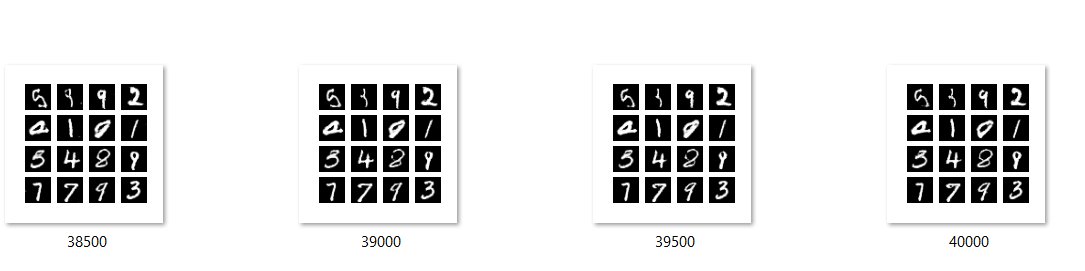